# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 0.05 * range_values
print("The noise is:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)

The noise is: 24.898095903089327


Using matplotlib, I look at the noisy time series I just simulated:

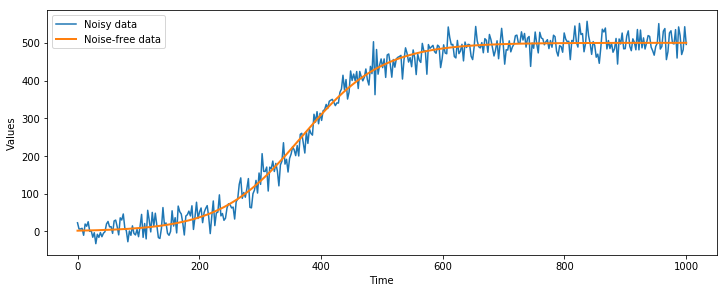

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

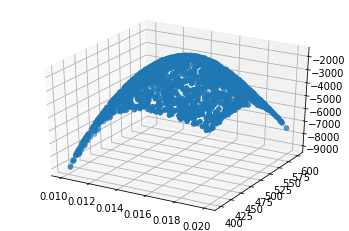

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(problem, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=500, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 82,753
Trainable params: 82,753
Non-trainable params: 0
_________________________________________________________________


In [15]:
emu([0.015, 500])

array([[-1843.5072]], dtype=float32)

In [16]:
log_likelihood([0.015, 500])

-1841.572762235783

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error', 'rescaled_mae', 'rescaled_mse', 'val_rescaled_mae', 'val_rescaled_mse'])


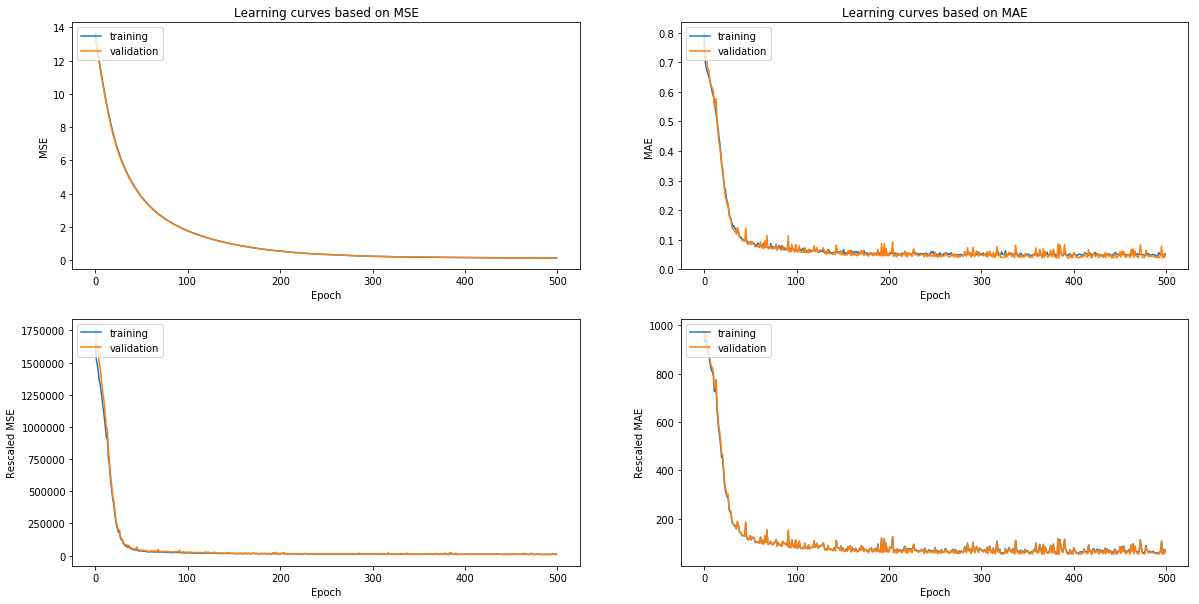

In [40]:
# summarize history for loss
print(hist.history.keys())
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))                 
ax1.title.set_text('Learning curves based on MSE')
ax2.title.set_text('Learning curves based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

ax3.plot(hist.history['rescaled_mse'])
ax3.plot(hist.history['val_rescaled_mse'])
ax3.set_ylabel('Rescaled MSE')
ax3.set_xlabel('Epoch')
ax3.legend(['training', 'validation'], loc='upper left')

ax4.plot(hist.history['rescaled_mae'])
ax4.plot(hist.history['val_rescaled_mae'])
ax4.set_ylabel('Rescaled MAE')
ax4.set_xlabel('Epoch')
ax4.legend(['training', 'validation'], loc='upper left')

plt.show()

In [41]:
val_mse = hist.history["val_loss"]
print("Minimum MSE during validation:", min(val_mse))
idx_mse = list(val_mse).index(min(val_mse))
print("Best epoch based on validation MSE:", idx_mse)
print("\n")

rescaled_val_mse = hist.history["val_rescaled_mse"]
print("Minimum rescaled MSE during validation:", min(rescaled_val_mse))
idx_res_mse = list(rescaled_val_mse).index(min(rescaled_val_mse))
print("Best epoch based on rescaled validation MSE:", idx_res_mse)
print("\n")

val_mae = hist.history["val_mean_absolute_error"]
print("Minimum MAE during validation:", min(val_mae))
idx_mae = list(val_mae).index(min(val_mae))
print("Best epoch based on validation MAE:", idx_mae)
print("\n")

rescaled_val_mae = hist.history["val_rescaled_mae"]
print("Minimum rescaled MAE during validation:", min(rescaled_val_mae))
idx_res_mae = list(rescaled_val_mae).index(min(rescaled_val_mae))
print("Best epoch based on rescaled validation MAE:", idx_res_mae)
print("\n")

print(val_mse[-1])
print(rescaled_val_mse[-1])
print(val_mae[-1])
print(rescaled_val_mae[-1])

Minimum MSE during validation: 0.13217340767383576
Best epoch based on validation MSE: 498


Minimum rescaled MSE during validation: 7357.903985438818
Best epoch based on rescaled validation MSE: 496


Minimum MAE during validation: 0.038261906057596204
Best epoch based on validation MAE: 394


Minimum rescaled MAE during validation: 51.4485026543667
Best epoch based on rescaled validation MAE: 394


0.13337035497029623
9833.595094878714
0.04881493772069613
65.63854619021457


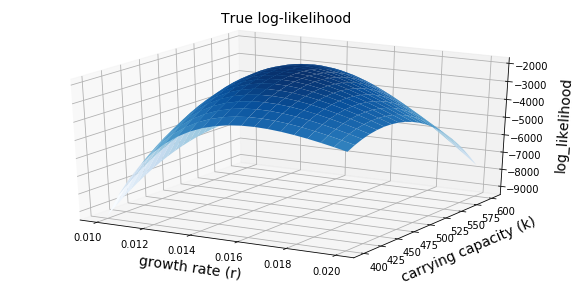

In [19]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

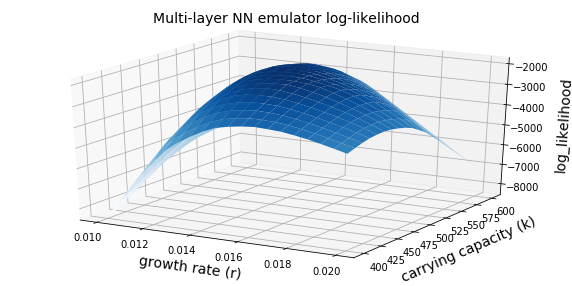

In [20]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, emu_prediction, title = "Multi-layer NN emulator log-likelihood",
                        x_label = "growth rate (r)",
                        y_label = "carrying capacity (k)")

In [21]:
print(model_prediction.shape)
mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
mape

(20, 20)


0.020425306322997754

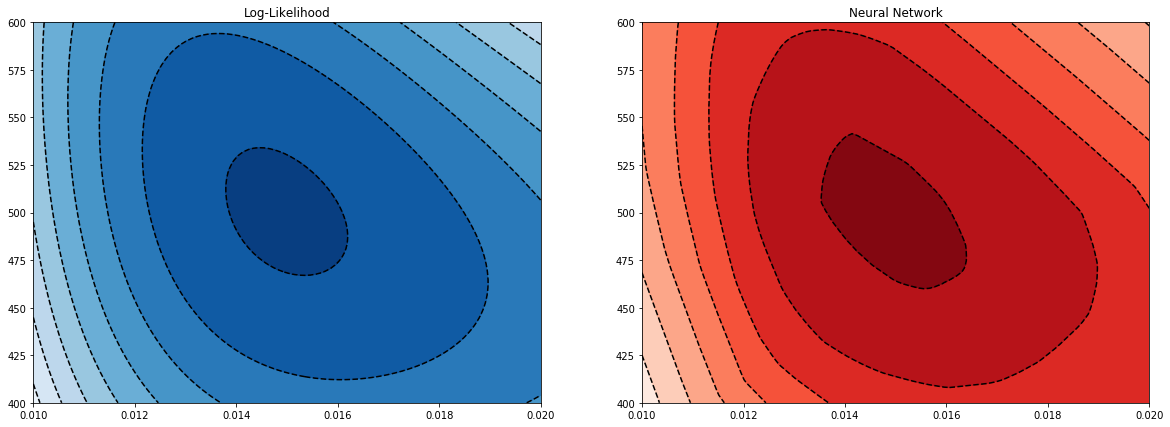

In [22]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

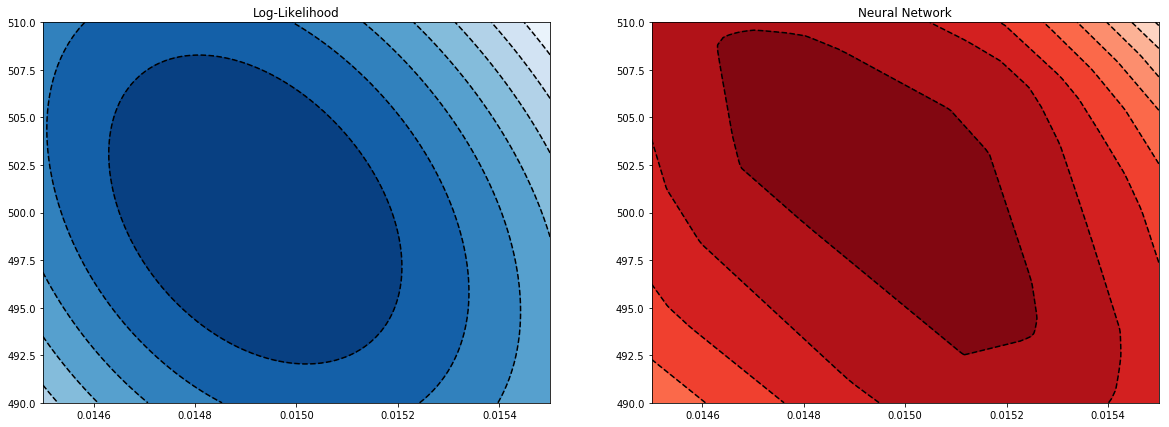

In [23]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0145, 490], [0.0155, 510], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

In [24]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

In [25]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]
[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]
[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]
[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+0

 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]

 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]

 [-2.82778777e-07  1.09675579e-02]]


[[ 8.37944739e-08 -3.19919383e-03]
 [-3.19919383e-03  2.15338199e+02]]


[[ 5.85751651e-09 -1.23242643e-06]
 [-1.23242643e-06  1.55983653e-03]]


[[4.30126556e-09 1.05282343e-06]
 [1.05282343e-06 1.52132275e-02]]


[[ 8.04401967e-08 -3.03387515e-03]
 [-3.03387515e-03  1.99799706e+02]]


[[ 5.72634322e-09 -1.16868093e-06]
 [-1.16868093e-06  1.42967498e-03]]


[[4.17292426e-09 2.07281990e-06]
 [2.07281990e-06 1.89534878e-02]]


[[ 7.67584422e-08 -2.86576986e-03]
 [-2.86576986e-03  1.85223989e+02]]


[[ 6.11902312e-09 -7.17507765e-07]
 [-7.17507765e-07  1.44654079e-03]]


[[3.93341705e-09 8.32923682e-07]
 [8.32923682e-07 2.68727025e-02]]


[[ 7.28957616e-08 -2.69839214e-03]
 [-2.69839214e-03  1.71601210e+02]]


[[7.31470159e-09 3.80230524e-08]
 [3.80230524e-08 1.60509674e-03]]


[[ 3.69757543e-09 -1.18533325e-07]
 [-1.18533325e-07  3.25054793e-02]]


[[ 6.89616862e-08 -2.53427211e-03]
 [-2.53427211e-03  1.58906121e+02]]


[[9.01253647e-09 5.50466714e-

 [1.28360090e-03 1.38640204e+02]]


[[ 7.53122528e-09 -3.28026235e-04]
 [-3.28026235e-04  2.37536726e+01]]


[[ 3.32937829e-09 -4.94487289e-05]
 [-4.94487289e-05  3.48434598e+00]]


[[3.15413607e-08 1.20713669e-03]
 [1.20713669e-03 1.31827478e+02]]


[[ 7.23805145e-09 -3.04615616e-04]
 [-3.04615616e-04  2.29725775e+01]]


[[ 3.49805335e-09 -4.93106052e-05]
 [-4.93106052e-05  3.32177577e+00]]


[[3.02040610e-08 1.13594823e-03]
 [1.13594823e-03 1.25360114e+02]]


[[ 6.95170048e-09 -2.83153948e-04]
 [-2.83153948e-04  2.21907145e+01]]


[[ 3.37249422e-09 -4.42975782e-05]
 [-4.42975782e-05  3.26517453e+00]]


[[2.89128022e-08 1.06961442e-03]
 [1.06961442e-03 1.19220905e+02]]


[[ 6.67274157e-09 -2.63457947e-04]
 [-2.63457947e-04  2.14126865e+01]]


[[ 3.24852439e-09 -3.98082326e-05]
 [-3.98082326e-05  3.20040177e+00]]


[[2.76677169e-08 1.00775245e-03]
 [1.00775245e-03 1.13393383e+02]]


[[ 6.40160319e-09 -2.45363202e-04]
 [-2.45363202e-04  2.06423150e+01]]


[[ 3.12659967e-09 -3.57861195e-

 [7.11663760e-06 3.63628432e+00]]


[[ 6.28595245e-09 -1.70454219e-05]
 [-1.70454219e-05  9.57958566e+00]]


[[ 3.09541381e-09 -8.88056380e-05]
 [-8.88056380e-05  4.86938219e+00]]


[[4.62551587e-09 9.97469072e-06]
 [9.97469072e-06 4.01110441e+00]]


[[ 6.13712413e-09 -1.40533727e-05]
 [-1.40533727e-05  9.25930931e+00]]


[[ 2.97423123e-09 -8.54464112e-05]
 [-8.54464112e-05  4.76213759e+00]]


[[4.46166920e-09 1.24723495e-05]
 [1.24723495e-05 4.33051342e+00]]


[[ 6.17719550e-09 -2.25207998e-05]
 [-2.25207998e-05  9.18759505e+00]]


[[ 2.89938974e-09 -8.23203520e-05]
 [-8.23203520e-05  4.57704802e+00]]


[[4.30333369e-09 1.46447013e-05]
 [1.46447013e-05 4.60012001e+00]]


[[ 6.34918613e-09 -3.10641720e-05]
 [-3.10641720e-05  9.04431370e+00]]


[[ 2.82450681e-09 -7.93082186e-05]
 [-7.93082186e-05  4.39958957e+00]]


[[4.15036958e-09 1.65236234e-05]
 [1.65236234e-05 4.82501179e+00]]


[[ 6.48262127e-09 -3.85357213e-05]
 [-3.85357213e-05  8.89063515e+00]]


[[ 3.04145661e-09 -6.81192699e-

 [-5.80596102e-05  4.49385569e+00]]


[[ 3.85893151e-09 -1.16997510e-04]
 [-1.16997510e-04  5.99119259e+00]]


[[ 2.81582743e-09 -1.13203731e-05]
 [-1.13203731e-05  1.84484977e+00]]


[[ 4.79394674e-09 -5.94722724e-05]
 [-5.94722724e-05  4.50165105e+00]]


[[ 3.73644281e-09 -1.12954215e-04]
 [-1.12954215e-04  5.82358091e+00]]


[[ 2.79370517e-09 -9.93876428e-06]
 [-9.93876428e-06  1.80003444e+00]]


[[ 4.70511488e-09 -6.06275423e-05]
 [-6.06275423e-05  4.49944991e+00]]


[[ 3.61799728e-09 -1.09065721e-04]
 [-1.09065721e-04  5.66004143e+00]]


[[ 2.73915532e-09 -8.20619864e-06]
 [-8.20619864e-06  1.79761249e+00]]


[[ 4.61626172e-09 -5.86150069e-05]
 [-5.86150069e-05  4.35438203e+00]]


[[ 3.50345853e-09 -1.05325362e-04]
 [-1.05325362e-04  5.50053567e+00]]


[[ 2.68420860e-09 -6.62231056e-06]
 [-6.62231056e-06  1.79174226e+00]]


[[ 4.59300153e-09 -6.23302147e-05]
 [-6.23302147e-05  4.46460280e+00]]


[[ 3.39269472e-09 -1.01726797e-04]
 [-1.01726797e-04  5.34501932e+00]]


[[ 2.62902661

 [-6.87899211e-05  2.88166751e+00]]


[[ 6.42994035e-09 -3.27735323e-05]
 [-3.27735323e-05  2.19167241e+00]]


[[4.54168851e-09 3.78239098e-06]
 [3.78239098e-06 2.06548869e+00]]


[[ 4.09078614e-09 -6.94999639e-05]
 [-6.94999639e-05  2.84021975e+00]]


[[ 6.25823467e-09 -3.22186276e-05]
 [-3.22186276e-05  2.14593907e+00]]


[[4.48997349e-09 5.32899913e-06]
 [5.32899913e-06 2.04379089e+00]]


[[ 4.14339095e-09 -7.00438130e-05]
 [-7.00438130e-05  2.79783221e+00]]


[[ 6.09113352e-09 -3.16600992e-05]
 [-3.16600992e-05  2.10069302e+00]]


[[4.43562610e-09 6.73894239e-06]
 [6.73894239e-06 2.02074184e+00]]


[[ 4.18526071e-09 -7.04348307e-05]
 [-7.04348307e-05  2.75465621e+00]]


[[ 5.92852005e-09 -3.10991890e-05]
 [-3.10991890e-05  2.05596781e+00]]


[[4.37896291e-09 8.02160472e-06]
 [8.02160472e-06 1.99649599e+00]]


[[ 4.21724612e-09 -7.06854687e-05]
 [-7.06854687e-05  2.71083106e+00]]


[[ 5.77027968e-09 -3.05370330e-05]
 [-3.05370330e-05  2.01179309e+00]]


[[4.27507187e-09 6.53561222e-

[[ 2.18160549e-09 -2.97742877e-05]
 [-2.97742877e-05  3.09490090e+00]]


[[ 2.87511829e-09 -4.17834241e-05]
 [-4.17834241e-05  2.28855530e+00]]


[[ 3.38320314e-09 -2.73453183e-05]
 [-2.73453183e-05  2.44063705e+00]]


[[ 2.13551905e-09 -2.91219333e-05]
 [-2.91219333e-05  3.01897317e+00]]


[[ 2.85552568e-09 -4.17711122e-05]
 [-4.17711122e-05  2.25206555e+00]]


[[ 3.41805876e-09 -2.58871016e-05]
 [-2.58871016e-05  2.38521924e+00]]


[[ 2.09023797e-09 -2.84823233e-05]
 [-2.84823233e-05  2.94497909e+00]]


[[ 2.83391541e-09 -4.17090715e-05]
 [-4.17090715e-05  2.21553492e+00]]


[[ 3.37275554e-09 -2.82440073e-05]
 [-2.82440073e-05  2.55443843e+00]]


[[ 2.04576006e-09 -2.78553229e-05]
 [-2.78553229e-05  2.87286807e+00]]


[[ 2.91612957e-09 -4.68023955e-05]
 [-4.68023955e-05  2.40701846e+00]]


[[ 3.35772300e-09 -3.10852409e-05]
 [-3.10852409e-05  2.67440805e+00]]


[[ 2.19439598e-09 -3.22116342e-05]
 [-3.22116342e-05  2.92955091e+00]]


[[ 2.98878257e-09 -5.14648427e-05]
 [-5.14648427e-0

[[ 3.70440322e-09 -1.80850037e-05]
 [-1.80850037e-05  2.75606903e+00]]


[[ 4.39980385e-09 -8.44918451e-06]
 [-8.44918451e-06  1.36893842e+00]]


[[ 2.42553537e-09 -2.12122162e-05]
 [-2.12122162e-05  2.63286200e+00]]


[[ 3.74663903e-09 -1.59122389e-05]
 [-1.59122389e-05  2.71901750e+00]]


[[ 4.31498730e-09 -8.25358823e-06]
 [-8.25358823e-06  1.33818429e+00]]


[[ 2.38241941e-09 -2.18142188e-05]
 [-2.18142188e-05  2.67594003e+00]]


[[ 3.79452192e-09 -2.01020917e-05]
 [-2.01020917e-05  2.81465813e+00]]


[[ 4.23154294e-09 -8.06284702e-06]
 [-8.06284702e-06  1.30815325e+00]]


[[ 2.39705897e-09 -2.29354531e-05]
 [-2.29354531e-05  2.65397985e+00]]


[[ 3.83543533e-09 -2.39921491e-05]
 [-2.39921491e-05  2.90111380e+00]]


[[ 4.14946523e-09 -7.87682990e-06]
 [-7.87682990e-06  1.27882751e+00]]


[[ 2.40833822e-09 -2.39590097e-05]
 [-2.39590097e-05  2.63084824e+00]]


[[ 3.86981501e-09 -2.75988905e-05]
 [-2.75988905e-05  2.97892418e+00]]


[[ 4.06874747e-09 -7.69540980e-06]
 [-7.69540980e-0

 [-2.78896993e-05  1.91335275e+00]]


[[ 3.03374922e-09 -9.49204618e-07]
 [-9.49204618e-07  2.02444651e+00]]


[[ 2.41065737e-09 -5.05571177e-06]
 [-5.05571177e-06  3.12231694e+00]]


[[ 4.08046061e-09 -2.74573927e-05]
 [-2.74573927e-05  1.87523873e+00]]


[[ 3.00079117e-09 -2.05641777e-06]
 [-2.05641777e-06  2.02572817e+00]]


[[ 2.39628793e-09 -6.76445287e-06]
 [-6.76445287e-06  3.15113004e+00]]


[[ 4.01138695e-09 -2.70285962e-05]
 [-2.70285962e-05  1.83789155e+00]]


[[ 2.96733986e-09 -3.09395757e-06]
 [-3.09395757e-06  2.02523280e+00]]


[[ 2.38079128e-09 -8.36265786e-06]
 [-8.36265786e-06  3.17553296e+00]]


[[ 3.93497379e-09 -2.75208881e-05]
 [-2.75208881e-05  1.98114481e+00]]


[[ 2.93345633e-09 -4.06529307e-06]
 [-4.06529307e-06  2.02307297e+00]]


[[ 2.3642524e-09 -9.8558731e-06]
 [-9.8558731e-06  3.1957822e+00]]


[[ 3.90369582e-09 -2.86686427e-05]
 [-2.86686427e-05  1.99966716e+00]]


[[ 2.95599190e-09 -7.21007890e-06]
 [-7.21007890e-06  2.10738836e+00]]


[[ 2.34675174e-09

[[ 3.15558452e-09 -1.67589559e-05]
 [-1.67589559e-05  1.92697677e+00]]


[[ 3.68579547e-09 -8.56356200e-06]
 [-8.56356200e-06  1.73215820e+00]]


[[ 4.62477032e-09 -7.27192100e-05]
 [-7.27192100e-05  6.60563810e+00]]


[[ 3.11075349e-09 -1.74490604e-05]
 [-1.74490604e-05  1.95570071e+00]]


[[ 3.65998467e-09 -6.88753553e-06]
 [-6.88753553e-06  1.75009807e+00]]


[[ 4.55926783e-09 -7.14826587e-05]
 [-7.14826587e-05  6.48023746e+00]]


[[ 3.06622710e-09 -1.80871279e-05]
 [-1.80871279e-05  1.98136778e+00]]


[[ 3.63299480e-09 -5.30218650e-06]
 [-5.30218650e-06  1.76574563e+00]]


[[ 4.48057579e-09 -7.04306721e-05]
 [-7.04306721e-05  6.36796408e+00]]


[[ 3.02202179e-09 -1.86757173e-05]
 [-1.86757173e-05  2.00413740e+00]]


[[ 3.60491577e-09 -3.80342071e-06]
 [-3.80342071e-06  1.77922319e+00]]


[[ 4.40313014e-09 -6.93877273e-05]
 [-6.93877273e-05  6.25748684e+00]]


[[ 2.97815274e-09 -1.92172740e-05]
 [-1.92172740e-05  2.02416176e+00]]


[[ 3.57583294e-09 -2.38731953e-06]
 [-2.38731953e-0

 [-7.33742419e-05  3.62342017e+00]]


[[ 5.45845920e-09 -1.06252108e-05]
 [-1.06252108e-05  2.86914873e+00]]


[[ 2.59341617e-09 -1.05056922e-05]
 [-1.05056922e-05  2.34856678e+00]]


[[ 3.47523580e-09 -7.21440066e-05]
 [-7.21440066e-05  3.56271540e+00]]


[[ 5.36241079e-09 -1.09451382e-05]
 [-1.09451382e-05  2.94960119e+00]]


[[ 2.58468140e-09 -1.06887399e-05]
 [-1.06887399e-05  2.31004196e+00]]


[[ 3.41399479e-09 -7.12603232e-05]
 [-7.12603232e-05  3.64924099e+00]]


[[ 5.26808664e-09 -1.12409357e-05]
 [-1.12409357e-05  3.02385980e+00]]


[[ 2.57476497e-09 -1.08551563e-05]
 [-1.08551563e-05  2.27210713e+00]]


[[ 3.35385724e-09 -7.03785423e-05]
 [-7.03785423e-05  3.72880753e+00]]


[[ 5.17545578e-09 -1.15137296e-05]
 [-1.15137296e-05  3.09221481e+00]]


[[ 2.56373855e-09 -1.10057431e-05]
 [-1.10057431e-05  2.23475552e+00]]


[[ 3.29480317e-09 -6.94991551e-05]
 [-6.94991551e-05  3.80174353e+00]]


[[ 5.09199446e-09 -1.18095634e-05]
 [-1.18095634e-05  3.06398975e+00]]


[[ 2.55167057


[[2.29943633e-09 9.60275798e-06]
 [9.60275798e-06 1.37115786e+00]]


[[ 5.27439423e-09 -7.99248743e-05]
 [-7.99248743e-05  3.32574910e+00]]


[[ 4.22948880e-09 -4.26533477e-05]
 [-4.26533477e-05  2.69888097e+00]]


[[2.34230688e-09 1.12112435e-05]
 [1.12112435e-05 1.38638478e+00]]


[[ 5.20856413e-09 -8.03030687e-05]
 [-8.03030687e-05  3.39814122e+00]]


[[ 4.22530429e-09 -4.20293000e-05]
 [-4.20293000e-05  2.65348165e+00]]


[[2.38169401e-09 1.27323155e-05]
 [1.27323155e-05 1.40006146e+00]]


[[ 5.14311220e-09 -8.06168654e-05]
 [-8.06168654e-05  3.46496569e+00]]


[[ 4.21894847e-09 -4.14129950e-05]
 [-4.14129950e-05  2.60887345e+00]]


[[2.49087490e-09 6.25181186e-06]
 [6.25181186e-06 1.63935306e+00]]


[[ 5.07805800e-09 -8.08694041e-05]
 [-8.08694041e-05  3.52647028e+00]]


[[ 4.21053724e-09 -4.08044005e-05]
 [-4.08044005e-05  2.56504213e+00]]


[[2.59315674e-09 9.40427221e-08]
 [9.40427221e-08 1.86567476e+00]]


[[ 5.15450207e-09 -7.95535821e-05]
 [-7.95535821e-05  3.46706448e+00]]

 [-3.46000629e-05  2.33157172e+00]]


[[ 4.43685813e-09 -2.22588636e-05]
 [-2.22588636e-05  2.11764605e+00]]


[[ 3.51463728e-09 -4.93460815e-05]
 [-4.93460815e-05  3.31062401e+00]]


[[ 4.07981218e-09 -3.39822384e-05]
 [-3.39822384e-05  2.43785596e+00]]


[[ 4.55285788e-09 -2.17689199e-05]
 [-2.17689199e-05  2.08391572e+00]]


[[ 3.45850144e-09 -4.85563564e-05]
 [-4.85563564e-05  3.25807862e+00]]


[[ 4.01467016e-09 -3.33767107e-05]
 [-3.33767107e-05  2.53783107e+00]]


[[ 4.48030328e-09 -2.12674990e-05]
 [-2.12674990e-05  2.23580919e+00]]


[[ 3.40329566e-09 -4.77797650e-05]
 [-4.77797650e-05  3.20639329e+00]]


[[ 3.95060674e-09 -3.27832024e-05]
 [-3.27832024e-05  2.63175213e+00]]


[[ 4.40894623e-09 -2.07792509e-05]
 [-2.07792509e-05  2.37932951e+00]]


[[ 3.34900395e-09 -4.70160802e-05]
 [-4.70160802e-05  3.15555359e+00]]


[[ 4.02429966e-09 -3.43010302e-05]
 [-3.43010302e-05  2.62022803e+00]]


[[ 4.33876630e-09 -2.03037926e-05]
 [-2.03037926e-05  2.51480907e+00]]


[[ 3.29561063

 [-3.06625876e-05  4.32389387e+00]]


[[ 4.13007733e-09 -4.39257461e-05]
 [-4.39257461e-05  2.62618220e+00]]


[[ 3.70389622e-09 -5.96750227e-05]
 [-5.96750227e-05  2.72957337e+00]]


[[ 4.33435517e-09 -2.76721222e-05]
 [-2.76721222e-05  4.38385887e+00]]


[[ 4.07332775e-09 -4.36257214e-05]
 [-4.36257214e-05  2.60835290e+00]]


[[ 3.73111116e-09 -5.99350209e-05]
 [-5.99350209e-05  2.70434464e+00]]


[[ 4.31745776e-09 -2.48050263e-05]
 [-2.48050263e-05  4.43907983e+00]]


[[ 4.01728831e-09 -4.33192964e-05]
 [-4.33192964e-05  2.59013598e+00]]


[[ 4.88748443e-09 -7.55969070e-05]
 [-7.55969070e-05  2.88962116e+00]]


[[ 4.54947608e-09 -2.19545471e-05]
 [-2.19545471e-05  4.39210936e+00]]


[[ 3.96195311e-09 -4.30069179e-05]
 [-4.30069179e-05  2.57155832e+00]]


[[ 5.98901868e-09 -9.05117384e-05]
 [-9.05117384e-05  3.06514402e+00]]


[[ 4.76886084e-09 -1.92235736e-05]
 [-1.92235736e-05  4.34525959e+00]]


[[ 3.90731613e-09 -4.26890140e-05]
 [-4.26890140e-05  2.55264570e+00]]


[[ 6.41407824


[[ 3.73814339e-09 -5.71388250e-05]
 [-5.71388250e-05  3.11751119e+00]]


[[ 3.05529535e-09 -4.58344916e-05]
 [-4.58344916e-05  2.60932065e+00]]


[[ 3.63283309e-09 -5.98409185e-05]
 [-5.98409185e-05  4.65492158e+00]]


[[ 3.68462023e-09 -5.64122753e-05]
 [-5.64122753e-05  3.08414760e+00]]


[[ 3.02285971e-09 -4.44619167e-05]
 [-4.44619167e-05  2.61248454e+00]]


[[ 3.76313584e-09 -5.90409198e-05]
 [-5.90409198e-05  4.58717873e+00]]


[[ 3.63187736e-09 -5.56936262e-05]
 [-5.56936262e-05  3.05093906e+00]]


[[ 3.05812004e-09 -4.70261541e-05]
 [-4.70261541e-05  2.70456318e+00]]


[[ 3.88618484e-09 -5.82509221e-05]
 [-5.82509221e-05  4.52045610e+00]]


[[ 3.57990341e-09 -5.49828444e-05]
 [-5.49828444e-05  3.01789337e+00]]


[[ 3.09055995e-09 -4.94590075e-05]
 [-4.94590075e-05  2.79149688e+00]]


[[ 4.00224856e-09 -5.74708296e-05]
 [-5.74708296e-05  4.45473778e+00]]


[[ 3.52868713e-09 -5.42798940e-05]
 [-5.42798940e-05  2.98501793e+00]]


[[ 3.12029065e-09 -5.17652490e-05]
 [-5.17652490e-

[[ 4.05960379e-09 -2.78172745e-05]
 [-2.78172745e-05  3.10102968e+00]]


[[ 3.44534145e-09 -4.03333972e-05]
 [-4.03333972e-05  1.93751886e+00]]


[[ 2.77080697e-09 -2.65595257e-05]
 [-2.65595257e-05  2.77996491e+00]]


[[ 4.27599684e-09 -2.99388614e-05]
 [-2.99388614e-05  3.08083850e+00]]


[[ 3.40541154e-09 -4.03980165e-05]
 [-4.03980165e-05  1.95886996e+00]]


[[ 2.79085167e-09 -2.47206199e-05]
 [-2.47206199e-05  2.77791778e+00]]


[[ 4.48171072e-09 -3.19603737e-05]
 [-3.19603737e-05  3.06030013e+00]]


[[ 3.36583262e-09 -4.04443412e-05]
 [-4.04443412e-05  1.97857391e+00]]


[[ 2.80898247e-09 -2.29488896e-05]
 [-2.29488896e-05  2.77488343e+00]]


[[ 4.67711734e-09 -3.38852586e-05]
 [-3.38852586e-05  3.03943771e+00]]


[[ 3.32660581e-09 -4.04731327e-05]
 [-4.04731327e-05  1.99669295e+00]]


[[ 2.82527364e-09 -2.12421893e-05]
 [-2.12421893e-05  2.77090521e+00]]


[[ 4.86257681e-09 -3.57168542e-05]
 [-3.57168542e-05  3.01827351e+00]]


[[ 3.28773199e-09 -4.04851265e-05]
 [-4.04851265e-0

 [-4.46794116e-05  2.81239269e+00]]


[[ 3.88360544e-09 -4.11727653e-05]
 [-4.11727653e-05  2.08464494e+00]]


[[ 3.90887027e-09 -3.92851466e-05]
 [-3.92851466e-05  3.51333675e+00]]


[[ 4.83798661e-09 -4.63128082e-05]
 [-4.63128082e-05  2.86875842e+00]]


[[ 3.83932694e-09 -4.07881758e-05]
 [-4.07881758e-05  2.06032470e+00]]


[[ 3.85990621e-09 -3.87058587e-05]
 [-3.87058587e-05  3.46711819e+00]]


[[ 4.82476015e-09 -4.78642746e-05]
 [-4.78642746e-05  2.92184454e+00]]


[[ 3.82341494e-09 -3.92412953e-05]
 [-3.92412953e-05  2.06097480e+00]]


[[ 3.81152978e-09 -3.81360009e-05]
 [-3.81360009e-05  3.42151710e+00]]


[[ 4.81034730e-09 -4.93365842e-05]
 [-4.93365842e-05  2.97176545e+00]]


[[ 3.80678027e-09 -3.77424060e-05]
 [-3.77424060e-05  2.06086581e+00]]


[[ 3.76373500e-09 -3.75754001e-05]
 [-3.75754001e-05  3.37652524e+00]]


[[ 4.79480197e-09 -5.07324257e-05]
 [-5.07324257e-05  3.01863200e+00]]


[[ 3.78945868e-09 -3.62901041e-05]
 [-3.62901041e-05  2.06002883e+00]]


[[ 3.71651593

 [-3.72847174e-06  4.92810930e+00]]


[[ 4.14901138e-09 -2.47288589e-06]
 [-2.47288589e-06  1.71014624e+00]]


[[ 3.38085641e-09 -3.01079464e-05]
 [-3.01079464e-05  4.64268136e+00]]


[[ 5.74451018e-09 -3.98508878e-06]
 [-3.98508878e-06  4.88879930e+00]]


[[ 4.09900470e-09 -2.31419380e-06]
 [-2.31419380e-06  1.69256536e+00]]


[[ 3.37169661e-09 -3.26616907e-05]
 [-3.26616907e-05  4.83372356e+00]]


[[ 5.67408216e-09 -4.23047092e-06]
 [-4.23047092e-06  4.84938978e+00]]


[[ 4.10034690e-09 -4.62998644e-06]
 [-4.62998644e-06  1.77214125e+00]]


[[ 3.63145638e-09 -3.75759466e-05]
 [-3.75759466e-05  4.86521026e+00]]


[[ 5.60449749e-09 -4.46497625e-06]
 [-4.46497625e-06  4.80989837e+00]]


[[ 4.10028099e-09 -6.85480379e-06]
 [-6.85480379e-06  1.84805747e+00]]


[[ 3.87998215e-09 -4.22879681e-05]
 [-4.22879681e-05  4.89387158e+00]]


[[ 5.61838195e-09 -2.16633952e-06]
 [-2.16633952e-06  4.80615712e+00]]


[[ 4.09886252e-09 -8.99146198e-06]
 [-8.99146198e-06  1.92043203e+00]]


[[ 4.11763078

 [-5.25012872e-05  2.20213966e+00]]


[[ 5.49346011e-09 -6.56532170e-05]
 [-6.56532170e-05  3.70680869e+00]]


[[ 3.48774923e-09 -1.04007872e-05]
 [-1.04007872e-05  4.61474216e+00]]


[[ 6.74003533e-09 -5.35240919e-05]
 [-5.35240919e-05  2.21425158e+00]]


[[ 5.52190717e-09 -6.52223566e-05]
 [-6.52223566e-05  3.66213185e+00]]


[[ 3.48184918e-09 -1.21987969e-05]
 [-1.21987969e-05  4.65609482e+00]]


[[ 6.72533227e-09 -5.44921858e-05]
 [-5.44921858e-05  2.22522746e+00]]


[[ 5.46548708e-09 -6.45005071e-05]
 [-6.45005071e-05  3.61714879e+00]]


[[ 3.47509466e-09 -1.39259543e-05]
 [-1.39259543e-05  4.69446749e+00]]


[[ 6.70910215e-09 -5.54073400e-05]
 [-5.54073400e-05  2.23510702e+00]]


[[ 5.40948529e-09 -6.37856841e-05]
 [-6.37856841e-05  3.57272777e+00]]


[[ 3.46752039e-09 -1.55843992e-05]
 [-1.55843992e-05  4.72996126e+00]]


[[ 6.69140836e-09 -5.62712747e-05]
 [-5.62712747e-05  2.24392883e+00]]


[[ 5.35390400e-09 -6.30778513e-05]
 [-6.30778513e-05  3.52886174e+00]]


[[ 3.45916002

 [-4.70305499e-05  3.62320362e+00]]


[[ 4.23019628e-09 -3.60280253e-05]
 [-3.60280253e-05  2.12406266e+00]]


[[ 3.50614889e-09 -1.94104502e-05]
 [-1.94104502e-05  3.55801884e+00]]


[[ 3.86950132e-09 -4.88739221e-05]
 [-4.88739221e-05  3.65563478e+00]]


[[ 4.21790530e-09 -3.70706862e-05]
 [-3.70706862e-05  2.15487540e+00]]


[[ 3.75608000e-09 -1.92644514e-05]
 [-1.92644514e-05  3.51518899e+00]]


[[ 3.89739565e-09 -5.06367398e-05]
 [-5.06367398e-05  3.68584299e+00]]


[[ 4.20484192e-09 -3.80650667e-05]
 [-3.80650667e-05  2.18395605e+00]]


[[ 3.81270159e-09 -2.26477553e-05]
 [-2.26477553e-05  3.60119608e+00]]


[[ 3.92316217e-09 -5.23214346e-05]
 [-5.23214346e-05  3.71390090e+00]]


[[ 4.19103851e-09 -3.90126429e-05]
 [-3.90126429e-05  2.21135955e+00]]


[[ 3.86618428e-09 -2.59025864e-05]
 [-2.59025864e-05  3.68306599e+00]]


[[ 3.94687136e-09 -5.39303715e-05]
 [-5.39303715e-05  3.73987913e+00]]


[[ 4.17652643e-09 -3.99148504e-05]
 [-3.99148504e-05  2.23713933e+00]]


[[ 3.91662738

 [-4.81664900e-05  3.19992843e+00]]


[[ 4.06895349e-09 -3.13540435e-05]
 [-3.13540435e-05  5.30966941e+00]]


[[ 4.38311113e-09 -5.16571055e-05]
 [-5.16571055e-05  3.34843170e+00]]


[[ 4.79576116e-09 -4.80458891e-05]
 [-4.80458891e-05  3.17275119e+00]]


[[ 4.31180355e-09 -3.20401691e-05]
 [-3.20401691e-05  5.25144156e+00]]


[[ 4.33191057e-09 -5.10473410e-05]
 [-5.10473410e-05  3.31179928e+00]]


[[ 4.75791470e-09 -4.79305817e-05]
 [-4.79305817e-05  3.14663352e+00]]


[[ 4.32544241e-09 -3.31496856e-05]
 [-3.31496856e-05  5.22449922e+00]]


[[ 4.28132618e-09 -5.04450620e-05]
 [-5.04450620e-05  3.27555008e+00]]


[[ 4.75085527e-09 -4.76756315e-05]
 [-4.76756315e-05  3.11180675e+00]]


[[ 4.33743170e-09 -3.42114116e-05]
 [-3.42114116e-05  5.19708289e+00]]


[[ 4.23135033e-09 -4.98501723e-05]
 [-4.98501723e-05  3.23968070e+00]]


[[ 4.74275570e-09 -4.74166800e-05]
 [-4.74166800e-05  3.07735462e+00]]


[[ 4.34782688e-09 -3.52267506e-05]
 [-3.52267506e-05  5.16921724e+00]]


[[ 4.18197548

 [-6.41565473e-05  4.02715725e+00]]


[[ 3.52975893e-09 -4.67273092e-05]
 [-4.67273092e-05  3.74004285e+00]]


[[ 3.29756264e-09 -4.62100986e-05]
 [-4.62100986e-05  2.52095329e+00]]


[[ 4.24804874e-09 -6.40898728e-05]
 [-6.40898728e-05  4.03706426e+00]]


[[ 3.51819514e-09 -4.68317636e-05]
 [-4.68317636e-05  3.71175344e+00]]


[[ 3.27648381e-09 -4.65278521e-05]
 [-4.65278521e-05  2.53576853e+00]]


[[ 4.20154304e-09 -6.38974852e-05]
 [-6.38974852e-05  4.16245973e+00]]


[[ 3.50612443e-09 -4.69206925e-05]
 [-4.69206925e-05  3.68347583e+00]]


[[ 3.25528313e-09 -4.68229114e-05]
 [-4.68229114e-05  2.54943195e+00]]


[[ 4.15554292e-09 -6.36953008e-05]
 [-6.36953008e-05  4.28253289e+00]]


[[ 3.49356758e-09 -4.69946097e-05]
 [-4.69946097e-05  3.65521715e+00]]


[[ 3.23397049e-09 -4.70959837e-05]
 [-4.70959837e-05  2.56197979e+00]]


[[ 4.11004314e-09 -6.34837129e-05]
 [-6.34837129e-05  4.39743594e+00]]


[[ 3.48054479e-09 -4.70540153e-05]
 [-4.70540153e-05  3.62698430e+00]]


[[ 3.21255544

 [-3.02982053e-05  3.66862892e+00]]


[[ 5.29682982e-09 -5.88735507e-05]
 [-5.88735507e-05  2.98661675e+00]]


[[ 3.02715564e-09 -3.14829135e-05]
 [-3.14829135e-05  2.51526840e+00]]


[[ 1.99733508e-09 -2.99616448e-05]
 [-2.99616448e-05  3.66968481e+00]]


[[ 5.25657223e-09 -5.88605711e-05]
 [-5.88605711e-05  2.97595508e+00]]


[[ 3.08460422e-09 -3.18116711e-05]
 [-3.18116711e-05  2.49255045e+00]]


[[ 1.97530694e-09 -2.96289569e-05]
 [-2.96289569e-05  3.66981802e+00]]


[[ 5.21637318e-09 -5.88337803e-05]
 [-5.88337803e-05  2.96492575e+00]]


[[ 3.13940823e-09 -3.21218693e-05]
 [-3.21218693e-05  2.46998016e+00]]


[[ 1.96107244e-09 -2.99629778e-05]
 [-2.99629778e-05  3.68722136e+00]]


[[ 5.17624085e-09 -5.87936503e-05]
 [-5.87936503e-05  2.95354392e+00]]


[[ 3.19164289e-09 -3.24140546e-05]
 [-3.24140546e-05  2.44755827e+00]]


[[ 1.94683418e-09 -3.02787292e-05]
 [-3.02787292e-05  3.70315912e+00]]


[[ 5.13618313e-09 -5.87406401e-05]
 [-5.87406401e-05  2.94182432e+00]]


[[ 3.17268818

[[ 3.10140690e-09 -3.23654163e-05]
 [-3.23654163e-05  3.98086582e+00]]


[[ 4.22838236e-09 -5.16856168e-05]
 [-5.16856168e-05  2.98411547e+00]]


[[ 4.73549826e-09 -5.60410122e-05]
 [-5.60410122e-05  2.55263629e+00]]


[[ 3.06823819e-09 -3.21360762e-05]
 [-3.21360762e-05  4.06864405e+00]]


[[ 4.19647624e-09 -5.24593919e-05]
 [-5.24593919e-05  3.08317933e+00]]


[[ 4.73225628e-09 -5.47461201e-05]
 [-5.47461201e-05  2.53536357e+00]]


[[ 3.03543334e-09 -3.19067526e-05]
 [-3.19067526e-05  4.15267001e+00]]


[[ 4.16463522e-09 -5.31962930e-05]
 [-5.31962930e-05  3.17835374e+00]]


[[ 4.72803554e-09 -5.34803168e-05]
 [-5.34803168e-05  2.51806578e+00]]


[[ 3.00298828e-09 -3.16774999e-05]
 [-3.16774999e-05  4.23304652e+00]]


[[ 4.12479890e-09 -5.21482187e-05]
 [-5.21482187e-05  3.19163017e+00]]


[[ 4.72286907e-09 -5.22429520e-05]
 [-5.22429520e-05  2.50074786e+00]]


[[ 2.97089898e-09 -3.14483704e-05]
 [-3.14483704e-05  4.30987384e+00]]


[[ 4.13380370e-09 -5.30891265e-05]
 [-5.30891265e-0



[[ 7.82374810e-09 -1.19551217e-04]
 [-1.19551217e-04  6.21294417e+00]]


[[ 3.14191456e-09 -2.08245701e-05]
 [-2.08245701e-05  3.86053750e+00]]


[[ 3.13800084e-09 -2.76284051e-05]
 [-2.76284051e-05  2.23862792e+00]]


[[ 7.80615291e-09 -1.20944879e-04]
 [-1.20944879e-04  6.25691601e+00]]


[[ 3.11199090e-09 -2.08740010e-05]
 [-2.08740010e-05  3.84487052e+00]]


[[ 3.12761326e-09 -2.62597375e-05]
 [-2.62597375e-05  2.26736522e+00]]


[[ 7.78741442e-09 -1.22268675e-04]
 [-1.22268675e-04  6.29815377e+00]]


[[ 3.08232861e-09 -2.09173581e-05]
 [-2.09173581e-05  3.82885987e+00]]


[[ 3.11687239e-09 -2.49281994e-05]
 [-2.49281994e-05  2.29471161e+00]]


[[ 7.76757331e-09 -1.23524533e-04]
 [-1.23524533e-04  6.33673528e+00]]


[[ 3.05292606e-09 -2.09548252e-05]
 [-2.09548252e-05  3.81252013e+00]]


[[ 3.10579192e-09 -2.36329087e-05]
 [-2.36329087e-05  2.32070522e+00]]


[[ 7.74666921e-09 -1.24714334e-04]
 [-1.24714334e-04  6.37273647e+00]]


[[ 3.02378163e-09 -2.09865814e-05]
 [-2.09865814e

 [-1.01153949e-04  6.24569884e+00]]


[[ 3.65382462e-09 -3.88803034e-05]
 [-3.88803034e-05  3.06325860e+00]]


[[ 2.75086247e-09 -2.14694610e-05]
 [-2.14694610e-05  2.88061883e+00]]


[[ 5.71664980e-09 -1.00297585e-04]
 [-1.00297585e-04  6.18227361e+00]]


[[ 3.64505155e-09 -3.91169745e-05]
 [-3.91169745e-05  3.04610887e+00]]


[[ 2.75642416e-09 -2.06599305e-05]
 [-2.06599305e-05  2.86164238e+00]]


[[ 5.79607778e-09 -1.06606743e-04]
 [-1.06606743e-04  6.50961504e+00]]


[[ 3.63579334e-09 -3.93383360e-05]
 [-3.93383360e-05  3.02885356e+00]]


[[ 2.76124652e-09 -1.98708548e-05]
 [-1.98708548e-05  2.84265425e+00]]


[[ 5.74658354e-09 -1.07260179e-04]
 [-1.07260179e-04  6.75967754e+00]]


[[ 3.62606706e-09 -3.95448162e-05]
 [-3.95448162e-05  3.01149968e+00]]


[[ 2.76535148e-09 -1.91017678e-05]
 [-1.91017678e-05  2.82365890e+00]]


[[ 5.71359432e-09 -1.05866658e-04]
 [-1.05866658e-04  6.69436152e+00]]


[[ 3.61588935e-09 -3.97368334e-05]
 [-3.97368334e-05  2.99405401e+00]]


[[ 2.76876048

 [-9.70191614e-05  4.86262714e+00]]


[[ 3.03533086e-09 -2.56236925e-05]
 [-2.56236925e-05  3.40456025e+00]]


[[ 6.33691374e-09 -6.06510169e-05]
 [-6.06510169e-05  2.68630883e+00]]


[[ 6.44564651e-09 -9.67566523e-05]
 [-9.67566523e-05  4.82155504e+00]]


[[ 3.03460414e-09 -2.69398755e-05]
 [-2.69398755e-05  3.45431826e+00]]


[[ 6.77477000e-09 -6.46582210e-05]
 [-6.46582210e-05  2.70199356e+00]]


[[ 6.44725322e-09 -9.64828716e-05]
 [-9.64828716e-05  4.78075712e+00]]


[[ 3.03330008e-09 -2.82114477e-05]
 [-2.82114477e-05  3.50190892e+00]]


[[ 6.91769430e-09 -5.94686230e-05]
 [-5.94686230e-05  2.77329002e+00]]


[[ 6.44753926e-09 -9.61982185e-05]
 [-9.61982185e-05  4.74023343e+00]]


[[ 3.03143649e-09 -2.94395037e-05]
 [-2.94395037e-05  3.54738833e+00]]


[[ 7.05498816e-09 -5.44221774e-05]
 [-5.44221774e-05  2.84191147e+00]]


[[ 6.44654472e-09 -9.59030817e-05]
 [-9.59030817e-05  4.69998397e+00]]


[[ 3.03185638e-09 -3.04889756e-05]
 [-3.04889756e-05  3.57098662e+00]]


[[ 7.18679444

 [-4.70721525e-05  3.43017156e+00]]


[[ 5.77297214e-09 -2.26881390e-05]
 [-2.26881390e-05  3.41062995e+00]]


[[ 4.10536094e-09 -6.46339268e-05]
 [-6.46339268e-05  4.23417945e+00]]


[[ 2.74753594e-09 -4.71206420e-05]
 [-4.71206420e-05  3.42446525e+00]]


[[ 5.71706684e-09 -2.23441141e-05]
 [-2.23441141e-05  3.41989308e+00]]


[[ 4.06757910e-09 -6.42956577e-05]
 [-6.42956577e-05  4.23110030e+00]]


[[ 2.72986517e-09 -4.71588130e-05]
 [-4.71588130e-05  3.41827863e+00]]


[[ 5.66171423e-09 -2.20059157e-05]
 [-2.20059157e-05  3.42823955e+00]]


[[ 4.03013227e-09 -6.39551211e-05]
 [-6.39551211e-05  4.22731173e+00]]


[[ 2.71483591e-09 -4.69026611e-05]
 [-4.69026611e-05  3.38855473e+00]]


[[ 5.60690879e-09 -2.16734370e-05]
 [-2.16734370e-05  3.43569498e+00]]


[[ 3.99154427e-09 -6.33054574e-05]
 [-6.33054574e-05  4.18720661e+00]]


[[ 2.70076131e-09 -4.69799319e-05]
 [-4.69799319e-05  3.37862507e+00]]


[[ 5.59336199e-09 -2.05549756e-05]
 [-2.05549756e-05  3.42229640e+00]]


[[ 3.95332940

 [-3.55858877e-05  4.84734772e+00]]


[[ 4.70631116e-09 -3.34169864e-05]
 [-3.34169864e-05  3.05241200e+00]]


[[ 3.22107133e-09 -3.76043585e-05]
 [-3.76043585e-05  3.13071832e+00]]


[[ 2.51738933e-09 -3.56897299e-05]
 [-3.56897299e-05  4.80988326e+00]]


[[ 4.72124598e-09 -3.45119941e-05]
 [-3.45119941e-05  3.05677607e+00]]


[[ 3.22149628e-09 -3.77920415e-05]
 [-3.77920415e-05  3.11048801e+00]]


[[ 2.51554736e-09 -3.57841720e-05]
 [-3.57841720e-05  4.77262045e+00]]


[[ 4.75480834e-09 -3.56572741e-05]
 [-3.56572741e-05  3.05534783e+00]]


[[ 3.21407313e-09 -3.83724416e-05]
 [-3.83724416e-05  3.11890883e+00]]


[[ 2.50011570e-09 -3.51960478e-05]
 [-3.51960478e-05  4.73440825e+00]]


[[ 4.78655608e-09 -3.67634519e-05]
 [-3.67634519e-05  3.05340958e+00]]


[[ 3.18454443e-09 -3.78690553e-05]
 [-3.78690553e-05  3.10729346e+00]]


[[ 2.48467375e-09 -3.46183572e-05]
 [-3.46183572e-05  4.69643298e+00]]


[[ 4.81653590e-09 -3.78314551e-05]
 [-3.78314551e-05  3.05097648e+00]]


[[ 3.15528422

 [-3.61141191e-05  4.18677499e+00]]


[[ 4.28443719e-09 -4.33538526e-05]
 [-4.33538526e-05  2.37265171e+00]]


[[ 4.82751948e-09 -4.36750327e-05]
 [-4.36750327e-05  3.01159853e+00]]


[[ 3.70288000e-09 -3.58429036e-05]
 [-3.58429036e-05  4.14793289e+00]]


[[ 4.29660089e-09 -4.56126643e-05]
 [-4.56126643e-05  2.48659602e+00]]


[[ 4.78378729e-09 -4.34648276e-05]
 [-4.34648276e-05  3.01361344e+00]]


[[ 3.68893526e-09 -3.55730670e-05]
 [-3.55730670e-05  4.10945877e+00]]


[[ 4.30768095e-09 -4.78004364e-05]
 [-4.78004364e-05  2.59692465e+00]]


[[ 4.74044975e-09 -4.32529768e-05]
 [-4.32529768e-05  3.01505048e+00]]


[[ 3.67474215e-09 -3.53046184e-05]
 [-3.53046184e-05  4.07134909e+00]]


[[ 4.31770621e-09 -4.99187953e-05]
 [-4.99187953e-05  2.70372055e+00]]


[[ 4.69750343e-09 -4.30395649e-05]
 [-4.30395649e-05  3.01592581e+00]]


[[ 3.66031028e-09 -3.50375668e-05]
 [-3.50375668e-05  4.03360035e+00]]


[[ 4.49337873e-09 -5.43010692e-05]
 [-5.43010692e-05  2.78735601e+00]]


[[ 4.65494493

 [-3.52764863e-05  3.60389562e+00]]


[[ 4.23460749e-09 -4.14246686e-05]
 [-4.14246686e-05  2.61835051e+00]]


[[ 3.58428291e-09 -2.60253624e-05]
 [-2.60253624e-05  2.58907654e+00]]


[[ 2.97327820e-09 -3.83034843e-05]
 [-3.83034843e-05  3.75668097e+00]]


[[ 4.23304090e-09 -4.03687163e-05]
 [-4.03687163e-05  2.60676269e+00]]


[[ 3.58100652e-09 -2.56041610e-05]
 [-2.56041610e-05  2.56654709e+00]]


[[ 2.94992955e-09 -3.81658723e-05]
 [-3.81658723e-05  3.73414609e+00]]


[[ 4.23081330e-09 -3.93349883e-05]
 [-3.93349883e-05  2.59505893e+00]]


[[ 3.66213265e-09 -2.63878204e-05]
 [-2.63878204e-05  2.55218631e+00]]


[[ 2.92673025e-09 -3.80256865e-05]
 [-3.80256865e-05  3.71160792e+00]]


[[ 4.19657758e-09 -3.86998070e-05]
 [-3.86998070e-05  2.58854178e+00]]


[[ 3.65495733e-09 -2.68371943e-05]
 [-2.68371943e-05  2.54700353e+00]]


[[ 2.90067637e-09 -3.78040690e-05]
 [-3.78040690e-05  3.70088175e+00]]


[[ 4.16258239e-09 -3.80755945e-05]
 [-3.80755945e-05  2.58177308e+00]]


[[ 3.64737131

[[ 4.17265298e-09 -3.29876412e-05]
 [-3.29876412e-05  4.35683656e+00]]


[[ 3.75044098e-09 -3.72857266e-05]
 [-3.72857266e-05  2.62934827e+00]]


[[ 4.63199947e-09 -3.95318118e-05]
 [-3.95318118e-05  3.12824674e+00]]


[[ 4.13684201e-09 -3.27073843e-05]
 [-3.27073843e-05  4.31794688e+00]]


[[ 3.73811879e-09 -3.77992374e-05]
 [-3.77992374e-05  2.63954477e+00]]


[[ 4.64955297e-09 -3.77831027e-05]
 [-3.77831027e-05  3.13314409e+00]]


[[ 4.10133202e-09 -3.24294297e-05]
 [-3.24294297e-05  4.27941194e+00]]


[[ 3.83072332e-09 -3.94491744e-05]
 [-3.94491744e-05  2.64726001e+00]]


[[ 4.64099222e-09 -3.44687775e-05]
 [-3.44687775e-05  3.37269437e+00]]


[[ 4.06612068e-09 -3.21537608e-05]
 [-3.21537608e-05  4.24122846e+00]]


[[ 3.92022907e-09 -4.10485001e-05]
 [-4.10485001e-05  2.65434527e+00]]


[[ 4.66854196e-09 -3.17029747e-05]
 [-3.17029747e-05  3.42983971e+00]]


[[ 4.03120568e-09 -3.18803607e-05]
 [-3.18803607e-05  4.20339316e+00]]


[[ 4.00670579e-09 -4.25983315e-05]
 [-4.25983315e-0

 [-2.84463870e-05  3.24052041e+00]]


[[ 3.66841752e-09 -4.03610628e-05]
 [-4.03610628e-05  2.69898623e+00]]


[[ 5.14425224e-09 -2.78350842e-05]
 [-2.78350842e-05  2.68218945e+00]]


[[ 3.79241536e-09 -2.81507360e-05]
 [-2.81507360e-05  3.21206114e+00]]


[[ 3.65601694e-09 -3.94595073e-05]
 [-3.94595073e-05  2.69034172e+00]]


[[ 5.10030338e-09 -2.75372101e-05]
 [-2.75372101e-05  2.66086939e+00]]


[[ 3.86716551e-09 -2.78585476e-05]
 [-2.78585476e-05  3.18385797e+00]]


[[ 3.64338110e-09 -3.85756407e-05]
 [-3.85756407e-05  2.68151142e+00]]


[[ 5.05672848e-09 -2.72429516e-05]
 [-2.72429516e-05  2.63970205e+00]]


[[ 3.93935239e-09 -2.75697758e-05]
 [-2.75697758e-05  3.15590855e+00]]


[[ 3.61401181e-09 -3.82147502e-05]
 [-3.82147502e-05  2.65814069e+00]]


[[ 5.01352450e-09 -2.69522587e-05]
 [-2.69522587e-05  2.61868673e+00]]


[[ 4.00903313e-09 -2.72843750e-05]
 [-2.72843750e-05  3.12821053e+00]]


[[ 3.58486098e-09 -3.78574953e-05]
 [-3.78574953e-05  2.63497721e+00]]


[[ 4.98104475

 [-1.38259309e-05  3.61055123e+00]]


[[ 2.83419601e-09 -4.05809448e-05]
 [-4.05809448e-05  3.40963176e+00]]


[[ 4.40680804e-09 -3.31999603e-05]
 [-3.31999603e-05  3.41813942e+00]]


[[ 4.68495793e-09 -1.44265790e-05]
 [-1.44265790e-05  3.67039887e+00]]


[[ 2.80993624e-09 -4.01334727e-05]
 [-4.01334727e-05  3.43187167e+00]]


[[ 4.50892882e-09 -3.67155181e-05]
 [-3.67155181e-05  3.49181103e+00]]


[[ 4.65015770e-09 -1.50095588e-05]
 [-1.50095588e-05  3.72815544e+00]]


[[ 2.83721616e-09 -4.03470236e-05]
 [-4.03470236e-05  3.40835942e+00]]


[[ 4.49065189e-09 -3.51904679e-05]
 [-3.51904679e-05  3.53258691e+00]]


[[ 4.61556897e-09 -1.55752448e-05]
 [-1.55752448e-05  3.78386701e+00]]


[[ 2.86337089e-09 -4.05490822e-05]
 [-4.05490822e-05  3.38495063e+00]]


[[ 4.46042845e-09 -3.43237819e-05]
 [-3.43237819e-05  3.53951062e+00]]


[[ 4.58119152e-09 -1.61240047e-05]
 [-1.61240047e-05  3.83757878e+00]]


[[ 2.88842597e-09 -4.07399194e-05]
 [-4.07399194e-05  3.36164617e+00]]


[[ 4.42454812

 [-6.17847778e-05  3.59205295e+00]]


[[ 4.42739142e-09 -6.42926827e-05]
 [-6.42926827e-05  3.83360728e+00]]


[[ 4.20610075e-09 -2.51474212e-05]
 [-2.51474212e-05  3.82571323e+00]]


[[ 4.99561534e-09 -6.14216407e-05]
 [-6.14216407e-05  3.56892017e+00]]


[[ 4.46246960e-09 -6.43096487e-05]
 [-6.43096487e-05  3.80551226e+00]]


[[ 4.29492921e-09 -2.22844966e-05]
 [-2.22844966e-05  3.84980112e+00]]


[[ 4.95681056e-09 -6.10589643e-05]
 [-6.10589643e-05  3.54586572e+00]]


[[ 4.49602214e-09 -6.43170218e-05]
 [-6.43170218e-05  3.77758775e+00]]


[[ 4.38089237e-09 -1.94910225e-05]
 [-1.94910225e-05  3.87272945e+00]]


[[ 4.91828403e-09 -6.06967905e-05]
 [-6.06967905e-05  3.52289100e+00]]


[[ 4.52808340e-09 -6.43150481e-05]
 [-6.43150481e-05  3.74983348e+00]]


[[ 4.46405141e-09 -1.67656215e-05]
 [-1.67656215e-05  3.89452473e+00]]


[[ 4.88003427e-09 -6.03351597e-05]
 [-6.03351597e-05  3.49999734e+00]]


[[ 4.55868709e-09 -6.43039688e-05]
 [-6.43039688e-05  3.72224917e+00]]


[[ 4.48206729

[[ 4.40703584e-09 -3.40410913e-05]
 [-3.40410913e-05  4.24291439e+00]]


[[ 3.64795605e-09 -4.05796669e-05]
 [-4.05796669e-05  3.39260268e+00]]


[[ 6.02501460e-09 -9.06679922e-05]
 [-9.06679922e-05  5.15318032e+00]]


[[ 4.38282223e-09 -3.33984051e-05]
 [-3.33984051e-05  4.21810324e+00]]


[[ 3.61793232e-09 -4.01687120e-05]
 [-4.01687120e-05  3.38396308e+00]]


[[ 5.97613917e-09 -8.99979036e-05]
 [-8.99979036e-05  5.11625567e+00]]


[[ 4.34797945e-09 -3.32167956e-05]
 [-3.32167956e-05  4.18893319e+00]]


[[ 3.58815945e-09 -3.97624757e-05]
 [-3.97624757e-05  3.37507381e+00]]


[[ 5.92766024e-09 -8.93321432e-05]
 [-8.93321432e-05  5.07954796e+00]]


[[ 4.31340730e-09 -3.30351467e-05]
 [-3.30351467e-05  4.15991431e+00]]


[[ 3.55863535e-09 -3.93608965e-05]
 [-3.93608965e-05  3.36594246e+00]]


[[ 5.88573069e-09 -8.86265763e-05]
 [-8.86265763e-05  5.03754999e+00]]


[[ 4.27910384e-09 -3.28534853e-05]
 [-3.28534853e-05  4.13104689e+00]]


[[ 3.52935792e-09 -3.89639136e-05]
 [-3.89639136e-0

 [-6.22535466e-05  4.33466105e+00]]


[[ 4.24962103e-09 -5.46299083e-05]
 [-5.46299083e-05  4.40524971e+00]]


[[ 3.70523533e-09 -2.97857923e-05]
 [-2.97857923e-05  3.01438520e+00]]


[[ 4.36516474e-09 -6.17532882e-05]
 [-6.17532882e-05  4.29939631e+00]]


[[ 4.22558247e-09 -5.46459508e-05]
 [-5.46459508e-05  4.38925744e+00]]


[[ 3.67770886e-09 -2.99009479e-05]
 [-2.99009479e-05  3.03653853e+00]]


[[ 4.32994436e-09 -6.12570784e-05]
 [-6.12570784e-05  4.26442413e+00]]


[[ 4.20157115e-09 -5.46543338e-05]
 [-5.46543338e-05  4.37307345e+00]]


[[ 3.65036802e-09 -3.00093074e-05]
 [-3.00093074e-05  3.05774543e+00]]


[[ 4.29501144e-09 -6.07648850e-05]
 [-6.07648850e-05  4.22974204e+00]]


[[ 4.17758972e-09 -5.46552467e-05]
 [-5.46552467e-05  4.35670476e+00]]


[[ 3.62321197e-09 -3.01110250e-05]
 [-3.01110250e-05  3.07802653e+00]]


[[ 4.28503499e-09 -6.20721585e-05]
 [-6.20721585e-05  4.32477846e+00]]


[[ 4.15364071e-09 -5.46488754e-05]
 [-5.46488754e-05  4.34015820e+00]]


[[ 3.59623984



[[ 4.43896049e-09 -6.47634698e-05]
 [-6.47634698e-05  6.06692989e+00]]


[[ 4.37627827e-09 -3.24493345e-05]
 [-3.24493345e-05  2.80104777e+00]]


[[ 4.86777466e-09 -4.55744543e-05]
 [-4.55744543e-05  3.54985899e+00]]


[[ 4.56727273e-09 -6.33785316e-05]
 [-6.33785316e-05  6.02268326e+00]]


[[ 4.35519108e-09 -3.19443740e-05]
 [-3.19443740e-05  2.78274346e+00]]


[[ 4.82888349e-09 -4.51735938e-05]
 [-4.51735938e-05  3.52595477e+00]]


[[ 4.69190142e-09 -6.20188370e-05]
 [-6.20188370e-05  5.97872812e+00]]


[[ 4.33405165e-09 -3.14474786e-05]
 [-3.14474786e-05  2.76452227e+00]]


[[ 4.79030847e-09 -4.47765842e-05]
 [-4.47765842e-05  3.50217303e+00]]


[[ 4.81292017e-09 -6.06839489e-05]
 [-6.06839489e-05  5.93506320e+00]]


[[ 4.31286408e-09 -3.09585169e-05]
 [-3.09585169e-05  2.74638460e+00]]


[[ 4.75204700e-09 -4.43833840e-05]
 [-4.43833840e-05  3.47851394e+00]]


[[ 4.93040127e-09 -5.93734378e-05]
 [-5.93734378e-05  5.89168721e+00]]


[[ 4.29163236e-09 -3.04773598e-05]
 [-3.04773598e

[[ 4.44085015e-09 -5.52147259e-05]
 [-5.52147259e-05  4.28346446e+00]]


[[ 4.23254082e-09 -5.55064867e-05]
 [-5.55064867e-05  3.98092575e+00]]


[[ 3.30651651e-09 -2.41811034e-05]
 [-2.41811034e-05  2.87735109e+00]]


[[ 4.42921117e-09 -5.61715736e-05]
 [-5.61715736e-05  4.33209787e+00]]


[[ 4.28380199e-09 -5.58315488e-05]
 [-5.58315488e-05  3.95628468e+00]]


[[ 3.28451906e-09 -2.45454878e-05]
 [-2.45454878e-05  2.92824796e+00]]


[[ 4.41729514e-09 -5.70986639e-05]
 [-5.70986639e-05  4.37903419e+00]]


[[ 4.33330965e-09 -5.61419083e-05]
 [-5.61419083e-05  3.93173460e+00]]


[[ 3.26263382e-09 -2.48981485e-05]
 [-2.48981485e-05  2.97756979e+00]]


[[ 4.40511028e-09 -5.79965949e-05]
 [-5.79965949e-05  4.42430829e+00]]


[[ 4.38109973e-09 -5.64378798e-05]
 [-5.64378798e-05  3.90727652e+00]]


[[ 3.24086092e-09 -2.52393227e-05]
 [-2.52393227e-05  3.02534819e+00]]


[[ 4.39266465e-09 -5.88659538e-05]
 [-5.88659538e-05  4.46795441e+00]]


[[ 4.35429314e-09 -5.58276823e-05]
 [-5.58276823e-0

 [-3.64606033e-05  3.84531542e+00]]


[[ 4.35843159e-09 -6.86070668e-05]
 [-6.86070668e-05  4.23303038e+00]]


[[ 3.65389202e-09 -2.16770711e-05]
 [-2.16770711e-05  3.07547816e+00]]


[[ 2.92947830e-09 -3.63527179e-05]
 [-3.63527179e-05  3.81739413e+00]]


[[ 4.34606398e-09 -6.85382669e-05]
 [-6.85382669e-05  4.21005964e+00]]


[[ 3.69924620e-09 -2.26925753e-05]
 [-2.26925753e-05  3.07048625e+00]]


[[ 2.92137258e-09 -3.62429499e-05]
 [-3.62429499e-05  3.78966344e+00]]


[[ 4.33345891e-09 -6.84627679e-05]
 [-6.84627679e-05  4.18711604e+00]]


[[ 3.74309088e-09 -2.36815688e-05]
 [-2.36815688e-05  3.06523902e+00]]


[[ 2.91310247e-09 -3.61313579e-05]
 [-3.61313579e-05  3.76212232e+00]]


[[ 4.31279994e-09 -6.82009263e-05]
 [-6.82009263e-05  4.16009452e+00]]


[[ 3.78545641e-09 -2.46445573e-05]
 [-2.46445573e-05  3.05974320e+00]]


[[ 2.90467292e-09 -3.60179992e-05]
 [-3.60179992e-05  3.73476971e+00]]


[[ 4.29210178e-09 -6.79369478e-05]
 [-6.79369478e-05  4.13320115e+00]]


[[ 3.77855595

 [-6.45021203e-05  3.84251875e+00]]


[[ 4.87064870e-09 -4.55565558e-05]
 [-4.55565558e-05  2.90371179e+00]]


[[ 5.03487211e-09 -4.04125216e-05]
 [-4.04125216e-05  3.91580119e+00]]


[[ 4.85889837e-09 -6.42422569e-05]
 [-6.42422569e-05  3.81609990e+00]]


[[ 4.83380279e-09 -4.53657935e-05]
 [-4.53657935e-05  2.92508364e+00]]


[[ 4.99807838e-09 -4.00627693e-05]
 [-4.00627693e-05  3.88652312e+00]]


[[ 4.83561658e-09 -6.41380599e-05]
 [-6.41380599e-05  3.79756790e+00]]


[[ 4.79723769e-09 -4.51740932e-05]
 [-4.51740932e-05  2.94561893e+00]]


[[ 4.96154494e-09 -3.97163671e-05]
 [-3.97163671e-05  3.85746283e+00]]


[[ 4.81230275e-09 -6.40287221e-05]
 [-6.40287221e-05  3.77901644e+00]]


[[ 4.76095127e-09 -4.49815001e-05]
 [-4.49815001e-05  2.96533472e+00]]


[[ 4.92527013e-09 -3.93732786e-05]
 [-3.93732786e-05  3.82861874e+00]]


[[ 4.78896045e-09 -6.39143769e-05]
 [-6.39143769e-05  3.76044825e+00]]


[[ 4.72494142e-09 -4.47880585e-05]
 [-4.47880585e-05  2.98424779e+00]]


[[ 4.88925232

 [-5.23111212e-05  3.17492652e+00]]


[[ 4.46774761e-09 -6.44230163e-05]
 [-6.44230163e-05  3.73904108e+00]]


[[ 5.95114119e-09 -3.69571494e-05]
 [-3.69571494e-05  3.87614968e+00]]


[[ 4.08034946e-09 -5.17949085e-05]
 [-5.17949085e-05  3.15187136e+00]]


[[ 4.43490725e-09 -6.41027274e-05]
 [-6.41027274e-05  3.73925309e+00]]


[[ 5.92160178e-09 -3.66215282e-05]
 [-3.66215282e-05  3.84700604e+00]]


[[ 4.06388384e-09 -5.12845057e-05]
 [-5.12845057e-05  3.12897992e+00]]


[[ 4.40230639e-09 -6.37823944e-05]
 [-6.37823944e-05  3.73903343e+00]]


[[ 5.89205720e-09 -3.62893481e-05]
 [-3.62893481e-05  3.81808506e+00]]


[[ 4.04732823e-09 -5.07798393e-05]
 [-5.07798393e-05  3.10625114e+00]]


[[ 4.36994336e-09 -6.34620561e-05]
 [-6.34620561e-05  3.73839209e+00]]


[[ 5.86251106e-09 -3.59605690e-05]
 [-3.59605690e-05  3.78938504e+00]]


[[ 4.02831315e-09 -5.01488056e-05]
 [-5.01488056e-05  3.08798488e+00]]


[[ 4.33781651e-09 -6.31417504e-05]
 [-6.31417504e-05  3.73733886e+00]]


[[ 5.83296689

 [-5.90813237e-05  3.06768312e+00]]


[[ 5.47489223e-09 -4.70696539e-05]
 [-4.70696539e-05  4.70785244e+00]]


[[ 4.50227983e-09 -3.14920836e-05]
 [-3.14920836e-05  3.09750229e+00]]


[[ 3.93476078e-09 -5.86829912e-05]
 [-5.86829912e-05  3.04654250e+00]]


[[ 5.47022865e-09 -4.80781109e-05]
 [-4.80781109e-05  4.72380184e+00]]


[[ 4.46869874e-09 -3.12415921e-05]
 [-3.12415921e-05  3.08799123e+00]]


[[ 3.90642080e-09 -5.82870661e-05]
 [-5.82870661e-05  3.02553719e+00]]


[[ 5.46506267e-09 -4.90586596e-05]
 [-4.90586596e-05  4.73887021e+00]]


[[ 4.43542877e-09 -3.10355155e-05]
 [-3.10355155e-05  3.07503606e+00]]


[[ 3.87828195e-09 -5.78935391e-05]
 [-5.78935391e-05  3.00466652e+00]]


[[ 5.45940630e-09 -5.00118216e-05]
 [-5.00118216e-05  4.75307582e+00]]


[[ 4.49496651e-09 -2.90388571e-05]
 [-2.90388571e-05  3.08573339e+00]]


[[ 3.85034288e-09 -5.75024010e-05]
 [-5.75024010e-05  2.98392982e+00]]


[[ 5.45327132e-09 -5.09381098e-05]
 [-5.09381098e-05  4.76643665e+00]]


[[ 4.55267363

 [-4.35900532e-05  2.67593820e+00]]


[[ 4.31331044e-09 -5.15920372e-05]
 [-5.15920372e-05  4.40854474e+00]]


[[ 3.82090178e-09 -2.15940147e-05]
 [-2.15940147e-05  2.53182503e+00]]


[[ 5.03118055e-09 -4.30571985e-05]
 [-4.30571985e-05  2.65658240e+00]]


[[ 4.28700291e-09 -5.08499219e-05]
 [-5.08499219e-05  4.40040051e+00]]


[[ 3.82329462e-09 -2.13942149e-05]
 [-2.13942149e-05  2.51325860e+00]]


[[ 5.12394370e-09 -4.42700380e-05]
 [-4.42700380e-05  2.65507418e+00]]


[[ 4.26081387e-09 -5.01187010e-05]
 [-5.01187010e-05  4.39196179e+00]]


[[ 3.82522267e-09 -2.11965180e-05]
 [-2.11965180e-05  2.49483100e+00]]


[[ 5.11857212e-09 -4.41137508e-05]
 [-4.41137508e-05  2.63643908e+00]]


[[ 4.23474359e-09 -4.93982121e-05]
 [-4.93982121e-05  4.38323612e+00]]


[[ 3.83537681e-09 -2.03820742e-05]
 [-2.03820742e-05  2.48781894e+00]]


[[ 5.11276782e-09 -4.39561604e-05]
 [-4.39561604e-05  2.61793110e+00]]


[[ 4.25537329e-09 -4.91756841e-05]
 [-4.91756841e-05  4.35139569e+00]]


[[ 3.84489396

 [-2.19232795e-05  2.48481296e+00]]


[[ 4.05969245e-09 -4.57864271e-05]
 [-4.57864271e-05  3.01574547e+00]]


[[ 4.17519177e-09 -4.26334928e-05]
 [-4.26334928e-05  3.43700129e+00]]


[[ 4.13637676e-09 -2.18116423e-05]
 [-2.18116423e-05  2.48340878e+00]]


[[ 4.03107324e-09 -4.55496296e-05]
 [-4.55496296e-05  3.00500118e+00]]


[[ 4.15259436e-09 -4.15987874e-05]
 [-4.15987874e-05  3.48069487e+00]]


[[ 4.10652012e-09 -2.17001490e-05]
 [-2.17001490e-05  2.48177501e+00]]


[[ 4.00265439e-09 -4.53132127e-05]
 [-4.53132127e-05  2.99417590e+00]]


[[ 4.14394036e-09 -4.07796517e-05]
 [-4.07796517e-05  3.46795356e+00]]


[[ 4.07688286e-09 -2.15888083e-05]
 [-2.15888083e-05  2.47991689e+00]]


[[ 3.97443456e-09 -4.50771936e-05]
 [-4.50771936e-05  2.98327261e+00]]


[[ 4.11669466e-09 -4.08342133e-05]
 [-4.08342133e-05  3.48677429e+00]]


[[ 4.04746333e-09 -2.14776289e-05]
 [-2.14776289e-05  2.47783958e+00]]


[[ 3.94641241e-09 -4.48415892e-05]
 [-4.48415892e-05  2.97229420e+00]]


[[ 4.08961056

 [-3.83347636e-05  3.07886843e+00]]


[[ 4.17760474e-09 -3.92974131e-05]
 [-3.92974131e-05  3.19347438e+00]]


[[ 3.52882581e-09 -2.96903069e-05]
 [-2.96903069e-05  2.41266991e+00]]


[[ 3.12622872e-09 -3.80376988e-05]
 [-3.80376988e-05  3.05699149e+00]]


[[ 4.14874518e-09 -3.91299350e-05]
 [-3.91299350e-05  3.18310859e+00]]


[[ 3.50596084e-09 -3.00829957e-05]
 [-3.00829957e-05  2.54901610e+00]]


[[ 3.10458551e-09 -3.77747262e-05]
 [-3.77747262e-05  3.03523512e+00]]


[[ 4.12008194e-09 -3.89620604e-05]
 [-3.89620604e-05  3.17264059e+00]]


[[ 3.48219168e-09 -3.00282154e-05]
 [-3.00282154e-05  2.55039742e+00]]


[[ 3.08309024e-09 -3.75135458e-05]
 [-3.75135458e-05  3.01363619e+00]]


[[ 4.09161376e-09 -3.87938155e-05]
 [-3.87938155e-05  3.16207372e+00]]


[[ 3.45857763e-09 -2.99715492e-05]
 [-2.99715492e-05  2.55148906e+00]]


[[ 3.06174196e-09 -3.72541461e-05]
 [-3.72541461e-05  2.99219357e+00]]


[[ 4.06333941e-09 -3.86252263e-05]
 [-3.86252263e-05  3.15141124e+00]]


[[ 3.43511779

[[ 3.55861347e-09 -3.20873684e-05]
 [-3.20873684e-05  2.81082629e+00]]


[[ 2.74174443e-09 -2.47156283e-05]
 [-2.47156283e-05  1.98681874e+00]]


[[ 4.16194283e-09 -5.82360463e-05]
 [-5.82360463e-05  3.32060962e+00]]


[[ 3.55150099e-09 -3.15806306e-05]
 [-3.15806306e-05  2.79536763e+00]]


[[ 2.73576739e-09 -2.48387838e-05]
 [-2.48387838e-05  1.97942618e+00]]


[[ 4.13631868e-09 -5.78718440e-05]
 [-5.78718440e-05  3.29776672e+00]]


[[ 3.57187855e-09 -3.29635737e-05]
 [-3.29635737e-05  2.83240691e+00]]


[[ 2.72964560e-09 -2.49568702e-05]
 [-2.49568702e-05  1.97199384e+00]]


[[ 4.11082675e-09 -5.75096121e-05]
 [-5.75096121e-05  3.27508033e+00]]


[[ 3.59147089e-09 -3.43139854e-05]
 [-3.43139854e-05  2.86838167e+00]]


[[ 2.72338281e-09 -2.50699843e-05]
 [-2.50699843e-05  1.96452332e+00]]


[[ 4.08546681e-09 -5.71493453e-05]
 [-5.71493453e-05  3.25254939e+00]]


[[ 3.61029285e-09 -3.56324257e-05]
 [-3.56324257e-05  2.90331109e+00]]


[[ 2.71698269e-09 -2.51782211e-05]
 [-2.51782211e-0

[[ 4.86710194e-09 -5.57676928e-05]
 [-5.57676928e-05  3.05175367e+00]]


[[ 3.10561977e-09 -1.70862277e-05]
 [-1.70862277e-05  1.85059419e+00]]


[[ 3.11230189e-09 -4.94119448e-05]
 [-4.94119448e-05  3.90563354e+00]]


[[ 4.83822275e-09 -5.54362872e-05]
 [-5.54362872e-05  3.03114400e+00]]


[[ 3.11708548e-09 -1.68113431e-05]
 [-1.68113431e-05  1.83843744e+00]]


[[ 3.11938422e-09 -4.95432802e-05]
 [-4.95432802e-05  3.88628992e+00]]


[[ 4.80947936e-09 -5.51064483e-05]
 [-5.51064483e-05  3.01067200e+00]]


[[ 3.11736061e-09 -1.72369079e-05]
 [-1.72369079e-05  1.83902767e+00]]


[[ 3.12601696e-09 -4.96670811e-05]
 [-4.96670811e-05  3.86697485e+00]]


[[ 4.78087178e-09 -5.47781758e-05]
 [-5.47781758e-05  2.99033683e+00]]


[[ 3.11732870e-09 -1.76519142e-05]
 [-1.76519142e-05  1.83942782e+00]]


[[ 3.15795268e-09 -4.87458214e-05]
 [-4.87458214e-05  3.84621167e+00]]


[[ 4.75239998e-09 -5.44514694e-05]
 [-5.44514694e-05  2.97013759e+00]]


[[ 3.11699628e-09 -1.80565444e-05]
 [-1.80565444e-0



[[ 3.98853195e-09 -5.23929576e-05]
 [-5.23929576e-05  3.39850063e+00]]


[[ 4.53778492e-09 -3.26444239e-05]
 [-3.26444239e-05  2.48969761e+00]]


[[ 4.24283295e-09 -1.06045567e-05]
 [-1.06045567e-05  2.66445774e+00]]


[[ 3.96128357e-09 -5.20664217e-05]
 [-5.20664217e-05  3.38108230e+00]]


[[ 4.51189623e-09 -3.22500692e-05]
 [-3.22500692e-05  2.47798273e+00]]


[[ 4.24130322e-09 -1.24382758e-05]
 [-1.24382758e-05  2.77757429e+00]]


[[ 3.93422405e-09 -5.17417157e-05]
 [-5.17417157e-05  3.36370464e+00]]


[[ 4.48611645e-09 -3.18608130e-05]
 [-3.18608130e-05  2.46627599e+00]]


[[ 4.32342950e-09 -1.46855563e-05]
 [-1.46855563e-05  2.80736666e+00]]


[[ 3.90735208e-09 -5.14188329e-05]
 [-5.14188329e-05  3.34636848e+00]]


[[ 4.46044581e-09 -3.14765864e-05]
 [-3.14765864e-05  2.45457836e+00]]


[[ 4.40345345e-09 -1.68850762e-05]
 [-1.68850762e-05  2.83627959e+00]]


[[ 3.88066634e-09 -5.10977664e-05]
 [-5.10977664e-05  3.32907466e+00]]


[[ 4.43488453e-09 -3.10973218e-05]
 [-3.10973218e



[[ 3.76797316e-09 -4.81793931e-05]
 [-4.81793931e-05  3.87991362e+00]]


[[ 3.64879397e-09 -3.09490771e-05]
 [-3.09490771e-05  2.10126122e+00]]


[[ 3.27773476e-09 -9.45564791e-06]
 [-9.45564791e-06  2.70808779e+00]]


[[ 3.74971902e-09 -4.76112813e-05]
 [-4.76112813e-05  3.86142179e+00]]


[[ 3.63535731e-09 -3.04660112e-05]
 [-3.04660112e-05  2.09353322e+00]]


[[ 3.32594530e-09 -1.24984863e-05]
 [-1.24984863e-05  2.82665441e+00]]


[[ 3.73149201e-09 -4.70503724e-05]
 [-4.70503724e-05  3.84295166e+00]]


[[ 3.62186013e-09 -2.99899913e-05]
 [-2.99899913e-05  2.08577015e+00]]


[[ 3.37286687e-09 -1.54781352e-05]
 [-1.54781352e-05  2.94254354e+00]]


[[ 3.71329329e-09 -4.64965707e-05]
 [-4.64965707e-05  3.82450452e+00]]


[[ 3.60830495e-09 -2.95209169e-05]
 [-2.95209169e-05  2.07797350e+00]]


[[ 3.41852166e-09 -1.83956179e-05]
 [-1.83956179e-05  3.05579951e+00]]


[[ 3.69512402e-09 -4.59497817e-05]
 [-4.59497817e-05  3.80608166e+00]]


[[ 3.59469426e-09 -2.90586889e-05]
 [-2.90586889e


[[ 4.11718296e-09 -3.25683205e-05]
 [-3.25683205e-05  2.99557705e+00]]


[[ 4.33408507e-09 -7.00585784e-05]
 [-7.00585784e-05  5.17074790e+00]]


[[ 3.26378180e-09 -1.33071277e-05]
 [-1.33071277e-05  2.72756257e+00]]


[[ 4.15302839e-09 -3.31078613e-05]
 [-3.31078613e-05  2.98451950e+00]]


[[ 4.34629336e-09 -6.82058462e-05]
 [-6.82058462e-05  5.18229213e+00]]


[[ 3.24657036e-09 -1.28350643e-05]
 [-1.28350643e-05  2.74042883e+00]]


[[ 4.18777862e-09 -3.36335586e-05]
 [-3.36335586e-05  2.97341662e+00]]


[[ 4.58689188e-09 -6.78535380e-05]
 [-6.78535380e-05  5.14754441e+00]]


[[ 3.22941406e-09 -1.23713570e-05]
 [-1.23713570e-05  2.75278983e+00]]


[[ 4.22145282e-09 -3.41456466e-05]
 [-3.41456466e-05  2.96227037e+00]]


[[ 4.82223216e-09 -6.75022329e-05]
 [-6.75022329e-05  5.11303434e+00]]


[[ 3.23835027e-09 -1.22022951e-05]
 [-1.22022951e-05  2.73455732e+00]]


[[ 4.25406983e-09 -3.46443556e-05]
 [-3.46443556e-05  2.95108266e+00]]


[[ 5.05239977e-09 -6.71519429e-05]
 [-6.71519429e-

 [-2.84756117e-05  3.22720621e+00]]


[[ 5.85053611e-09 -3.71780440e-05]
 [-3.71780440e-05  4.80129038e+00]]


[[ 4.55966954e-09 -3.88925356e-05]
 [-3.88925356e-05  3.72585863e+00]]


[[ 4.05468553e-09 -2.83793916e-05]
 [-2.83793916e-05  3.20607098e+00]]


[[ 5.81726029e-09 -3.69266174e-05]
 [-3.69266174e-05  4.76943153e+00]]


[[ 4.52946669e-09 -3.86905028e-05]
 [-3.86905028e-05  3.76121393e+00]]


[[ 4.05793544e-09 -2.82825970e-05]
 [-2.82825970e-05  3.18507523e+00]]


[[ 5.78413655e-09 -3.66769567e-05]
 [-3.66769567e-05  4.73778851e+00]]


[[ 4.49946778e-09 -3.84890978e-05]
 [-3.84890978e-05  3.79553530e+00]]


[[ 4.09083004e-09 -3.04359366e-05]
 [-3.04359366e-05  3.25556023e+00]]


[[ 5.75116481e-09 -3.64290487e-05]
 [-3.64290487e-05  4.70635981e+00]]


[[ 4.46967140e-09 -3.82883263e-05]
 [-3.82883263e-05  3.82884048e+00]]


[[ 4.12271097e-09 -3.25437390e-05]
 [-3.25437390e-05  3.32435650e+00]]


[[ 5.71834499e-09 -3.61828806e-05]
 [-3.61828806e-05  4.67514396e+00]]


[[ 4.44209867

[[ 4.83269464e-09 -4.84961420e-05]
 [-4.84961420e-05  3.85733823e+00]]


[[ 3.00356905e-09 -2.04042730e-05]
 [-2.04042730e-05  2.92137985e+00]]


[[ 5.03022184e-09 -3.54278123e-05]
 [-3.54278123e-05  4.00520282e+00]]


[[ 4.85304156e-09 -4.70964359e-05]
 [-4.70964359e-05  3.85453731e+00]]


[[ 3.00180298e-09 -1.97776715e-05]
 [-1.97776715e-05  2.91577430e+00]]


[[ 5.00727005e-09 -3.60121359e-05]
 [-3.60121359e-05  4.04543780e+00]]


[[ 4.85699403e-09 -4.60908004e-05]
 [-4.60908004e-05  3.84284741e+00]]


[[ 2.99981449e-09 -1.91617034e-05]
 [-1.91617034e-05  2.91002924e+00]]


[[ 4.98434085e-09 -3.65818786e-05]
 [-3.65818786e-05  4.08453463e+00]]


[[ 4.86045277e-09 -4.51009996e-05]
 [-4.51009996e-05  3.83105834e+00]]


[[ 2.98279743e-09 -1.89101708e-05]
 [-1.89101708e-05  2.89694988e+00]]


[[ 4.96862421e-09 -3.75404714e-05]
 [-3.75404714e-05  4.14246859e+00]]


[[ 4.86342734e-09 -4.41268050e-05]
 [-4.41268050e-05  3.81917313e+00]]


[[ 2.96585969e-09 -1.86619664e-05]
 [-1.86619664e-0

 [-1.84177179e-05  2.84295790e+00]]


[[ 3.04422061e-09 -3.12020930e-06]
 [-3.12020930e-06  2.66379838e+00]]


[[ 4.80425006e-09 -5.19108890e-05]
 [-5.19108890e-05  3.73289735e+00]]


[[ 5.60315556e-09 -1.85923676e-05]
 [-1.85923676e-05  2.83456450e+00]]


[[ 3.04693877e-09 -2.96347129e-06]
 [-2.96347129e-06  2.64735768e+00]]


[[ 4.88397424e-09 -5.44508508e-05]
 [-5.44508508e-05  3.78332525e+00]]


[[ 5.57533408e-09 -1.87620618e-05]
 [-1.87620618e-05  2.82609692e+00]]


[[ 3.04934879e-09 -2.80953441e-06]
 [-2.80953441e-06  2.63101505e+00]]


[[ 4.96173822e-09 -5.69368351e-05]
 [-5.69368351e-05  3.83245511e+00]]


[[ 5.54758685e-09 -1.89268836e-05]
 [-1.89268836e-05  2.81755738e+00]]


[[ 3.05145654e-09 -2.65835671e-06]
 [-2.65835671e-06  2.61476998e+00]]


[[ 5.03757391e-09 -5.93696916e-05]
 [-5.93696916e-05  3.88030828e+00]]


[[ 5.51991481e-09 -1.90869149e-05]
 [-1.90869149e-05  2.80894801e+00]]


[[ 3.05326780e-09 -2.50989686e-06]
 [-2.50989686e-06  2.59862194e+00]]


[[ 5.11151280

 [-3.48760163e-05  2.67341869e+00]]


[[3.26549062e-09 5.26203209e-07]
 [5.26203209e-07 2.52166841e+00]]


[[ 4.93706269e-09 -4.32175865e-05]
 [-4.32175865e-05  3.36274549e+00]]


[[ 4.90759003e-09 -3.46905205e-05]
 [-3.46905205e-05  2.65715692e+00]]


[[3.26127854e-09 5.23425769e-07]
 [5.23425769e-07 2.50550234e+00]]


[[ 4.94231026e-09 -4.46567533e-05]
 [-4.46567533e-05  3.42101305e+00]]


[[ 4.88279030e-09 -3.47932472e-05]
 [-3.47932472e-05  2.65599797e+00]]


[[3.25688034e-09 5.20658886e-07]
 [5.20658886e-07 2.48944204e+00]]


[[ 4.94705203e-09 -4.60645754e-05]
 [-4.60645754e-05  3.47787943e+00]]


[[ 4.85806774e-09 -3.48911487e-05]
 [-3.48911487e-05  2.65464382e+00]]


[[3.25230004e-09 5.17902588e-07]
 [5.17902588e-07 2.47348681e+00]]


[[ 4.95129747e-09 -4.74415450e-05]
 [-4.74415450e-05  3.53336714e+00]]


[[ 4.83342295e-09 -3.49843106e-05]
 [-3.49843106e-05  2.65309838e+00]]


[[3.24754156e-09 5.15156901e-07]
 [5.15156901e-07 2.45763594e+00]]


[[ 4.95505590e-09 -4.87881473e-05

 [-3.63934043e-05  2.29724082e+00]]


[[ 4.01928950e-09 -2.84535826e-05]
 [-2.84535826e-05  3.85176385e+00]]


[[ 4.76367755e-09 -4.87833133e-05]
 [-4.87833133e-05  3.34599140e+00]]


[[ 4.60133054e-09 -3.71302227e-05]
 [-3.71302227e-05  2.30999011e+00]]


[[ 3.99617414e-09 -2.79678659e-05]
 [-2.79678659e-05  3.86643808e+00]]


[[ 4.77111513e-09 -5.00754425e-05]
 [-5.00754425e-05  3.39288302e+00]]


[[ 4.60597992e-09 -3.78500361e-05]
 [-3.78500361e-05  2.32231142e+00]]


[[ 3.97317831e-09 -2.74891525e-05]
 [-2.74891525e-05  3.88052282e+00]]


[[ 4.77802842e-09 -5.13389569e-05]
 [-5.13389569e-05  3.43860981e+00]]


[[ 4.61017146e-09 -3.85531129e-05]
 [-3.85531129e-05  2.33421197e+00]]


[[ 3.95041932e-09 -2.72231666e-05]
 [-2.72231666e-05  3.85935560e+00]]


[[ 4.78442698e-09 -5.25743040e-05]
 [-5.25743040e-05  3.48319048e+00]]


[[ 4.61391364e-09 -3.92397180e-05]
 [-3.92397180e-05  2.34569889e+00]]


[[ 3.92777678e-09 -2.69600606e-05]
 [-2.69600606e-05  3.83828183e+00]]


[[ 4.79032020

 [-1.00518199e-05  3.19470179e+00]]


[[ 4.68933509e-09 -4.72470684e-05]
 [-4.72470684e-05  3.12579031e+00]]


[[ 4.61239813e-09 -5.92661093e-05]
 [-5.92661093e-05  2.98956775e+00]]


[[ 3.24887131e-09 -9.99079614e-06]
 [-9.99079614e-06  3.17466908e+00]]


[[ 4.71511283e-09 -4.82279954e-05]
 [-4.82279954e-05  3.13573975e+00]]


[[ 4.58770665e-09 -5.88812940e-05]
 [-5.88812940e-05  2.97085488e+00]]


[[ 3.22891618e-09 -9.93013747e-06]
 [-9.93013747e-06  3.15476448e+00]]


[[ 4.74835778e-09 -4.89770922e-05]
 [-4.89770922e-05  3.13367367e+00]]


[[ 4.62144540e-09 -5.96262755e-05]
 [-5.96262755e-05  2.97208364e+00]]


[[ 3.20908344e-09 -9.86984186e-06]
 [-9.86984186e-06  3.13498715e+00]]


[[ 4.78060448e-09 -4.97082463e-05]
 [-4.97082463e-05  3.13140071e+00]]


[[ 4.60275517e-09 -5.87456381e-05]
 [-5.87456381e-05  2.97839225e+00]]


[[ 3.18937239e-09 -9.80990726e-06]
 [-9.80990726e-06  3.11533626e+00]]


[[ 4.81186939e-09 -5.04217407e-05]
 [-5.04217407e-05  3.12892500e+00]]


[[ 4.58405588

 [-5.68187883e-05  3.63870070e+00]]


[[ 5.81858641e-09 -4.82523684e-05]
 [-4.82523684e-05  3.26262155e+00]]


[[ 3.95510559e-09 -5.60490163e-05]
 [-5.60490163e-05  4.64468696e+00]]


[[ 4.69518977e-09 -5.65299759e-05]
 [-5.65299759e-05  3.61677601e+00]]


[[ 5.78873434e-09 -4.78757576e-05]
 [-4.78757576e-05  3.24332327e+00]]


[[ 3.95387363e-09 -5.51893568e-05]
 [-5.51893568e-05  4.62709552e+00]]


[[ 4.67214294e-09 -5.62422020e-05]
 [-5.62422020e-05  3.59498197e+00]]


[[ 5.75294423e-09 -4.76114291e-05]
 [-4.76114291e-05  3.23132236e+00]]


[[ 3.95236104e-09 -5.43414716e-05]
 [-5.43414716e-05  4.60947648e+00]]


[[ 4.67385639e-09 -5.62100615e-05]
 [-5.62100615e-05  3.57594308e+00]]


[[ 5.72430051e-09 -4.75454044e-05]
 [-4.75454044e-05  3.21873472e+00]]


[[ 3.95057324e-09 -5.35052055e-05]
 [-5.35052055e-05  4.59183174e+00]]


[[ 4.64516511e-09 -5.58863681e-05]
 [-5.58863681e-05  3.55579099e+00]]


[[ 5.78566710e-09 -4.65978444e-05]
 [-4.65978444e-05  3.20316162e+00]]


[[ 3.94851556


[[ 3.80772231e-09 -4.18099467e-05]
 [-4.18099467e-05  2.81170803e+00]]


[[ 6.18237398e-09 -5.40980905e-05]
 [-5.40980905e-05  3.49105894e+00]]


[[ 3.10499470e-09 -3.34526326e-05]
 [-3.34526326e-05  3.35029704e+00]]


[[ 3.78900772e-09 -4.16660373e-05]
 [-4.16660373e-05  2.79716004e+00]]


[[ 6.14609511e-09 -5.35687131e-05]
 [-5.35687131e-05  3.49244313e+00]]


[[ 3.08652542e-09 -3.31702203e-05]
 [-3.31702203e-05  3.33948704e+00]]


[[ 3.77035309e-09 -4.15216464e-05]
 [-4.15216464e-05  2.78266983e+00]]


[[ 6.11002274e-09 -5.30450656e-05]
 [-5.30450656e-05  3.49353907e+00]]


[[ 3.06816447e-09 -3.28905193e-05]
 [-3.28905193e-05  3.32862512e+00]]


[[ 3.74727794e-09 -4.12549740e-05]
 [-4.12549740e-05  2.76718772e+00]]


[[ 6.07415581e-09 -5.25270818e-05]
 [-5.25270818e-05  3.49435207e+00]]


[[ 3.04991122e-09 -3.26135007e-05]
 [-3.26135007e-05  3.31771308e+00]]


[[ 3.72434634e-09 -4.09901148e-05]
 [-4.09901148e-05  2.75178290e+00]]


[[ 6.03849326e-09 -5.20146958e-05]
 [-5.20146958e-

 [-7.99550805e-05  4.43300355e+00]]


[[ 5.51609918e-09 -6.99984057e-05]
 [-6.99984057e-05  4.27475586e+00]]


[[ 5.28155943e-09 -5.53673414e-05]
 [-5.53673414e-05  3.55744502e+00]]


[[ 6.07798610e-09 -7.94676024e-05]
 [-7.94676024e-05  4.40620844e+00]]


[[ 5.48274197e-09 -6.95043238e-05]
 [-6.95043238e-05  4.27514355e+00]]


[[ 5.26116926e-09 -5.47704500e-05]
 [-5.47704500e-05  3.54159841e+00]]


[[ 6.04105161e-09 -7.89831636e-05]
 [-7.89831636e-05  4.37957758e+00]]


[[ 5.44958943e-09 -6.90141359e-05]
 [-6.90141359e-05  4.27520918e+00]]


[[ 5.24076348e-09 -5.41804140e-05]
 [-5.41804140e-05  3.52577999e+00]]


[[ 6.00434596e-09 -7.85017448e-05]
 [-7.85017448e-05  4.35310996e+00]]


[[ 5.41664028e-09 -6.85278070e-05]
 [-6.85278070e-05  4.27495870e+00]]


[[ 5.22034394e-09 -5.35971513e-05]
 [-5.35971513e-05  3.50999045e+00]]


[[ 5.96786768e-09 -7.80233266e-05]
 [-7.80233266e-05  4.32680457e+00]]


[[ 5.38389327e-09 -6.80453029e-05]
 [-6.80453029e-05  4.27439797e+00]]


[[ 5.19991244

 [-5.37752634e-05  3.40171469e+00]]


[[ 4.66523100e-09 -4.84026208e-05]
 [-4.84026208e-05  3.19092745e+00]]


[[ 5.77917613e-09 -4.14508229e-05]
 [-4.14508229e-05  3.46837893e+00]]


[[ 4.69961870e-09 -5.31788797e-05]
 [-5.31788797e-05  3.38912678e+00]]


[[ 4.65212133e-09 -4.76503401e-05]
 [-4.76503401e-05  3.18589855e+00]]


[[ 5.74451614e-09 -4.11894744e-05]
 [-4.11894744e-05  3.44854144e+00]]


[[ 4.68063225e-09 -5.25894294e-05]
 [-5.25894294e-05  3.37652143e+00]]


[[ 4.63007136e-09 -4.75052459e-05]
 [-4.75052459e-05  3.17009458e+00]]


[[ 5.71006733e-09 -4.09298720e-05]
 [-4.09298720e-05  3.42881321e+00]]


[[ 4.66165070e-09 -5.20068294e-05]
 [-5.20068294e-05  3.36389990e+00]]


[[ 4.60808528e-09 -4.73593414e-05]
 [-4.73593414e-05  3.15434713e+00]]


[[ 5.67582840e-09 -4.06720029e-05]
 [-4.06720029e-05  3.40919371e+00]]


[[ 4.64267536e-09 -5.14309978e-05]
 [-5.14309978e-05  3.35126343e+00]]


[[ 4.58616357e-09 -4.72126522e-05]
 [-4.72126522e-05  3.13865633e+00]]


[[ 5.64179807

 [-4.32783844e-05  2.94131318e+00]]


[[ 3.76885322e-09 -3.80628185e-05]
 [-3.80628185e-05  3.13465687e+00]]


[[ 5.30213395e-09 -5.62499299e-05]
 [-5.62499299e-05  3.36995820e+00]]


[[ 4.34756413e-09 -4.36820126e-05]
 [-4.36820126e-05  2.93977762e+00]]


[[ 3.74659273e-09 -3.78763874e-05]
 [-3.78763874e-05  3.12368516e+00]]


[[ 5.43443284e-09 -5.87729448e-05]
 [-5.87729448e-05  3.39971009e+00]]


[[ 4.34867398e-09 -4.40753209e-05]
 [-4.40753209e-05  2.93806116e+00]]


[[ 3.72446505e-09 -3.76906079e-05]
 [-3.76906079e-05  3.11268839e+00]]


[[ 5.56397884e-09 -6.12466407e-05]
 [-6.12466407e-05  3.42868854e+00]]


[[ 4.34945580e-09 -4.44584678e-05]
 [-4.44584678e-05  2.93616721e+00]]


[[ 3.70246938e-09 -3.75054817e-05]
 [-3.75054817e-05  3.10166782e+00]]


[[ 5.69081239e-09 -6.36717312e-05]
 [-6.36717312e-05  3.45690545e+00]]


[[ 4.34991546e-09 -4.48316095e-05]
 [-4.48316095e-05  2.93409911e+00]]


[[ 3.68551985e-09 -3.72863717e-05]
 [-3.72863717e-05  3.08318326e+00]]


[[ 5.81497343

 [-7.53601787e-05  3.92213214e+00]]


[[ 3.84495309e-09 -5.40438172e-05]
 [-5.40438172e-05  2.83594433e+00]]


[[ 3.85816081e-09 -2.62265646e-05]
 [-2.62265646e-05  2.58353242e+00]]


[[ 6.38992972e-09 -7.55344795e-05]
 [-7.55344795e-05  3.92120249e+00]]


[[ 3.82627122e-09 -5.36075031e-05]
 [-5.36075031e-05  2.82263328e+00]]


[[ 3.84273220e-09 -2.61049224e-05]
 [-2.61049224e-05  2.56843237e+00]]


[[ 6.36925768e-09 -7.57004442e-05]
 [-7.57004442e-05  3.92001687e+00]]


[[ 3.80765453e-09 -5.31751950e-05]
 [-5.31751950e-05  2.80936199e+00]]


[[ 3.82730999e-09 -2.59836220e-05]
 [-2.59836220e-05  2.55342143e+00]]


[[ 6.34850945e-09 -7.58582102e-05]
 [-7.58582102e-05  3.91857997e+00]]


[[ 3.78910320e-09 -5.27468520e-05]
 [-5.27468520e-05  2.79613068e+00]]


[[ 3.81189519e-09 -2.58626659e-05]
 [-2.58626659e-05  2.53849906e+00]]


[[ 6.32768787e-09 -7.60079136e-05]
 [-7.60079136e-05  3.91689639e+00]]


[[ 3.83365780e-09 -5.56530670e-05]
 [-5.56530670e-05  2.93434093e+00]]


[[ 3.79648875

[[ 3.85451564e-09 -3.18822894e-05]
 [-3.18822894e-05  3.26430683e+00]]


[[ 3.35825986e-09 -2.06912612e-05]
 [-2.06912612e-05  2.60540767e+00]]


[[ 5.72717911e-09 -6.17128241e-05]
 [-6.17128241e-05  3.65359787e+00]]


[[ 3.83820453e-09 -3.17485705e-05]
 [-3.17485705e-05  3.24567920e+00]]


[[ 3.34052081e-09 -2.06208914e-05]
 [-2.06208914e-05  2.59154100e+00]]


[[ 5.73552079e-09 -6.27091681e-05]
 [-6.27091681e-05  3.67629484e+00]]


[[ 3.82191823e-09 -3.16150357e-05]
 [-3.16150357e-05  3.22715732e+00]]


[[ 3.32286548e-09 -2.05503521e-05]
 [-2.05503521e-05  2.57774111e+00]]


[[ 5.74332582e-09 -6.36837717e-05]
 [-6.36837717e-05  3.69834357e+00]]


[[ 3.80398627e-09 -3.18005472e-05]
 [-3.18005472e-05  3.23949772e+00]]


[[ 3.30529363e-09 -2.04796514e-05]
 [-2.04796514e-05  2.56400780e+00]]


[[ 5.71538463e-09 -6.26013141e-05]
 [-6.26013141e-05  3.76674477e+00]]


[[ 3.78610993e-09 -3.19806429e-05]
 [-3.19806429e-05  3.25140138e+00]]


[[ 3.28780499e-09 -2.04087970e-05]
 [-2.04087970e-0

 [-3.84255051e-05  3.17707470e+00]]


[[ 3.57210152e-09 -2.61222679e-05]
 [-2.61222679e-05  2.33260788e+00]]


[[ 4.98746628e-09 -5.73735511e-05]
 [-5.73735511e-05  4.35964328e+00]]


[[ 3.51649062e-09 -3.85566737e-05]
 [-3.85566737e-05  3.16758578e+00]]


[[ 3.55152576e-09 -2.59811430e-05]
 [-2.59811430e-05  2.32013786e+00]]


[[ 4.98391013e-09 -5.69873038e-05]
 [-5.69873038e-05  4.33452728e+00]]


[[ 3.51002450e-09 -3.86829887e-05]
 [-3.86829887e-05  3.15805015e+00]]


[[ 3.53107023e-09 -2.58407346e-05]
 [-2.58407346e-05  2.30772951e+00]]


[[ 4.98008290e-09 -5.66039603e-05]
 [-5.66039603e-05  4.30955810e+00]]


[[ 3.50343632e-09 -3.88045268e-05]
 [-3.88045268e-05  3.14846928e+00]]


[[ 3.51073424e-09 -2.57010395e-05]
 [-2.57010395e-05  2.29538261e+00]]


[[ 4.97598963e-09 -5.62234958e-05]
 [-5.62234958e-05  4.28473487e+00]]


[[ 3.49672870e-09 -3.89213637e-05]
 [-3.89213637e-05  3.13884463e+00]]


[[ 3.49258542e-09 -2.56801837e-05]
 [-2.56801837e-05  2.28965755e+00]]


[[ 4.97163528

 [-2.86307299e-05  2.79837526e+00]]


[[ 3.60109277e-09 -4.20438351e-05]
 [-4.20438351e-05  2.86020037e+00]]


[[ 4.78380162e-09 -4.36203774e-05]
 [-4.36203774e-05  3.07171549e+00]]


[[ 3.63862638e-09 -2.81508442e-05]
 [-2.81508442e-05  2.78786794e+00]]


[[ 3.60316373e-09 -4.18588789e-05]
 [-4.18588789e-05  2.84394568e+00]]


[[ 4.78777969e-09 -4.32156805e-05]
 [-4.32156805e-05  3.05487258e+00]]


[[ 3.63559598e-09 -2.76773702e-05]
 [-2.76773702e-05  2.77735879e+00]]


[[ 3.60496308e-09 -4.16743628e-05]
 [-4.16743628e-05  2.82778435e+00]]


[[ 4.79137576e-09 -4.28151150e-05]
 [-4.28151150e-05  3.03811934e+00]]


[[ 3.61595908e-09 -2.74441803e-05]
 [-2.74441803e-05  2.76609913e+00]]


[[ 3.60649543e-09 -4.14902918e-05]
 [-4.14902918e-05  2.81171585e+00]]


[[ 4.79459623e-09 -4.24186361e-05]
 [-4.24186361e-05  3.02145533e+00]]


[[ 3.59642319e-09 -2.72132044e-05]
 [-2.72132044e-05  2.75485204e+00]]


[[ 3.60776532e-09 -4.13066704e-05]
 [-4.13066704e-05  2.79573963e+00]]


[[ 4.79744744

 [-4.42674551e-05  3.13205066e+00]]


[[ 3.64828862e-09 -2.94630348e-05]
 [-2.94630348e-05  2.35404261e+00]]


[[ 3.31093791e-09 -3.95274815e-05]
 [-3.95274815e-05  3.15887923e+00]]


[[ 5.17157444e-09 -4.42012854e-05]
 [-4.42012854e-05  3.11525652e+00]]


[[ 3.63005603e-09 -2.94853545e-05]
 [-2.94853545e-05  2.35516400e+00]]


[[ 3.29342217e-09 -3.91869709e-05]
 [-3.91869709e-05  3.15147042e+00]]


[[ 5.17649227e-09 -4.41334023e-05]
 [-4.41334023e-05  3.09854835e+00]]


[[ 3.61190083e-09 -2.95053985e-05]
 [-2.95053985e-05  2.35611490e+00]]


[[ 3.27599325e-09 -3.88497445e-05]
 [-3.88497445e-05  3.14398534e+00]]


[[ 5.18099365e-09 -4.40638399e-05]
 [-4.40638399e-05  3.08192576e+00]]


[[ 3.59382289e-09 -2.95232049e-05]
 [-2.95232049e-05  2.35689818e+00]]


[[ 3.25865081e-09 -3.85157678e-05]
 [-3.85157678e-05  3.13642579e+00]]


[[ 5.18508546e-09 -4.39926315e-05]
 [-4.39926315e-05  3.06538839e+00]]


[[ 3.57582206e-09 -2.95388110e-05]
 [-2.95388110e-05  2.35751669e+00]]


[[ 3.24023977

 [-3.52459309e-05  2.76135438e+00]]


[[ 5.35503500e-09 -2.85140502e-05]
 [-2.85140502e-05  2.80218014e+00]]


[[ 4.20436735e-09 -4.39286147e-05]
 [-4.39286147e-05  2.51959741e+00]]


[[ 3.15487014e-09 -3.50247254e-05]
 [-3.50247254e-05  2.76280075e+00]]


[[ 5.39315896e-09 -3.00930509e-05]
 [-3.00930509e-05  2.83073318e+00]]


[[ 4.18074133e-09 -4.36340954e-05]
 [-4.36340954e-05  2.56403129e+00]]


[[ 3.14099661e-09 -3.51282964e-05]
 [-3.51282964e-05  2.77054417e+00]]


[[ 5.43029816e-09 -3.16434744e-05]
 [-3.16434744e-05  2.85862502e+00]]


[[ 4.22831195e-09 -4.27728838e-05]
 [-4.27728838e-05  2.55493210e+00]]


[[ 3.12715906e-09 -3.52278992e-05]
 [-3.52278992e-05  2.77798180e+00]]


[[ 5.46646704e-09 -3.31657089e-05]
 [-3.31657089e-05  2.88586516e+00]]


[[ 4.27481196e-09 -4.19235191e-05]
 [-4.19235191e-05  2.54582526e+00]]


[[ 3.11335780e-09 -3.53235954e-05]
 [-3.53235954e-05  2.78511841e+00]]


[[ 5.49070527e-09 -3.36349107e-05]
 [-3.36349107e-05  2.87744776e+00]]


[[ 4.32025662


[[ 3.99252869e-09 -3.55709766e-05]
 [-3.55709766e-05  2.59527225e+00]]


[[ 4.31359798e-09 -4.40484814e-05]
 [-4.40484814e-05  3.13678247e+00]]


[[ 6.16076834e-09 -3.90465503e-05]
 [-3.90465503e-05  3.22654714e+00]]


[[ 3.97382926e-09 -3.50555240e-05]
 [-3.50555240e-05  2.60896915e+00]]


[[ 4.29536417e-09 -4.31492144e-05]
 [-4.31492144e-05  3.19266666e+00]]


[[ 6.16632041e-09 -3.79081223e-05]
 [-3.79081223e-05  3.22979255e+00]]


[[ 3.95519640e-09 -3.45465262e-05]
 [-3.45465262e-05  2.62227493e+00]]


[[ 4.27716922e-09 -4.22623248e-05]
 [-4.22623248e-05  3.24741738e+00]]


[[ 6.19042188e-09 -3.89644291e-05]
 [-3.89644291e-05  3.23925987e+00]]


[[ 3.93663016e-09 -3.40439065e-05]
 [-3.40439065e-05  2.63519535e+00]]


[[ 4.35307282e-09 -4.50402926e-05]
 [-4.50402926e-05  3.32035558e+00]]


[[ 6.21373614e-09 -4.00006399e-05]
 [-4.00006399e-05  3.24836788e+00]]


[[ 3.91813060e-09 -3.35475887e-05]
 [-3.35475887e-05  2.64773612e+00]]


[[ 4.39780262e-09 -4.45099721e-05]
 [-4.45099721e-

 [-2.94291623e-05  2.03153032e+00]]


[[ 5.22683625e-09 -1.44467809e-05]
 [-1.44467809e-05  4.40220109e+00]]


[[ 4.74121629e-09 -3.28028343e-05]
 [-3.28028343e-05  3.23756168e+00]]


[[ 3.22345790e-09 -2.92328352e-05]
 [-2.92328352e-05  2.02095108e+00]]


[[ 5.33116039e-09 -1.49723310e-05]
 [-1.49723310e-05  4.38061675e+00]]


[[ 4.71729062e-09 -3.27575014e-05]
 [-3.27575014e-05  3.22776244e+00]]


[[ 3.21081706e-09 -2.92703487e-05]
 [-2.92703487e-05  2.01743493e+00]]


[[ 5.43342855e-09 -1.54882481e-05]
 [-1.54882481e-05  4.35912363e+00]]


[[ 4.69347450e-09 -3.27109246e-05]
 [-3.27109246e-05  3.21792912e+00]]


[[ 3.29752460e-09 -2.99974834e-05]
 [-2.99974834e-05  2.01384844e+00]]


[[ 5.53366887e-09 -1.59946615e-05]
 [-1.59946615e-05  4.33772155e+00]]


[[ 4.66976758e-09 -3.26631276e-05]
 [-3.26631276e-05  3.20806290e+00]]


[[ 3.38259262e-09 -3.07107260e-05]
 [-3.07107260e-05  2.01019876e+00]]


[[ 5.50760364e-09 -1.54528509e-05]
 [-1.54528509e-05  4.35927702e+00]]


[[ 4.64616952

 [-1.42622869e-05  2.32870872e+00]]


[[ 4.85476702e-09 -1.00345266e-05]
 [-1.00345266e-05  5.89710828e+00]]


[[ 3.68439362e-09 -3.23784377e-05]
 [-3.23784377e-05  2.77332018e+00]]


[[ 2.76362584e-09 -1.42557999e-05]
 [-1.42557999e-05  2.31772810e+00]]


[[ 4.84130100e-09 -1.12698230e-05]
 [-1.12698230e-05  5.99165746e+00]]


[[ 3.70620673e-09 -3.34404336e-05]
 [-3.34404336e-05  2.79470691e+00]]


[[ 2.75134807e-09 -1.42485666e-05]
 [-1.42485666e-05  2.30678936e+00]]


[[ 4.82776676e-09 -1.24841359e-05]
 [-1.24841359e-05  6.08429376e+00]]


[[ 3.72743950e-09 -3.44829689e-05]
 [-3.44829689e-05  2.81557484e+00]]


[[ 2.73910757e-09 -1.42405999e-05]
 [-1.42405999e-05  2.29589246e+00]]


[[ 4.81416627e-09 -1.36777400e-05]
 [-1.36777400e-05  6.17504330e+00]]


[[ 3.70732200e-09 -3.42156849e-05]
 [-3.42156849e-05  2.82110064e+00]]


[[ 2.72690447e-09 -1.42319125e-05]
 [-1.42319125e-05  2.28503738e+00]]


[[ 4.80050147e-09 -1.48509063e-05]
 [-1.48509063e-05  6.26393191e+00]]


[[ 3.68731348

 [-4.38119258e-05  6.16120672e+00]]


[[ 3.34555894e-09 -3.27049870e-05]
 [-3.27049870e-05  2.63874270e+00]]


[[ 2.55309808e-09 -1.26253304e-05]
 [-1.26253304e-05  2.21416787e+00]]


[[ 4.99093812e-09 -4.53091259e-05]
 [-4.53091259e-05  6.14798142e+00]]


[[ 3.35486792e-09 -3.20154288e-05]
 [-3.20154288e-05  2.63394549e+00]]


[[ 2.53983806e-09 -1.25764161e-05]
 [-1.25764161e-05  2.20277724e+00]]


[[ 5.11095562e-09 -4.67792484e-05]
 [-4.67792484e-05  6.13461004e+00]]


[[ 3.36382774e-09 -3.13352301e-05]
 [-3.13352301e-05  2.62907153e+00]]


[[ 2.52664482e-09 -1.25275594e-05]
 [-1.25275594e-05  2.19144272e+00]]


[[ 5.22871579e-09 -4.82226515e-05]
 [-4.82226515e-05  6.12109579e+00]]


[[ 3.37244361e-09 -3.06642777e-05]
 [-3.06642777e-05  2.62412237e+00]]


[[ 2.51305882e-09 -1.25530352e-05]
 [-1.25530352e-05  2.24414946e+00]]


[[ 5.34424878e-09 -4.96396887e-05]
 [-4.96396887e-05  6.10744185e+00]]


[[ 3.38072068e-09 -3.00024593e-05]
 [-3.00024593e-05  2.61909957e+00]]


[[ 2.49954649

 [-1.14108851e-04  7.12318673e+00]]


[[ 3.84049498e-09 -3.97161612e-05]
 [-3.97161612e-05  2.73806733e+00]]


[[ 2.93010141e-09 -1.00597093e-05]
 [-1.00597093e-05  2.19331227e+00]]


[[ 7.51631070e-09 -1.15600641e-04]
 [-1.15600641e-04  7.20775784e+00]]


[[ 3.86962180e-09 -3.95251107e-05]
 [-3.95251107e-05  2.72333119e+00]]


[[ 2.93465939e-09 -9.77821969e-06]
 [-9.77821969e-06  2.18404003e+00]]


[[ 7.51153238e-09 -1.17061625e-04]
 [-1.17061625e-04  7.29054474e+00]]


[[ 3.89805387e-09 -3.93348625e-05]
 [-3.93348625e-05  2.70867576e+00]]


[[ 2.93013191e-09 -9.46116107e-06]
 [-9.46116107e-06  2.17847792e+00]]


[[ 7.51129535e-09 -1.17020201e-04]
 [-1.17020201e-04  7.25991253e+00]]


[[ 3.92580089e-09 -3.91454149e-05]
 [-3.91454149e-05  2.69410059e+00]]


[[ 2.92550815e-09 -9.14868068e-06]
 [-9.14868068e-06  2.17287974e+00]]


[[ 7.51062782e-09 -1.16972679e-04]
 [-1.16972679e-04  7.22935566e+00]]


[[ 3.95287241e-09 -3.89567661e-05]
 [-3.89567661e-05  2.67960523e+00]]


[[ 2.92078998

[[ 3.84921626e-09 -3.41811361e-05]
 [-3.41811361e-05  2.90687665e+00]]


[[ 3.59441141e-09 -8.48795846e-06]
 [-8.48795846e-06  2.14448637e+00]]


[[ 8.23619013e-09 -9.27250826e-05]
 [-9.27250826e-05  5.41879250e+00]]


[[ 3.88631753e-09 -3.35556633e-05]
 [-3.35556633e-05  2.89475575e+00]]


[[ 3.57521647e-09 -8.44034990e-06]
 [-8.44034990e-06  2.14904707e+00]]


[[ 8.34246071e-09 -9.17490244e-05]
 [-9.17490244e-05  5.39139669e+00]]


[[ 4.03514928e-09 -3.62040332e-05]
 [-3.62040332e-05  2.92644343e+00]]


[[ 3.55612591e-09 -8.39302451e-06]
 [-8.39302451e-06  2.15341244e+00]]


[[ 8.44655347e-09 -9.07833945e-05]
 [-9.07833945e-05  5.36413343e+00]]


[[ 4.01977068e-09 -3.64731396e-05]
 [-3.64731396e-05  2.94549530e+00]]


[[ 3.53713914e-09 -8.34598045e-06]
 [-8.34598045e-06  2.15758538e+00]]


[[ 8.54849766e-09 -8.98280802e-05]
 [-8.98280802e-05  5.33700218e+00]]


[[ 4.00441004e-09 -3.67358592e-05]
 [-3.67358592e-05  2.96407435e+00]]


[[ 3.51825559e-09 -8.29921592e-06]
 [-8.29921592e-0



[[ 3.93909028e-09 -1.91303444e-05]
 [-1.91303444e-05  2.74375042e+00]]


[[ 2.92400162e-09 -1.51933462e-05]
 [-1.51933462e-05  2.39434456e+00]]


[[ 7.81185708e-09 -7.28877363e-05]
 [-7.28877363e-05  4.34685919e+00]]


[[ 3.92472151e-09 -1.90002501e-05]
 [-1.90002501e-05  2.72934450e+00]]


[[ 2.91721125e-09 -1.54555476e-05]
 [-1.54555476e-05  2.39516315e+00]]


[[ 7.77131928e-09 -7.25921975e-05]
 [-7.25921975e-05  4.33362695e+00]]


[[ 3.91036161e-09 -1.88711612e-05]
 [-1.88711612e-05  2.71501492e+00]]


[[ 2.92618045e-09 -1.52292973e-05]
 [-1.52292973e-05  2.38333129e+00]]


[[ 7.73099124e-09 -7.22972963e-05]
 [-7.22972963e-05  4.32036265e+00]]


[[ 3.89601126e-09 -1.87430690e-05]
 [-1.87430690e-05  2.70076127e+00]]


[[ 2.93484334e-09 -1.50057922e-05]
 [-1.50057922e-05  2.37155422e+00]]


[[ 7.69087190e-09 -7.20030396e-05]
 [-7.20030396e-05  4.30706757e+00]]


[[ 3.88167114e-09 -1.86159649e-05]
 [-1.86159649e-05  2.68658317e+00]]


[[ 2.94320436e-09 -1.47850009e-05]
 [-1.47850009e



[[ 4.93195883e-09 -2.29606303e-05]
 [-2.29606303e-05  3.11486550e+00]]


[[ 6.43437183e-09 -4.46936634e-05]
 [-4.46936634e-05  3.49088517e+00]]


[[ 3.91070578e-09 -1.73497487e-05]
 [-1.73497487e-05  2.74689865e+00]]


[[ 4.90667038e-09 -2.29559797e-05]
 [-2.29559797e-05  3.12033050e+00]]


[[ 6.42012382e-09 -4.40589579e-05]
 [-4.40589579e-05  3.48073724e+00]]


[[ 3.89819824e-09 -1.73516895e-05]
 [-1.73516895e-05  2.73355066e+00]]


[[ 4.88151070e-09 -2.29501394e-05]
 [-2.29501394e-05  3.12553766e+00]]


[[ 6.40574728e-09 -4.34318354e-05]
 [-4.34318354e-05  3.47055782e+00]]


[[ 3.88567345e-09 -1.73526451e-05]
 [-1.73526451e-05  2.72026275e+00]]


[[ 4.85647915e-09 -2.29431287e-05]
 [-2.29431287e-05  3.13049078e+00]]


[[ 6.39124507e-09 -4.28122103e-05]
 [-4.28122103e-05  3.46034800e+00]]


[[ 3.87313239e-09 -1.73526314e-05]
 [-1.73526314e-05  2.70703469e+00]]


[[ 4.83157511e-09 -2.29349667e-05]
 [-2.29349667e-05  3.13519366e+00]]


[[ 6.37662001e-09 -4.21999981e-05]
 [-4.21999981e

 [-3.85798651e-05  3.95053311e+00]]


[[ 5.04765773e-09 -3.42315083e-05]
 [-3.42315083e-05  3.34793863e+00]]


[[ 4.38419071e-09 -3.91131363e-05]
 [-3.91131363e-05  3.55839767e+00]]


[[ 4.49745303e-09 -3.97336883e-05]
 [-3.97336883e-05  3.97986535e+00]]


[[ 5.03293991e-09 -3.44749363e-05]
 [-3.44749363e-05  3.34587360e+00]]


[[ 4.36184150e-09 -3.89323642e-05]
 [-3.89323642e-05  3.54095397e+00]]


[[ 4.51042070e-09 -4.08673215e-05]
 [-4.08673215e-05  4.00852364e+00]]


[[ 5.01817994e-09 -3.47126939e-05]
 [-3.47126939e-05  3.34365986e+00]]


[[ 4.33960576e-09 -3.87523123e-05]
 [-3.87523123e-05  3.52359144e+00]]


[[ 4.52294166e-09 -4.19810212e-05]
 [-4.19810212e-05  4.03651707e+00]]


[[ 5.00123076e-09 -3.51742418e-05]
 [-3.51742418e-05  3.37118954e+00]]


[[ 4.31748292e-09 -3.85729792e-05]
 [-3.85729792e-05  3.50630977e+00]]


[[ 4.53502228e-09 -4.30750407e-05]
 [-4.30750407e-05  4.06385460e+00]]


[[ 5.03790231e-09 -3.69334521e-05]
 [-3.69334521e-05  3.41379880e+00]]


[[ 4.29547242


[[ 4.04073755e-09 -4.94313384e-05]
 [-4.94313384e-05  3.53318457e+00]]


[[ 4.94989849e-09 -5.12024401e-05]
 [-5.12024401e-05  4.05160647e+00]]


[[ 3.76353605e-09 -4.45465669e-05]
 [-4.45465669e-05  3.11802322e+00]]


[[ 4.01992014e-09 -4.92000909e-05]
 [-4.92000909e-05  3.52316005e+00]]


[[ 4.93681572e-09 -5.16025125e-05]
 [-5.16025125e-05  4.06600303e+00]]


[[ 3.75665397e-09 -4.47861137e-05]
 [-4.47861137e-05  3.11946247e+00]]


[[ 3.99921153e-09 -4.89698097e-05]
 [-4.89698097e-05  3.51310330e+00]]


[[ 5.00258066e-09 -5.23558609e-05]
 [-5.23558609e-05  4.05638641e+00]]


[[ 3.74967848e-09 -4.50195566e-05]
 [-4.50195566e-05  3.12071315e+00]]


[[ 3.97861115e-09 -4.87404922e-05]
 [-4.87404922e-05  3.50301540e+00]]


[[ 5.06705862e-09 -5.30947306e-05]
 [-5.30947306e-05  4.04670288e+00]]


[[ 3.74261143e-09 -4.52469786e-05]
 [-4.52469786e-05  3.12177814e+00]]


[[ 3.95811842e-09 -4.85121359e-05]
 [-4.85121359e-05  3.49289737e+00]]


[[ 5.24828206e-09 -5.51910672e-05]
 [-5.51910672e-

 [-4.24050069e-05  3.75354203e+00]]


[[ 3.69376282e-09 -3.35050209e-05]
 [-3.35050209e-05  2.62043480e+00]]


[[ 3.71140597e-09 -4.35545618e-05]
 [-4.35545618e-05  2.79569560e+00]]


[[ 5.34778603e-09 -4.21960132e-05]
 [-4.21960132e-05  3.73477761e+00]]


[[ 3.71503627e-09 -3.32579409e-05]
 [-3.32579409e-05  2.60713455e+00]]


[[ 3.70085252e-09 -4.38207168e-05]
 [-4.38207168e-05  2.80960709e+00]]


[[ 5.32050508e-09 -4.19880234e-05]
 [-4.19880234e-05  3.71610615e+00]]


[[ 3.73578720e-09 -3.30129202e-05]
 [-3.30129202e-05  2.59390229e+00]]


[[ 3.69026737e-09 -4.40804741e-05]
 [-4.40804741e-05  2.82315695e+00]]


[[ 5.29336502e-09 -4.17810331e-05]
 [-4.17810331e-05  3.69752720e+00]]


[[ 3.85392325e-09 -3.28424470e-05]
 [-3.28424470e-05  2.58059988e+00]]


[[ 3.67965160e-09 -4.43339192e-05]
 [-4.43339192e-05  2.83635006e+00]]


[[ 5.26636514e-09 -4.15750379e-05]
 [-4.15750379e-05  3.67904033e+00]]


[[ 4.00434593e-09 -3.35029858e-05]
 [-3.35029858e-05  2.57140461e+00]]


[[ 3.66900623


[[ 3.34591488e-09 -3.18838845e-05]
 [-3.18838845e-05  2.74852510e+00]]


[[ 3.75077347e-09 -4.32387963e-05]
 [-4.32387963e-05  2.49739778e+00]]


[[ 4.30594566e-09 -3.53644325e-05]
 [-3.53644325e-05  3.26061296e+00]]


[[ 3.32896732e-09 -3.17373731e-05]
 [-3.17373731e-05  2.73745300e+00]]


[[ 3.73693940e-09 -4.31101418e-05]
 [-4.31101418e-05  2.48627461e+00]]


[[ 4.29021614e-09 -3.52862951e-05]
 [-3.52862951e-05  3.24569268e+00]]


[[ 3.31210669e-09 -3.15914602e-05]
 [-3.15914602e-05  2.72640861e+00]]


[[ 3.72312360e-09 -4.29812252e-05]
 [-4.29812252e-05  2.47519291e+00]]


[[ 4.27450526e-09 -3.52075282e-05]
 [-3.52075282e-05  3.23083266e+00]]


[[ 3.29533255e-09 -3.14461445e-05]
 [-3.14461445e-05  2.71539209e+00]]


[[ 3.75162897e-09 -4.43363642e-05]
 [-4.43363642e-05  2.51479493e+00]]


[[ 4.25881357e-09 -3.51281455e-05]
 [-3.51281455e-05  3.21603276e+00]]


[[ 3.28317359e-09 -3.14066293e-05]
 [-3.14066293e-05  2.70472219e+00]]


[[ 3.73617480e-09 -4.38273848e-05]
 [-4.38273848e-

 [-1.58428042e-05  3.21595362e+00]]


[[ 3.38052961e-09 -3.61388498e-05]
 [-3.61388498e-05  2.91612800e+00]]


[[ 3.71281180e-09 -3.08814683e-05]
 [-3.08814683e-05  2.90300369e+00]]


[[ 4.31778076e-09 -1.57469769e-05]
 [-1.57469769e-05  3.20013922e+00]]


[[ 3.39821337e-09 -3.64309309e-05]
 [-3.64309309e-05  2.90787569e+00]]


[[ 3.69669845e-09 -3.08164006e-05]
 [-3.08164006e-05  2.89146397e+00]]


[[ 4.29653549e-09 -1.56518013e-05]
 [-1.56518013e-05  3.18440175e+00]]


[[ 3.41545588e-09 -3.67167268e-05]
 [-3.67167268e-05  2.89960050e+00]]


[[ 3.68064127e-09 -3.07507507e-05]
 [-3.07507507e-05  2.87995206e+00]]


[[ 4.27539372e-09 -1.55572724e-05]
 [-1.55572724e-05  3.16874086e+00]]


[[ 3.43226301e-09 -3.69963190e-05]
 [-3.69963190e-05  2.89130320e+00]]


[[ 3.66464026e-09 -3.06845311e-05]
 [-3.06845311e-05  2.86846814e+00]]


[[ 4.25435495e-09 -1.54633852e-05]
 [-1.54633852e-05  3.15315618e+00]]


[[ 3.41922951e-09 -3.63584483e-05]
 [-3.63584483e-05  2.92396677e+00]]


[[ 3.65581781

 [-3.77519628e-05  3.34809882e+00]]


[[ 3.72771352e-09 -4.66591395e-05]
 [-4.66591395e-05  2.70081263e+00]]


[[ 3.38249226e-09 -2.51503783e-05]
 [-2.51503783e-05  3.82344683e+00]]


[[ 4.83383733e-09 -3.76191097e-05]
 [-3.76191097e-05  3.33254047e+00]]


[[ 3.75945393e-09 -4.74900217e-05]
 [-4.74900217e-05  2.70975513e+00]]


[[ 3.36567464e-09 -2.50959145e-05]
 [-2.50959145e-05  3.84070554e+00]]


[[ 4.81217122e-09 -3.74863701e-05]
 [-3.74863701e-05  3.31704922e+00]]


[[ 3.77922049e-09 -4.60362711e-05]
 [-4.60362711e-05  2.73444419e+00]]


[[ 3.34894140e-09 -2.50410121e-05]
 [-2.50410121e-05  3.85751192e+00]]


[[ 4.79058996e-09 -3.73537491e-05]
 [-3.73537491e-05  3.30162484e+00]]


[[ 3.79850012e-09 -4.46020919e-05]
 [-4.46020919e-05  2.75862460e+00]]


[[ 3.33229211e-09 -2.49856808e-05]
 [-2.49856808e-05  3.87387199e+00]]


[[ 4.76909336e-09 -3.72212518e-05]
 [-3.72212518e-05  3.28626709e+00]]


[[ 3.81729924e-09 -4.31872599e-05]
 [-4.31872599e-05  2.78230286e+00]]


[[ 3.31572637

 [-3.43196911e-05  3.04307721e+00]]


[[ 3.10070947e-09 -3.28931099e-05]
 [-3.28931099e-05  3.06860760e+00]]


[[ 2.95644191e-09 -2.61368455e-05]
 [-2.61368455e-05  3.78845302e+00]]


[[ 4.81937581e-09 -3.39718366e-05]
 [-3.39718366e-05  3.02854309e+00]]


[[ 3.08564511e-09 -3.27790656e-05]
 [-3.27790656e-05  3.06002552e+00]]


[[ 2.95024720e-09 -2.64776983e-05]
 [-2.64776983e-05  3.79562711e+00]]


[[ 4.87666544e-09 -3.54178061e-05]
 [-3.54178061e-05  3.04556352e+00]]


[[ 3.09930208e-09 -3.42684957e-05]
 [-3.42684957e-05  3.13892310e+00]]


[[ 2.95505465e-09 -2.62161980e-05]
 [-2.62161980e-05  3.77760025e+00]]


[[ 4.93285815e-09 -3.68404211e-05]
 [-3.68404211e-05  3.06217918e+00]]


[[ 3.11260188e-09 -3.57339788e-05]
 [-3.57339788e-05  3.21648676e+00]]


[[ 2.95964428e-09 -2.59573095e-05]
 [-2.59573095e-05  3.75965609e+00]]


[[ 4.98796766e-09 -3.82399624e-05]
 [-3.82399624e-05  3.07839534e+00]]


[[ 3.12554922e-09 -3.71758024e-05]
 [-3.71758024e-05  3.29273274e+00]]


[[ 2.94503615

[[ 5.30793995e-09 -5.21935574e-05]
 [-5.21935574e-05  3.25098361e+00]]


[[ 2.98445037e-09 -3.18960920e-05]
 [-3.18960920e-05  3.01106510e+00]]


[[ 2.88798329e-09 -3.79602699e-05]
 [-3.79602699e-05  3.53210082e+00]]


[[ 5.28671851e-09 -5.21368889e-05]
 [-5.21368889e-05  3.24300831e+00]]


[[ 2.97878895e-09 -3.16214419e-05]
 [-3.16214419e-05  2.99769452e+00]]


[[ 2.89688978e-09 -3.86267446e-05]
 [-3.86267446e-05  3.54611883e+00]]


[[ 5.26555440e-09 -5.20785220e-05]
 [-5.20785220e-05  3.23499337e+00]]


[[ 2.97306643e-09 -3.13493260e-05]
 [-3.13493260e-05  2.98437629e+00]]


[[ 2.91277054e-09 -3.84803307e-05]
 [-3.84803307e-05  3.52866350e+00]]


[[ 5.24444782e-09 -5.20184848e-05]
 [-5.20184848e-05  3.22693980e+00]]


[[ 2.96728403e-09 -3.10797200e-05]
 [-3.10797200e-05  2.97111029e+00]]


[[ 2.89915813e-09 -3.84391387e-05]
 [-3.84391387e-05  3.53974063e+00]]


[[ 5.22486027e-09 -5.18258280e-05]
 [-5.18258280e-05  3.21165329e+00]]


[[ 2.96144293e-09 -3.08125995e-05]
 [-3.08125995e-0

[[ 4.58717264e-09 -4.43752410e-05]
 [-4.43752410e-05  3.34109356e+00]]


[[ 3.71662286e-09 -3.74735354e-05]
 [-3.74735354e-05  3.30163594e+00]]


[[ 2.93382844e-09 -3.71228916e-05]
 [-3.71228916e-05  3.11318709e+00]]


[[ 4.68659710e-09 -4.44901954e-05]
 [-4.44901954e-05  3.32561795e+00]]


[[ 3.71936499e-09 -3.79481711e-05]
 [-3.79481711e-05  3.30612140e+00]]


[[ 2.92367587e-09 -3.65302148e-05]
 [-3.65302148e-05  3.13775850e+00]]


[[ 4.78433316e-09 -4.46013238e-05]
 [-4.46013238e-05  3.31021066e+00]]


[[ 3.70802323e-09 -3.74338454e-05]
 [-3.74338454e-05  3.30554209e+00]]


[[ 2.91353253e-09 -3.59445108e-05]
 [-3.59445108e-05  3.16181772e+00]]


[[ 4.88040116e-09 -4.47086777e-05]
 [-4.47086777e-05  3.29487142e+00]]


[[ 3.69667062e-09 -3.69252955e-05]
 [-3.69252955e-05  3.30481280e+00]]


[[ 2.90339879e-09 -3.53657046e-05]
 [-3.53657046e-05  3.18537117e+00]]


[[ 4.96806277e-09 -4.54369600e-05]
 [-4.54369600e-05  3.28676410e+00]]


[[ 3.68530786e-09 -3.64224602e-05]
 [-3.64224602e-0

[[ 5.13545463e-09 -3.49405975e-05]
 [-3.49405975e-05  3.30494705e+00]]


[[ 3.47849165e-09 -1.80707929e-05]
 [-1.80707929e-05  3.65710981e+00]]


[[ 3.43465208e-09 -3.76238699e-05]
 [-3.76238699e-05  3.42282004e+00]]


[[ 5.23187444e-09 -3.37419899e-05]
 [-3.37419899e-05  3.29755383e+00]]


[[ 3.49977075e-09 -1.68720019e-05]
 [-1.68720019e-05  3.67156760e+00]]


[[ 3.42769124e-09 -3.74968567e-05]
 [-3.74968567e-05  3.40646826e+00]]


[[ 5.32663621e-09 -3.25593164e-05]
 [-3.25593164e-05  3.29011260e+00]]


[[ 3.48532468e-09 -1.64052673e-05]
 [-1.64052673e-05  3.71048029e+00]]


[[ 3.42066992e-09 -3.73699258e-05]
 [-3.73699258e-05  3.39019436e+00]]


[[ 5.41975984e-09 -3.13923990e-05]
 [-3.13923990e-05  3.28262445e+00]]


[[ 3.47092490e-09 -1.59445822e-05]
 [-1.59445822e-05  3.74864820e+00]]


[[ 3.41358935e-09 -3.72430823e-05]
 [-3.72430823e-05  3.37399798e+00]]


[[ 5.39533768e-09 -3.07204221e-05]
 [-3.07204221e-05  3.40296814e+00]]


[[ 3.45406885e-09 -1.59072910e-05]
 [-1.59072910e-0

[[ 6.15384935e-09 -5.45375843e-05]
 [-5.45375843e-05  4.85730864e+00]]


[[ 5.31825926e-09 -7.17332800e-05]
 [-7.17332800e-05  4.40549878e+00]]


[[ 2.84591075e-09 -3.85980419e-05]
 [-3.85980419e-05  3.01946977e+00]]


[[ 6.13197581e-09 -5.46773713e-05]
 [-5.46773713e-05  4.85442405e+00]]


[[ 5.31430393e-09 -7.17249183e-05]
 [-7.17249183e-05  4.38945034e+00]]


[[ 2.83220442e-09 -3.84045668e-05]
 [-3.84045668e-05  3.00555893e+00]]


[[ 6.11013363e-09 -5.48125740e-05]
 [-5.48125740e-05  4.85135464e+00]]


[[ 5.31015785e-09 -7.17133281e-05]
 [-7.17133281e-05  4.37343002e+00]]


[[ 2.81856493e-09 -3.82121086e-05]
 [-3.82121086e-05  2.99170979e+00]]


[[ 6.08832340e-09 -5.49432530e-05]
 [-5.49432530e-05  4.84810326e+00]]


[[ 5.30917316e-09 -7.20902436e-05]
 [-7.20902436e-05  4.37348035e+00]]


[[ 2.80499195e-09 -3.80206616e-05]
 [-3.80206616e-05  2.97792213e+00]]


[[ 6.06435799e-09 -5.50330584e-05]
 [-5.50330584e-05  4.84769486e+00]]


[[ 5.30795489e-09 -7.24583185e-05]
 [-7.24583185e-0

[[ 5.58940399e-09 -4.95753783e-05]
 [-4.95753783e-05  4.52442850e+00]]


[[ 5.04985017e-09 -6.26809160e-05]
 [-6.26809160e-05  3.84722685e+00]]


[[ 2.33795840e-09 -2.71574398e-05]
 [-2.71574398e-05  2.68680103e+00]]


[[ 5.56390258e-09 -4.93380680e-05]
 [-4.93380680e-05  4.50269314e+00]]


[[ 5.04316593e-09 -6.30641914e-05]
 [-6.30641914e-05  3.85539486e+00]]


[[ 2.34149591e-09 -2.65245132e-05]
 [-2.65245132e-05  2.69098717e+00]]


[[ 5.53851281e-09 -4.91019090e-05]
 [-4.91019090e-05  4.48106397e+00]]


[[ 5.03634591e-09 -6.34390351e-05]
 [-6.34390351e-05  3.86326756e+00]]


[[ 2.34487458e-09 -2.58994944e-05]
 [-2.58994944e-05  2.69498904e+00]]


[[ 5.51323427e-09 -4.88668956e-05]
 [-4.88668956e-05  4.45954046e+00]]


[[ 5.02939240e-09 -6.38055524e-05]
 [-6.38055524e-05  3.87084888e+00]]


[[ 2.33793195e-09 -2.52914820e-05]
 [-2.52914820e-05  2.73617515e+00]]


[[ 5.48806652e-09 -4.86330221e-05]
 [-4.86330221e-05  4.43812209e+00]]


[[ 5.02230769e-09 -6.41638476e-05]
 [-6.41638476e-0

[[ 6.21447174e-09 -7.31992453e-05]
 [-7.31992453e-05  4.60449318e+00]]


[[ 3.96476913e-09 -5.27341370e-05]
 [-5.27341370e-05  3.10826847e+00]]


[[ 2.48945832e-09 -1.89520880e-05]
 [-1.89520880e-05  3.06474957e+00]]


[[ 6.18821574e-09 -7.25234900e-05]
 [-7.25234900e-05  4.61404040e+00]]


[[ 3.94587204e-09 -5.24944179e-05]
 [-5.24944179e-05  3.10348795e+00]]


[[ 2.49625145e-09 -1.92077632e-05]
 [-1.92077632e-05  3.05654730e+00]]


[[ 6.16205487e-09 -7.18541202e-05]
 [-7.18541202e-05  4.62324149e+00]]


[[ 3.94772870e-09 -5.26527470e-05]
 [-5.26527470e-05  3.09676478e+00]]


[[ 2.50283400e-09 -1.94589052e-05]
 [-1.94589052e-05  3.04832375e+00]]


[[ 6.13598899e-09 -7.11910746e-05]
 [-7.11910746e-05  4.63210103e+00]]


[[ 3.94937965e-09 -5.28064197e-05]
 [-5.28064197e-05  3.08999735e+00]]


[[ 2.52027508e-09 -1.86800800e-05]
 [-1.86800800e-05  3.04980673e+00]]


[[ 6.11001792e-09 -7.05342925e-05]
 [-7.05342925e-05  4.64062356e+00]]


[[ 3.95082777e-09 -5.29554963e-05]
 [-5.29554963e-0

 [-5.09804299e-05  3.67903335e+00]]


[[ 3.33365311e-09 -4.97733453e-05]
 [-4.97733453e-05  2.96244724e+00]]


[[ 3.11383306e-09 -2.39582600e-05]
 [-2.39582600e-05  2.87611404e+00]]


[[ 5.38151340e-09 -5.07794437e-05]
 [-5.07794437e-05  3.66369279e+00]]


[[ 3.32290191e-09 -4.93917259e-05]
 [-4.93917259e-05  2.95262605e+00]]


[[ 3.11044451e-09 -2.39854137e-05]
 [-2.39854137e-05  2.86422830e+00]]


[[ 5.35679746e-09 -5.05790424e-05]
 [-5.05790424e-05  3.64840639e+00]]


[[ 3.31074433e-09 -4.90541907e-05]
 [-4.90541907e-05  2.94162826e+00]]


[[ 3.10696486e-09 -2.40111070e-05]
 [-2.40111070e-05  2.85238337e+00]]


[[ 5.33219322e-09 -5.03792268e-05]
 [-5.03792268e-05  3.63317406e+00]]


[[ 3.29861144e-09 -4.87192601e-05]
 [-4.87192601e-05  2.93065518e+00]]


[[ 3.10339559e-09 -2.40353598e-05]
 [-2.40353598e-05  2.84057920e+00]]


[[ 5.30770020e-09 -5.01799978e-05]
 [-5.01799978e-05  3.61799572e+00]]


[[ 3.28365209e-09 -4.84401935e-05]
 [-4.84401935e-05  2.92027771e+00]]


[[ 3.09973816

 [-4.55570884e-05  3.44561388e+00]]


[[ 4.35650225e-09 -4.73987355e-05]
 [-4.73987355e-05  3.21665785e+00]]


[[ 3.30046249e-09 -3.59704019e-05]
 [-3.59704019e-05  2.57812267e+00]]


[[ 3.96780009e-09 -4.57767442e-05]
 [-4.57767442e-05  3.49024654e+00]]


[[ 4.34094413e-09 -4.76022690e-05]
 [-4.76022690e-05  3.23837463e+00]]


[[ 3.30149740e-09 -3.52492605e-05]
 [-3.52492605e-05  2.58438682e+00]]


[[ 3.95220015e-09 -4.59912758e-05]
 [-4.59912758e-05  3.53409462e+00]]


[[ 4.32541410e-09 -4.78008261e-05]
 [-4.78008261e-05  3.25964170e+00]]


[[ 3.30237192e-09 -3.45367485e-05]
 [-3.45367485e-05  2.59044839e+00]]


[[ 3.93664605e-09 -4.62007466e-05]
 [-4.62007466e-05  3.57716733e+00]]


[[ 4.31050609e-09 -4.79449017e-05]
 [-4.79449017e-05  3.26933946e+00]]


[[ 3.30308830e-09 -3.38327749e-05]
 [-3.38327749e-05  2.59631000e+00]]


[[ 3.92113785e-09 -4.64052195e-05]
 [-4.64052195e-05  3.61947380e+00]]


[[ 4.29561834e-09 -4.80848265e-05]
 [-4.80848265e-05  3.27875596e+00]]


[[ 3.30364878


[[ 3.47986053e-09 -2.97875867e-05]
 [-2.97875867e-05  2.72212121e+00]]


[[ 3.88305192e-09 -4.33313093e-05]
 [-4.33313093e-05  3.36818517e+00]]


[[ 4.39780559e-09 -5.20783367e-05]
 [-5.20783367e-05  3.23208458e+00]]


[[ 3.47135846e-09 -2.95948356e-05]
 [-2.95948356e-05  2.70976541e+00]]


[[ 3.86726294e-09 -4.33849800e-05]
 [-4.33849800e-05  3.38023087e+00]]


[[ 4.38783346e-09 -5.17441805e-05]
 [-5.17441805e-05  3.21775526e+00]]


[[ 3.46282439e-09 -2.94034995e-05]
 [-2.94034995e-05  2.69746490e+00]]


[[ 3.85152697e-09 -4.34360062e-05]
 [-4.34360062e-05  3.39196016e+00]]


[[ 4.37781004e-09 -5.14124583e-05]
 [-5.14124583e-05  3.20348679e+00]]


[[ 3.45431901e-09 -2.97349713e-05]
 [-2.97349713e-05  2.71348927e+00]]


[[ 3.83584396e-09 -4.34844231e-05]
 [-4.34844231e-05  3.40337701e+00]]


[[ 4.36773648e-09 -5.10831504e-05]
 [-5.10831504e-05  3.18927893e+00]]


[[ 3.44578245e-09 -3.00604959e-05]
 [-3.00604959e-05  2.72917053e+00]]


[[ 3.82021385e-09 -4.35302656e-05]
 [-4.35302656e-

 [-3.01111834e-05  2.70589190e+00]]


[[ 3.59970944e-09 -5.18215413e-05]
 [-5.18215413e-05  3.81095834e+00]]


[[ 3.90225582e-09 -4.83547699e-05]
 [-4.83547699e-05  2.96585007e+00]]


[[ 3.36677426e-09 -2.97629965e-05]
 [-2.97629965e-05  2.69496713e+00]]


[[ 3.59284656e-09 -5.17507771e-05]
 [-5.17507771e-05  3.79618835e+00]]


[[ 3.94954319e-09 -4.89913738e-05]
 [-4.89913738e-05  2.96341457e+00]]


[[ 3.37732178e-09 -2.94183840e-05]
 [-2.94183840e-05  2.68407873e+00]]


[[ 3.58592476e-09 -5.16787726e-05]
 [-5.16787726e-05  3.78146096e+00]]


[[ 3.99600130e-09 -4.96169936e-05]
 [-4.96169936e-05  2.96088552e+00]]


[[ 3.37261635e-09 -2.92656082e-05]
 [-2.92656082e-05  2.67163871e+00]]


[[ 3.57894518e-09 -5.16055486e-05]
 [-5.16055486e-05  3.76677621e+00]]


[[ 4.04163978e-09 -5.02317564e-05]
 [-5.02317564e-05  2.95826435e+00]]


[[ 3.36783144e-09 -2.91137034e-05]
 [-2.91137034e-05  2.65925719e+00]]


[[ 3.56287596e-09 -5.13892037e-05]
 [-5.13892037e-05  3.75027314e+00]]


[[ 4.08646817

 [-7.03817318e-05  3.96269946e+00]]


[[ 3.89519678e-09 -1.40918740e-05]
 [-1.40918740e-05  3.04108598e+00]]


[[ 4.04283830e-09 -5.51219189e-05]
 [-5.51219189e-05  3.96307281e+00]]


[[ 4.59150755e-09 -7.05470783e-05]
 [-7.05470783e-05  3.95063732e+00]]


[[ 3.94009051e-09 -1.55634308e-05]
 [-1.55634308e-05  3.06461154e+00]]


[[ 4.03286339e-09 -5.47532493e-05]
 [-5.47532493e-05  3.94629362e+00]]


[[ 4.60857017e-09 -7.07071378e-05]
 [-7.07071378e-05  3.93857448e+00]]


[[ 3.98419496e-09 -1.70139408e-05]
 [-1.70139408e-05  3.08768104e+00]]


[[ 4.02285539e-09 -5.43873613e-05]
 [-5.43873613e-05  3.92957926e+00]]


[[ 4.60725376e-09 -7.12800627e-05]
 [-7.12800627e-05  3.96093838e+00]]


[[ 4.02751929e-09 -1.84436357e-05]
 [-1.84436357e-05  3.11029985e+00]]


[[ 4.01281518e-09 -5.40242320e-05]
 [-5.40242320e-05  3.91292956e+00]]


[[ 4.60575996e-09 -7.18420255e-05]
 [-7.18420255e-05  3.98282434e+00]]


[[ 4.07007252e-09 -1.98527448e-05]
 [-1.98527448e-05  3.13247331e+00]]


[[ 4.00274365


[[ 3.52014021e-09 -4.39129416e-05]
 [-4.39129416e-05  3.92536565e+00]]


[[ 4.57624677e-09 -6.32915539e-05]
 [-6.32915539e-05  3.70760890e+00]]


[[ 4.70395269e-09 -5.74286501e-05]
 [-5.74286501e-05  3.92547833e+00]]


[[ 3.51456298e-09 -4.33059138e-05]
 [-4.33059138e-05  3.92295131e+00]]


[[ 4.56061957e-09 -6.27429054e-05]
 [-6.27429054e-05  3.70309436e+00]]


[[ 4.68545510e-09 -5.72151361e-05]
 [-5.72151361e-05  3.90828937e+00]]


[[ 3.50891513e-09 -4.27054261e-05]
 [-4.27054261e-05  3.92040568e+00]]


[[ 4.54501622e-09 -6.21991779e-05]
 [-6.21991779e-05  3.69848668e+00]]


[[ 4.66701565e-09 -5.70021619e-05]
 [-5.70021619e-05  3.89117313e+00]]


[[ 3.50319788e-09 -4.21114132e-05]
 [-4.21114132e-05  3.91773070e+00]]


[[ 4.52889542e-09 -6.18495120e-05]
 [-6.18495120e-05  3.68241789e+00]]


[[ 4.64863432e-09 -5.67897291e-05]
 [-5.67897291e-05  3.87412933e+00]]


[[ 3.49741245e-09 -4.15238105e-05]
 [-4.15238105e-05  3.91492828e+00]]


[[ 4.51132790e-09 -6.15052084e-05]
 [-6.15052084e-

 [-3.28939664e-05  3.41240624e+00]]


[[ 4.13951211e-09 -5.97706202e-05]
 [-5.97706202e-05  3.17037345e+00]]


[[ 4.00093623e-09 -5.29480520e-05]
 [-5.29480520e-05  3.52496588e+00]]


[[ 3.50948335e-09 -3.19782723e-05]
 [-3.19782723e-05  3.41799381e+00]]


[[ 4.16384730e-09 -6.01545663e-05]
 [-6.01545663e-05  3.16589622e+00]]


[[ 3.98431863e-09 -5.25475958e-05]
 [-5.25475958e-05  3.52456367e+00]]


[[ 3.52097181e-09 -3.10737841e-05]
 [-3.10737841e-05  3.42336324e+00]]


[[ 4.18767693e-09 -6.05307657e-05]
 [-6.05307657e-05  3.16134906e+00]]


[[ 3.96776331e-09 -5.21504418e-05]
 [-5.21504418e-05  3.52402089e+00]]


[[ 3.53215714e-09 -3.01803850e-05]
 [-3.01803850e-05  3.42851733e+00]]


[[ 4.16859483e-09 -6.02605565e-05]
 [-6.02605565e-05  3.19635857e+00]]


[[ 3.94970424e-09 -5.19117268e-05]
 [-5.19117268e-05  3.50801564e+00]]


[[ 3.51659110e-09 -2.98909943e-05]
 [-2.98909943e-05  3.45644166e+00]]


[[ 4.16171571e-09 -5.98172725e-05]
 [-5.98172725e-05  3.18414344e+00]]


[[ 3.94013050

[[ 2.96195374e-09 -3.02299778e-05]
 [-3.02299778e-05  3.01331404e+00]]


[[ 4.46752359e-09 -5.49674740e-05]
 [-5.49674740e-05  3.24744095e+00]]


[[ 3.79529080e-09 -5.85714285e-05]
 [-5.85714285e-05  3.59399056e+00]]


[[ 2.96049126e-09 -2.98381967e-05]
 [-2.98381967e-05  3.00509191e+00]]


[[ 4.44806741e-09 -5.49930254e-05]
 [-5.49930254e-05  3.32896683e+00]]


[[ 3.78064578e-09 -5.82409900e-05]
 [-5.82409900e-05  3.57937038e+00]]


[[ 2.95892743e-09 -2.94505231e-05]
 [-2.94505231e-05  2.99685856e+00]]


[[ 4.42869374e-09 -5.50159773e-05]
 [-5.50159773e-05  3.40924745e+00]]


[[ 3.77462697e-09 -5.76514703e-05]
 [-5.76514703e-05  3.57270505e+00]]


[[ 2.94671688e-09 -2.91331764e-05]
 [-2.91331764e-05  3.01162936e+00]]


[[ 4.42226392e-09 -5.44643308e-05]
 [-5.44643308e-05  3.40051510e+00]]


[[ 3.78056996e-09 -5.72803547e-05]
 [-5.72803547e-05  3.55704664e+00]]


[[ 2.93455176e-09 -2.88189533e-05]
 [-2.88189533e-05  3.02607596e+00]]


[[ 4.41574052e-09 -5.39179573e-05]
 [-5.39179573e-0

[[ 4.14025057e-09 -4.89223069e-05]
 [-4.89223069e-05  3.59075231e+00]]


[[ 5.45428358e-09 -6.56240222e-05]
 [-6.56240222e-05  3.32385524e+00]]


[[ 3.33168973e-09 -4.03676543e-05]
 [-4.03676543e-05  3.18845761e+00]]


[[ 4.12576888e-09 -4.88324319e-05]
 [-4.88324319e-05  3.57867808e+00]]


[[ 5.43294047e-09 -6.54090688e-05]
 [-6.54090688e-05  3.31091045e+00]]


[[ 3.31997052e-09 -4.00954038e-05]
 [-4.00954038e-05  3.17660663e+00]]


[[ 4.11131612e-09 -4.87417975e-05]
 [-4.87417975e-05  3.56662238e+00]]


[[ 5.41166619e-09 -6.51943764e-05]
 [-6.51943764e-05  3.29800676e+00]]


[[ 3.30827547e-09 -3.98252118e-05]
 [-3.98252118e-05  3.16478740e+00]]


[[ 4.09311032e-09 -4.85392552e-05]
 [-4.85392552e-05  3.55152131e+00]]


[[ 5.39046067e-09 -6.49799501e-05]
 [-6.49799501e-05  3.28514415e+00]]


[[ 3.29660475e-09 -3.95570615e-05]
 [-3.95570615e-05  3.15299997e+00]]


[[ 4.07498513e-09 -4.83374882e-05]
 [-4.83374882e-05  3.53648078e+00]]


[[ 5.36932385e-09 -6.47657954e-05]
 [-6.47657954e-0

[[ 4.14331664e-09 -6.21893024e-05]
 [-6.21893024e-05  4.51914637e+00]]


[[ 4.97527530e-09 -6.62116247e-05]
 [-6.62116247e-05  3.40562032e+00]]


[[ 3.95958077e-09 -3.74434362e-05]
 [-3.74434362e-05  3.27524311e+00]]


[[ 4.12515743e-09 -6.20934648e-05]
 [-6.20934648e-05  4.57936973e+00]]


[[ 5.10029230e-09 -6.69681004e-05]
 [-6.69681004e-05  3.39788327e+00]]


[[ 3.95413145e-09 -3.64138511e-05]
 [-3.64138511e-05  3.32092009e+00]]


[[ 4.17370792e-09 -6.35140251e-05]
 [-6.35140251e-05  4.60189289e+00]]


[[ 5.22342195e-09 -6.77117079e-05]
 [-6.77117079e-05  3.39011412e+00]]


[[ 3.94859690e-09 -3.53966647e-05]
 [-3.53966647e-05  3.36584906e+00]]


[[ 4.18719608e-09 -6.34442158e-05]
 [-6.34442158e-05  4.58269914e+00]]


[[ 5.34468486e-09 -6.84425916e-05]
 [-6.84425916e-05  3.38231361e+00]]


[[ 4.08159027e-09 -3.57294540e-05]
 [-3.57294540e-05  3.35236439e+00]]


[[ 4.20033485e-09 -6.33728025e-05]
 [-6.33728025e-05  4.56357999e+00]]


[[ 5.46410145e-09 -6.91608946e-05]
 [-6.91608946e-0

[[ 3.72073088e-09 -4.88567967e-05]
 [-4.88567967e-05  3.94910491e+00]]


[[ 4.96852619e-09 -5.92984459e-05]
 [-5.92984459e-05  2.98459543e+00]]


[[ 4.01930690e-09 -2.96249751e-05]
 [-2.96249751e-05  3.73793966e+00]]


[[ 3.72757835e-09 -4.91304259e-05]
 [-4.91304259e-05  3.94180272e+00]]


[[ 4.95556884e-09 -5.91766552e-05]
 [-5.91766552e-05  2.97349931e+00]]


[[ 4.01296456e-09 -2.95804027e-05]
 [-2.95804027e-05  3.72193462e+00]]


[[ 3.71097569e-09 -4.89277929e-05]
 [-4.89277929e-05  3.94057693e+00]]


[[ 4.94258838e-09 -5.90541477e-05]
 [-5.90541477e-05  2.96243378e+00]]


[[ 4.00654794e-09 -2.95352537e-05]
 [-2.95352537e-05  3.70599622e+00]]


[[ 3.69444809e-09 -4.87259320e-05]
 [-4.87259320e-05  3.93921126e+00]]


[[ 4.92958567e-09 -5.89309380e-05]
 [-5.89309380e-05  2.95139889e+00]]


[[ 4.00005831e-09 -2.94895376e-05]
 [-2.94895376e-05  3.69012419e+00]]


[[ 3.67799523e-09 -4.85248408e-05]
 [-4.85248408e-05  3.93770766e+00]]


[[ 4.91656152e-09 -5.88070406e-05]
 [-5.88070406e-0

[[ 4.77192735e-09 -5.93253587e-05]
 [-5.93253587e-05  3.47314342e+00]]


[[ 6.25790449e-09 -5.76293031e-05]
 [-5.76293031e-05  2.73808289e+00]]


[[ 4.88604552e-09 -3.73924195e-05]
 [-3.73924195e-05  3.03401261e+00]]


[[ 4.78971390e-09 -5.96016704e-05]
 [-5.96016704e-05  3.46521218e+00]]


[[ 6.23105212e-09 -5.74812065e-05]
 [-5.74812065e-05  2.73880585e+00]]


[[ 4.93828234e-09 -3.81487018e-05]
 [-3.81487018e-05  3.03206366e+00]]


[[ 4.86579989e-09 -6.06593046e-05]
 [-6.06593046e-05  3.46780224e+00]]


[[ 6.20431281e-09 -5.73328265e-05]
 [-5.73328265e-05  2.73941174e+00]]


[[ 4.98962991e-09 -3.88934178e-05]
 [-3.88934178e-05  3.03002170e+00]]


[[ 4.94068204e-09 -6.17004784e-05]
 [-6.17004784e-05  3.47022178e+00]]


[[ 6.17768611e-09 -5.71841728e-05]
 [-5.71841728e-05  2.73990210e+00]]


[[ 5.04009812e-09 -3.96266934e-05]
 [-3.96266934e-05  3.02788806e+00]]


[[ 4.93539318e-09 -6.06086885e-05]
 [-6.06086885e-05  3.49513275e+00]]


[[ 6.15268179e-09 -5.68223241e-05]
 [-5.68223241e-0

 [-5.13532907e-05  3.12657306e+00]]


[[ 4.87692102e-09 -4.10198103e-05]
 [-4.10198103e-05  2.53892642e+00]]


[[ 4.60394732e-09 -3.23406732e-05]
 [-3.23406732e-05  3.16889450e+00]]


[[ 4.07393546e-09 -5.12218356e-05]
 [-5.12218356e-05  3.11335227e+00]]


[[ 4.85820286e-09 -4.08784026e-05]
 [-4.08784026e-05  2.52828881e+00]]


[[ 4.62481494e-09 -3.24889772e-05]
 [-3.24889772e-05  3.15697535e+00]]


[[ 4.07173752e-09 -5.10901335e-05]
 [-5.10901335e-05  3.10018573e+00]]


[[ 4.83954404e-09 -4.07372811e-05]
 [-4.07372811e-05  2.51769394e+00]]


[[ 4.64522679e-09 -3.26340566e-05]
 [-3.26340566e-05  3.14509152e+00]]


[[ 4.06941069e-09 -5.09581929e-05]
 [-5.09581929e-05  3.08707323e+00]]


[[ 4.82094449e-09 -4.05964475e-05]
 [-4.05964475e-05  2.50714167e+00]]


[[ 4.66518813e-09 -3.27759489e-05]
 [-3.27759489e-05  3.13324301e+00]]


[[ 4.06695680e-09 -5.08260223e-05]
 [-5.08260223e-05  3.07401457e+00]]


[[ 4.79985137e-09 -4.04326740e-05]
 [-4.04326740e-05  2.49750981e+00]]


[[ 4.68470421

 [-4.91856398e-05  3.21293392e+00]]


[[ 3.95626712e-09 -3.56808022e-05]
 [-3.56808022e-05  2.21386342e+00]]


[[ 5.27068086e-09 -3.27381030e-05]
 [-3.27381030e-05  3.38294129e+00]]


[[ 3.82156250e-09 -4.84887897e-05]
 [-4.84887897e-05  3.27594156e+00]]


[[ 3.94278919e-09 -3.52862947e-05]
 [-3.52862947e-05  2.21881454e+00]]


[[ 5.24772795e-09 -3.25915388e-05]
 [-3.25915388e-05  3.36816933e+00]]


[[ 3.80778641e-09 -4.77992533e-05]
 [-4.77992533e-05  3.33799414e+00]]


[[ 3.92933745e-09 -3.48956272e-05]
 [-3.48956272e-05  2.22361537e+00]]


[[ 5.22487594e-09 -3.24456540e-05]
 [-3.24456540e-05  3.35346264e+00]]


[[ 3.79404564e-09 -4.71169603e-05]
 [-4.71169603e-05  3.39910192e+00]]


[[ 3.91591211e-09 -3.45087639e-05]
 [-3.45087639e-05  2.22826775e+00]]


[[ 5.20212436e-09 -3.23004453e-05]
 [-3.23004453e-05  3.33882095e+00]]


[[ 3.78034025e-09 -4.64418411e-05]
 [-4.64418411e-05  3.45927506e+00]]


[[ 3.91104809e-09 -3.47759065e-05]
 [-3.47759065e-05  2.23273280e+00]]


[[ 5.26211964



[[ 4.17911904e-09 -3.29871709e-05]
 [-3.29871709e-05  3.56458997e+00]]


[[ 3.58850149e-09 -4.14887872e-05]
 [-4.14887872e-05  3.71821935e+00]]


[[ 3.44517245e-09 -3.52483483e-05]
 [-3.52483483e-05  2.26954503e+00]]


[[ 4.20310958e-09 -3.42222165e-05]
 [-3.42222165e-05  3.59409216e+00]]


[[ 3.58452557e-09 -4.18907390e-05]
 [-4.18907390e-05  3.73112289e+00]]


[[ 3.43804633e-09 -3.53505847e-05]
 [-3.53505847e-05  2.26794803e+00]]


[[ 4.22662667e-09 -3.54397971e-05]
 [-3.54397971e-05  3.62307184e+00]]


[[ 3.58046577e-09 -4.22858410e-05]
 [-4.22858410e-05  3.74371604e+00]]


[[ 3.43088311e-09 -3.54501424e-05]
 [-3.54501424e-05  2.26628594e+00]]


[[ 4.24967566e-09 -3.66400963e-05]
 [-3.66400963e-05  3.65153482e+00]]


[[ 3.56807373e-09 -4.20372035e-05]
 [-4.20372035e-05  3.72868538e+00]]


[[ 3.50596338e-09 -3.67282846e-05]
 [-3.67282846e-05  2.27920474e+00]]


[[ 4.23158465e-09 -3.65661530e-05]
 [-3.65661530e-05  3.65263455e+00]]


[[ 3.55570862e-09 -4.17902264e-05]
 [-4.17902264e

[[ 3.51090755e-09 -3.97156515e-05]
 [-3.97156515e-05  3.15283501e+00]]


[[ 4.46346532e-09 -5.56109962e-05]
 [-5.56109962e-05  2.73914076e+00]]


[[ 4.49706502e-09 -4.20026195e-05]
 [-4.20026195e-05  3.33410081e+00]]


[[ 3.50604247e-09 -4.00365104e-05]
 [-4.00365104e-05  3.16265407e+00]]


[[ 4.47326524e-09 -5.48271140e-05]
 [-5.48271140e-05  2.73738489e+00]]


[[ 4.49017999e-09 -4.21526335e-05]
 [-4.21526335e-05  3.32840049e+00]]


[[ 3.50110932e-09 -4.03516942e-05]
 [-4.03516942e-05  3.17222686e+00]]


[[ 4.48277004e-09 -5.40513769e-05]
 [-5.40513769e-05  2.73554930e+00]]


[[ 4.48321630e-09 -4.22991161e-05]
 [-4.22991161e-05  3.32264963e+00]]


[[ 3.49113980e-09 -4.04212699e-05]
 [-4.04212699e-05  3.16996998e+00]]


[[ 4.50991843e-09 -5.44492006e-05]
 [-5.44492006e-05  2.73227380e+00]]


[[ 4.46389744e-09 -4.21109375e-05]
 [-4.21109375e-05  3.30848026e+00]]


[[ 3.48116919e-09 -4.04884262e-05]
 [-4.04884262e-05  3.16762372e+00]]


[[ 4.53654470e-09 -5.48398091e-05]
 [-5.48398091e-0

 [-4.18277892e-05  3.54487752e+00]]


[[ 5.18137341e-09 -5.00006434e-05]
 [-5.00006434e-05  2.82589774e+00]]


[[ 4.70001759e-09 -4.76931808e-05]
 [-4.76931808e-05  3.02372349e+00]]


[[ 3.55509238e-09 -4.18904500e-05]
 [-4.18904500e-05  3.53682526e+00]]


[[ 5.15905795e-09 -4.97859535e-05]
 [-4.97859535e-05  2.81380187e+00]]


[[ 4.68045877e-09 -4.75113771e-05]
 [-4.75113771e-05  3.01150912e+00]]


[[ 3.54787648e-09 -4.19507488e-05]
 [-4.19507488e-05  3.52874618e+00]]


[[ 5.13684009e-09 -4.95721970e-05]
 [-4.95721970e-05  2.80175826e+00]]


[[ 4.66097962e-09 -4.73301657e-05]
 [-4.73301657e-05  2.99934123e+00]]


[[ 3.54062253e-09 -4.20087143e-05]
 [-4.20087143e-05  3.52064093e+00]]


[[ 5.11471940e-09 -4.93593697e-05]
 [-4.93593697e-05  2.78976669e+00]]


[[ 4.64157983e-09 -4.71495456e-05]
 [-4.71495456e-05  2.98721965e+00]]


[[ 3.53251143e-09 -4.15499578e-05]
 [-4.15499578e-05  3.51628742e+00]]


[[ 5.09269545e-09 -4.91474676e-05]
 [-4.91474676e-05  2.77782692e+00]]


[[ 4.62225910

 [-3.24612454e-05  2.85049306e+00]]


[[ 4.72608707e-09 -4.67962551e-05]
 [-4.67962551e-05  2.96714185e+00]]


[[ 4.01973227e-09 -4.55365597e-05]
 [-4.55365597e-05  2.73054748e+00]]


[[ 2.96228547e-09 -3.23221082e-05]
 [-3.23221082e-05  2.84310175e+00]]


[[ 4.72023643e-09 -4.69717473e-05]
 [-4.69717473e-05  2.96424787e+00]]


[[ 4.00527296e-09 -4.52937651e-05]
 [-4.52937651e-05  2.71967202e+00]]


[[ 2.94959463e-09 -3.21835770e-05]
 [-3.21835770e-05  2.83570138e+00]]


[[ 4.71428815e-09 -4.71432614e-05]
 [-4.71432614e-05  2.96128254e+00]]


[[ 3.99085295e-09 -4.50524348e-05]
 [-4.50524348e-05  2.70883686e+00]]


[[ 3.03946749e-09 -3.09661465e-05]
 [-3.09661465e-05  2.83492299e+00]]


[[ 4.70824374e-09 -4.73108426e-05]
 [-4.73108426e-05  2.95824691e+00]]


[[ 3.97647228e-09 -4.48125590e-05]
 [-4.48125590e-05  2.69804186e+00]]


[[ 3.12807302e-09 -2.97632418e-05]
 [-2.97632418e-05  2.83405080e+00]]


[[ 4.70210466e-09 -4.74745357e-05]
 [-4.74745357e-05  2.95514199e+00]]


[[ 3.99244024



[[ 3.44631907e-09 -3.22416843e-05]
 [-3.22416843e-05  3.12200001e+00]]


[[ 5.29836221e-09 -4.91535758e-05]
 [-4.91535758e-05  2.62788236e+00]]


[[ 4.73312574e-09 -7.80959916e-05]
 [-7.80959916e-05  4.02471977e+00]]


[[ 3.43359486e-09 -3.18785138e-05]
 [-3.18785138e-05  3.13468054e+00]]


[[ 5.29183754e-09 -4.96748004e-05]
 [-4.96748004e-05  2.64994160e+00]]


[[ 4.72793862e-09 -7.73803023e-05]
 [-7.73803023e-05  4.01735440e+00]]


[[ 3.42035477e-09 -3.19299108e-05]
 [-3.19299108e-05  3.14653128e+00]]


[[ 5.28520460e-09 -5.01875556e-05]
 [-5.01875556e-05  2.67162255e+00]]


[[ 4.72264655e-09 -7.66709665e-05]
 [-7.66709665e-05  4.00993770e+00]]


[[ 3.40716017e-09 -3.19794933e-05]
 [-3.19794933e-05  3.15811639e+00]]


[[ 5.27846503e-09 -5.06919320e-05]
 [-5.06919320e-05  2.69292931e+00]]


[[ 4.71725108e-09 -7.59679286e-05]
 [-7.59679286e-05  4.00247061e+00]]


[[ 3.39401095e-09 -3.20272830e-05]
 [-3.20272830e-05  3.16943888e+00]]


[[ 5.38799011e-09 -5.31347980e-05]
 [-5.31347980e



[[ 4.66780686e-09 -6.32771252e-05]
 [-6.32771252e-05  3.73053500e+00]]


[[ 4.13159639e-09 -3.68356689e-05]
 [-3.68356689e-05  3.26443917e+00]]


[[ 5.30738515e-09 -5.29120672e-05]
 [-5.29120672e-05  2.42640983e+00]]


[[ 4.65052852e-09 -6.30476187e-05]
 [-6.30476187e-05  3.71531941e+00]]


[[ 4.15451735e-09 -3.62951895e-05]
 [-3.62951895e-05  3.25425601e+00]]


[[ 5.28873840e-09 -5.28368127e-05]
 [-5.28368127e-05  2.42189444e+00]]


[[ 4.63330335e-09 -6.28187728e-05]
 [-6.28187728e-05  3.70016428e+00]]


[[ 4.17699766e-09 -3.57602877e-05]
 [-3.57602877e-05  3.24408579e+00]]


[[ 5.27013936e-09 -5.27606217e-05]
 [-5.27606217e-05  2.41734970e+00]]


[[ 4.61613130e-09 -6.25905873e-05]
 [-6.25905873e-05  3.68506937e+00]]


[[ 4.19904214e-09 -3.52309113e-05]
 [-3.52309113e-05  3.23392871e+00]]


[[ 5.25158811e-09 -5.26835090e-05]
 [-5.26835090e-05  2.41277615e+00]]


[[ 4.59901232e-09 -6.23630622e-05]
 [-6.23630622e-05  3.67003448e+00]]


[[ 4.18298845e-09 -3.50926556e-05]
 [-3.50926556e

[[ 4.68833966e-09 -6.56863402e-05]
 [-6.56863402e-05  3.42855948e+00]]


[[ 3.66243653e-09 -2.57656250e-05]
 [-2.57656250e-05  2.74321351e+00]]


[[ 4.70127215e-09 -5.48153254e-05]
 [-5.48153254e-05  2.44648223e+00]]


[[ 4.67078853e-09 -6.54690310e-05]
 [-6.54690310e-05  3.41570823e+00]]


[[ 3.68408783e-09 -2.48715911e-05]
 [-2.48715911e-05  2.74827769e+00]]


[[ 4.68155485e-09 -5.46102307e-05]
 [-5.46102307e-05  2.44266895e+00]]


[[ 4.65329390e-09 -6.52521505e-05]
 [-6.52521505e-05  3.40289852e+00]]


[[ 3.66866494e-09 -2.47157856e-05]
 [-2.47157856e-05  2.76053922e+00]]


[[ 4.66586711e-09 -5.45522946e-05]
 [-5.45522946e-05  2.43970208e+00]]


[[ 4.63585569e-09 -6.50357010e-05]
 [-6.50357010e-05  3.39013026e+00]]


[[ 3.65330716e-09 -2.45610758e-05]
 [-2.45610758e-05  2.77254762e+00]]


[[ 4.65021248e-09 -5.44931570e-05]
 [-5.44931570e-05  2.43668623e+00]]


[[ 4.61847381e-09 -6.48196849e-05]
 [-6.48196849e-05  3.37740340e+00]]


[[ 3.63801422e-09 -2.44074533e-05]
 [-2.44074533e-0

 [-3.01333155e-05  2.88172916e+00]]


[[ 4.05782333e-09 -4.15037881e-05]
 [-4.15037881e-05  2.26322756e+00]]


[[ 4.73685998e-09 -5.57244454e-05]
 [-5.57244454e-05  2.90032043e+00]]


[[ 3.32885834e-09 -2.98509691e-05]
 [-2.98509691e-05  2.89042019e+00]]


[[ 4.04119627e-09 -4.12991668e-05]
 [-4.12991668e-05  2.25612749e+00]]


[[ 4.75925668e-09 -5.59516854e-05]
 [-5.59516854e-05  2.89318435e+00]]


[[ 3.31605978e-09 -2.95711305e-05]
 [-2.95711305e-05  2.89890033e+00]]


[[ 4.03143032e-09 -4.10859436e-05]
 [-4.10859436e-05  2.24688958e+00]]


[[ 4.75155551e-09 -5.52187671e-05]
 [-5.52187671e-05  2.90130872e+00]]


[[ 3.32230049e-09 -2.96696186e-05]
 [-2.96696186e-05  2.88920165e+00]]


[[ 4.02064221e-09 -4.06418175e-05]
 [-4.06418175e-05  2.24954933e+00]]


[[ 4.74378457e-09 -5.44931398e-05]
 [-5.44931398e-05  2.90922897e+00]]


[[ 3.32834605e-09 -2.97658257e-05]
 [-2.97658257e-05  2.87952372e+00]]


[[ 4.00984886e-09 -4.02018575e-05]
 [-4.02018575e-05  2.25209667e+00]]


[[ 4.73594502



[[ 4.30016332e-09 -2.40392189e-05]
 [-2.40392189e-05  3.00052265e+00]]


[[ 4.13574523e-09 -4.39665603e-05]
 [-4.39665603e-05  2.79555945e+00]]


[[ 4.41121740e-09 -5.80715347e-05]
 [-5.80715347e-05  3.69263174e+00]]


[[ 4.30515254e-09 -2.47692721e-05]
 [-2.47692721e-05  3.01807937e+00]]


[[ 4.13410465e-09 -4.41583491e-05]
 [-4.41583491e-05  2.79291583e+00]]


[[ 4.39337245e-09 -5.79327885e-05]
 [-5.79327885e-05  3.69652249e+00]]


[[ 4.30992980e-09 -2.54893214e-05]
 [-2.54893214e-05  3.03531141e+00]]


[[ 4.12101727e-09 -4.38979831e-05]
 [-4.38979831e-05  2.78266357e+00]]


[[ 4.39957487e-09 -5.86586534e-05]
 [-5.86586534e-05  3.71926910e+00]]


[[ 4.31449760e-09 -2.61994679e-05]
 [-2.61994679e-05  3.05222226e+00]]


[[ 4.10795074e-09 -4.36393540e-05]
 [-4.36393540e-05  2.77244311e+00]]


[[ 4.40554688e-09 -5.93733912e-05]
 [-5.93733912e-05  3.74160171e+00]]


[[ 4.31885844e-09 -2.68998116e-05]
 [-2.68998116e-05  3.06881538e+00]]


[[ 4.12619276e-09 -4.32297482e-05]
 [-4.32297482e

 [-5.20854348e-05  2.62261368e+00]]


[[ 4.09262276e-09 -5.28871976e-05]
 [-5.28871976e-05  3.29549575e+00]]


[[ 3.93128027e-09 -3.22708498e-05]
 [-3.22708498e-05  3.37359257e+00]]


[[ 4.57558383e-09 -5.18681793e-05]
 [-5.18681793e-05  2.61173384e+00]]


[[ 4.08374646e-09 -5.27362359e-05]
 [-5.27362359e-05  3.28239934e+00]]


[[ 3.91827036e-09 -3.20286284e-05]
 [-3.20286284e-05  3.36314658e+00]]


[[ 4.55698665e-09 -5.16518484e-05]
 [-5.16518484e-05  2.60089982e+00]]


[[ 4.07484044e-09 -5.25853430e-05]
 [-5.25853430e-05  3.26935333e+00]]


[[ 3.90528791e-09 -3.17883246e-05]
 [-3.17883246e-05  3.35271519e+00]]


[[ 4.54624062e-09 -5.15318526e-05]
 [-5.15318526e-05  2.59119820e+00]]


[[ 4.06590537e-09 -5.24345234e-05]
 [-5.24345234e-05  3.25635753e+00]]


[[ 3.89233304e-09 -3.15499225e-05]
 [-3.15499225e-05  3.34229858e+00]]


[[ 4.53547228e-09 -5.14115814e-05]
 [-5.14115814e-05  2.58152844e+00]]


[[ 4.05694193e-09 -5.22837814e-05]
 [-5.22837814e-05  3.24341177e+00]]


[[ 3.87940586

 [-4.78317459e-05  3.69153941e+00]]


[[ 3.91585257e-09 -4.66092225e-05]
 [-4.66092225e-05  3.69493539e+00]]


[[ 6.69692920e-09 -8.29240044e-05]
 [-8.29240044e-05  3.38325121e+00]]


[[ 4.20800007e-09 -4.76516278e-05]
 [-4.76516278e-05  3.69501205e+00]]


[[ 3.92394877e-09 -4.72175632e-05]
 [-4.72175632e-05  3.70611191e+00]]


[[ 6.69596486e-09 -8.22882405e-05]
 [-8.22882405e-05  3.37251301e+00]]


[[ 4.19064556e-09 -4.74721218e-05]
 [-4.74721218e-05  3.69831597e+00]]


[[ 3.93181118e-09 -4.78167577e-05]
 [-4.78167577e-05  3.71702387e+00]]


[[ 6.69478477e-09 -8.16575588e-05]
 [-8.16575588e-05  3.36179324e+00]]


[[ 4.19398093e-09 -4.72354364e-05]
 [-4.72354364e-05  3.68313087e+00]]


[[ 3.93944246e-09 -4.84068997e-05]
 [-4.84068997e-05  3.72767420e+00]]


[[ 6.69339168e-09 -8.10319177e-05]
 [-8.10319177e-05  3.35109203e+00]]


[[ 4.19713236e-09 -4.70000785e-05]
 [-4.70000785e-05  3.66800874e+00]]


[[ 3.94684522e-09 -4.89880819e-05]
 [-4.89880819e-05  3.73806581e+00]]


[[ 6.69178830



[[ 4.04639847e-09 -4.19556884e-05]
 [-4.19556884e-05  3.17970772e+00]]


[[ 5.14392707e-09 -6.05089512e-05]
 [-6.05089512e-05  4.01637585e+00]]


[[ 5.86649473e-09 -5.61216938e-05]
 [-5.61216938e-05  4.02251138e+00]]


[[ 4.06408614e-09 -4.14104704e-05]
 [-4.14104704e-05  3.17070661e+00]]


[[ 5.13495163e-09 -6.02036655e-05]
 [-6.02036655e-05  4.00015172e+00]]


[[ 5.90593940e-09 -5.60094625e-05]
 [-5.60094625e-05  4.00621580e+00]]


[[ 4.04888022e-09 -4.13215886e-05]
 [-4.13215886e-05  3.16213616e+00]]


[[ 5.12591410e-09 -5.99001182e-05]
 [-5.99001182e-05  3.98399304e+00]]


[[ 5.94469909e-09 -5.58967307e-05]
 [-5.58967307e-05  3.98998635e+00]]


[[ 4.03372556e-09 -4.12324125e-05]
 [-4.12324125e-05  3.15356500e+00]]


[[ 5.10623958e-09 -5.98412214e-05]
 [-5.98412214e-05  3.99319126e+00]]


[[ 5.95303883e-09 -5.51709703e-05]
 [-5.51709703e-05  3.98112860e+00]]


[[ 4.01839544e-09 -4.10843359e-05]
 [-4.10843359e-05  3.14098421e+00]]


[[ 5.08663584e-09 -5.97810380e-05]
 [-5.97810380e

 [-5.52299795e-05  3.50181720e+00]]


[[ 6.27337226e-09 -5.32487131e-05]
 [-5.32487131e-05  3.35797333e+00]]


[[ 3.60071593e-09 -4.05599031e-05]
 [-4.05599031e-05  3.13052396e+00]]


[[ 5.00917908e-09 -5.52704442e-05]
 [-5.52704442e-05  3.50054669e+00]]


[[ 6.25050989e-09 -5.30935354e-05]
 [-5.30935354e-05  3.34566139e+00]]


[[ 3.59387203e-09 -4.04799796e-05]
 [-4.04799796e-05  3.11867057e+00]]


[[ 4.99350241e-09 -5.49067951e-05]
 [-5.49067951e-05  3.49021984e+00]]


[[ 6.22771979e-09 -5.29384930e-05]
 [-5.29384930e-05  3.33338905e+00]]


[[ 3.58699239e-09 -4.03996883e-05]
 [-4.03996883e-05  3.10685873e+00]]


[[ 4.97785174e-09 -5.45457780e-05]
 [-5.45457780e-05  3.47990344e+00]]


[[ 6.20500186e-09 -5.27835894e-05]
 [-5.27835894e-05  3.32115625e+00]]


[[ 3.58007769e-09 -4.03190366e-05]
 [-4.03190366e-05  3.09508830e+00]]


[[ 4.97239351e-09 -5.46917468e-05]
 [-5.46917468e-05  3.47483279e+00]]


[[ 6.18235596e-09 -5.26288283e-05]
 [-5.26288283e-05  3.30896290e+00]]


[[ 3.57312859


[[ 3.47443117e-09 -3.91493817e-05]
 [-3.91493817e-05  2.93694108e+00]]


[[ 5.58543608e-09 -6.95042198e-05]
 [-6.95042198e-05  3.64582930e+00]]


[[ 5.74983340e-09 -3.89029274e-05]
 [-3.89029274e-05  2.89180594e+00]]


[[ 3.46080983e-09 -3.89717747e-05]
 [-3.89717747e-05  2.92568857e+00]]


[[ 5.57464790e-09 -6.87814155e-05]
 [-6.87814155e-05  3.64729061e+00]]


[[ 5.76073323e-09 -3.81878414e-05]
 [-3.81878414e-05  2.88910665e+00]]


[[ 3.44724065e-09 -3.87950505e-05]
 [-3.87950505e-05  2.91447695e+00]]


[[ 5.56380763e-09 -6.80651648e-05]
 [-6.80651648e-05  3.64861387e+00]]


[[ 5.77131016e-09 -3.74802232e-05]
 [-3.74802232e-05  2.88634506e+00]]


[[ 3.43372342e-09 -3.86192043e-05]
 [-3.86192043e-05  2.90330608e+00]]


[[ 5.55291627e-09 -6.73554111e-05]
 [-6.73554111e-05  3.64980074e+00]]


[[ 5.77185785e-09 -3.83615658e-05]
 [-3.83615658e-05  2.91913442e+00]]


[[ 3.42025798e-09 -3.84442310e-05]
 [-3.84442310e-05  2.89217583e+00]]


[[ 5.54197481e-09 -6.66520981e-05]
 [-6.66520981e-

 [-5.55459072e-05  3.22777688e+00]]


[[ 5.30660123e-09 -4.26246666e-05]
 [-4.26246666e-05  2.90884711e+00]]


[[ 3.16499500e-09 -4.19655370e-05]
 [-4.19655370e-05  3.35417274e+00]]


[[ 5.50541968e-09 -5.54121783e-05]
 [-5.54121783e-05  3.21735817e+00]]


[[ 5.28854289e-09 -4.26211149e-05]
 [-4.26211149e-05  2.90545672e+00]]


[[ 3.15391490e-09 -4.18999515e-05]
 [-4.18999515e-05  3.34690998e+00]]


[[ 5.48626527e-09 -5.52782645e-05]
 [-5.52782645e-05  3.20696096e+00]]


[[ 5.29751034e-09 -4.28746132e-05]
 [-4.28746132e-05  2.89968097e+00]]


[[ 3.17359828e-09 -4.18719967e-05]
 [-4.18719967e-05  3.33399147e+00]]


[[ 5.46716439e-09 -5.51441725e-05]
 [-5.51441725e-05  3.19658533e+00]]


[[ 5.30619597e-09 -4.31236335e-05]
 [-4.31236335e-05  2.89388072e+00]]


[[ 3.19293903e-09 -4.18430146e-05]
 [-4.18430146e-05  3.32112101e+00]]


[[ 5.44811702e-09 -5.50099092e-05]
 [-5.50099092e-05  3.18623138e+00]]


[[ 5.31460295e-09 -4.33682224e-05]
 [-4.33682224e-05  2.88805645e+00]]


[[ 3.21194070

In [26]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains_emu = mcmc.run()
print('Done!')

Running...
[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]
[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]
[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]
[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+0

[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]



 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]
 [0.00e+00 4.50e+00]]


[[1.575e-04 0.000e+00]
 [0.000e+00 5.250e+00]]


[[1.725e-04 0.000e+00]
 [0.000e+00 5.750e+00]]


[[1.35e-04 0.00e+00]

[[1.55940559e-07 4.94426649e-06]
 [4.94426649e-06 2.16713424e-02]]


[[1.85499528e-07 2.35683566e-06]
 [2.35683566e-06 2.65039020e-02]]


[[ 2.07816221e-07 -6.85712347e-06]
 [-6.85712347e-06  5.21254407e-02]]


[[1.31313288e-07 4.14122184e-06]
 [4.14122184e-06 1.81836346e-02]]


[[1.55709477e-07 1.86800690e-06]
 [1.86800690e-06 2.24241321e-02]]


[[ 1.76037210e-07 -9.53968092e-06]
 [-9.53968092e-06  5.23341409e-02]]


[[1.11086470e-07 3.48801765e-06]
 [3.48801765e-06 1.53377643e-02]]


[[1.31383805e-07 1.49986953e-06]
 [1.49986953e-06 1.90430573e-02]]


[[ 1.48763478e-07 -5.42751825e-06]
 [-5.42751825e-06  6.88071871e-02]]


[[9.43852436e-08 2.95293406e-06]
 [2.95293406e-06 1.30004606e-02]]


[[1.11393153e-07 1.21829550e-06]
 [1.21829550e-06 1.62309724e-02]]


[[ 1.26287612e-07 -2.76827096e-06]
 [-2.76827096e-06  7.55746735e-02]]


[[8.05250728e-08 2.51177609e-06]
 [2.51177609e-06 1.10692784e-02]]


[[9.48677552e-08 9.99859200e-07]
 [9.99859200e-07 1.38834122e-02]]


[[1.08052042e-07 1

[[ 7.66011744e-10 -9.32324947e-08]
 [-9.32324947e-08  9.99452304e-04]]


[[ 1.42962201e-08 -2.37270888e-05]
 [-2.37270888e-05  1.14854559e-01]]


[[6.97070784e-09 1.29458077e-04]
 [1.29458077e-04 4.48946941e+01]]


[[ 7.33366084e-10 -1.25930928e-07]
 [-1.25930928e-07  9.91251557e-04]]


[[ 1.32752215e-08 -2.26483545e-05]
 [-2.26483545e-05  1.19609102e-01]]


[[6.57537122e-09 8.85315446e-05]
 [8.85315446e-05 4.98403072e+01]]


[[ 7.43049341e-10 -8.06743021e-08]
 [-8.06743021e-08  9.39134730e-04]]


[[ 1.23320876e-08 -2.15627743e-05]
 [-2.15627743e-05  1.22125966e-01]]


[[6.19535212e-09 5.53108862e-05]
 [5.53108862e-05 5.32290613e+01]]


[[ 7.43142386e-10 -4.40607503e-08]
 [-4.40607503e-08  8.88355442e-04]]


[[ 1.25043565e-08 -1.44087237e-05]
 [-1.44087237e-05  1.42459132e-01]]


[[5.83172934e-09 2.84744724e-05]
 [2.84744724e-05 5.53671930e+01]]


[[ 7.35761230e-10 -1.46077554e-08]
 [-1.46077554e-08  8.39208533e-04]]


[[ 1.25154166e-08 -8.59562111e-06]
 [-8.59562111e-06  1.57141166e-0

[[ 9.17998802e-08 -1.91804425e-03]
 [-1.91804425e-03  4.01634419e+01]]


[[ 1.68841786e-08 -5.38718985e-04]
 [-5.38718985e-04  2.15746102e+01]]


[[ 2.23756123e-08 -8.28598143e-04]
 [-8.28598143e-04  8.22018101e+01]]


[[ 1.01165660e-07 -2.12556182e-03]
 [-2.12556182e-03  4.47515928e+01]]


[[ 1.69041583e-08 -5.55738051e-04]
 [-5.55738051e-04  2.26995122e+01]]


[[ 2.43453063e-08 -8.74471478e-04]
 [-8.74471478e-04  8.03907757e+01]]


[[ 9.89936972e-08 -2.08651390e-03]
 [-2.08651390e-03  4.40783132e+01]]


[[ 1.66616809e-08 -5.36508555e-04]
 [-5.36508555e-04  2.16570471e+01]]


[[ 3.31205074e-08 -1.08228718e-03]
 [-1.08228718e-03  8.25512938e+01]]


[[ 9.66206579e-08 -2.04219189e-03]
 [-2.04219189e-03  4.32702815e+01]]


[[ 1.63664164e-08 -5.17337168e-04]
 [-5.17337168e-04  2.06579026e+01]]


[[ 3.44952717e-08 -1.09877274e-03]
 [-1.09877274e-03  7.99333188e+01]]


[[ 9.40933141e-08 -1.99371427e-03]
 [-1.99371427e-03  4.23541133e+01]]


[[ 1.60286626e-08 -4.98330414e-04]
 [-4.98330414e-0

 [3.38644173e-04 1.30785540e+02]]


[[ 8.14390368e-09 -1.98172783e-04]
 [-1.98172783e-04  8.87217638e+00]]


[[ 2.17877324e-08 -4.80141227e-04]
 [-4.80141227e-04  1.57448631e+01]]


[[1.06085139e-07 5.04951929e-04]
 [5.04951929e-04 1.31189799e+02]]


[[ 7.79358382e-09 -1.90308998e-04]
 [-1.90308998e-04  8.68668748e+00]]


[[ 2.12611919e-08 -4.73319975e-04]
 [-4.73319975e-04  1.55308681e+01]]


[[1.06424258e-07 6.48292312e-04]
 [6.48292312e-04 1.31063578e+02]]


[[ 7.45929512e-09 -1.82748963e-04]
 [-1.82748963e-04  8.49303233e+00]]


[[ 2.07238781e-08 -4.65636441e-04]
 [-4.65636441e-04  1.52873310e+01]]


[[1.06334191e-07 7.71129975e-04]
 [7.71129975e-04 1.30477671e+02]]


[[ 7.54097581e-09 -1.88712548e-04]
 [-1.88712548e-04  8.60224507e+00]]


[[ 2.04741092e-08 -4.57522421e-04]
 [-4.57522421e-04  1.48507494e+01]]


[[1.05871986e-07 8.75680377e-04]
 [8.75680377e-04 1.29495138e+02]]


[[ 7.58514820e-09 -1.93242719e-04]
 [-1.93242719e-04  8.66664647e+00]]


[[ 2.00949473e-08 -4.40878889e-

[[2.56601093e-08 2.80375813e-04]
 [2.80375813e-04 3.03945972e+01]]


[[ 1.30911480e-08 -2.66062247e-04]
 [-2.66062247e-04  6.54190949e+00]]


[[ 1.06809965e-08 -2.13049342e-04]
 [-2.13049342e-04  5.72325066e+00]]


[[2.47119441e-08 2.70117075e-04]
 [2.70117075e-04 2.92710973e+01]]


[[ 1.27340324e-08 -2.61344728e-04]
 [-2.61344728e-04  6.50559180e+00]]


[[ 1.06550458e-08 -2.10723314e-04]
 [-2.10723314e-04  5.59489218e+00]]


[[2.38009083e-08 2.60252671e-04]
 [2.60252671e-04 2.81916211e+01]]


[[ 1.23816745e-08 -2.56439296e-04]
 [-2.56439296e-04  6.45572754e+00]]


[[ 1.05581993e-08 -1.98855331e-04]
 [-1.98855331e-04  5.44312121e+00]]


[[2.29254681e-08 2.50766869e-04]
 [2.50766869e-04 2.71543482e+01]]


[[ 1.22079392e-08 -2.44566664e-04]
 [-2.44566664e-04  6.23748738e+00]]


[[ 1.04436250e-08 -1.87749009e-04]
 [-1.87749009e-04  5.29331955e+00]]


[[2.20841564e-08 2.41644575e-04]
 [2.41644575e-04 2.61575369e+01]]


[[ 1.20205556e-08 -2.33333795e-04]
 [-2.33333795e-04  6.02636228e+00]]


[[ 9.64368468e-09 -6.42754067e-05]
 [-6.42754067e-05  6.45301616e+00]]


[[ 6.32673142e-09 -1.22058027e-04]
 [-1.22058027e-04  3.04852818e+00]]


[[ 6.64931014e-09 -1.29248967e-04]
 [-1.29248967e-04  3.76722665e+00]]


[[ 9.33880355e-09 -6.23635195e-05]
 [-6.23635195e-05  6.24447767e+00]]


[[ 6.61651150e-09 -1.34993886e-04]
 [-1.34993886e-04  3.52546587e+00]]


[[ 6.44764815e-09 -1.26653471e-04]
 [-1.26653471e-04  3.80651807e+00]]


[[ 9.04376990e-09 -6.05053565e-05]
 [-6.05053565e-05  6.04297746e+00]]


[[ 6.45691642e-09 -1.33916892e-04]
 [-1.33916892e-04  3.60566311e+00]]


[[ 6.26145630e-09 -1.24234270e-04]
 [-1.24234270e-04  3.80120702e+00]]


[[ 8.75827144e-09 -5.86997853e-05]
 [-5.86997853e-05  5.84827082e+00]]


[[ 6.31944556e-09 -1.28550893e-04]
 [-1.28550893e-04  3.50094790e+00]]


[[ 6.07613849e-09 -1.21442461e-04]
 [-1.21442461e-04  3.75994239e+00]]


[[ 8.48200462e-09 -5.69456607e-05]
 [-5.69456607e-05  5.66012153e+00]]


[[ 6.18201409e-09 -1.23433983e-04]
 [-1.23433983e-0

[[ 8.03587865e-09 -1.58328116e-04]
 [-1.58328116e-04  6.16758659e+00]]


[[ 4.83645682e-09 -1.15625995e-04]
 [-1.15625995e-04  3.81162228e+00]]


[[ 5.19594105e-09 -1.25701691e-04]
 [-1.25701691e-04  4.08966380e+00]]


[[ 7.88560726e-09 -1.54547568e-04]
 [-1.54547568e-04  5.99381673e+00]]


[[ 4.87352261e-09 -1.17662214e-04]
 [-1.17662214e-04  3.86394310e+00]]


[[ 5.06468507e-09 -1.23567843e-04]
 [-1.23567843e-04  4.07849564e+00]]


[[ 7.73486626e-09 -1.50831419e-04]
 [-1.50831419e-04  5.82493632e+00]]


[[ 4.89885045e-09 -1.19314489e-04]
 [-1.19314489e-04  3.90493708e+00]]


[[ 4.93618824e-09 -1.21407173e-04]
 [-1.21407173e-04  4.06122113e+00]]


[[ 7.58398235e-09 -1.47180795e-04]
 [-1.47180795e-04  5.66081752e+00]]


[[ 4.91346298e-09 -1.20614718e-04]
 [-1.20614718e-04  3.93555989e+00]]


[[ 4.81044094e-09 -1.19226197e-04]
 [-1.19226197e-04  4.03842963e+00]]


[[ 7.43325167e-09 -1.43596580e-04]
 [-1.43596580e-04  5.50133485e+00]]


[[ 4.91830822e-09 -1.21592509e-04]
 [-1.21592509e-0

[[ 9.28073726e-09 -1.83650983e-04]
 [-1.83650983e-04  5.58672632e+00]]


[[ 1.27791831e-08 -2.71827019e-04]
 [-2.71827019e-04  6.77099934e+00]]


[[ 8.77297386e-09 -1.70050295e-04]
 [-1.70050295e-04  3.94547176e+00]]


[[ 1.00242822e-08 -1.92459457e-04]
 [-1.92459457e-04  5.62603556e+00]]


[[ 1.24556582e-08 -2.63819959e-04]
 [-2.63819959e-04  6.60189305e+00]]


[[ 8.91774974e-09 -1.69198240e-04]
 [-1.69198240e-04  3.87526210e+00]]


[[ 1.06931851e-08 -2.00276259e-04]
 [-2.00276259e-04  5.65397172e+00]]


[[ 1.21401015e-08 -2.56074891e-04]
 [-2.56074891e-04  6.43681867e+00]]


[[ 8.82024475e-09 -1.66012434e-04]
 [-1.66012434e-04  3.78371396e+00]]


[[ 1.12926214e-08 -2.07171830e-04]
 [-2.07171830e-04  5.67143967e+00]]


[[ 1.18323443e-08 -2.48582133e-04]
 [-2.48582133e-04  6.27569934e+00]]


[[ 8.71778383e-09 -1.62842236e-04]
 [-1.62842236e-04  3.69404836e+00]]


[[ 1.18274380e-08 -2.13212100e-04]
 [-2.13212100e-04  5.67928404e+00]]


[[ 1.23760400e-08 -2.62274821e-04]
 [-2.62274821e-0

[[ 1.07272242e-08 -2.03841116e-04]
 [-2.03841116e-04  5.05776258e+00]]


[[ 8.59277540e-09 -1.62697105e-04]
 [-1.62697105e-04  3.79990754e+00]]


[[ 7.53632046e-09 -1.17287034e-04]
 [-1.17287034e-04  2.97750321e+00]]


[[ 1.05331321e-08 -1.98757744e-04]
 [-1.98757744e-04  4.92977366e+00]]


[[ 8.40253724e-09 -1.58311430e-04]
 [-1.58311430e-04  3.70627860e+00]]


[[ 7.53615315e-09 -1.16114573e-04]
 [-1.16114573e-04  2.91910131e+00]]


[[ 1.03403354e-08 -1.93805674e-04]
 [-1.93805674e-04  4.80518477e+00]]


[[ 8.21599514e-09 -1.54055663e-04]
 [-1.54055663e-04  3.61501069e+00]]


[[ 7.52650654e-09 -1.14883925e-04]
 [-1.14883925e-04  2.86140917e+00]]


[[ 1.01489954e-08 -1.88981439e-04]
 [-1.88981439e-04  4.68390122e+00]]


[[ 8.40835948e-09 -1.56745883e-04]
 [-1.56745883e-04  3.63202226e+00]]


[[ 7.50812833e-09 -1.13601266e-04]
 [-1.13601266e-04  2.80444991e+00]]


[[ 9.91310306e-09 -1.85032266e-04]
 [-1.85032266e-04  4.59902185e+00]]


[[ 8.52003533e-09 -1.60297917e-04]
 [-1.60297917e-0

[[ 4.88405181e-09 -9.97506576e-05]
 [-9.97506576e-05  2.83698963e+00]]


[[ 5.44006748e-09 -1.15117682e-04]
 [-1.15117682e-04  3.08346075e+00]]


[[ 9.39239696e-09 -1.54279749e-04]
 [-1.54279749e-04  4.05548121e+00]]


[[ 4.87509360e-09 -9.72861227e-05]
 [-9.72861227e-05  2.76998286e+00]]


[[ 5.41597834e-09 -1.13316945e-04]
 [-1.13316945e-04  3.01865485e+00]]


[[ 9.32003605e-09 -1.55477584e-04]
 [-1.55477584e-04  4.11649104e+00]]


[[ 4.86138653e-09 -9.48875899e-05]
 [-9.48875899e-05  2.70463275e+00]]


[[ 5.38760779e-09 -1.11517835e-04]
 [-1.11517835e-04  2.95507643e+00]]


[[ 9.78909889e-09 -1.68266248e-04]
 [-1.68266248e-04  4.41245824e+00]]


[[ 4.88685664e-09 -9.41277538e-05]
 [-9.41277538e-05  2.65641637e+00]]


[[ 5.31141645e-09 -1.10560553e-04]
 [-1.10560553e-04  2.94036561e+00]]


[[ 9.75538476e-09 -1.71135385e-04]
 [-1.71135385e-04  4.54558142e+00]]


[[ 4.78129857e-09 -9.30561554e-05]
 [-9.30561554e-05  2.73035137e+00]]


[[ 5.23473845e-09 -1.09549025e-04]
 [-1.09549025e-0

[[ 1.12101346e-08 -2.22712113e-04]
 [-2.22712113e-04  5.64427393e+00]]


[[ 7.38510960e-09 -1.69715727e-04]
 [-1.69715727e-04  4.58983577e+00]]


[[ 1.01048385e-08 -2.04742911e-04]
 [-2.04742911e-04  4.90716508e+00]]


[[ 1.13738582e-08 -2.30429430e-04]
 [-2.30429430e-04  5.90733425e+00]]


[[ 7.68340013e-09 -1.77517349e-04]
 [-1.77517349e-04  4.77745212e+00]]


[[ 9.87983591e-09 -2.00112525e-04]
 [-2.00112525e-04  4.84623959e+00]]


[[ 1.15155883e-08 -2.37409448e-04]
 [-2.37409448e-04  6.14716944e+00]]


[[ 8.34467775e-09 -1.95633382e-04]
 [-1.95633382e-04  5.25620285e+00]]


[[ 9.66238212e-09 -1.95316721e-04]
 [-1.95316721e-04  4.78725331e+00]]


[[ 1.16366777e-08 -2.43695180e-04]
 [-2.43695180e-04  6.36511351e+00]]


[[ 8.19659447e-09 -1.90321198e-04]
 [-1.90321198e-04  5.16416125e+00]]


[[ 9.44988607e-09 -1.90647635e-04]
 [-1.90647635e-04  4.72749472e+00]]


[[ 1.17384071e-08 -2.49327395e-04]
 [-2.49327395e-04  6.56243124e+00]]


[[ 9.02781295e-09 -2.11675691e-04]
 [-2.11675691e-0

 [-1.74108302e-04  4.71415592e+00]]


[[ 7.92766284e-09 -1.61863573e-04]
 [-1.61863573e-04  5.01490818e+00]]


[[ 9.42276712e-09 -1.96694673e-04]
 [-1.96694673e-04  5.80947349e+00]]


[[ 8.39341113e-09 -1.72417851e-04]
 [-1.72417851e-04  4.66125856e+00]]


[[ 7.82466326e-09 -1.61224784e-04]
 [-1.61224784e-04  5.02907406e+00]]


[[ 9.43063488e-09 -1.89732335e-04]
 [-1.89732335e-04  5.72523933e+00]]


[[ 8.29730091e-09 -1.70681887e-04]
 [-1.70681887e-04  4.60758332e+00]]


[[ 7.72125802e-09 -1.60484444e-04]
 [-1.60484444e-04  5.03793056e+00]]


[[ 9.42972090e-09 -1.83040643e-04]
 [-1.83040643e-04  5.64126558e+00]]


[[ 8.19993689e-09 -1.68904986e-04]
 [-1.68904986e-04  4.55323094e+00]]


[[ 7.58267198e-09 -1.58177683e-04]
 [-1.58177683e-04  4.97980510e+00]]


[[ 9.27493356e-09 -1.78140027e-04]
 [-1.78140027e-04  5.54757340e+00]]


[[ 8.10149137e-09 -1.67091458e-04]
 [-1.67091458e-04  4.49829612e+00]]


[[ 7.44613743e-09 -1.55877087e-04]
 [-1.55877087e-04  4.92096476e+00]]


[[ 9.12173211

[[ 1.59227210e-08 -2.53049052e-04]
 [-2.53049052e-04  6.42858720e+00]]


[[ 6.11622541e-09 -1.24024229e-04]
 [-1.24024229e-04  3.68198152e+00]]


[[ 6.13408496e-09 -1.29789941e-04]
 [-1.29789941e-04  4.78162029e+00]]


[[ 1.56592472e-08 -2.45359160e-04]
 [-2.45359160e-04  6.41807805e+00]]


[[ 5.99708846e-09 -1.21307405e-04]
 [-1.21307405e-04  3.62049185e+00]]


[[ 6.10812403e-09 -1.31565477e-04]
 [-1.31565477e-04  4.88289856e+00]]


[[ 1.53990437e-08 -2.37934032e-04]
 [-2.37934032e-04  6.40306524e+00]]


[[ 5.88029701e-09 -1.18656428e-04]
 [-1.18656428e-04  3.55979263e+00]]


[[ 6.07883374e-09 -1.33129331e-04]
 [-1.33129331e-04  4.97419929e+00]]


[[ 1.51421305e-08 -2.30763679e-04]
 [-2.30763679e-04  6.38383907e+00]]


[[ 6.20902575e-09 -1.16253089e-04]
 [-1.16253089e-04  3.48830629e+00]]


[[ 6.04644417e-09 -1.34493212e-04]
 [-1.34493212e-04  5.05605949e+00]]


[[ 1.48885235e-08 -2.23838515e-04]
 [-2.23838515e-04  6.36067526e+00]]


[[ 6.11967337e-09 -1.12017814e-04]
 [-1.12017814e-0

 [-1.12753962e-04  3.64050525e+00]]


[[ 9.78769408e-09 -2.47314302e-04]
 [-2.47314302e-04  8.95169629e+00]]


[[ 9.97677477e-09 -2.17077302e-04]
 [-2.17077302e-04  5.75137975e+00]]


[[ 7.69424031e-09 -1.11943884e-04]
 [-1.11943884e-04  3.59573503e+00]]


[[ 9.69113358e-09 -2.45017721e-04]
 [-2.45017721e-04  8.84547571e+00]]


[[ 1.04815109e-08 -2.31422412e-04]
 [-2.31422412e-04  6.13310969e+00]]


[[ 7.61650668e-09 -1.11098247e-04]
 [-1.11098247e-04  3.55089904e+00]]


[[ 9.59301212e-09 -2.42673366e-04]
 [-2.42673366e-04  8.73886865e+00]]


[[ 1.09495876e-08 -2.44774353e-04]
 [-2.44774353e-04  6.48842935e+00]]


[[ 7.53765767e-09 -1.10219809e-04]
 [-1.10219809e-04  3.50603611e+00]]


[[ 9.49349820e-09 -2.40285881e-04]
 [-2.40285881e-04  8.63198100e+00]]


[[ 1.13828015e-08 -2.57181274e-04]
 [-2.57181274e-04  6.81861896e+00]]


[[ 7.52632511e-09 -1.11772228e-04]
 [-1.11772228e-04  3.53959983e+00]]


[[ 9.61748542e-09 -2.40713048e-04]
 [-2.40713048e-04  8.54918928e+00]]


[[ 1.17828692

[[ 1.02803012e-08 -1.80555183e-04]
 [-1.80555183e-04  4.51376109e+00]]


[[ 1.11389277e-08 -2.20479729e-04]
 [-2.20479729e-04  5.66429287e+00]]


[[ 1.43330453e-08 -2.98319189e-04]
 [-2.98319189e-04  6.91457786e+00]]


[[ 1.00995304e-08 -1.78288650e-04]
 [-1.78288650e-04  4.55744688e+00]]


[[ 1.18261251e-08 -2.31418339e-04]
 [-2.31418339e-04  5.81204006e+00]]


[[ 1.44470099e-08 -3.01758982e-04]
 [-3.01758982e-04  6.99838906e+00]]


[[ 1.03882838e-08 -1.75328886e-04]
 [-1.75328886e-04  4.47363637e+00]]


[[ 1.24675252e-08 -2.41598873e-04]
 [-2.41598873e-04  5.94773807e+00]]


[[ 1.43785569e-08 -2.93825405e-04]
 [-2.93825405e-04  6.89770296e+00]]


[[ 1.06541654e-08 -1.72413981e-04]
 [-1.72413981e-04  4.39142649e+00]]


[[ 1.30652569e-08 -2.51056882e-04]
 [-2.51056882e-04  6.07197062e+00]]


[[ 1.47015465e-08 -2.95188770e-04]
 [-2.95188770e-04  6.84873439e+00]]


[[ 1.05443847e-08 -1.69882086e-04]
 [-1.69882086e-04  4.31535404e+00]]


[[ 1.34410181e-08 -2.57881754e-04]
 [-2.57881754e-0

 [-1.78340395e-04  5.23836587e+00]]


[[ 1.69065470e-08 -4.30331034e-04]
 [-4.30331034e-04  1.32210863e+01]]


[[ 1.21866705e-08 -2.64199213e-04]
 [-2.64199213e-04  7.50710500e+00]]


[[ 1.21937072e-08 -1.77195574e-04]
 [-1.77195574e-04  5.18175716e+00]]


[[ 1.68849252e-08 -4.32282818e-04]
 [-4.32282818e-04  1.33167817e+01]]


[[ 1.25414741e-08 -2.67974401e-04]
 [-2.67974401e-04  7.49937449e+00]]


[[ 1.20858987e-08 -1.76001128e-04]
 [-1.76001128e-04  5.12492073e+00]]


[[ 1.68539481e-08 -4.33862574e-04]
 [-4.33862574e-04  1.33991351e+01]]


[[ 1.28697126e-08 -2.71383279e-04]
 [-2.71383279e-04  7.48738982e+00]]


[[ 1.19762843e-08 -1.74760537e-04]
 [-1.74760537e-04  5.06790639e+00]]


[[ 1.68141437e-08 -4.35089445e-04]
 [-4.35089445e-04  1.34688161e+01]]


[[ 1.27534719e-08 -2.69074508e-04]
 [-2.69074508e-04  7.41065679e+00]]


[[ 1.18650343e-08 -1.73477119e-04]
 [-1.73477119e-04  5.01076130e+00]]


[[ 1.67660168e-08 -4.35981755e-04]
 [-4.35981755e-04  1.35264659e+01]]


[[ 1.26354636

[[ 1.03982962e-08 -1.87666635e-04]
 [-1.87666635e-04  5.03939454e+00]]


[[ 1.28961652e-08 -3.17889663e-04]
 [-3.17889663e-04  9.87787293e+00]]


[[ 1.02764550e-08 -2.16976505e-04]
 [-2.16976505e-04  5.78094033e+00]]


[[ 1.05363277e-08 -1.89190938e-04]
 [-1.89190938e-04  5.02415723e+00]]


[[ 1.28905213e-08 -3.18431108e-04]
 [-3.18431108e-04  9.87523264e+00]]


[[ 1.01054494e-08 -2.13575999e-04]
 [-2.13575999e-04  5.70239584e+00]]


[[ 1.05614699e-08 -1.89822675e-04]
 [-1.89822675e-04  5.01109177e+00]]


[[ 1.28777009e-08 -3.18760512e-04]
 [-3.18760512e-04  9.86700856e+00]]


[[ 9.93732236e-09 -2.10225423e-04]
 [-2.10225423e-04  5.62455916e+00]]


[[ 1.05792217e-08 -1.90312407e-04]
 [-1.90312407e-04  4.99579499e+00]]


[[ 1.28580874e-08 -3.18888771e-04]
 [-3.18888771e-04  9.85349798e+00]]


[[ 9.77202627e-09 -2.06924217e-04]
 [-2.06924217e-04  5.54744096e+00]]


[[ 1.05899588e-08 -1.90667262e-04]
 [-1.90667262e-04  4.97839295e+00]]


[[ 1.28320480e-08 -3.18826327e-04]
 [-3.18826327e-0

 [-2.20267998e-04  6.76174156e+00]]


[[ 1.08060863e-08 -2.19385821e-04]
 [-2.19385821e-04  7.21571508e+00]]


[[ 9.00507032e-09 -1.61918544e-04]
 [-1.61918544e-04  4.42798367e+00]]


[[ 1.01164406e-08 -2.18145573e-04]
 [-2.18145573e-04  6.67280031e+00]]


[[ 1.06540912e-08 -2.18351373e-04]
 [-2.18351373e-04  7.34642502e+00]]


[[ 9.12906130e-09 -1.65489929e-04]
 [-1.65489929e-04  4.49779970e+00]]


[[ 1.00465856e-08 -2.16009571e-04]
 [-2.16009571e-04  6.58463191e+00]]


[[ 1.05038243e-08 -2.17249414e-04]
 [-2.17249414e-04  7.46667566e+00]]


[[ 9.24195641e-09 -1.68794688e-04]
 [-1.68794688e-04  4.56171720e+00]]


[[ 9.97473014e-09 -2.13861906e-04]
 [-2.13861906e-04  6.49724786e+00]]


[[ 1.03552841e-08 -2.16083998e-04]
 [-2.16083998e-04  7.57692807e+00]]


[[ 9.34425321e-09 -1.71844437e-04]
 [-1.71844437e-04  4.61999841e+00]]


[[ 9.90101694e-09 -2.11704401e-04]
 [-2.11704401e-04  6.41065860e+00]]


[[ 1.02084686e-08 -2.14859009e-04]
 [-2.14859009e-04  7.67762544e+00]]


[[ 9.43642986

[[ 1.17639852e-08 -2.47613736e-04]
 [-2.47613736e-04  6.70177264e+00]]


[[ 8.24344844e-09 -1.82975965e-04]
 [-1.82975965e-04  5.94910317e+00]]


[[ 8.46151401e-09 -1.65559063e-04]
 [-1.65559063e-04  4.86657609e+00]]


[[ 1.22115195e-08 -2.51044229e-04]
 [-2.51044229e-04  6.68041671e+00]]


[[ 8.18221568e-09 -1.81919967e-04]
 [-1.81919967e-04  5.90342453e+00]]


[[ 8.69618171e-09 -1.68397176e-04]
 [-1.68397176e-04  4.87001302e+00]]


[[ 1.26314002e-08 -2.54182558e-04]
 [-2.54182558e-04  6.65668102e+00]]


[[ 8.11974808e-09 -1.80821887e-04]
 [-1.80821887e-04  5.85692678e+00]]


[[ 8.91518110e-09 -1.71013591e-04]
 [-1.71013591e-04  4.87080488e+00]]


[[ 1.30247577e-08 -2.57041366e-04]
 [-2.57041366e-04  6.63069507e+00]]


[[ 8.05613983e-09 -1.79684379e-04]
 [-1.79684379e-04  5.80967511e+00]]


[[ 9.11916292e-09 -1.73417776e-04]
 [-1.73417776e-04  4.86908098e+00]]


[[ 1.36485222e-08 -2.59969522e-04]
 [-2.59969522e-04  6.58416570e+00]]


[[ 8.41999427e-09 -1.92129815e-04]
 [-1.92129815e-0

 [-2.41652622e-04  6.38810544e+00]]


[[ 8.40353962e-09 -1.97509872e-04]
 [-1.97509872e-04  6.48447635e+00]]


[[ 6.75586337e-09 -1.50978695e-04]
 [-1.50978695e-04  5.70749524e+00]]


[[ 1.32933737e-08 -2.57512295e-04]
 [-2.57512295e-04  6.69262656e+00]]


[[ 8.31110699e-09 -1.95213666e-04]
 [-1.95213666e-04  6.39927714e+00]]


[[ 6.71360501e-09 -1.49630496e-04]
 [-1.49630496e-04  5.63455262e+00]]


[[ 1.34023109e-08 -2.58404498e-04]
 [-2.58404498e-04  6.66445772e+00]]


[[ 8.21897670e-09 -1.92930389e-04]
 [-1.92930389e-04  6.31496419e+00]]


[[ 6.67008137e-09 -1.48273024e-04]
 [-1.48273024e-04  5.56229368e+00]]


[[ 1.33311840e-08 -2.60473894e-04]
 [-2.60473894e-04  6.83057211e+00]]


[[ 8.12718115e-09 -1.90660586e-04]
 [-1.90660586e-04  6.23153808e+00]]


[[ 6.62606175e-09 -1.47163293e-04]
 [-1.47163293e-04  5.49970986e+00]]


[[ 1.32569602e-08 -2.62321844e-04]
 [-2.62321844e-04  6.98567566e+00]]


[[ 8.03575100e-09 -1.88404767e-04]
 [-1.88404767e-04  6.14899890e+00]]


[[ 6.58090607

 [-2.05736038e-04  6.25970000e+00]]


[[ 1.03372712e-08 -2.20215096e-04]
 [-2.20215096e-04  5.81702710e+00]]


[[ 6.13989710e-09 -1.30645049e-04]
 [-1.30645049e-04  4.46039996e+00]]


[[ 1.06114725e-08 -2.05034201e-04]
 [-2.05034201e-04  6.21766193e+00]]


[[ 1.07515706e-08 -2.29611073e-04]
 [-2.29611073e-04  6.01287755e+00]]


[[ 6.26109173e-09 -1.34034916e-04]
 [-1.34034916e-04  4.52744260e+00]]


[[ 1.05580208e-08 -2.04271091e-04]
 [-2.04271091e-04  6.17470400e+00]]


[[ 1.11422640e-08 -2.38478141e-04]
 [-2.38478141e-04  6.19714687e+00]]


[[ 6.37396759e-09 -1.37210741e-04]
 [-1.37210741e-04  4.58940087e+00]]


[[ 1.05022004e-08 -2.03449907e-04]
 [-2.03449907e-04  6.13088930e+00]]


[[ 1.15102568e-08 -2.46836526e-04]
 [-2.46836526e-04  6.37028272e+00]]


[[ 6.47885555e-09 -1.40180908e-04]
 [-1.40180908e-04  4.64648035e+00]]


[[ 1.04441476e-08 -2.02573727e-04]
 [-2.02573727e-04  6.08627837e+00]]


[[ 1.13385948e-08 -2.43416217e-04]
 [-2.43416217e-04  6.31802023e+00]]


[[ 6.57607482

 [-1.49422674e-04  4.41190426e+00]]


[[ 1.31112062e-08 -2.68215204e-04]
 [-2.68215204e-04  6.50964140e+00]]


[[ 8.99740333e-09 -1.97402737e-04]
 [-1.97402737e-04  6.04137598e+00]]


[[ 7.82335588e-09 -1.51676324e-04]
 [-1.51676324e-04  4.39987020e+00]]


[[ 1.37232023e-08 -2.80450725e-04]
 [-2.80450725e-04  6.73920037e+00]]


[[ 8.90058266e-09 -1.95262448e-04]
 [-1.95262448e-04  5.96893584e+00]]


[[ 8.02336004e-09 -1.56868893e-04]
 [-1.56868893e-04  4.51009138e+00]]


[[ 1.43024301e-08 -2.92028510e-04]
 [-2.92028510e-04  6.95578621e+00]]


[[ 8.80420315e-09 -1.93132549e-04]
 [-1.93132549e-04  5.89712151e+00]]


[[ 8.21114772e-09 -1.61766306e-04]
 [-1.61766306e-04  4.61354227e+00]]


[[ 1.48501012e-08 -3.02972898e-04]
 [-3.02972898e-04  7.15988424e+00]]


[[ 8.70828845e-09 -1.91013535e-04]
 [-1.91013535e-04  5.82593728e+00]]


[[ 8.38718305e-09 -1.66379614e-04]
 [-1.66379614e-04  4.71048037e+00]]


[[ 1.53673862e-08 -3.13307409e-04]
 [-3.13307409e-04  7.35196345e+00]]


[[ 8.61286091

 [-1.77960540e-04  5.05733596e+00]]


[[ 1.55540044e-08 -3.13264112e-04]
 [-3.13264112e-04  7.86577747e+00]]


[[ 4.69734667e-09 -1.01279625e-04]
 [-1.01279625e-04  3.08690348e+00]]


[[ 8.59110357e-09 -1.75945260e-04]
 [-1.75945260e-04  5.05101033e+00]]


[[ 1.54757756e-08 -3.10413178e-04]
 [-3.10413178e-04  7.77169499e+00]]


[[ 4.63143199e-09 -9.99799029e-05]
 [-9.99799029e-05  3.06032664e+00]]


[[ 8.47244076e-09 -1.73944780e-04]
 [-1.73944780e-04  5.04290630e+00]]


[[ 1.53946141e-08 -3.07558232e-04]
 [-3.07558232e-04  7.67848286e+00]]


[[ 4.71540009e-09 -9.56816365e-05]
 [-9.56816365e-05  3.07141288e+00]]


[[ 8.35541600e-09 -1.71959308e-04]
 [-1.71959308e-04  5.03310509e+00]]


[[ 1.53106830e-08 -3.04700667e-04]
 [-3.04700667e-04  7.58614282e+00]]


[[ 4.79386881e-09 -9.15282929e-05]
 [-9.15282929e-05  3.08078070e+00]]


[[ 8.24000759e-09 -1.69989035e-04]
 [-1.69989035e-04  5.02168505e+00]]


[[ 1.50924270e-08 -3.00574925e-04]
 [-3.00574925e-04  7.62136707e+00]]


[[ 5.28241367

[[ 1.04564042e-08 -2.08250668e-04]
 [-2.08250668e-04  6.93604504e+00]]


[[ 1.68566316e-08 -3.15337309e-04]
 [-3.15337309e-04  7.96207629e+00]]


[[ 5.80254331e-09 -7.72329005e-05]
 [-7.72329005e-05  3.34213182e+00]]


[[ 1.03106733e-08 -2.05202845e-04]
 [-2.05202845e-04  6.93516928e+00]]


[[ 1.70154081e-08 -3.17661693e-04]
 [-3.17661693e-04  7.96574134e+00]]


[[ 5.83713765e-09 -7.89429405e-05]
 [-7.89429405e-05  3.36273638e+00]]


[[ 1.01739972e-08 -2.02599621e-04]
 [-2.02599621e-04  6.84782041e+00]]


[[ 1.71609806e-08 -3.19766278e-04]
 [-3.19766278e-04  7.96617467e+00]]


[[ 5.86803195e-09 -8.05510906e-05]
 [-8.05510906e-05  3.38118121e+00]]


[[ 1.00390949e-08 -2.00026777e-04]
 [-2.00026777e-04  6.76147170e+00]]


[[ 1.72938535e-08 -3.21659590e-04]
 [-3.21659590e-04  7.96351399e+00]]


[[ 5.89537152e-09 -8.20610445e-05]
 [-8.20610445e-05  3.39755094e+00]]


[[ 9.90594561e-09 -1.97484062e-04]
 [-1.97484062e-04  6.67611556e+00]]


[[ 1.74145144e-08 -3.23349868e-04]
 [-3.23349868e-0

 [-1.52069566e-04  5.03906640e+00]]


[[ 1.27788262e-08 -2.40499037e-04]
 [-2.40499037e-04  5.65208439e+00]]


[[ 5.99996271e-09 -1.00166860e-04]
 [-1.00166860e-04  3.14056765e+00]]


[[ 7.28761237e-09 -1.52526630e-04]
 [-1.52526630e-04  5.02496448e+00]]


[[ 1.26868877e-08 -2.38765338e-04]
 [-2.38765338e-04  5.60405505e+00]]


[[ 5.99039404e-09 -9.95607008e-05]
 [-9.95607008e-05  3.10575485e+00]]


[[ 7.30238854e-09 -1.52908899e-04]
 [-1.52908899e-04  5.00958664e+00]]


[[ 1.25940233e-08 -2.37014352e-04]
 [-2.37014352e-04  5.55591900e+00]]


[[ 5.97900919e-09 -9.89425766e-05]
 [-9.89425766e-05  3.07121684e+00]]


[[ 7.20411595e-09 -1.50715934e-04]
 [-1.50715934e-04  4.95268617e+00]]


[[ 1.25003075e-08 -2.35247479e-04]
 [-2.35247479e-04  5.50769931e+00]]


[[ 5.96588820e-09 -9.83132243e-05]
 [-9.83132243e-05  3.03695555e+00]]


[[ 7.17579085e-09 -1.48878756e-04]
 [-1.48878756e-04  4.88596455e+00]]


[[ 1.24058119e-08 -2.33466062e-04]
 [-2.33466062e-04  5.45941810e+00]]


[[ 5.95110839

[[ 7.57141709e-09 -1.69506853e-04]
 [-1.69506853e-04  5.52249354e+00]]


[[ 1.11927819e-08 -2.39058848e-04]
 [-2.39058848e-04  7.50989848e+00]]


[[ 9.51420446e-09 -1.92534123e-04]
 [-1.92534123e-04  5.72364392e+00]]


[[ 7.53764390e-09 -1.68433722e-04]
 [-1.68433722e-04  5.46986819e+00]]


[[ 1.10671450e-08 -2.36317036e-04]
 [-2.36317036e-04  7.41822836e+00]]


[[ 9.51868748e-09 -1.94253981e-04]
 [-1.94253981e-04  5.78732040e+00]]


[[ 7.50256372e-09 -1.67344071e-04]
 [-1.67344071e-04  5.41741438e+00]]


[[ 1.09426182e-08 -2.33601286e-04]
 [-2.33601286e-04  7.32759947e+00]]


[[ 9.51964258e-09 -1.95836979e-04]
 [-1.95836979e-04  5.84642408e+00]]


[[ 7.46624269e-09 -1.66238973e-04]
 [-1.66238973e-04  5.36514450e+00]]


[[ 1.08192026e-08 -2.30911540e-04]
 [-2.30911540e-04  7.23800292e+00]]


[[ 9.51721296e-09 -1.97288102e-04]
 [-1.97288102e-04  5.90111918e+00]]


[[ 7.42874468e-09 -1.65119466e-04]
 [-1.65119466e-04  5.31307035e+00]]


[[ 1.06968985e-08 -2.28247733e-04]
 [-2.28247733e-0

[[ 1.17370671e-08 -3.07496357e-04]
 [-3.07496357e-04  9.15341186e+00]]


[[ 8.43501490e-09 -1.69610447e-04]
 [-1.69610447e-04  4.81752371e+00]]


[[ 1.19262230e-08 -2.24569954e-04]
 [-2.24569954e-04  5.69168073e+00]]


[[ 1.19811289e-08 -3.16017697e-04]
 [-3.16017697e-04  9.42950646e+00]]


[[ 8.33333783e-09 -1.67629327e-04]
 [-1.67629327e-04  4.76113876e+00]]


[[ 1.19135998e-08 -2.24758557e-04]
 [-2.24758557e-04  5.68548643e+00]]


[[ 1.22116522e-08 -3.24100764e-04]
 [-3.24100764e-04  9.69167325e+00]]


[[ 8.23281755e-09 -1.65668977e-04]
 [-1.65668977e-04  4.70534824e+00]]


[[ 1.18587331e-08 -2.23695110e-04]
 [-2.23695110e-04  5.64608981e+00]]


[[ 1.24290941e-08 -3.31760139e-04]
 [-3.31760139e-04  9.94037373e+00]]


[[ 8.15703529e-09 -1.64820444e-04]
 [-1.64820444e-04  4.69866033e+00]]


[[ 1.18020160e-08 -2.22597868e-04]
 [-2.22597868e-04  5.60632907e+00]]


[[ 1.26338981e-08 -3.39009968e-04]
 [-3.39009968e-04  1.01760557e+01]]


[[ 8.25935820e-09 -1.65923446e-04]
 [-1.65923446e-0

[[ 1.17119218e-08 -2.63294848e-04]
 [-2.63294848e-04  7.37557414e+00]]


[[ 1.02422016e-08 -2.11467623e-04]
 [-2.11467623e-04  5.97224802e+00]]


[[ 8.19578276e-09 -1.48860751e-04]
 [-1.48860751e-04  3.89644910e+00]]


[[ 1.16428872e-08 -2.59648998e-04]
 [-2.59648998e-04  7.28287137e+00]]


[[ 1.01942625e-08 -2.10355730e-04]
 [-2.10355730e-04  5.92652315e+00]]


[[ 8.25109599e-09 -1.48943602e-04]
 [-1.48943602e-04  3.87136752e+00]]


[[ 1.21752953e-08 -2.68971615e-04]
 [-2.68971615e-04  7.42448118e+00]]


[[ 1.01448737e-08 -2.09218590e-04]
 [-2.09218590e-04  5.88063506e+00]]


[[ 8.30165360e-09 -1.48975458e-04]
 [-1.48975458e-04  3.84599711e+00]]


[[ 1.23348324e-08 -2.71503119e-04]
 [-2.71503119e-04  7.44276872e+00]]


[[ 1.00941081e-08 -2.08057570e-04]
 [-2.08057570e-04  5.83460554e+00]]


[[ 8.34762335e-09 -1.48958290e-04]
 [-1.48958290e-04  3.82035763e+00]]


[[ 1.24843466e-08 -2.73851284e-04]
 [-2.73851284e-04  7.45797409e+00]]


[[ 1.00420362e-08 -2.06873985e-04]
 [-2.06873985e-0

[[ 1.69998012e-08 -3.62300839e-04]
 [-3.62300839e-04  9.18140009e+00]]


[[ 8.75015611e-09 -1.90108476e-04]
 [-1.90108476e-04  5.26338307e+00]]


[[ 7.49383278e-09 -1.20274313e-04]
 [-1.20274313e-04  3.50224685e+00]]


[[ 1.69121098e-08 -3.58437442e-04]
 [-3.58437442e-04  9.07040505e+00]]


[[ 8.64151472e-09 -1.87851134e-04]
 [-1.87851134e-04  5.22919049e+00]]


[[ 7.47208594e-09 -1.19340105e-04]
 [-1.19340105e-04  3.46305362e+00]]


[[ 1.68224736e-08 -3.54607601e-04]
 [-3.54607601e-04  8.96075260e+00]]


[[ 8.53426042e-09 -1.85620054e-04]
 [-1.85620054e-04  5.19466058e+00]]


[[ 7.44884591e-09 -1.18403937e-04]
 [-1.18403937e-04  3.42425423e+00]]


[[ 1.66440393e-08 -3.52339824e-04]
 [-3.52339824e-04  8.99782091e+00]]


[[ 8.42837504e-09 -1.83414956e-04]
 [-1.83414956e-04  5.15981733e+00]]


[[ 7.42417702e-09 -1.17466187e-04]
 [-1.17466187e-04  3.38584621e+00]]


[[ 1.64671302e-08 -3.50048078e-04]
 [-3.50048078e-04  9.03073740e+00]]


[[ 8.32384069e-09 -1.81235564e-04]
 [-1.81235564e-0

[[ 1.35412751e-08 -3.02042269e-04]
 [-3.02042269e-04  7.90449013e+00]]


[[ 8.68604282e-09 -1.65068298e-04]
 [-1.65068298e-04  4.10117617e+00]]


[[ 7.81507694e-09 -1.65713571e-04]
 [-1.65713571e-04  4.69029037e+00]]


[[ 1.34161687e-08 -2.99641482e-04]
 [-2.99641482e-04  7.84917219e+00]]


[[ 8.68359797e-09 -1.66405483e-04]
 [-1.66405483e-04  4.15960353e+00]]


[[ 7.72458527e-09 -1.63937336e-04]
 [-1.63937336e-04  4.64546155e+00]]


[[ 1.32916641e-08 -2.97239763e-04]
 [-2.97239763e-04  7.79355326e+00]]


[[ 8.79346419e-09 -1.67667507e-04]
 [-1.67667507e-04  4.15908086e+00]]


[[ 7.63511434e-09 -1.62177495e-04]
 [-1.62177495e-04  4.60089622e+00]]


[[ 1.31677772e-08 -2.94837890e-04]
 [-2.94837890e-04  7.73766179e+00]]


[[ 8.89671959e-09 -1.68833892e-04]
 [-1.68833892e-04  4.15734800e+00]]


[[ 7.54665382e-09 -1.60433981e-04]
 [-1.60433981e-04  4.55659836e+00]]


[[ 1.30445235e-08 -2.92436613e-04]
 [-2.92436613e-04  7.68152523e+00]]


[[ 8.99357855e-09 -1.69907839e-04]
 [-1.69907839e-0

[[ 1.07821225e-08 -2.32442927e-04]
 [-2.32442927e-04  5.72802860e+00]]


[[ 8.77395637e-09 -1.67940315e-04]
 [-1.67940315e-04  4.44139728e+00]]


[[ 8.03265750e-09 -1.60340930e-04]
 [-1.60340930e-04  4.12447452e+00]]


[[ 1.06995088e-08 -2.30714512e-04]
 [-2.30714512e-04  5.68338936e+00]]


[[ 8.86299161e-09 -1.71653998e-04]
 [-1.71653998e-04  4.55709907e+00]]


[[ 8.40967858e-09 -1.68878034e-04]
 [-1.68878034e-04  4.30618981e+00]]


[[ 1.06168144e-08 -2.28982456e-04]
 [-2.28982456e-04  5.63873424e+00]]


[[ 8.75707954e-09 -1.69603496e-04]
 [-1.69603496e-04  4.52953579e+00]]


[[ 8.77081899e-09 -1.77061660e-04]
 [-1.77061660e-04  4.48017919e+00]]


[[ 1.05340665e-08 -2.27247407e-04]
 [-2.27247407e-04  5.59407707e+00]]


[[ 8.65247231e-09 -1.67578238e-04]
 [-1.67578238e-04  4.50167366e+00]]


[[ 9.11655124e-09 -1.84902282e-04]
 [-1.84902282e-04  4.64667304e+00]]


[[ 1.04512918e-08 -2.25509990e-04]
 [-2.25509990e-04  5.54943118e+00]]


[[ 8.54915335e-09 -1.65577904e-04]
 [-1.65577904e-0

[[ 9.83019447e-09 -2.08944243e-04]
 [-2.08944243e-04  5.55824092e+00]]


[[ 7.91438602e-09 -1.58158799e-04]
 [-1.58158799e-04  4.26369185e+00]]


[[ 6.95782133e-09 -1.33801977e-04]
 [-1.33801977e-04  4.01365028e+00]]


[[ 9.78304778e-09 -2.08947280e-04]
 [-2.08947280e-04  5.58138533e+00]]


[[ 7.82213935e-09 -1.56338838e-04]
 [-1.56338838e-04  4.21576758e+00]]


[[ 6.90475626e-09 -1.31758047e-04]
 [-1.31758047e-04  3.97443899e+00]]


[[ 1.00715525e-08 -2.15752688e-04]
 [-2.15752688e-04  5.72838778e+00]]


[[ 7.73099397e-09 -1.54540054e-04]
 [-1.54540054e-04  4.16837391e+00]]


[[ 6.85814771e-09 -1.32329179e-04]
 [-1.32329179e-04  4.05815673e+00]]


[[ 1.03471751e-08 -2.22260186e-04]
 [-2.22260186e-04  5.86866333e+00]]


[[ 7.76884761e-09 -1.55502226e-04]
 [-1.55502226e-04  4.17939273e+00]]


[[ 6.81130176e-09 -1.32844099e-04]
 [-1.32844099e-04  4.13782605e+00]]


[[ 1.06102981e-08 -2.28478583e-04]
 [-2.28478583e-04  6.00241280e+00]]


[[ 7.80325133e-09 -1.56388166e-04]
 [-1.56388166e-0

[[ 8.87377125e-09 -2.02128027e-04]
 [-2.02128027e-04  5.99722534e+00]]


[[ 1.06758777e-08 -2.64570149e-04]
 [-2.64570149e-04  8.34320514e+00]]


[[ 6.93931055e-09 -1.37526582e-04]
 [-1.37526582e-04  4.05696354e+00]]


[[ 8.77580129e-09 -1.99734548e-04]
 [-1.99734548e-04  5.92913961e+00]]


[[ 1.05781719e-08 -2.62736211e-04]
 [-2.62736211e-04  8.30538671e+00]]


[[ 6.93262423e-09 -1.37568460e-04]
 [-1.37568460e-04  4.04632818e+00]]


[[ 8.67889672e-09 -1.97370965e-04]
 [-1.97370965e-04  5.86183906e+00]]


[[ 1.05028015e-08 -2.61102798e-04]
 [-2.61102798e-04  8.25147600e+00]]


[[ 6.92434061e-09 -1.37572621e-04]
 [-1.37572621e-04  4.03499277e+00]]


[[ 8.58304680e-09 -1.95036876e-04]
 [-1.95036876e-04  5.79531461e+00]]


[[ 1.04272626e-08 -2.59456911e-04]
 [-2.59456911e-04  8.19725006e+00]]


[[ 6.91451814e-09 -1.37540390e-04]
 [-1.37540390e-04  4.02298505e+00]]


[[ 8.48824083e-09 -1.92731889e-04]
 [-1.92731889e-04  5.72955730e+00]]


[[ 1.03515820e-08 -2.57799441e-04]
 [-2.57799441e-0

 [-1.58363139e-04  5.08189144e+00]]


[[ 9.54679533e-09 -2.35174970e-04]
 [-2.35174970e-04  7.05812745e+00]]


[[ 6.28114985e-09 -1.32263198e-04]
 [-1.32263198e-04  3.87475916e+00]]


[[ 6.57769658e-09 -1.58174323e-04]
 [-1.58174323e-04  5.08927065e+00]]


[[ 9.49925298e-09 -2.34868995e-04]
 [-2.34868995e-04  7.06996136e+00]]


[[ 6.48318950e-09 -1.34619071e-04]
 [-1.34619071e-04  3.88525487e+00]]


[[ 6.52477789e-09 -1.56810333e-04]
 [-1.56810333e-04  5.04011599e+00]]


[[ 9.45090409e-09 -2.34513610e-04]
 [-2.34513610e-04  7.07959472e+00]]


[[ 6.67673164e-09 -1.36860836e-04]
 [-1.36860836e-04  3.89440597e+00]]


[[ 6.47199247e-09 -1.55452669e-04]
 [-1.55452669e-04  4.99134472e+00]]


[[ 9.40178940e-09 -2.34110616e-04]
 [-2.34110616e-04  7.08710100e+00]]


[[ 6.86201839e-09 -1.38991839e-04]
 [-1.38991839e-04  3.90225649e+00]]


[[ 6.41934976e-09 -1.54101473e-04]
 [-1.54101473e-04  4.94295654e+00]]


[[ 9.35194841e-09 -2.33661765e-04]
 [-2.33661765e-04  7.09255167e+00]]


[[ 7.03928564

 [-2.09687606e-04  6.08922864e+00]]


[[ 1.00655080e-08 -2.41615091e-04]
 [-2.41615091e-04  7.01797933e+00]]


[[ 8.31264548e-09 -1.81689074e-04]
 [-1.81689074e-04  5.02749391e+00]]


[[ 8.93248253e-09 -2.09819503e-04]
 [-2.09819503e-04  6.08072504e+00]]


[[ 1.00727538e-08 -2.42262025e-04]
 [-2.42262025e-04  7.03318834e+00]]


[[ 8.41200203e-09 -1.84770535e-04]
 [-1.84770535e-04  5.10729617e+00]]


[[ 8.85559577e-09 -2.07398341e-04]
 [-2.07398341e-04  6.01345040e+00]]


[[ 1.00772809e-08 -2.42827823e-04]
 [-2.42827823e-04  7.04616088e+00]]


[[ 8.33974601e-09 -1.83465806e-04]
 [-1.83465806e-04  5.07692330e+00]]


[[ 8.77378180e-09 -2.05289608e-04]
 [-2.05289608e-04  5.94893110e+00]]


[[ 1.00791804e-08 -2.43315095e-04]
 [-2.43315095e-04  7.05696955e+00]]


[[ 8.34560143e-09 -1.85415555e-04]
 [-1.85415555e-04  5.18194468e+00]]


[[ 8.69253675e-09 -2.03200661e-04]
 [-2.03200661e-04  5.88509875e+00]]


[[ 1.00785410e-08 -2.43726381e-04]
 [-2.43726381e-04  7.06568504e+00]]


[[ 8.34921207

[[ 7.19211146e-09 -1.76112498e-04]
 [-1.76112498e-04  5.83855227e+00]]


[[ 9.05167140e-09 -1.99261037e-04]
 [-1.99261037e-04  5.77537114e+00]]


[[ 9.53536800e-09 -2.36916895e-04]
 [-2.36916895e-04  7.72463663e+00]]


[[ 7.27263499e-09 -1.77824871e-04]
 [-1.77824871e-04  5.85784815e+00]]


[[ 8.96989244e-09 -1.96960281e-04]
 [-1.96960281e-04  5.71297700e+00]]


[[ 9.46719171e-09 -2.35138568e-04]
 [-2.35138568e-04  7.65843012e+00]]


[[ 7.34878612e-09 -1.79438744e-04]
 [-1.79438744e-04  5.87511612e+00]]


[[ 8.97508329e-09 -1.97691799e-04]
 [-1.97691799e-04  5.73109918e+00]]


[[ 9.39899580e-09 -2.33362541e-04]
 [-2.33362541e-04  7.59257022e+00]]


[[ 7.42069201e-09 -1.80957007e-04]
 [-1.80957007e-04  5.89041962e+00]]


[[ 8.89014526e-09 -1.95836514e-04]
 [-1.95836514e-04  5.67553673e+00]]


[[ 9.33079788e-09 -2.31589179e-04]
 [-2.31589179e-04  7.52706174e+00]]


[[ 7.48847657e-09 -1.82382477e-04]
 [-1.82382477e-04  5.90382048e+00]]


[[ 8.80587557e-09 -1.93995435e-04]
 [-1.93995435e-0

[[ 9.05412408e-09 -2.27038975e-04]
 [-2.27038975e-04  6.86349911e+00]]


[[ 8.13271159e-09 -1.83776407e-04]
 [-1.83776407e-04  5.72483019e+00]]


[[ 7.83206974e-09 -1.94598920e-04]
 [-1.94598920e-04  6.10442007e+00]]


[[ 8.97181231e-09 -2.23826256e-04]
 [-2.23826256e-04  6.82728459e+00]]


[[ 8.06181842e-09 -1.82317170e-04]
 [-1.82317170e-04  5.67932808e+00]]


[[ 7.77738516e-09 -1.93273234e-04]
 [-1.93273234e-04  6.05864262e+00]]


[[ 8.89008446e-09 -2.20665573e-04]
 [-2.20665573e-04  6.79066041e+00]]


[[ 7.99135072e-09 -1.80862901e-04]
 [-1.80862901e-04  5.63398219e+00]]


[[ 7.72266800e-09 -1.91945662e-04]
 [-1.91945662e-04  6.01294249e+00]]


[[ 8.92601607e-09 -2.20312746e-04]
 [-2.20312746e-04  6.74859983e+00]]


[[ 7.92131150e-09 -1.79413787e-04]
 [-1.79413787e-04  5.58879833e+00]]


[[ 7.66793256e-09 -1.90616589e-04]
 [-1.90616589e-04  5.96732819e+00]]


[[ 8.95872376e-09 -2.19920389e-04]
 [-2.19920389e-04  6.70633787e+00]]


[[ 7.85170356e-09 -1.77970009e-04]
 [-1.77970009e-0


[[ 6.88825308e-09 -1.51762978e-04]
 [-1.51762978e-04  4.45397433e+00]]


[[ 7.38280178e-09 -1.89686215e-04]
 [-1.89686215e-04  6.08280920e+00]]


[[ 9.85814603e-09 -2.41244511e-04]
 [-2.41244511e-04  6.87535978e+00]]


[[ 6.87871426e-09 -1.52431060e-04]
 [-1.52431060e-04  4.48836125e+00]]


[[ 7.47607094e-09 -1.91776896e-04]
 [-1.91776896e-04  6.11636596e+00]]


[[ 1.01400213e-08 -2.49314838e-04]
 [-2.49314838e-04  7.09477654e+00]]


[[ 7.22113103e-09 -1.59605170e-04]
 [-1.59605170e-04  4.62678395e+00]]


[[ 7.67868606e-09 -1.95567728e-04]
 [-1.95567728e-04  6.17182613e+00]]


[[ 1.04106513e-08 -2.57072404e-04]
 [-2.57072404e-04  7.30561893e+00]]


[[ 7.55103081e-09 -1.66515167e-04]
 [-1.66515167e-04  4.75976350e+00]]


[[ 7.87313049e-09 -1.99194046e-04]
 [-1.99194046e-04  6.22413667e+00]]


[[ 1.04717686e-08 -2.58177668e-04]
 [-2.58177668e-04  7.31372086e+00]]


[[ 7.86874217e-09 -1.73167995e-04]
 [-1.73167995e-04  4.88744526e+00]]


[[ 8.05962362e-09 -2.02660334e-04]
 [-2.02660334e-

[[ 9.38797347e-09 -2.20899488e-04]
 [-2.20899488e-04  6.17873726e+00]]


[[ 9.57483822e-09 -1.89149292e-04]
 [-1.89149292e-04  4.82582255e+00]]


[[ 1.31147423e-08 -3.27256659e-04]
 [-3.27256659e-04  1.04603236e+01]]


[[ 9.34330313e-09 -2.19441893e-04]
 [-2.19441893e-04  6.12769232e+00]]


[[ 9.48986377e-09 -1.87044911e-04]
 [-1.87044911e-04  4.77633842e+00]]


[[ 1.31161162e-08 -3.31478695e-04]
 [-3.31478695e-04  1.07726695e+01]]


[[ 9.29799855e-09 -2.17982208e-04]
 [-2.17982208e-04  6.07691333e+00]]


[[ 9.40548689e-09 -1.84965775e-04]
 [-1.84965775e-04  4.72736562e+00]]


[[ 1.31145903e-08 -3.35496156e-04]
 [-3.35496156e-04  1.10728757e+01]]


[[ 9.25209027e-09 -2.16520831e-04]
 [-2.16520831e-04  6.02640334e+00]]


[[ 9.32170765e-09 -1.82911552e-04]
 [-1.82911552e-04  4.67889894e+00]]


[[ 1.31102578e-08 -3.39314665e-04]
 [-3.39314665e-04  1.13612616e+01]]


[[ 9.21643509e-09 -2.14864864e-04]
 [-2.14864864e-04  5.96944138e+00]]


[[ 9.23852598e-09 -1.80881911e-04]
 [-1.80881911e-0

[[ 8.93825844e-09 -2.17065967e-04]
 [-2.17065967e-04  6.13111361e+00]]


[[ 1.08090490e-08 -2.09432210e-04]
 [-2.09432210e-04  5.50348851e+00]]


[[ 1.43779756e-08 -3.32007313e-04]
 [-3.32007313e-04  1.02097401e+01]]


[[ 8.86833308e-09 -2.16017487e-04]
 [-2.16017487e-04  6.13151291e+00]]


[[ 1.08618088e-08 -2.12136225e-04]
 [-2.12136225e-04  5.59077410e+00]]


[[ 1.42971980e-08 -3.30671638e-04]
 [-3.30671638e-04  1.01690473e+01]]


[[ 8.79869249e-09 -2.14955707e-04]
 [-2.14955707e-04  6.13060265e+00]]


[[ 1.09106400e-08 -2.14711793e-04]
 [-2.14711793e-04  5.67417938e+00]]


[[ 1.42158920e-08 -3.29307284e-04]
 [-3.29307284e-04  1.01274607e+01]]


[[ 8.72934306e-09 -2.13881281e-04]
 [-2.13881281e-04  6.12842426e+00]]


[[ 1.08210538e-08 -2.13005483e-04]
 [-2.13005483e-04  5.62692059e+00]]


[[ 1.41340921e-08 -3.27915452e-04]
 [-3.27915452e-04  1.00850175e+01]]


[[ 8.66029091e-09 -2.12794844e-04]
 [-2.12794844e-04  6.12501810e+00]]


[[ 1.07319479e-08 -2.11306863e-04]
 [-2.11306863e-0

 [-2.19896974e-04  6.30714451e+00]]


[[ 7.42860916e-09 -1.52928469e-04]
 [-1.52928469e-04  5.08245657e+00]]


[[ 1.28813144e-08 -3.14101281e-04]
 [-3.14101281e-04  9.54252289e+00]]


[[ 1.00615059e-08 -2.17649337e-04]
 [-2.17649337e-04  6.25590794e+00]]


[[ 7.35556598e-09 -1.51205382e-04]
 [-1.51205382e-04  5.04170975e+00]]


[[ 1.30455841e-08 -3.20037511e-04]
 [-3.20037511e-04  9.72780744e+00]]


[[ 9.95916626e-09 -2.15425412e-04]
 [-2.15425412e-04  6.20494543e+00]]


[[ 7.28323526e-09 -1.49503696e-04]
 [-1.49503696e-04  5.00116716e+00]]


[[ 1.32021595e-08 -3.25726863e-04]
 [-3.25726863e-04  9.90544016e+00]]


[[ 9.85789652e-09 -2.13224942e-04]
 [-2.13224942e-04  6.15425938e+00]]


[[ 7.21161041e-09 -1.47823112e-04]
 [-1.47823112e-04  4.96083115e+00]]


[[ 1.30798555e-08 -3.23462558e-04]
 [-3.23462558e-04  9.89661747e+00]]


[[ 9.75768515e-09 -2.11047669e-04]
 [-2.11047669e-04  6.10385208e+00]]


[[ 7.14068488e-09 -1.46163335e-04]
 [-1.46163335e-04  4.92070397e+00]]


[[ 1.29585881

 [-1.73366513e-04  4.97561571e+00]]


[[ 7.99702618e-09 -1.63323030e-04]
 [-1.63323030e-04  5.12096192e+00]]


[[ 1.26495261e-08 -2.76695170e-04]
 [-2.76695170e-04  8.13630477e+00]]


[[ 9.53355489e-09 -1.70526841e-04]
 [-1.70526841e-04  4.95941747e+00]]


[[ 7.97133469e-09 -1.60849930e-04]
 [-1.60849930e-04  5.08226166e+00]]


[[ 1.25319917e-08 -2.73989457e-04]
 [-2.73989457e-04  8.05516661e+00]]


[[ 9.63383004e-09 -1.66568514e-04]
 [-1.66568514e-04  4.93539299e+00]]


[[ 7.94481794e-09 -1.58418986e-04]
 [-1.58418986e-04  5.04370677e+00]]


[[ 1.26284478e-08 -2.76245610e-04]
 [-2.76245610e-04  8.08708528e+00]]


[[ 9.90373936e-09 -1.70609221e-04]
 [-1.70609221e-04  4.97487613e+00]]


[[ 7.91697453e-09 -1.58956160e-04]
 [-1.58956160e-04  5.08028577e+00]]


[[ 1.27194721e-08 -2.78378547e-04]
 [-2.78378547e-04  8.11642339e+00]]


[[ 1.01635492e-08 -1.74494258e-04]
 [-1.74494258e-04  5.01217570e+00]]


[[ 7.86936899e-09 -1.59623573e-04]
 [-1.59623573e-04  5.19014145e+00]]


[[ 1.28052121

 [-2.41312088e-04  6.39035825e+00]]


[[ 9.48731164e-09 -2.03017073e-04]
 [-2.03017073e-04  6.31841771e+00]]


[[ 1.26426608e-08 -2.74229741e-04]
 [-2.74229741e-04  7.35867257e+00]]


[[ 1.35353491e-08 -2.42690229e-04]
 [-2.42690229e-04  6.41473936e+00]]


[[ 9.71813431e-09 -2.11612095e-04]
 [-2.11612095e-04  6.60217863e+00]]


[[ 1.25608955e-08 -2.71172810e-04]
 [-2.71172810e-04  7.28852367e+00]]


[[ 1.35600720e-08 -2.43980180e-04]
 [-2.43980180e-04  6.43714678e+00]]


[[ 1.00832046e-08 -2.18976602e-04]
 [-2.18976602e-04  6.73080876e+00]]


[[ 1.24791075e-08 -2.68153707e-04]
 [-2.68153707e-04  7.21903509e+00]]


[[ 1.35814200e-08 -2.45184343e-04]
 [-2.45184343e-04  6.45763558e+00]]


[[ 1.00062602e-08 -2.16510454e-04]
 [-2.16510454e-04  6.66814599e+00]]


[[ 1.23973139e-08 -2.65171904e-04]
 [-2.65171904e-04  7.15020099e+00]]


[[ 1.35994905e-08 -2.46305061e-04]
 [-2.46305061e-04  6.47625950e+00]]


[[ 9.92964874e-09 -2.14075270e-04]
 [-2.14075270e-04  6.60604279e+00]]


[[ 1.23155317

[[ 1.13418480e-08 -2.16970062e-04]
 [-2.16970062e-04  5.88325065e+00]]


[[ 8.46461431e-09 -1.78269865e-04]
 [-1.78269865e-04  5.28957529e+00]]


[[ 1.05735882e-08 -2.40350940e-04]
 [-2.40350940e-04  7.15987094e+00]]


[[ 1.13826824e-08 -2.15115048e-04]
 [-2.15115048e-04  5.82631957e+00]]


[[ 8.39061728e-09 -1.76892349e-04]
 [-1.76892349e-04  5.25322421e+00]]


[[ 1.06693192e-08 -2.42711294e-04]
 [-2.42711294e-04  7.20133862e+00]]


[[ 1.14201693e-08 -2.13273551e-04]
 [-2.13273551e-04  5.76995008e+00]]


[[ 8.39094057e-09 -1.76406438e-04]
 [-1.76406438e-04  5.22068847e+00]]


[[ 1.07602331e-08 -2.44956727e-04]
 [-2.44956727e-04  7.24023151e+00]]


[[ 1.13104667e-08 -2.11178495e-04]
 [-2.11178495e-04  5.71386214e+00]]


[[ 8.38966746e-09 -1.75901362e-04]
 [-1.75901362e-04  5.18811611e+00]]


[[ 1.08069423e-08 -2.46662079e-04]
 [-2.46662079e-04  7.28016936e+00]]


[[ 1.12018310e-08 -2.09104726e-04]
 [-2.09104726e-04  5.65833270e+00]]


[[ 8.38684568e-09 -1.75377792e-04]
 [-1.75377792e-0

[[ 7.63801323e-09 -1.55288084e-04]
 [-1.55288084e-04  4.41785782e+00]]


[[ 9.89079295e-09 -2.15718920e-04]
 [-2.15718920e-04  6.39800283e+00]]


[[ 1.22132607e-08 -2.26879994e-04]
 [-2.26879994e-04  5.43144333e+00]]


[[ 7.64700484e-09 -1.55528424e-04]
 [-1.55528424e-04  4.41182562e+00]]


[[ 9.83362076e-09 -2.14693153e-04]
 [-2.14693153e-04  6.36545347e+00]]


[[ 1.20958143e-08 -2.24715013e-04]
 [-2.24715013e-04  5.39498010e+00]]


[[ 7.65432926e-09 -1.55733200e-04]
 [-1.55733200e-04  4.40515506e+00]]


[[ 9.77628648e-09 -2.13657434e-04]
 [-2.13657434e-04  6.33267063e+00]]


[[ 1.19795275e-08 -2.22571086e-04]
 [-2.22571086e-04  5.35857515e+00]]


[[ 7.66003401e-09 -1.55903415e-04]
 [-1.55903415e-04  4.39786615e+00]]


[[ 9.81349633e-09 -2.14624902e-04]
 [-2.14624902e-04  6.34137423e+00]]


[[ 1.18643885e-08 -2.20448007e-04]
 [-2.20448007e-04  5.32223374e+00]]


[[ 7.63749536e-09 -1.56192068e-04]
 [-1.56192068e-04  4.41811058e+00]]


[[ 9.84782893e-09 -2.15525016e-04]
 [-2.15525016e-0

[[ 1.17471966e-08 -2.35310407e-04]
 [-2.35310407e-04  5.62851105e+00]]


[[ 6.81239123e-09 -1.39976169e-04]
 [-1.39976169e-04  4.76347319e+00]]


[[ 1.03358725e-08 -2.30492198e-04]
 [-2.30492198e-04  6.77151949e+00]]


[[ 1.17332764e-08 -2.34505600e-04]
 [-2.34505600e-04  5.59600711e+00]]


[[ 6.77002401e-09 -1.40552212e-04]
 [-1.40552212e-04  4.88104533e+00]]


[[ 1.05050404e-08 -2.33127980e-04]
 [-2.33127980e-04  6.79430183e+00]]


[[ 1.17176500e-08 -2.33681670e-04]
 [-2.33681670e-04  5.56342509e+00]]


[[ 6.72764892e-09 -1.41086689e-04]
 [-1.41086689e-04  4.99439892e+00]]


[[ 1.05558411e-08 -2.31869112e-04]
 [-2.31869112e-04  6.73587729e+00]]


[[ 1.17003698e-08 -2.32839324e-04]
 [-2.32839324e-04  5.53077333e+00]]


[[ 6.68136678e-09 -1.42456070e-04]
 [-1.42456070e-04  5.36526350e+00]]


[[ 1.0603307e-08 -2.3060452e-04]
 [-2.3060452e-04  6.6779079e+00]]


[[ 1.16814866e-08 -2.31979251e-04]
 [-2.31979251e-04  5.49805991e+00]]


[[ 6.63520455e-09 -1.43761026e-04]
 [-1.43761026e-04  5

[[ 8.58337432e-09 -1.70672465e-04]
 [-1.70672465e-04  4.06025618e+00]]


[[ 7.51931871e-09 -1.23704230e-04]
 [-1.23704230e-04  4.88040239e+00]]


[[ 1.59109187e-08 -3.02562481e-04]
 [-3.02562481e-04  7.99197003e+00]]


[[ 8.57540721e-09 -1.70934430e-04]
 [-1.70934430e-04  4.07002545e+00]]


[[ 7.50463715e-09 -1.24973073e-04]
 [-1.24973073e-04  4.94043937e+00]]


[[ 1.60067565e-08 -3.06925161e-04]
 [-3.06925161e-04  8.12864257e+00]]


[[ 8.55421108e-09 -1.71281519e-04]
 [-1.71281519e-04  4.09610996e+00]]


[[ 7.48905907e-09 -1.26184523e-04]
 [-1.26184523e-04  4.99793036e+00]]


[[ 1.60971143e-08 -3.11111912e-04]
 [-3.11111912e-04  8.26006287e+00]]


[[ 8.53211882e-09 -1.71589022e-04]
 [-1.71589022e-04  4.12074891e+00]]


[[ 7.47261288e-09 -1.27339999e-04]
 [-1.27339999e-04  5.05293759e+00]]


[[ 1.61821321e-08 -3.15126998e-04]
 [-3.15126998e-04  8.38635705e+00]]


[[ 8.50915998e-09 -1.71858013e-04]
 [-1.71858013e-04  4.14397909e+00]]


[[ 7.45532632e-09 -1.28440889e-04]
 [-1.28440889e-0

[[ 7.82819518e-09 -1.66333877e-04]
 [-1.66333877e-04  4.26090597e+00]]


[[ 8.60821004e-09 -1.89370384e-04]
 [-1.89370384e-04  6.73159206e+00]]


[[ 1.64261013e-08 -3.14260005e-04]
 [-3.14260005e-04  8.08470155e+00]]


[[ 8.19012603e-09 -1.77834720e-04]
 [-1.77834720e-04  4.61295305e+00]]


[[ 8.62785336e-09 -1.87713318e-04]
 [-1.87713318e-04  6.66942404e+00]]


[[ 1.65406513e-08 -3.16920721e-04]
 [-3.16920721e-04  8.12624157e+00]]


[[ 8.11925185e-09 -1.75800019e-04]
 [-1.75800019e-04  4.60169451e+00]]


[[ 8.63664375e-09 -1.89937871e-04]
 [-1.89937871e-04  6.78483583e+00]]


[[ 1.66492103e-08 -3.19453735e-04]
 [-3.19453735e-04  8.16524690e+00]]


[[ 8.04896084e-09 -1.73791806e-04]
 [-1.73791806e-04  4.58996519e+00]]


[[ 8.64372127e-09 -1.92068456e-04]
 [-1.92068456e-04  6.89589461e+00]]


[[ 1.67519282e-08 -3.21862198e-04]
 [-3.21862198e-04  8.20178209e+00]]


[[ 7.97924898e-09 -1.71809689e-04]
 [-1.71809689e-04  4.57778045e+00]]


[[ 8.87527219e-09 -1.93876515e-04]
 [-1.93876515e-0

 [-1.82243434e-04  4.92936331e+00]]


[[ 1.07773614e-08 -2.04610173e-04]
 [-2.04610173e-04  5.85378505e+00]]


[[ 1.67800922e-08 -3.02023997e-04]
 [-3.02023997e-04  6.88814251e+00]]


[[ 8.60783115e-09 -1.80672590e-04]
 [-1.80672590e-04  4.88490857e+00]]


[[ 1.06883897e-08 -2.03045169e-04]
 [-2.03045169e-04  5.81009980e+00]]


[[ 1.66270152e-08 -2.99331424e-04]
 [-2.99331424e-04  6.88808884e+00]]


[[ 8.55773718e-09 -1.79914738e-04]
 [-1.79914738e-04  4.86822390e+00]]


[[ 1.06000806e-08 -2.01489329e-04]
 [-2.01489329e-04  5.76664672e+00]]


[[ 1.65760259e-08 -2.97134582e-04]
 [-2.97134582e-04  6.82807503e+00]]


[[ 8.47968823e-09 -1.78270085e-04]
 [-1.78270085e-04  4.82461196e+00]]


[[ 1.05124309e-08 -1.99942663e-04]
 [-1.99942663e-04  5.72342684e+00]]


[[ 1.65236851e-08 -2.94948603e-04]
 [-2.94948603e-04  6.76857155e+00]]


[[ 8.40236945e-09 -1.76640887e-04]
 [-1.76640887e-04  4.78139372e+00]]


[[ 1.04254373e-08 -1.98405184e-04]
 [-1.98405184e-04  5.68044111e+00]]


[[ 1.64893359

[[ 9.20211084e-09 -1.84566480e-04]
 [-1.84566480e-04  5.19126117e+00]]


[[ 9.83837269e-09 -1.82318989e-04]
 [-1.82318989e-04  4.75273572e+00]]


[[ 1.31399117e-08 -2.34214543e-04]
 [-2.34214543e-04  5.46749292e+00]]


[[ 9.18803748e-09 -1.85302426e-04]
 [-1.85302426e-04  5.22807637e+00]]


[[ 9.99072991e-09 -1.84431690e-04]
 [-1.84431690e-04  4.76842812e+00]]


[[ 1.30618422e-08 -2.33162267e-04]
 [-2.33162267e-04  5.44598602e+00]]


[[ 9.28158410e-09 -1.86698312e-04]
 [-1.86698312e-04  5.23426269e+00]]


[[ 1.00047567e-08 -1.87737957e-04]
 [-1.87737957e-04  4.96267761e+00]]


[[ 1.29837706e-08 -2.32100731e-04]
 [-2.32100731e-04  5.42417986e+00]]


[[ 9.20016305e-09 -1.85187682e-04]
 [-1.85187682e-04  5.20048913e+00]]


[[ 1.00167882e-08 -1.90924580e-04]
 [-1.90924580e-04  5.15087812e+00]]


[[ 1.29057101e-08 -2.31030370e-04]
 [-2.31030370e-04  5.40208635e+00]]


[[ 9.11945507e-09 -1.83687942e-04]
 [-1.83687942e-04  5.16678781e+00]]


[[ 1.00268770e-08 -1.93994311e-04]
 [-1.93994311e-0

[[ 9.72413390e-09 -2.02739513e-04]
 [-2.02739513e-04  6.18494344e+00]]


[[ 9.45482333e-09 -1.91163669e-04]
 [-1.91163669e-04  5.19062641e+00]]


[[ 1.12468637e-08 -2.04725622e-04]
 [-2.04725622e-04  5.30826118e+00]]


[[ 9.72222121e-09 -2.00315484e-04]
 [-2.00315484e-04  6.13434984e+00]]


[[ 9.43573904e-09 -1.89618550e-04]
 [-1.89618550e-04  5.14476724e+00]]


[[ 1.12915896e-08 -2.06117717e-04]
 [-2.06117717e-04  5.33233613e+00]]


[[ 9.71882397e-09 -1.97924556e-04]
 [-1.97924556e-04  6.08413858e+00]]


[[ 9.41567406e-09 -1.88084749e-04]
 [-1.88084749e-04  5.09932027e+00]]


[[ 1.13333375e-08 -2.07440076e-04]
 [-2.07440076e-04  5.35492582e+00]]


[[ 9.71398303e-09 -1.95566223e-04]
 [-1.95566223e-04  6.03430751e+00]]


[[ 9.39465833e-09 -1.86562208e-04]
 [-1.86562208e-04  5.05428176e+00]]


[[ 1.13721812e-08 -2.08694373e-04]
 [-2.08694373e-04  5.37606688e+00]]


[[ 9.70773840e-09 -1.93239987e-04]
 [-1.93239987e-04  5.98485449e+00]]


[[ 9.37272109e-09 -1.85050873e-04]
 [-1.85050873e-0

[[ 1.33983584e-08 -2.66370543e-04]
 [-2.66370543e-04  7.86931384e+00]]


[[ 7.85012675e-09 -1.58980814e-04]
 [-1.58980814e-04  4.46632734e+00]]


[[ 9.65018911e-09 -1.99726521e-04]
 [-1.99726521e-04  5.51696124e+00]]


[[ 1.33347944e-08 -2.64881865e-04]
 [-2.64881865e-04  7.81350606e+00]]


[[ 7.79269951e-09 -1.57594288e-04]
 [-1.57594288e-04  4.42700430e+00]]


[[ 9.59427440e-09 -1.98624829e-04]
 [-1.98624829e-04  5.48323185e+00]]


[[ 1.32708499e-08 -2.63391600e-04]
 [-2.63391600e-04  7.75796556e+00]]


[[ 7.73558552e-09 -1.56220043e-04]
 [-1.56220043e-04  4.38803613e+00]]


[[ 9.53835483e-09 -1.97521560e-04]
 [-1.97521560e-04  5.44954651e+00]]


[[ 1.32065454e-08 -2.61900028e-04]
 [-2.61900028e-04  7.70269406e+00]]


[[ 7.76762230e-09 -1.57338377e-04]
 [-1.57338377e-04  4.41150155e+00]]


[[ 9.48243948e-09 -1.96416935e-04]
 [-1.96416935e-04  5.41590945e+00]]


[[ 1.31419009e-08 -2.60407424e-04]
 [-2.60407424e-04  7.64769319e+00]]


[[ 7.92229044e-09 -1.60682478e-04]
 [-1.60682478e-0

 [-2.37961539e-04  7.03258094e+00]]


[[ 8.21536984e-09 -1.53675715e-04]
 [-1.53675715e-04  4.15540726e+00]]


[[ 9.79931484e-09 -2.08446266e-04]
 [-2.08446266e-04  5.82542045e+00]]


[[ 1.14441760e-08 -2.35870861e-04]
 [-2.35870861e-04  6.97141250e+00]]


[[ 8.29145192e-09 -1.55703635e-04]
 [-1.55703635e-04  4.19597478e+00]]


[[ 9.75865712e-09 -2.06328218e-04]
 [-2.06328218e-04  5.77672670e+00]]


[[ 1.13481962e-08 -2.33799165e-04]
 [-2.33799165e-04  6.91078875e+00]]


[[ 8.36429503e-09 -1.57655084e-04]
 [-1.57655084e-04  4.23484926e+00]]


[[ 9.71758756e-09 -2.04234325e-04]
 [-2.04234325e-04  5.72843228e+00]]


[[ 1.12530094e-08 -2.31746269e-04]
 [-2.31746269e-04  6.85070475e+00]]


[[ 8.43397375e-09 -1.59531784e-04]
 [-1.59531784e-04  4.27206954e+00]]


[[ 9.63425542e-09 -2.02370311e-04]
 [-2.02370311e-04  5.68435712e+00]]


[[ 1.11586097e-08 -2.29711998e-04]
 [-2.29711998e-04  6.79115557e+00]]


[[ 8.50056114e-09 -1.61335427e-04]
 [-1.61335427e-04  4.30767369e+00]]


[[ 9.55164501

[[ 9.09772047e-09 -1.64430532e-04]
 [-1.64430532e-04  5.11412363e+00]]


[[ 1.16075679e-08 -2.18415877e-04]
 [-2.18415877e-04  5.28850750e+00]]


[[ 1.22831382e-08 -2.49434489e-04]
 [-2.49434489e-04  7.13050477e+00]]


[[ 9.02163539e-09 -1.63183261e-04]
 [-1.63183261e-04  5.08298334e+00]]


[[ 1.15328961e-08 -2.15299693e-04]
 [-2.15299693e-04  5.30382253e+00]]


[[ 1.22713225e-08 -2.49655467e-04]
 [-2.49655467e-04  7.12885057e+00]]


[[ 8.94618391e-09 -1.61944124e-04]
 [-1.61944124e-04  5.05189754e+00]]


[[ 1.14584515e-08 -2.12232171e-04]
 [-2.12232171e-04  5.31796133e+00]]


[[ 1.22580042e-08 -2.49833974e-04]
 [-2.49833974e-04  7.12618900e+00]]


[[ 8.87136095e-09 -1.60713098e-04]
 [-1.60713098e-04  5.02086957e+00]]


[[ 1.14180619e-08 -2.11056105e-04]
 [-2.11056105e-04  5.27947594e+00]]


[[ 1.22432245e-08 -2.49971094e-04]
 [-2.49971094e-04  7.12254688e+00]]


[[ 8.79716146e-09 -1.59490158e-04]
 [-1.59490158e-04  4.98990263e+00]]


[[ 1.13770332e-08 -2.09879299e-04]
 [-2.09879299e-0

 [-2.00111586e-04  5.23813764e+00]]


[[ 9.90934210e-09 -1.93364576e-04]
 [-1.93364576e-04  5.75709195e+00]]


[[ 1.03834823e-08 -1.80122319e-04]
 [-1.80122319e-04  5.33713964e+00]]


[[ 1.05420624e-08 -1.99396625e-04]
 [-1.99396625e-04  5.21331040e+00]]


[[ 9.82993897e-09 -1.91722436e-04]
 [-1.91722436e-04  5.70810000e+00]]


[[ 1.03394348e-08 -1.78262146e-04]
 [-1.78262146e-04  5.29415163e+00]]


[[ 1.05009453e-08 -1.98671161e-04]
 [-1.98671161e-04  5.18836509e+00]]


[[ 9.75114484e-09 -1.90094560e-04]
 [-1.90094560e-04  5.65953527e+00]]


[[ 1.02722709e-08 -1.77843650e-04]
 [-1.77843650e-04  5.30709712e+00]]


[[ 1.04593640e-08 -1.97935575e-04]
 [-1.97935575e-04  5.16330850e+00]]


[[ 9.67295571e-09 -1.88480820e-04]
 [-1.88480820e-04  5.61139395e+00]]


[[ 1.02053405e-08 -1.77410212e-04]
 [-1.77410212e-04  5.31894792e+00]]


[[ 1.04173366e-08 -1.97190240e-04]
 [-1.97190240e-04  5.13814726e+00]]


[[ 9.73343206e-09 -1.90441175e-04]
 [-1.90441175e-04  5.65262330e+00]]


[[ 1.01386474

[[ 8.70042836e-09 -1.69972657e-04]
 [-1.69972657e-04  5.05244469e+00]]


[[ 8.07174373e-09 -1.54692763e-04]
 [-1.54692763e-04  4.28554219e+00]]


[[ 1.09813234e-08 -2.36062380e-04]
 [-2.36062380e-04  6.52725415e+00]]


[[ 8.64032639e-09 -1.68752588e-04]
 [-1.68752588e-04  5.01330493e+00]]


[[ 8.09531607e-09 -1.54663347e-04]
 [-1.54663347e-04  4.26717637e+00]]


[[ 1.09345774e-08 -2.35623433e-04]
 [-2.35623433e-04  6.52478286e+00]]


[[ 8.58052327e-09 -1.67539522e-04]
 [-1.67539522e-04  4.97444621e+00]]


[[ 8.11715338e-09 -1.54612885e-04]
 [-1.54612885e-04  4.24867269e+00]]


[[ 1.08874702e-08 -2.35162366e-04]
 [-2.35162366e-04  6.52145473e+00]]


[[ 8.52102009e-09 -1.66333457e-04]
 [-1.66333457e-04  4.93586701e+00]]


[[ 8.24521245e-09 -1.59495707e-04]
 [-1.59495707e-04  4.40767829e+00]]


[[ 1.08400179e-08 -2.34679811e-04]
 [-2.34679811e-04  6.51729220e+00]]


[[ 8.46181784e-09 -1.65134390e-04]
 [-1.65134390e-04  4.89756579e+00]]


[[ 8.36888201e-09 -1.64232961e-04]
 [-1.64232961e-0

[[ 9.82905075e-09 -1.97988770e-04]
 [-1.97988770e-04  5.61736570e+00]]


[[ 8.96056648e-09 -1.58819193e-04]
 [-1.58819193e-04  4.25529063e+00]]


[[ 1.01120421e-08 -2.23472500e-04]
 [-2.23472500e-04  6.30672221e+00]]


[[ 9.97929013e-09 -2.02056826e-04]
 [-2.02056826e-04  5.71140261e+00]]


[[ 8.88675705e-09 -1.57642346e-04]
 [-1.57642346e-04  4.24613431e+00]]


[[ 1.00417265e-08 -2.21419343e-04]
 [-2.21419343e-04  6.25686507e+00]]


[[ 1.01244002e-08 -2.05995404e-04]
 [-2.05995404e-04  5.80230285e+00]]


[[ 8.81356388e-09 -1.56473123e-04]
 [-1.56473123e-04  4.23662044e+00]]


[[ 9.97178049e-09 -2.19386887e-04]
 [-2.19386887e-04  6.20738914e+00]]


[[ 1.02644903e-08 -2.09807225e-04]
 [-2.09807225e-04  5.89013297e+00]]


[[ 8.74098182e-09 -1.55311499e-04]
 [-1.55311499e-04  4.22675946e+00]]


[[ 9.90115797e-09 -2.17816875e-04]
 [-2.17816875e-04  6.16101843e+00]]


[[ 1.03996677e-08 -2.13494958e-04]
 [-2.13494958e-04  5.97495828e+00]]


[[ 8.66900574e-09 -1.54157445e-04]
 [-1.54157445e-0

[[ 9.39377240e-09 -1.85023905e-04]
 [-1.85023905e-04  5.27274615e+00]]


[[ 7.54204693e-09 -1.29097766e-04]
 [-1.29097766e-04  3.71704007e+00]]


[[ 1.04073901e-08 -1.77496562e-04]
 [-1.77496562e-04  5.61976171e+00]]


[[ 9.35202893e-09 -1.84829656e-04]
 [-1.84829656e-04  5.27893680e+00]]


[[ 7.50368525e-09 -1.28946093e-04]
 [-1.28946093e-04  3.72139836e+00]]


[[ 1.06965438e-08 -1.81029537e-04]
 [-1.81029537e-04  5.64002425e+00]]


[[ 9.31005310e-09 -1.84615232e-04]
 [-1.84615232e-04  5.28426124e+00]]


[[ 7.46525740e-09 -1.28780746e-04]
 [-1.28780746e-04  3.72514617e+00]]


[[ 1.09771089e-08 -1.84450772e-04]
 [-1.84450772e-04  5.65902417e+00]]


[[ 9.26785663e-09 -1.84381170e-04]
 [-1.84381170e-04  5.28874048e+00]]


[[ 7.40478107e-09 -1.27805770e-04]
 [-1.27805770e-04  3.70179779e+00]]


[[ 1.12492617e-08 -1.87762593e-04]
 [-1.87762593e-04  5.67679049e+00]]


[[ 9.22545095e-09 -1.84127996e-04]
 [-1.84127996e-04  5.29239509e+00]]


[[ 7.34479847e-09 -1.26837615e-04]
 [-1.26837615e-0

[[ 1.04235237e-08 -2.20929656e-04]
 [-2.20929656e-04  6.11943075e+00]]


[[ 1.14103043e-08 -2.35662955e-04]
 [-2.35662955e-04  6.30710412e+00]]


[[ 1.31053784e-08 -2.34235743e-04]
 [-2.34235743e-04  6.56514035e+00]]


[[ 1.04058004e-08 -2.21406030e-04]
 [-2.21406030e-04  6.14664136e+00]]


[[ 1.14160775e-08 -2.36455304e-04]
 [-2.36455304e-04  6.33020231e+00]]


[[ 1.30056129e-08 -2.32306773e-04]
 [-2.32306773e-04  6.51160514e+00]]


[[ 1.03871310e-08 -2.21841387e-04]
 [-2.21841387e-04  6.17237095e+00]]


[[ 1.14201955e-08 -2.37196906e-04]
 [-2.37196906e-04  6.35189580e+00]]


[[ 1.29065644e-08 -2.30394208e-04]
 [-2.30394208e-04  6.45851668e+00]]


[[ 1.03675416e-08 -2.22236685e-04]
 [-2.22236685e-04  6.19665281e+00]]


[[ 1.14226991e-08 -2.37888920e-04]
 [-2.37888920e-04  6.37221651e+00]]


[[ 1.28082287e-08 -2.28497902e-04]
 [-2.28497902e-04  6.40587116e+00]]


[[ 1.03470577e-08 -2.22592866e-04]
 [-2.22592866e-04  6.21951958e+00]]


[[ 1.14236279e-08 -2.38532486e-04]
 [-2.38532486e-0

 [-2.11321211e-04  5.53011039e+00]]


[[ 1.25727104e-08 -2.35221597e-04]
 [-2.35221597e-04  6.79779334e+00]]


[[ 9.86514804e-09 -2.10945092e-04]
 [-2.10945092e-04  5.82842655e+00]]


[[ 1.02449411e-08 -2.13869467e-04]
 [-2.13869467e-04  5.59220639e+00]]


[[ 1.26439404e-08 -2.36355544e-04]
 [-2.36355544e-04  6.79613369e+00]]


[[ 9.80459601e-09 -2.09270913e-04]
 [-2.09270913e-04  5.78135121e+00]]


[[ 1.03290108e-08 -2.16328066e-04]
 [-2.16328066e-04  5.65206807e+00]]


[[ 1.27117962e-08 -2.37431209e-04]
 [-2.37431209e-04  6.79362925e+00]]


[[ 9.74423597e-09 -2.07610089e-04]
 [-2.07610089e-04  5.73466481e+00]]


[[ 1.04096972e-08 -2.18698885e-04]
 [-2.18698885e-04  5.70974240e+00]]


[[ 1.27807199e-08 -2.39783742e-04]
 [-2.39783742e-04  6.84500431e+00]]


[[ 9.68407134e-09 -2.05962515e-04]
 [-2.05962515e-04  5.68836405e+00]]


[[ 1.03458198e-08 -2.16753563e-04]
 [-2.16753563e-04  5.66515159e+00]]


[[ 1.29788797e-08 -2.45571458e-04]
 [-2.45571458e-04  6.98767425e+00]]


[[ 9.62410541

[[ 1.12000589e-08 -2.20418575e-04]
 [-2.20418575e-04  5.61634634e+00]]


[[ 1.10151296e-08 -2.31326142e-04]
 [-2.31326142e-04  5.89199492e+00]]


[[ 1.39152747e-08 -3.03499622e-04]
 [-3.03499622e-04  8.65936467e+00]]


[[ 1.14190722e-08 -2.24773421e-04]
 [-2.24773421e-04  5.69268959e+00]]


[[ 1.09488996e-08 -2.30541189e-04]
 [-2.30541189e-04  5.89660460e+00]]


[[ 1.38550538e-08 -3.03076157e-04]
 [-3.03076157e-04  8.66863427e+00]]


[[ 1.16313614e-08 -2.28994857e-04]
 [-2.28994857e-04  5.76647001e+00]]


[[ 1.08862384e-08 -2.29597297e-04]
 [-2.29597297e-04  5.88191109e+00]]


[[ 1.37945085e-08 -3.02624113e-04]
 [-3.02624113e-04  8.67657255e+00]]


[[ 1.18370625e-08 -2.33085581e-04]
 [-2.33085581e-04  5.83774037e+00]]


[[ 1.08236913e-08 -2.28646737e-04]
 [-2.28646737e-04  5.86681877e+00]]


[[ 1.37336547e-08 -3.02144246e-04]
 [-3.02144246e-04  8.68321093e+00]]


[[ 1.20363091e-08 -2.37048241e-04]
 [-2.37048241e-04  5.90655251e+00]]


[[ 1.07612638e-08 -2.27689796e-04]
 [-2.27689796e-0

[[ 1.25422777e-08 -2.45020569e-04]
 [-2.45020569e-04  6.29906317e+00]]


[[ 1.13152873e-08 -2.59671040e-04]
 [-2.59671040e-04  7.08696319e+00]]


[[ 1.17488355e-08 -2.37343073e-04]
 [-2.37343073e-04  6.65197764e+00]]


[[ 1.24773080e-08 -2.44732877e-04]
 [-2.44732877e-04  6.32846693e+00]]


[[ 1.14297700e-08 -2.64652661e-04]
 [-2.64652661e-04  7.27349512e+00]]


[[ 1.17808321e-08 -2.37145329e-04]
 [-2.37145329e-04  6.62187649e+00]]


[[ 1.24123195e-08 -2.44421329e-04]
 [-2.44421329e-04  6.35637669e+00]]


[[ 1.13911167e-08 -2.63530376e-04]
 [-2.63530376e-04  7.23414743e+00]]


[[ 1.18105888e-08 -2.36922540e-04]
 [-2.36922540e-04  6.59166113e+00]]


[[ 1.23473211e-08 -2.44086542e-04]
 [-2.44086542e-04  6.38282492e+00]]


[[ 1.13519548e-08 -2.62401752e-04]
 [-2.62401752e-04  7.19482901e+00]]


[[ 1.18381560e-08 -2.36675338e-04]
 [-2.36675338e-04  6.56133824e+00]]


[[ 1.23798771e-08 -2.42837499e-04]
 [-2.42837499e-04  6.33580880e+00]]


[[ 1.13123017e-08 -2.61267089e-04]
 [-2.61267089e-0

[[ 1.26862500e-08 -2.40147406e-04]
 [-2.40147406e-04  6.65577696e+00]]


[[ 9.89915055e-09 -2.14290773e-04]
 [-2.14290773e-04  5.54488376e+00]]


[[ 1.33179750e-08 -2.74276297e-04]
 [-2.74276297e-04  7.08532222e+00]]


[[ 1.27625412e-08 -2.38275812e-04]
 [-2.38275812e-04  6.60343182e+00]]


[[ 9.83488394e-09 -2.12790224e-04]
 [-2.12790224e-04  5.50378766e+00]]


[[ 1.33927516e-08 -2.76132589e-04]
 [-2.76132589e-04  7.11932322e+00]]


[[ 1.28354606e-08 -2.36419017e-04]
 [-2.36419017e-04  6.55150803e+00]]


[[ 9.77649457e-09 -2.11200981e-04]
 [-2.11200981e-04  5.46088170e+00]]


[[ 1.34641145e-08 -2.77911079e-04]
 [-2.77911079e-04  7.15164522e+00]]


[[ 1.29050798e-08 -2.34576901e-04]
 [-2.34576901e-04  6.50000213e+00]]


[[ 9.74048253e-09 -2.11162622e-04]
 [-2.11162622e-04  5.48235902e+00]]


[[ 1.35321364e-08 -2.79613405e-04]
 [-2.79613405e-04  7.18232431e+00]]


[[ 1.29714690e-08 -2.32749349e-04]
 [-2.32749349e-04  6.44891066e+00]]


[[ 9.81451488e-09 -2.14420508e-04]
 [-2.14420508e-0

[[ 1.32285823e-08 -2.60897709e-04]
 [-2.60897709e-04  8.15900855e+00]]


[[ 9.25263945e-09 -2.25107651e-04]
 [-2.25107651e-04  6.62994751e+00]]


[[ 1.20955486e-08 -2.51963392e-04]
 [-2.51963392e-04  6.45902373e+00]]


[[ 1.32402810e-08 -2.61509744e-04]
 [-2.61509744e-04  8.15637478e+00]]


[[ 9.19734208e-09 -2.23699422e-04]
 [-2.23699422e-04  6.58540125e+00]]


[[ 1.20083282e-08 -2.50120139e-04]
 [-2.50120139e-04  6.41074100e+00]]


[[ 1.32501040e-08 -2.62075822e-04]
 [-2.62075822e-04  8.15281555e+00]]


[[ 9.14222460e-09 -2.22297048e-04]
 [-2.22297048e-04  6.54109960e+00]]


[[ 1.19216940e-08 -2.48289714e-04]
 [-2.48289714e-04  6.36281137e+00]]


[[ 1.32580945e-08 -2.62596965e-04]
 [-2.62596965e-04  8.14835329e+00]]


[[ 9.08728963e-09 -2.20900565e-04]
 [-2.20900565e-04  6.49704228e+00]]


[[ 1.18356427e-08 -2.46472043e-04]
 [-2.46472043e-04  6.31523245e+00]]


[[ 1.32642950e-08 -2.63074173e-04]
 [-2.63074173e-04  8.14300998e+00]]


[[ 9.03253974e-09 -2.19510008e-04]
 [-2.19510008e-0

[[ 1.05545665e-08 -2.05777253e-04]
 [-2.05777253e-04  6.37980717e+00]]


[[ 8.59795456e-09 -1.98107708e-04]
 [-1.98107708e-04  5.55466502e+00]]


[[ 1.18531137e-08 -2.49739394e-04]
 [-2.49739394e-04  6.38771489e+00]]


[[ 1.05502741e-08 -2.05824944e-04]
 [-2.05824944e-04  6.36522802e+00]]


[[ 8.61866509e-09 -1.99180063e-04]
 [-1.99180063e-04  5.58950293e+00]]


[[ 1.18780165e-08 -2.50667195e-04]
 [-2.50667195e-04  6.40845369e+00]]


[[ 1.05448271e-08 -2.05847063e-04]
 [-2.05847063e-04  6.35023005e+00]]


[[ 8.63787117e-09 -2.00203890e-04]
 [-2.00203890e-04  5.62286909e+00]]


[[ 1.19009302e-08 -2.51543698e-04]
 [-2.51543698e-04  6.42795012e+00]]


[[ 1.05382533e-08 -2.05844209e-04]
 [-2.05844209e-04  6.33482498e+00]]


[[ 8.65560582e-09 -2.01180207e-04]
 [-2.01180207e-04  5.65479403e+00]]


[[ 1.18407463e-08 -2.48853605e-04]
 [-2.48853605e-04  6.39591368e+00]]


[[ 1.05305799e-08 -2.05816969e-04]
 [-2.05816969e-04  6.31902427e+00]]


[[ 8.67190148e-09 -2.02110009e-04]
 [-2.02110009e-0

[[ 9.83909282e-09 -1.96627829e-04]
 [-1.96627829e-04  5.80786880e+00]]


[[ 7.53265587e-09 -1.65826302e-04]
 [-1.65826302e-04  4.52972415e+00]]


[[ 1.13413701e-08 -2.30208835e-04]
 [-2.30208835e-04  5.86063148e+00]]


[[ 9.76506336e-09 -1.95176071e-04]
 [-1.95176071e-04  5.76561364e+00]]


[[ 7.68591615e-09 -1.67471978e-04]
 [-1.67471978e-04  4.53533481e+00]]


[[ 1.14065576e-08 -2.31778021e-04]
 [-2.31778021e-04  5.88877967e+00]]


[[ 9.69159391e-09 -1.93734865e-04]
 [-1.93734865e-04  5.72365574e+00]]


[[ 7.83475920e-09 -1.69060304e-04]
 [-1.69060304e-04  4.54028708e+00]]


[[ 1.14689162e-08 -2.33284106e-04]
 [-2.33284106e-04  5.91559383e+00]]


[[ 9.61868031e-09 -1.92304140e-04]
 [-1.92304140e-04  5.68199323e+00]]


[[ 7.97927002e-09 -1.70592427e-04]
 [-1.70592427e-04  4.54459570e+00]]


[[ 1.15285043e-08 -2.34728379e-04]
 [-2.34728379e-04  5.94110182e+00]]


[[ 9.54631840e-09 -1.90883825e-04]
 [-1.90883825e-04  5.64062427e+00]]


[[ 8.11953214e-09 -1.72069471e-04]
 [-1.72069471e-0

[[ 1.05558786e-08 -2.34283779e-04]
 [-2.34283779e-04  7.23358093e+00]]


[[ 7.76700035e-09 -1.58567668e-04]
 [-1.58567668e-04  4.06704791e+00]]


[[ 9.45006356e-09 -1.87640147e-04]
 [-1.87640147e-04  4.69354253e+00]]


[[ 1.06591326e-08 -2.39754657e-04]
 [-2.39754657e-04  7.46523896e+00]]


[[ 7.72173986e-09 -1.57987797e-04]
 [-1.57987797e-04  4.06457744e+00]]


[[ 9.37853914e-09 -1.86216583e-04]
 [-1.86216583e-04  4.65791418e+00]]


[[ 1.07588117e-08 -2.45073427e-04]
 [-2.45073427e-04  7.69076463e+00]]


[[ 7.67662364e-09 -1.57402994e-04]
 [-1.57402994e-04  4.06169664e+00]]


[[ 9.31262342e-09 -1.85024799e-04]
 [-1.85024799e-04  4.63188049e+00]]


[[ 1.08549866e-08 -2.50242975e-04]
 [-2.50242975e-04  7.91027289e+00]]


[[ 7.63165372e-09 -1.56813445e-04]
 [-1.56813445e-04  4.05841533e+00]]


[[ 9.25709116e-09 -1.83656554e-04]
 [-1.83656554e-04  4.59681364e+00]]


[[ 1.09477269e-08 -2.55266134e-04]
 [-2.55266134e-04  8.12387677e+00]]


[[ 7.58683206e-09 -1.56219327e-04]
 [-1.56219327e-0

[[ 1.03644469e-08 -2.24953814e-04]
 [-2.24953814e-04  7.84598804e+00]]


[[ 6.52460145e-09 -1.41529957e-04]
 [-1.41529957e-04  3.97025247e+00]]


[[ 8.98036916e-09 -1.85321423e-04]
 [-1.85321423e-04  5.08503366e+00]]


[[ 1.03364224e-08 -2.24139011e-04]
 [-2.24139011e-04  7.80236288e+00]]


[[ 6.53208742e-09 -1.41895996e-04]
 [-1.41895996e-04  3.97656557e+00]]


[[ 8.91417473e-09 -1.83934772e-04]
 [-1.83934772e-04  5.04680275e+00]]


[[ 1.03078638e-08 -2.23317306e-04]
 [-2.23317306e-04  7.75884209e+00]]


[[ 6.53866694e-09 -1.42237750e-04]
 [-1.42237750e-04  3.98228718e+00]]


[[ 8.84846883e-09 -1.82558670e-04]
 [-1.82558670e-04  5.00886547e+00]]


[[ 1.02787869e-08 -2.22488953e-04]
 [-2.22488953e-04  7.71542836e+00]]


[[ 6.54436001e-09 -1.42555736e-04]
 [-1.42555736e-04  3.98743021e+00]]


[[ 8.78324795e-09 -1.81193037e-04]
 [-1.81193037e-04  4.97121951e+00]]


[[ 1.02492068e-08 -2.21654201e-04]
 [-2.21654201e-04  7.67212431e+00]]


[[ 6.63068469e-09 -1.45761231e-04]
 [-1.45761231e-0

[[ 1.12589248e-08 -2.32360312e-04]
 [-2.32360312e-04  7.03051469e+00]]


[[ 1.05475681e-08 -2.32800423e-04]
 [-2.32800423e-04  6.27082745e+00]]


[[ 7.63746827e-09 -1.62700010e-04]
 [-1.62700010e-04  4.58518810e+00]]


[[ 1.11800300e-08 -2.30744506e-04]
 [-2.30744506e-04  6.98077162e+00]]


[[ 1.04732238e-08 -2.31330716e-04]
 [-2.31330716e-04  6.24040179e+00]]


[[ 7.58467050e-09 -1.61732840e-04]
 [-1.61732840e-04  4.56548934e+00]]


[[ 1.10974651e-08 -2.28962240e-04]
 [-2.28962240e-04  6.93287165e+00]]


[[ 1.04056597e-08 -2.29536505e-04]
 [-2.29536505e-04  6.19426718e+00]]


[[ 7.53221322e-09 -1.60769379e-04]
 [-1.60769379e-04  4.54572501e+00]]


[[ 1.10155175e-08 -2.27194474e-04]
 [-2.27194474e-04  6.88527491e+00]]


[[ 1.03384539e-08 -2.27756998e-04]
 [-2.27756998e-04  6.14847821e+00]]


[[ 7.48009471e-09 -1.59809652e-04]
 [-1.59809652e-04  4.52589888e+00]]


[[ 1.09341825e-08 -2.25441080e-04]
 [-2.25441080e-04  6.83797997e+00]]


[[ 1.02716058e-08 -2.25992064e-04]
 [-2.25992064e-0

 [-1.81243635e-04  5.56251250e+00]]


[[ 1.21561763e-08 -2.60336173e-04]
 [-2.60336173e-04  6.60744978e+00]]


[[ 9.55953425e-09 -2.08265753e-04]
 [-2.08265753e-04  5.97758433e+00]]


[[ 8.67955770e-09 -1.80655376e-04]
 [-1.80655376e-04  5.54578416e+00]]


[[ 1.20727312e-08 -2.59082413e-04]
 [-2.59082413e-04  6.62810586e+00]]


[[ 9.49155962e-09 -2.07023193e-04]
 [-2.07023193e-04  5.96562265e+00]]


[[ 8.63819738e-09 -1.80060472e-04]
 [-1.80060472e-04  5.52882229e+00]]


[[ 1.19898217e-08 -2.57828226e-04]
 [-2.57828226e-04  6.64758054e+00]]


[[ 9.42405865e-09 -2.05785635e-04]
 [-2.05785635e-04  5.95327586e+00]]


[[ 8.59681318e-09 -1.79459140e-04]
 [-1.79459140e-04  5.51163407e+00]]


[[ 1.20004434e-08 -2.56472903e-04]
 [-2.56472903e-04  6.60147464e+00]]


[[ 9.35702827e-09 -2.04553107e-04]
 [-2.04553107e-04  5.94055401e+00]]


[[ 8.60918281e-09 -1.79917335e-04]
 [-1.79917335e-04  5.51284343e+00]]


[[ 1.19394864e-08 -2.55870658e-04]
 [-2.55870658e-04  6.61294583e+00]]


[[ 9.35499787

[[ 9.44269098e-09 -1.99444582e-04]
 [-1.99444582e-04  5.57713062e+00]]


[[ 9.89088421e-09 -2.24357322e-04]
 [-2.24357322e-04  6.39443482e+00]]


[[ 9.51335616e-09 -1.91662842e-04]
 [-1.91662842e-04  5.23971037e+00]]


[[ 9.37422617e-09 -1.98062541e-04]
 [-1.98062541e-04  5.54411827e+00]]


[[ 9.82503978e-09 -2.22644512e-04]
 [-2.22644512e-04  6.34814188e+00]]


[[ 9.53646393e-09 -1.92240830e-04]
 [-1.92240830e-04  5.24363897e+00]]


[[ 9.30626282e-09 -1.96689676e-04]
 [-1.96689676e-04  5.51123781e+00]]


[[ 9.75959073e-09 -2.20945521e-04]
 [-2.20945521e-04  6.30218696e+00]]


[[ 9.55803934e-09 -1.92785458e-04]
 [-1.92785458e-04  5.24691828e+00]]


[[ 9.23879727e-09 -1.95325932e-04]
 [-1.95325932e-04  5.47848994e+00]]


[[ 9.69453549e-09 -2.19260230e-04]
 [-2.19260230e-04  6.25656762e+00]]


[[ 9.57811423e-09 -1.93297411e-04]
 [-1.93297411e-04  5.24956243e+00]]


[[ 9.17182589e-09 -1.93971258e-04]
 [-1.93971258e-04  5.44587533e+00]]


[[ 9.66253904e-09 -2.18147502e-04]
 [-2.18147502e-0

[[ 9.19839193e-09 -2.11208963e-04]
 [-2.11208963e-04  6.29167678e+00]]


[[ 1.28777397e-08 -2.64273578e-04]
 [-2.64273578e-04  6.65611608e+00]]


[[ 9.46772568e-09 -1.86033950e-04]
 [-1.86033950e-04  4.96560906e+00]]


[[ 9.17964163e-09 -2.10777515e-04]
 [-2.10777515e-04  6.27125326e+00]]


[[ 1.29564700e-08 -2.61417032e-04]
 [-2.61417032e-04  6.61271535e+00]]


[[ 9.40103685e-09 -1.84533952e-04]
 [-1.84533952e-04  4.93903932e+00]]


[[ 9.16033196e-09 -2.10333243e-04]
 [-2.10333243e-04  6.25061384e+00]]


[[ 1.30321139e-08 -2.58595271e-04]
 [-2.58595271e-04  6.56956441e+00]]


[[ 9.33481203e-09 -1.83047233e-04]
 [-1.83047233e-04  4.91252847e+00]]


[[ 9.14047739e-09 -2.09876479e-04]
 [-2.09876479e-04  6.22976556e+00]]


[[ 1.31411426e-08 -2.63588110e-04]
 [-2.63588110e-04  6.75358531e+00]]


[[ 9.37969382e-09 -1.83516137e-04]
 [-1.83516137e-04  4.90553149e+00]]


[[ 9.12009218e-09 -2.09407550e-04]
 [-2.09407550e-04  6.20871531e+00]]


[[ 1.32464055e-08 -2.68444162e-04]
 [-2.68444162e-0

[[ 1.10138756e-08 -2.34880292e-04]
 [-2.34880292e-04  6.59969325e+00]]


[[ 1.22646349e-08 -2.41148778e-04]
 [-2.41148778e-04  7.02947893e+00]]


[[ 8.40899908e-09 -1.81506596e-04]
 [-1.81506596e-04  5.20048258e+00]]


[[ 1.12408438e-08 -2.38867220e-04]
 [-2.38867220e-04  6.65740730e+00]]


[[ 1.21823892e-08 -2.39800668e-04]
 [-2.39800668e-04  7.00317204e+00]]


[[ 8.36155025e-09 -1.79883266e-04]
 [-1.79883266e-04  5.17027751e+00]]


[[ 1.14617265e-08 -2.42742949e-04]
 [-2.42742949e-04  6.71317918e+00]]


[[ 1.21006596e-08 -2.38456851e-04]
 [-2.38456851e-04  6.97670746e+00]]


[[ 8.31426066e-09 -1.78276417e-04]
 [-1.78276417e-04  5.14018964e+00]]


[[ 1.16766338e-08 -2.46509506e-04]
 [-2.46509506e-04  6.76704561e+00]]


[[ 1.20194435e-08 -2.37117375e-04]
 [-2.37117375e-04  6.95009149e+00]]


[[ 8.26713186e-09 -1.76685858e-04]
 [-1.76685858e-04  5.11021964e+00]]


[[ 1.18856740e-08 -2.50168886e-04]
 [-2.50168886e-04  6.81904268e+00]]


[[ 1.19387385e-08 -2.35782289e-04]
 [-2.35782289e-0


[[ 8.91409300e-09 -1.77766918e-04]
 [-1.77766918e-04  5.09514212e+00]]


[[ 1.37600023e-08 -3.13053349e-04]
 [-3.13053349e-04  8.69867392e+00]]


[[ 9.76235234e-09 -2.00399961e-04]
 [-2.00399961e-04  7.33787876e+00]]


[[ 8.88715738e-09 -1.77342565e-04]
 [-1.77342565e-04  5.07816689e+00]]


[[ 1.37113426e-08 -3.11819616e-04]
 [-3.11819616e-04  8.65675107e+00]]


[[ 9.70226967e-09 -1.99056527e-04]
 [-1.99056527e-04  7.28617272e+00]]


[[ 8.85989177e-09 -1.76909195e-04]
 [-1.76909195e-04  5.06103715e+00]]


[[ 1.36623268e-08 -3.10580515e-04]
 [-3.10580515e-04  8.61484411e+00]]


[[ 9.65228719e-09 -1.98147430e-04]
 [-1.98147430e-04  7.24766499e+00]]


[[ 8.83230626e-09 -1.76467050e-04]
 [-1.76467050e-04  5.04375809e+00]]


[[ 1.36129678e-08 -3.09336296e-04]
 [-3.09336296e-04  8.57295713e+00]]


[[ 9.60239219e-09 -1.97237615e-04]
 [-1.97237615e-04  7.20924394e+00]]


[[ 8.80441074e-09 -1.76016369e-04]
 [-1.76016369e-04  5.02633480e+00]]


[[ 1.35632783e-08 -3.08087200e-04]
 [-3.08087200e-

[[ 7.23617120e-09 -1.51596768e-04]
 [-1.51596768e-04  5.49672046e+00]]


[[ 7.67465981e-09 -1.59265787e-04]
 [-1.59265787e-04  4.51861203e+00]]


[[ 1.04850186e-08 -2.32373906e-04]
 [-2.32373906e-04  6.56726824e+00]]


[[ 7.18731896e-09 -1.50457350e-04]
 [-1.50457350e-04  5.45913990e+00]]


[[ 7.63815137e-09 -1.58486874e-04]
 [-1.58486874e-04  4.49340631e+00]]


[[ 1.04267864e-08 -2.31077380e-04]
 [-2.31077380e-04  6.52833234e+00]]


[[ 7.13878505e-09 -1.49327086e-04]
 [-1.49327086e-04  5.42181126e+00]]


[[ 7.60165269e-09 -1.57708619e-04]
 [-1.57708619e-04  4.46828583e+00]]


[[ 1.03687467e-08 -2.29785247e-04]
 [-2.29785247e-04  6.48956974e+00]]


[[ 7.09056765e-09 -1.48205895e-04]
 [-1.48205895e-04  5.38473297e+00]]


[[ 7.72257891e-09 -1.61272093e-04]
 [-1.61272093e-04  4.56195438e+00]]


[[ 1.03109014e-08 -2.28497547e-04]
 [-2.28497547e-04  6.45098071e+00]]


[[ 7.04266492e-09 -1.47093698e-04]
 [-1.47093698e-04  5.34790347e+00]]


[[ 7.84015064e-09 -1.64743384e-04]
 [-1.64743384e-0



[[ 6.66994728e-09 -1.30337056e-04]
 [-1.30337056e-04  4.56579959e+00]]


[[ 8.24651650e-09 -1.75884661e-04]
 [-1.75884661e-04  4.90904687e+00]]


[[ 1.07794123e-08 -2.47140248e-04]
 [-2.47140248e-04  7.21370214e+00]]


[[ 6.62290392e-09 -1.29424349e-04]
 [-1.29424349e-04  4.53901302e+00]]


[[ 8.19198405e-09 -1.74932211e-04]
 [-1.74932211e-04  4.89724468e+00]]


[[ 1.07263013e-08 -2.45564328e-04]
 [-2.45564328e-04  7.16404245e+00]]


[[ 6.57619957e-09 -1.28518128e-04]
 [-1.28518128e-04  4.51234335e+00]]


[[ 8.13779354e-09 -1.73982575e-04]
 [-1.73982575e-04  4.88520673e+00]]


[[ 1.06732510e-08 -2.43997417e-04]
 [-2.43997417e-04  7.11472356e+00]]


[[ 6.52983174e-09 -1.27618344e-04]
 [-1.27618344e-04  4.48579079e+00]]


[[ 8.08394319e-09 -1.73035790e-04]
 [-1.73035790e-04  4.87293933e+00]]


[[ 1.06202656e-08 -2.42439482e-04]
 [-2.42439482e-04  7.06574319e+00]]


[[ 6.48379795e-09 -1.26724954e-04]
 [-1.26724954e-04  4.45935557e+00]]


[[ 8.20647882e-09 -1.77473103e-04]
 [-1.77473103e

[[ 1.09591284e-08 -2.56048664e-04]
 [-2.56048664e-04  7.37523731e+00]]


[[ 5.58159880e-09 -1.03926622e-04]
 [-1.03926622e-04  3.54901249e+00]]


[[ 8.77954102e-09 -1.94814328e-04]
 [-1.94814328e-04  5.48841799e+00]]


[[ 1.09735882e-08 -2.55970001e-04]
 [-2.55970001e-04  7.35581708e+00]]


[[ 5.55119044e-09 -1.03659904e-04]
 [-1.03659904e-04  3.54865999e+00]]


[[ 8.72997909e-09 -1.93324457e-04]
 [-1.93324457e-04  5.45131522e+00]]


[[ 1.09866723e-08 -2.55867985e-04]
 [-2.55867985e-04  7.33608628e+00]]


[[ 5.52087863e-09 -1.03388663e-04]
 [-1.03388663e-04  3.54796824e+00]]


[[ 8.90081423e-09 -1.96635455e-04]
 [-1.96635455e-04  5.50695033e+00]]


[[ 1.09984086e-08 -2.55743125e-04]
 [-2.55743125e-04  7.31605350e+00]]


[[ 5.55076719e-09 -1.04565043e-04]
 [-1.04565043e-04  3.57581223e+00]]


[[ 9.06719181e-09 -1.99857704e-04]
 [-1.99857704e-04  5.56087905e+00]]


[[ 1.10088248e-08 -2.55595921e-04]
 [-2.55595921e-04  7.29572722e+00]]


[[ 5.57948616e-09 -1.05706510e-04]
 [-1.05706510e-0

[[ 1.13753150e-08 -2.58453704e-04]
 [-2.58453704e-04  7.04458438e+00]]


[[ 7.11807787e-09 -1.40381958e-04]
 [-1.40381958e-04  4.32237908e+00]]


[[ 7.24859364e-09 -1.59471561e-04]
 [-1.59471561e-04  4.48170792e+00]]


[[ 1.13542102e-08 -2.57612052e-04]
 [-2.57612052e-04  7.01134535e+00]]


[[ 7.42578401e-09 -1.46984704e-04]
 [-1.46984704e-04  4.45313024e+00]]


[[ 7.29416552e-09 -1.59989923e-04]
 [-1.59989923e-04  4.47813598e+00]]


[[ 1.13324523e-08 -2.56763149e-04]
 [-2.56763149e-04  6.97812447e+00]]


[[ 7.72635697e-09 -1.53435577e-04]
 [-1.53435577e-04  4.58072539e+00]]


[[ 7.36271692e-09 -1.59318805e-04]
 [-1.59318805e-04  4.44863938e+00]]


[[ 1.13100572e-08 -2.55907232e-04]
 [-2.55907232e-04  6.94492465e+00]]


[[ 8.01991777e-09 -1.59737148e-04]
 [-1.59737148e-04  4.70521860e+00]]


[[ 7.42912992e-09 -1.58646346e-04]
 [-1.58646346e-04  4.41932966e+00]]


[[ 1.12870406e-08 -2.55044535e-04]
 [-2.55044535e-04  6.91174874e+00]]


[[ 8.30658556e-09 -1.65891949e-04]
 [-1.65891949e-0

 [-2.43399449e-04  6.61046170e+00]]


[[ 1.03056252e-08 -2.13361270e-04]
 [-2.13361270e-04  6.21119316e+00]]


[[ 9.19931543e-09 -1.93250648e-04]
 [-1.93250648e-04  5.33869192e+00]]


[[ 1.09372115e-08 -2.45567297e-04]
 [-2.45567297e-04  6.62890717e+00]]


[[ 1.04432237e-08 -2.16552284e-04]
 [-2.16552284e-04  6.27252413e+00]]


[[ 9.16981912e-09 -1.92646471e-04]
 [-1.92646471e-04  5.31750381e+00]]


[[ 1.10896032e-08 -2.47666948e-04]
 [-2.47666948e-04  6.64634152e+00]]


[[ 1.04211711e-08 -2.16502022e-04]
 [-2.16502022e-04  6.27093693e+00]]


[[ 9.17444956e-09 -1.94042700e-04]
 [-1.94042700e-04  5.39020670e+00]]


[[ 1.12377875e-08 -2.49699627e-04]
 [-2.49699627e-04  6.66278428e+00]]


[[ 1.03985863e-08 -2.16432257e-04]
 [-2.16432257e-04  6.26878758e+00]]


[[ 9.11339303e-09 -1.92970340e-04]
 [-1.92970340e-04  5.38465560e+00]]


[[ 1.13818381e-08 -2.51666541e-04]
 [-2.51666541e-04  6.67825466e+00]]


[[ 1.03754827e-08 -2.16343408e-04]
 [-2.16343408e-04  6.26608810e+00]]


[[ 9.15211726

[[ 9.39338622e-09 -2.15695383e-04]
 [-2.15695383e-04  5.98092916e+00]]


[[ 8.07969855e-09 -1.72404869e-04]
 [-1.72404869e-04  5.33586265e+00]]


[[ 8.63023416e-09 -1.72994550e-04]
 [-1.72994550e-04  5.52428662e+00]]


[[ 9.33429459e-09 -2.14397473e-04]
 [-2.14397473e-04  5.94609943e+00]]


[[ 8.04159571e-09 -1.71044438e-04]
 [-1.71044438e-04  5.30117514e+00]]


[[ 8.57841387e-09 -1.71857736e-04]
 [-1.71857736e-04  5.48676194e+00]]


[[ 9.27554470e-09 -2.13106193e-04]
 [-2.13106193e-04  5.91142958e+00]]


[[ 8.02380127e-09 -1.70964655e-04]
 [-1.70964655e-04  5.29683350e+00]]


[[ 8.52685655e-09 -1.70728218e-04]
 [-1.70728218e-04  5.44949550e+00]]


[[ 9.21713510e-09 -2.11821528e-04]
 [-2.11821528e-04  5.87691963e+00]]


[[ 8.00562246e-09 -1.70870531e-04]
 [-1.70870531e-04  5.29208593e+00]]


[[ 8.47556169e-09 -1.69605953e-04]
 [-1.69605953e-04  5.41248550e+00]]


[[ 9.15906434e-09 -2.10543465e-04]
 [-2.10543465e-04  5.84256957e+00]]


[[ 7.98706903e-09 -1.70762372e-04]
 [-1.70762372e-0

[[ 1.02795941e-08 -2.16699440e-04]
 [-2.16699440e-04  5.66287071e+00]]


[[ 8.54500245e-09 -1.89958598e-04]
 [-1.89958598e-04  5.87477516e+00]]


[[ 8.72123607e-09 -2.07558860e-04]
 [-2.07558860e-04  6.92493158e+00]]


[[ 1.03186083e-08 -2.17723545e-04]
 [-2.17723545e-04  5.68163853e+00]]


[[ 8.53877491e-09 -1.89448053e-04]
 [-1.89448053e-04  5.84658694e+00]]


[[ 8.80411691e-09 -2.10433183e-04]
 [-2.10433183e-04  7.00701887e+00]]


[[ 1.02676258e-08 -2.16802417e-04]
 [-2.16802417e-04  5.65931448e+00]]


[[ 8.53188742e-09 -1.88930465e-04]
 [-1.88930465e-04  5.81843507e+00]]


[[ 8.88449497e-09 -2.13229456e-04]
 [-2.13229456e-04  7.08678519e+00]]


[[ 1.02167375e-08 -2.15880106e-04]
 [-2.15880106e-04  5.63692445e+00]]


[[ 8.52435431e-09 -1.88406028e-04]
 [-1.88406028e-04  5.79032146e+00]]


[[ 8.96241436e-09 -2.15949027e-04]
 [-2.15949027e-04  7.16427099e+00]]


[[ 1.01659462e-08 -2.14956725e-04]
 [-2.14956725e-04  5.61447193e+00]]


[[ 8.65376860e-09 -1.90280151e-04]
 [-1.90280151e-0

[[ 1.04414200e-08 -2.02188846e-04]
 [-2.02188846e-04  5.08517988e+00]]


[[ 1.08534822e-08 -2.44169669e-04]
 [-2.44169669e-04  7.06546072e+00]]


[[ 9.33216779e-09 -1.98529493e-04]
 [-1.98529493e-04  6.31995724e+00]]


[[ 1.03714225e-08 -2.00809067e-04]
 [-2.00809067e-04  5.05129824e+00]]


[[ 1.09541766e-08 -2.44325963e-04]
 [-2.44325963e-04  7.03648358e+00]]


[[ 9.26943306e-09 -1.97171551e-04]
 [-1.97171551e-04  6.27847142e+00]]


[[ 1.03019009e-08 -1.99439001e-04]
 [-1.99439001e-04  5.01764418e+00]]


[[ 1.10518364e-08 -2.44456904e-04]
 [-2.44456904e-04  7.00745438e+00]]


[[ 9.20712728e-09 -1.95823210e-04]
 [-1.95823210e-04  6.23725576e+00]]


[[ 1.02328521e-08 -1.98078576e-04]
 [-1.98078576e-04  4.98421618e+00]]


[[ 1.09773056e-08 -2.42838788e-04]
 [-2.42838788e-04  6.97779244e+00]]


[[ 9.14524749e-09 -1.94484399e-04]
 [-1.94484399e-04  6.19630857e+00]]


[[ 1.01642728e-08 -1.96727722e-04]
 [-1.96727722e-04  4.95101272e+00]]


[[ 1.09052888e-08 -2.41403269e-04]
 [-2.41403269e-0

[[ 9.83133508e-09 -1.87269146e-04]
 [-1.87269146e-04  4.59070427e+00]]


[[ 8.72609069e-09 -1.89873638e-04]
 [-1.89873638e-04  5.54234558e+00]]


[[ 1.03336118e-08 -2.07026404e-04]
 [-2.07026404e-04  6.11523569e+00]]


[[ 9.76943097e-09 -1.86317495e-04]
 [-1.86317495e-04  4.58295878e+00]]


[[ 8.81296119e-09 -1.91639084e-04]
 [-1.91639084e-04  5.56869333e+00]]


[[ 1.02648925e-08 -2.05597147e-04]
 [-2.05597147e-04  6.07726950e+00]]


[[ 9.70789713e-09 -1.85368300e-04]
 [-1.85368300e-04  4.57495860e+00]]


[[ 8.89729474e-09 -1.93351849e-04]
 [-1.93351849e-04  5.59401225e+00]]


[[ 1.01966362e-08 -2.04178226e-04]
 [-2.04178226e-04  6.03952274e+00]]


[[ 9.64673168e-09 -1.84421598e-04]
 [-1.84421598e-04  4.56670967e+00]]


[[ 8.84259274e-09 -1.92249823e-04]
 [-1.92249823e-04  5.56414252e+00]]


[[ 1.01288397e-08 -2.02769562e-04]
 [-2.02769562e-04  6.00199439e+00]]


[[ 9.58593276e-09 -1.83477426e-04]
 [-1.83477426e-04  4.55821783e+00]]


[[ 8.78819928e-09 -1.91152751e-04]
 [-1.91152751e-0

[[ 8.05515718e-09 -1.52391281e-04]
 [-1.52391281e-04  4.19539647e+00]]


[[ 9.44220178e-09 -1.95898808e-04]
 [-1.95898808e-04  6.46800488e+00]]


[[ 1.26680833e-08 -2.49464356e-04]
 [-2.49464356e-04  6.60325481e+00]]


[[ 8.14848977e-09 -1.56142517e-04]
 [-1.56142517e-04  4.32202527e+00]]


[[ 9.66252461e-09 -2.02692270e-04]
 [-2.02692270e-04  6.65650693e+00]]


[[ 1.26033119e-08 -2.48542313e-04]
 [-2.48542313e-04  6.58720707e+00]]


[[ 8.23923987e-09 -1.59805077e-04]
 [-1.59805077e-04  4.44574440e+00]]


[[ 9.87759582e-09 -2.09332207e-04]
 [-2.09332207e-04  6.84065796e+00]]


[[ 1.25387216e-08 -2.47616750e-04]
 [-2.47616750e-04  6.57089852e+00]]


[[ 8.32745150e-09 -1.63380423e-04]
 [-1.63380423e-04  4.56660151e+00]]


[[ 1.00875022e-08 -2.15821122e-04]
 [-2.15821122e-04  7.02052927e+00]]


[[ 1.24743148e-08 -2.46687822e-04]
 [-2.46687822e-04  6.55433594e+00]]


[[ 8.29198795e-09 -1.63512642e-04]
 [-1.63512642e-04  4.61079551e+00]]


[[ 1.02923291e-08 -2.22161482e-04]
 [-2.22161482e-0

[[ 9.60005550e-09 -2.00802228e-04]
 [-2.00802228e-04  5.75109579e+00]]


[[ 9.66790710e-09 -1.80762743e-04]
 [-1.80762743e-04  5.99762611e+00]]


[[ 1.10801652e-08 -2.26424028e-04]
 [-2.26424028e-04  6.61772651e+00]]


[[ 9.53786275e-09 -1.99646215e-04]
 [-1.99646215e-04  5.73661970e+00]]


[[ 9.89079838e-09 -1.83231740e-04]
 [-1.83231740e-04  6.00479484e+00]]


[[ 1.10655695e-08 -2.26898756e-04]
 [-2.26898756e-04  6.64026346e+00]]


[[ 9.47607323e-09 -1.98495752e-04]
 [-1.98495752e-04  5.72193150e+00]]


[[ 1.01084098e-08 -1.85635843e-04]
 [-1.85635843e-04  6.01129898e+00]]


[[ 1.10503005e-08 -2.27344331e-04]
 [-2.27344331e-04  6.66177583e+00]]


[[ 9.49299137e-09 -2.00517914e-04]
 [-2.00517914e-04  5.82387425e+00]]


[[ 1.03208281e-08 -1.87976139e-04]
 [-1.87976139e-04  6.01715130e+00]]


[[ 1.10343729e-08 -2.27761297e-04]
 [-2.27761297e-04  6.68228227e+00]]


[[ 9.50874867e-09 -2.02482558e-04]
 [-2.02482558e-04  5.92328992e+00]]


[[ 1.02830886e-08 -1.86281055e-04]
 [-1.86281055e-0

[[ 8.87221242e-09 -1.87569566e-04]
 [-1.87569566e-04  5.47955900e+00]]


[[ 1.14551992e-08 -2.35771277e-04]
 [-2.35771277e-04  7.19374450e+00]]


[[ 1.32230131e-08 -2.63498621e-04]
 [-2.63498621e-04  7.48465396e+00]]


[[ 8.85022374e-09 -1.86836186e-04]
 [-1.86836186e-04  5.45042707e+00]]


[[ 1.14058113e-08 -2.35349834e-04]
 [-2.35349834e-04  7.19566878e+00]]


[[ 1.31364452e-08 -2.61737056e-04]
 [-2.61737056e-04  7.43981730e+00]]


[[ 8.82790813e-09 -1.86101208e-04]
 [-1.86101208e-04  5.42140089e+00]]


[[ 1.13564167e-08 -2.34916481e-04]
 [-2.34916481e-04  7.19693719e+00]]


[[ 1.30504545e-08 -2.59987712e-04]
 [-2.59987712e-04  7.39522491e+00]]


[[ 8.80527411e-09 -1.85364727e-04]
 [-1.85364727e-04  5.39248094e+00]]


[[ 1.13268829e-08 -2.33892907e-04]
 [-2.33892907e-04  7.15567167e+00]]


[[ 1.29650368e-08 -2.58250501e-04]
 [-2.58250501e-04  7.35087587e+00]]


[[ 8.78233003e-09 -1.84626839e-04]
 [-1.84626839e-04  5.36366765e+00]]


[[ 1.12969585e-08 -2.32869414e-04]
 [-2.32869414e-0

[[ 1.03187962e-08 -2.20687189e-04]
 [-2.20687189e-04  6.33347659e+00]]


[[ 1.46013212e-08 -3.56369282e-04]
 [-3.56369282e-04  1.08758113e+01]]


[[ 1.11703952e-08 -2.17587033e-04]
 [-2.17587033e-04  6.64633916e+00]]


[[ 1.03995384e-08 -2.21119108e-04]
 [-2.21119108e-04  6.31582132e+00]]


[[ 1.45061349e-08 -3.54026826e-04]
 [-3.54026826e-04  1.08116557e+01]]


[[ 1.10983249e-08 -2.16310496e-04]
 [-2.16310496e-04  6.62885424e+00]]


[[ 1.04778186e-08 -2.21523827e-04]
 [-2.21523827e-04  6.29797614e+00]]


[[ 1.44115817e-08 -3.51700201e-04]
 [-3.51700201e-04  1.07478392e+01]]


[[ 1.10267241e-08 -2.15040603e-04]
 [-2.15040603e-04  6.61114953e+00]]


[[ 1.05536789e-08 -2.21901849e-04]
 [-2.21901849e-04  6.27994637e+00]]


[[ 1.43176574e-08 -3.49389297e-04]
 [-3.49389297e-04  1.06843606e+01]]


[[ 1.11438125e-08 -2.16802498e-04]
 [-2.16802498e-04  6.62101471e+00]]


[[ 1.06271606e-08 -2.22253673e-04]
 [-2.22253673e-04  6.26173725e+00]]


[[ 1.42319978e-08 -3.47662687e-04]
 [-3.47662687e-0

[[ 1.26769256e-08 -2.78599907e-04]
 [-2.78599907e-04  7.54979542e+00]]


[[ 1.36178513e-08 -3.41578721e-04]
 [-3.41578721e-04  1.03878441e+01]]


[[ 9.57684734e-09 -1.92379958e-04]
 [-1.92379958e-04  6.08939937e+00]]


[[ 1.26162845e-08 -2.77891682e-04]
 [-2.77891682e-04  7.55683215e+00]]


[[ 1.35421557e-08 -3.39891981e-04]
 [-3.39891981e-04  1.03426334e+01]]


[[ 9.53594901e-09 -1.90923305e-04]
 [-1.90923305e-04  6.05201609e+00]]


[[ 1.25557665e-08 -2.77173968e-04]
 [-2.77173968e-04  7.56309948e+00]]


[[ 1.34667986e-08 -3.38209592e-04]
 [-3.38209592e-04  1.02974362e+01]]


[[ 9.49504783e-09 -1.89479000e-04]
 [-1.89479000e-04  6.01485322e+00]]


[[ 1.24953746e-08 -2.76447015e-04]
 [-2.76447015e-04  7.56861202e+00]]


[[ 1.33917799e-08 -3.36531614e-04]
 [-3.36531614e-04  1.02522561e+01]]


[[ 9.45414737e-09 -1.88046922e-04]
 [-1.88046922e-04  5.97790963e+00]]


[[ 1.24351115e-08 -2.75711068e-04]
 [-2.75711068e-04  7.57338419e+00]]


[[ 1.33170993e-08 -3.34858105e-04]
 [-3.34858105e-0

[[ 1.44805331e-08 -3.18744624e-04]
 [-3.18744624e-04  8.51305043e+00]]


[[ 1.16611852e-08 -2.66616043e-04]
 [-2.66616043e-04  8.64580689e+00]]


[[ 9.18519915e-09 -1.85079034e-04]
 [-1.85079034e-04  5.83101369e+00]]


[[ 1.45441522e-08 -3.20649774e-04]
 [-3.20649774e-04  8.55807900e+00]]


[[ 1.16017643e-08 -2.65044122e-04]
 [-2.65044122e-04  8.59146259e+00]]


[[ 9.12659489e-09 -1.83903976e-04]
 [-1.83903976e-04  5.79397447e+00]]


[[ 1.45764716e-08 -3.21596326e-04]
 [-3.21596326e-04  8.57495198e+00]]


[[ 1.15425326e-08 -2.63480666e-04]
 [-2.63480666e-04  8.53745826e+00]]


[[ 9.06836869e-09 -1.82736424e-04]
 [-1.82736424e-04  5.75717207e+00]]


[[ 1.46069611e-08 -3.22497994e-04]
 [-3.22497994e-04  8.59078988e+00]]


[[ 1.14834913e-08 -2.61925645e-04]
 [-2.61925645e-04  8.48379184e+00]]


[[ 9.01051810e-09 -1.81576329e-04]
 [-1.81576329e-04  5.72060497e+00]]


[[ 1.46356540e-08 -3.23355580e-04]
 [-3.23355580e-04  8.60561161e+00]]


[[ 1.14246418e-08 -2.60379024e-04]
 [-2.60379024e-0

[[ 1.42560606e-08 -3.12899907e-04]
 [-3.12899907e-04  8.23512702e+00]]


[[ 1.15731731e-08 -2.85633651e-04]
 [-2.85633651e-04  9.36934396e+00]]


[[ 8.26118561e-09 -1.58053678e-04]
 [-1.58053678e-04  4.77641851e+00]]


[[ 1.43479521e-08 -3.13233663e-04]
 [-3.13233663e-04  8.21222204e+00]]


[[ 1.15501532e-08 -2.83912508e-04]
 [-2.83912508e-04  9.30958455e+00]]


[[ 8.24207565e-09 -1.56714507e-04]
 [-1.56714507e-04  4.74900830e+00]]


[[ 1.44369060e-08 -3.13535417e-04]
 [-3.13535417e-04  8.18908621e+00]]


[[ 1.15266320e-08 -2.82201239e-04]
 [-2.82201239e-04  9.25021271e+00]]


[[ 8.22265949e-09 -1.55388262e-04]
 [-1.55388262e-04  4.72173674e+00]]


[[ 1.45229719e-08 -3.13805766e-04]
 [-3.13805766e-04  8.16572598e+00]]


[[ 1.15026211e-08 -2.80499793e-04]
 [-2.80499793e-04  9.19122590e+00]]


[[ 8.20294472e-09 -1.54074804e-04]
 [-1.54074804e-04  4.69460342e+00]]


[[ 1.46061988e-08 -3.14045298e-04]
 [-3.14045298e-04  8.14214768e+00]]


[[ 1.14781323e-08 -2.78808125e-04]
 [-2.78808125e-0

[[ 1.49065615e-08 -3.32743612e-04]
 [-3.32743612e-04  8.72888367e+00]]


[[ 1.27943106e-08 -3.15719920e-04]
 [-3.15719920e-04  1.02721384e+01]]


[[ 9.85531819e-09 -2.06179328e-04]
 [-2.06179328e-04  6.10484542e+00]]


[[ 1.48513352e-08 -3.31989461e-04]
 [-3.31989461e-04  8.72024248e+00]]


[[ 1.28793768e-08 -3.17008931e-04]
 [-3.17008931e-04  1.02721170e+01]]


[[ 9.90057775e-09 -2.08213724e-04]
 [-2.08213724e-04  6.16972104e+00]]


[[ 1.47959654e-08 -3.31222936e-04]
 [-3.31222936e-04  8.71106312e+00]]


[[ 1.29617809e-08 -3.18247779e-04]
 [-3.18247779e-04  1.02712679e+01]]


[[ 9.94417517e-09 -2.10192501e-04]
 [-2.10192501e-04  6.23286092e+00]]


[[ 1.47404597e-08 -3.30444340e-04]
 [-3.30444340e-04  8.70135675e+00]]


[[ 1.30415675e-08 -3.19437330e-04]
 [-3.19437330e-04  1.02696070e+01]]


[[ 9.98613897e-09 -2.12116571e-04]
 [-2.12116571e-04  6.29429341e+00]]


[[ 1.46848253e-08 -3.29653972e-04]
 [-3.29653972e-04  8.69113438e+00]]


[[ 1.31187807e-08 -3.20578441e-04]
 [-3.20578441e-0

[[ 1.20992178e-08 -2.70827025e-04]
 [-2.70827025e-04  7.31216719e+00]]


[[ 1.36201079e-08 -3.32380357e-04]
 [-3.32380357e-04  1.00009487e+01]]


[[ 1.04469927e-08 -2.02277696e-04]
 [-2.02277696e-04  5.55352427e+00]]


[[ 1.22138614e-08 -2.74543417e-04]
 [-2.74543417e-04  7.42012517e+00]]


[[ 1.35821947e-08 -3.31265722e-04]
 [-3.31265722e-04  9.95792937e+00]]


[[ 1.03836953e-08 -2.00916069e-04]
 [-2.00916069e-04  5.52099233e+00]]


[[ 1.23253589e-08 -2.78167484e-04]
 [-2.78167484e-04  7.52544538e+00]]


[[ 1.35439194e-08 -3.30145859e-04]
 [-3.30145859e-04  9.91493331e+00]]


[[ 1.03207717e-08 -1.99564273e-04]
 [-1.99564273e-04  5.48863789e+00]]


[[ 1.24337616e-08 -2.81700703e-04]
 [-2.81700703e-04  7.62816987e+00]]


[[ 1.35052923e-08 -3.29020960e-04]
 [-3.29020960e-04  9.87196359e+00]]


[[ 1.02582200e-08 -1.98222229e-04]
 [-1.98222229e-04  5.45646019e+00]]


[[ 1.25391201e-08 -2.85144531e-04]
 [-2.85144531e-04  7.72834009e+00]]


[[ 1.34449099e-08 -3.27608485e-04]
 [-3.27608485e-0

[[ 1.23705579e-08 -2.93119957e-04]
 [-2.93119957e-04  8.54550039e+00]]


[[ 9.33216273e-09 -1.81405643e-04]
 [-1.81405643e-04  5.24475881e+00]]


[[ 1.10270163e-08 -2.54555531e-04]
 [-2.54555531e-04  7.19166132e+00]]


[[ 1.23068505e-08 -2.91634756e-04]
 [-2.91634756e-04  8.50088218e+00]]


[[ 9.31403659e-09 -1.80225151e-04]
 [-1.80225151e-04  5.21187251e+00]]


[[ 1.09703689e-08 -2.52574984e-04]
 [-2.52574984e-04  7.15815036e+00]]


[[ 1.22433764e-08 -2.90154624e-04]
 [-2.90154624e-04  8.45643672e+00]]


[[ 9.29552017e-09 -1.79052741e-04]
 [-1.79052741e-04  5.17919633e+00]]


[[ 1.09139271e-08 -2.50611908e-04]
 [-2.50611908e-04  7.12470845e+00]]


[[ 1.21801363e-08 -2.88679584e-04]
 [-2.88679584e-04  8.41216433e+00]]


[[ 9.31609393e-09 -1.78339091e-04]
 [-1.78339091e-04  5.14881979e+00]]


[[ 1.08576913e-08 -2.48666130e-04]
 [-2.48666130e-04  7.09133696e+00]]


[[ 1.21171311e-08 -2.87209660e-04]
 [-2.87209660e-04  8.36806527e+00]]


[[ 9.33554855e-09 -1.77624879e-04]
 [-1.77624879e-0

[[ 1.08355539e-08 -2.21420595e-04]
 [-2.21420595e-04  6.61473844e+00]]


[[ 1.10615398e-08 -2.44160102e-04]
 [-2.44160102e-04  6.76219723e+00]]


[[ 1.02929802e-08 -2.43502381e-04]
 [-2.43502381e-04  7.99657786e+00]]


[[ 1.07700882e-08 -2.20008249e-04]
 [-2.20008249e-04  6.57397208e+00]]


[[ 1.12069206e-08 -2.48718740e-04]
 [-2.48718740e-04  6.89254954e+00]]


[[ 1.02739046e-08 -2.40871733e-04]
 [-2.40871733e-04  7.97416733e+00]]


[[ 1.07050130e-08 -2.18605282e-04]
 [-2.18605282e-04  6.53345909e+00]]


[[ 1.13487130e-08 -2.53172813e-04]
 [-2.53172813e-04  7.01992891e+00]]


[[ 1.02543898e-08 -2.38271643e-04]
 [-2.38271643e-04  7.95155829e+00]]


[[ 1.06403259e-08 -2.17211627e-04]
 [-2.17211627e-04  6.49319790e+00]]


[[ 1.14869737e-08 -2.57523951e-04]
 [-2.57523951e-04  7.14438153e+00]]


[[ 1.05019671e-08 -2.42956401e-04]
 [-2.42956401e-04  8.02420680e+00]]


[[ 1.05760247e-08 -2.15827219e-04]
 [-2.15827219e-04  6.45318696e+00]]


[[ 1.16217587e-08 -2.61773756e-04]
 [-2.61773756e-0

[[ 1.28047477e-08 -2.86292563e-04]
 [-2.86292563e-04  8.55361635e+00]]


[[ 9.54366373e-09 -2.01547136e-04]
 [-2.01547136e-04  6.15851545e+00]]


[[ 1.22960400e-08 -2.66758666e-04]
 [-2.66758666e-04  7.04927329e+00]]


[[ 1.28152021e-08 -2.86631724e-04]
 [-2.86631724e-04  8.55033888e+00]]


[[ 9.48801996e-09 -2.00544717e-04]
 [-2.00544717e-04  6.13771087e+00]]


[[ 1.22251468e-08 -2.65168943e-04]
 [-2.65168943e-04  7.00634617e+00]]


[[ 1.28244808e-08 -2.86942630e-04]
 [-2.86942630e-04  8.54646770e+00]]


[[ 9.42932688e-09 -1.99358222e-04]
 [-1.99358222e-04  6.13014250e+00]]


[[ 1.21546362e-08 -2.63588486e-04]
 [-2.63588486e-04  6.96368107e+00]]


[[ 1.28326052e-08 -2.87225790e-04]
 [-2.87225790e-04  8.54201431e+00]]


[[ 9.37100355e-09 -1.98178533e-04]
 [-1.98178533e-04  6.12224564e+00]]


[[ 1.20845066e-08 -2.62017247e-04]
 [-2.62017247e-04  6.92127641e+00]]


[[ 1.28395965e-08 -2.87481703e-04]
 [-2.87481703e-04  8.53699001e+00]]


[[ 9.47839532e-09 -1.99706145e-04]
 [-1.99706145e-0

[[ 1.59312632e-08 -3.60584819e-04]
 [-3.60584819e-04  9.81884971e+00]]


[[ 1.31651596e-08 -3.37583468e-04]
 [-3.37583468e-04  1.09941045e+01]]


[[ 1.08421423e-08 -2.19288462e-04]
 [-2.19288462e-04  6.46489045e+00]]


[[ 1.59735811e-08 -3.62824309e-04]
 [-3.62824309e-04  9.90002833e+00]]


[[ 1.30890249e-08 -3.35444808e-04]
 [-3.35444808e-04  1.09270547e+01]]


[[ 1.08774551e-08 -2.18929222e-04]
 [-2.18929222e-04  6.43469191e+00]]


[[ 1.61115138e-08 -3.65270710e-04]
 [-3.65270710e-04  9.93177544e+00]]


[[ 1.30133076e-08 -3.33320309e-04]
 [-3.33320309e-04  1.08604178e+01]]


[[ 1.09112917e-08 -2.18560058e-04]
 [-2.18560058e-04  6.40456483e+00]]


[[ 1.60256487e-08 -3.63243943e-04]
 [-3.63243943e-04  9.87432201e+00]]


[[ 1.29380057e-08 -3.31209872e-04]
 [-3.31209872e-04  1.07941913e+01]]


[[ 1.09436772e-08 -2.18181183e-04]
 [-2.18181183e-04  6.37451023e+00]]


[[ 1.59401587e-08 -3.61227170e-04]
 [-3.61227170e-04  9.81718384e+00]]


[[ 1.28631172e-08 -3.29113398e-04]
 [-3.29113398e-0

 [-3.04272118e-04  9.73501809e+00]]


[[ 1.16616532e-08 -2.41265366e-04]
 [-2.41265366e-04  6.74326637e+00]]


[[ 1.44268061e-08 -3.26034597e-04]
 [-3.26034597e-04  8.73112233e+00]]


[[ 1.18954933e-08 -3.03741976e-04]
 [-3.03741976e-04  9.70503553e+00]]


[[ 1.15902038e-08 -2.39787919e-04]
 [-2.39787919e-04  6.70209608e+00]]


[[ 1.45059732e-08 -3.27374539e-04]
 [-3.27374539e-04  8.74410674e+00]]


[[ 1.18818797e-08 -3.03198851e-04]
 [-3.03198851e-04  9.67487799e+00]]


[[ 1.15192008e-08 -2.38319694e-04]
 [-2.38319694e-04  6.66118129e+00]]


[[ 1.44179371e-08 -3.25536626e-04]
 [-3.25536626e-04  8.72458256e+00]]


[[ 1.18676275e-08 -3.02643027e-04]
 [-3.02643027e-04  9.64455107e+00]]


[[ 1.14486415e-08 -2.36860634e-04]
 [-2.36860634e-04  6.62052038e+00]]


[[ 1.43304409e-08 -3.23708152e-04]
 [-3.23708152e-04  8.70476471e+00]]


[[ 1.18660921e-08 -3.02285421e-04]
 [-3.02285421e-04  9.61693478e+00]]


[[ 1.14559021e-08 -2.37503683e-04]
 [-2.37503683e-04  6.63662359e+00]]


[[ 1.42434815

[[ 1.35390720e-08 -3.00547383e-04]
 [-3.00547383e-04  7.89587214e+00]]


[[ 1.05815558e-08 -2.56841242e-04]
 [-2.56841242e-04  7.93728782e+00]]


[[ 1.09732507e-08 -2.32249472e-04]
 [-2.32249472e-04  6.83723682e+00]]


[[ 1.34917775e-08 -2.99928145e-04]
 [-2.99928145e-04  7.88949532e+00]]


[[ 1.05188888e-08 -2.55481551e-04]
 [-2.55481551e-04  7.91225783e+00]]


[[ 1.09407901e-08 -2.32070824e-04]
 [-2.32070824e-04  6.84002095e+00]]


[[ 1.34443494e-08 -2.99298035e-04]
 [-2.99298035e-04  7.88265127e+00]]


[[ 1.04565893e-08 -2.54127817e-04]
 [-2.54127817e-04  7.88710000e+00]]


[[ 1.09081134e-08 -2.31878270e-04]
 [-2.31878270e-04  6.84224800e+00]]


[[ 1.33967938e-08 -2.98657302e-04]
 [-2.98657302e-04  7.87534917e+00]]


[[ 1.03946552e-08 -2.52780032e-04]
 [-2.52780032e-04  7.86181863e+00]]


[[ 1.08752271e-08 -2.31672080e-04]
 [-2.31672080e-04  6.84392811e+00]]


[[ 1.33491166e-08 -2.98006192e-04]
 [-2.98006192e-04  7.86759806e+00]]


[[ 1.04164664e-08 -2.52414364e-04]
 [-2.52414364e-0

[[ 1.23398568e-08 -2.62960955e-04]
 [-2.62960955e-04  6.93369361e+00]]


[[ 1.03589074e-08 -2.45605195e-04]
 [-2.45605195e-04  7.30168403e+00]]


[[ 1.33628106e-08 -2.53918739e-04]
 [-2.53918739e-04  6.91967148e+00]]


[[ 1.22798956e-08 -2.61511857e-04]
 [-2.61511857e-04  6.89308445e+00]]


[[ 1.03561107e-08 -2.44458285e-04]
 [-2.44458285e-04  7.25938138e+00]]


[[ 1.32826715e-08 -2.52435572e-04]
 [-2.52435572e-04  6.88142878e+00]]


[[ 1.22102301e-08 -2.60026352e-04]
 [-2.60026352e-04  6.85338757e+00]]


[[ 1.03526069e-08 -2.43314339e-04]
 [-2.43314339e-04  7.21731668e+00]]


[[ 1.32030175e-08 -2.50960899e-04]
 [-2.50960899e-04  6.84337786e+00]]


[[ 1.21409379e-08 -2.58548830e-04]
 [-2.58548830e-04  6.81391099e+00]]


[[ 1.03484091e-08 -2.42173389e-04]
 [-2.42173389e-04  7.17548871e+00]]


[[ 1.31238458e-08 -2.49494676e-04]
 [-2.49494676e-04  6.80551805e+00]]


[[ 1.21434143e-08 -2.59201962e-04]
 [-2.59201962e-04  6.83742464e+00]]


[[ 1.03435306e-08 -2.41035464e-04]
 [-2.41035464e-0

[[ 1.31911648e-08 -2.86483524e-04]
 [-2.86483524e-04  7.46586464e+00]]


[[ 1.04440192e-08 -2.44890567e-04]
 [-2.44890567e-04  7.25787467e+00]]


[[ 1.17554923e-08 -2.39786657e-04]
 [-2.39786657e-04  6.72903179e+00]]


[[ 1.31504761e-08 -2.85305418e-04]
 [-2.85305418e-04  7.42862275e+00]]


[[ 1.03895326e-08 -2.43833144e-04]
 [-2.43833144e-04  7.23485120e+00]]


[[ 1.17837951e-08 -2.40676894e-04]
 [-2.40676894e-04  6.74348710e+00]]


[[ 1.31095715e-08 -2.84127967e-04]
 [-2.84127967e-04  7.39151668e+00]]


[[ 1.03352794e-08 -2.42777196e-04]
 [-2.42777196e-04  7.21172044e+00]]


[[ 1.18107332e-08 -2.41533614e-04]
 [-2.41533614e-04  6.75719293e+00]]


[[ 1.30684578e-08 -2.82951247e-04]
 [-2.82951247e-04  7.35454670e+00]]


[[ 1.02812593e-08 -2.41722773e-04]
 [-2.41722773e-04  7.18848608e+00]]


[[ 1.18363295e-08 -2.42357364e-04]
 [-2.42357364e-04  6.77016198e+00]]


[[ 1.30271421e-08 -2.81775332e-04]
 [-2.81775332e-04  7.31771308e+00]]


[[ 1.03646811e-08 -2.43825022e-04]
 [-2.43825022e-0

[[ 1.23131767e-08 -2.68395920e-04]
 [-2.68395920e-04  7.11830417e+00]]


[[ 1.16444059e-08 -2.67719656e-04]
 [-2.67719656e-04  7.39152291e+00]]


[[ 1.12472218e-08 -2.29568692e-04]
 [-2.29568692e-04  6.27096342e+00]]


[[ 1.23982941e-08 -2.71637337e-04]
 [-2.71637337e-04  7.22366211e+00]]


[[ 1.15905679e-08 -2.66363836e-04]
 [-2.66363836e-04  7.35110122e+00]]


[[ 1.13615780e-08 -2.33488398e-04]
 [-2.33488398e-04  6.38766299e+00]]


[[ 1.23259105e-08 -2.69953088e-04]
 [-2.69953088e-04  7.18203846e+00]]


[[ 1.15368683e-08 -2.65013330e-04]
 [-2.65013330e-04  7.31088022e+00]]


[[ 1.12939044e-08 -2.32021465e-04]
 [-2.32021465e-04  6.36053899e+00]]


[[ 1.22539463e-08 -2.68279805e-04]
 [-2.68279805e-04  7.14064926e+00]]


[[ 1.14833086e-08 -2.63668141e-04]
 [-2.63668141e-04  7.27085923e+00]]


[[ 1.12266394e-08 -2.30564305e-04]
 [-2.30564305e-04  6.33344748e+00]]


[[ 1.21823992e-08 -2.66617412e-04]
 [-2.66617412e-04  7.09949330e+00]]


[[ 1.14298901e-08 -2.62328271e-04]
 [-2.62328271e-0

[[ 1.18570518e-08 -2.62514759e-04]
 [-2.62514759e-04  7.12216888e+00]]


[[ 1.09508947e-08 -2.56019108e-04]
 [-2.56019108e-04  7.06305087e+00]]


[[ 1.14587564e-08 -2.30732335e-04]
 [-2.30732335e-04  6.21361764e+00]]


[[ 1.18783455e-08 -2.63100980e-04]
 [-2.63100980e-04  7.13002294e+00]]


[[ 1.08969646e-08 -2.55008329e-04]
 [-2.55008329e-04  7.04435277e+00]]


[[ 1.15541192e-08 -2.32252014e-04]
 [-2.32252014e-04  6.22778856e+00]]


[[ 1.18984170e-08 -2.63658076e-04]
 [-2.63658076e-04  7.13723143e+00]]


[[ 1.08432274e-08 -2.53997569e-04]
 [-2.53997569e-04  7.02549021e+00]]


[[ 1.16469576e-08 -2.33728054e-04]
 [-2.33728054e-04  6.24126483e+00]]


[[ 1.19172867e-08 -2.64186535e-04]
 [-2.64186535e-04  7.14380555e+00]]


[[ 1.07896835e-08 -2.52986902e-04]
 [-2.52986902e-04  7.00646754e+00]]


[[ 1.16478334e-08 -2.34129034e-04]
 [-2.34129034e-04  6.24985482e+00]]


[[ 1.19349752e-08 -2.64686838e-04]
 [-2.64686838e-04  7.14975629e+00]]


[[ 1.07363334e-08 -2.51976400e-04]
 [-2.51976400e-0

[[ 1.15207409e-08 -2.46994482e-04]
 [-2.46994482e-04  6.57819370e+00]]


[[ 1.09904185e-08 -2.45068149e-04]
 [-2.45068149e-04  6.62762375e+00]]


[[ 1.15510410e-08 -2.43003537e-04]
 [-2.43003537e-04  6.55376013e+00]]


[[ 1.15911261e-08 -2.47169988e-04]
 [-2.47169988e-04  6.55858323e+00]]


[[ 1.09472734e-08 -2.44248242e-04]
 [-2.44248242e-04  6.60653379e+00]]


[[ 1.15024886e-08 -2.42693217e-04]
 [-2.42693217e-04  6.57901421e+00]]


[[ 1.16594466e-08 -2.47325051e-04]
 [-2.47325051e-04  6.53886211e+00]]


[[ 1.09041289e-08 -2.43425809e-04]
 [-2.43425809e-04  6.58535615e+00]]


[[ 1.16778034e-08 -2.45757820e-04]
 [-2.45757820e-04  6.62329695e+00]]


[[ 1.17257346e-08 -2.47460026e-04]
 [-2.47460026e-04  6.51903376e+00]]


[[ 1.08609881e-08 -2.42600955e-04]
 [-2.42600955e-04  6.56409393e+00]]


[[ 1.18491808e-08 -2.48750679e-04]
 [-2.48750679e-04  6.66632777e+00]]


[[ 1.17900220e-08 -2.47575268e-04]
 [-2.47575268e-04  6.49910154e+00]]


[[ 1.08178540e-08 -2.41773782e-04]
 [-2.41773782e-0

[[ 1.20602654e-08 -2.25982018e-04]
 [-2.25982018e-04  6.20637937e+00]]


[[ 9.00963411e-09 -2.06874195e-04]
 [-2.06874195e-04  6.04274303e+00]]


[[ 1.21980570e-08 -2.59179101e-04]
 [-2.59179101e-04  6.72405959e+00]]


[[ 1.20007485e-08 -2.24557188e-04]
 [-2.24557188e-04  6.17053955e+00]]


[[ 8.97184313e-09 -2.06400777e-04]
 [-2.06400777e-04  6.04345894e+00]]


[[ 1.22011644e-08 -2.59502485e-04]
 [-2.59502485e-04  6.73010760e+00]]


[[ 1.19414532e-08 -2.23142009e-04]
 [-2.23142009e-04  6.13490636e+00]]


[[ 8.93409925e-09 -2.05921436e-04]
 [-2.05921436e-04  6.04374355e+00]]


[[ 1.22033717e-08 -2.59802173e-04]
 [-2.59802173e-04  6.73558241e+00]]


[[ 1.18823799e-08 -2.21736411e-04]
 [-2.21736411e-04  6.09947864e+00]]


[[ 8.89640433e-09 -2.05436314e-04]
 [-2.05436314e-04  6.04360457e+00]]


[[ 1.22046947e-08 -2.60078567e-04]
 [-2.60078567e-04  6.74049391e+00]]


[[ 1.18373673e-08 -2.20825923e-04]
 [-2.20825923e-04  6.06981205e+00]]


[[ 8.85876016e-09 -2.04945548e-04]
 [-2.04945548e-0

[[ 1.26004837e-08 -2.52337013e-04]
 [-2.52337013e-04  7.01261692e+00]]


[[ 9.25814824e-09 -2.17100798e-04]
 [-2.17100798e-04  6.44360274e+00]]


[[ 1.25344901e-08 -2.67667472e-04]
 [-2.67667472e-04  6.88229588e+00]]


[[ 1.25652381e-08 -2.51681594e-04]
 [-2.51681594e-04  6.98908106e+00]]


[[ 9.21126265e-09 -2.15780374e-04]
 [-2.15780374e-04  6.40613845e+00]]


[[ 1.25685973e-08 -2.67947204e-04]
 [-2.67947204e-04  6.87372267e+00]]


[[ 1.25297517e-08 -2.51020464e-04]
 [-2.51020464e-04  6.96548047e+00]]


[[ 9.21241763e-09 -2.15707137e-04]
 [-2.15707137e-04  6.39433504e+00]]


[[ 1.26012433e-08 -2.68203657e-04]
 [-2.68203657e-04  6.86482937e+00]]


[[ 1.24940314e-08 -2.50353771e-04]
 [-2.50353771e-04  6.94181796e+00]]


[[ 9.26855312e-09 -2.17083929e-04]
 [-2.17083929e-04  6.42019411e+00]]


[[ 1.28539900e-08 -2.73712771e-04]
 [-2.73712771e-04  6.97811892e+00]]


[[ 1.24580838e-08 -2.49681660e-04]
 [-2.49681660e-04  6.91809631e+00]]


[[ 9.32306646e-09 -2.18421637e-04]
 [-2.18421637e-0

 [-2.19794668e-04  6.04604155e+00]]


[[ 9.61942733e-09 -1.99622302e-04]
 [-1.99622302e-04  5.89902783e+00]]


[[ 1.29187014e-08 -2.83680217e-04]
 [-2.83680217e-04  7.25776746e+00]]


[[ 1.11530269e-08 -2.17946715e-04]
 [-2.17946715e-04  6.02065750e+00]]


[[ 9.58752807e-09 -1.98343711e-04]
 [-1.98343711e-04  5.86517485e+00]]


[[ 1.28593552e-08 -2.82639817e-04]
 [-2.82639817e-04  7.23901600e+00]]


[[ 1.11201236e-08 -2.16116330e-04]
 [-2.16116330e-04  5.99530959e+00]]


[[ 9.74899249e-09 -2.02662699e-04]
 [-2.02662699e-04  5.96890523e+00]]


[[ 1.28001759e-08 -2.81598467e-04]
 [-2.81598467e-04  7.22010201e+00]]


[[ 1.10991123e-08 -2.13677891e-04]
 [-2.13677891e-04  5.99206415e+00]]


[[ 9.90697081e-09 -2.06892377e-04]
 [-2.06892377e-04  6.07041597e+00]]


[[ 1.27411647e-08 -2.80556255e-04]
 [-2.80556255e-04  7.20102970e+00]]


[[ 1.10777167e-08 -2.11267640e-04]
 [-2.11267640e-04  5.98846952e+00]]


[[ 9.91082097e-09 -2.08955800e-04]
 [-2.08955800e-04  6.20856158e+00]]


[[ 1.26823227

[[ 1.36827675e-08 -2.85721502e-04]
 [-2.85721502e-04  7.94209218e+00]]


[[ 1.23148313e-08 -2.90080460e-04]
 [-2.90080460e-04  8.40448631e+00]]


[[ 1.07154418e-08 -2.41237384e-04]
 [-2.41237384e-04  6.36362932e+00]]


[[ 1.37879529e-08 -2.85769787e-04]
 [-2.85769787e-04  7.91178666e+00]]


[[ 1.22494314e-08 -2.88531095e-04]
 [-2.88531095e-04  8.35867917e+00]]


[[ 1.06602254e-08 -2.39748351e-04]
 [-2.39748351e-04  6.32787574e+00]]


[[ 1.38903822e-08 -2.85798060e-04]
 [-2.85798060e-04  7.88147800e+00]]


[[ 1.21843483e-08 -2.86989349e-04]
 [-2.86989349e-04  8.31310880e+00]]


[[ 1.05985498e-08 -2.38361291e-04]
 [-2.38361291e-04  6.29125290e+00]]


[[ 1.39900966e-08 -2.85806674e-04]
 [-2.85806674e-04  7.85116836e+00]]


[[ 1.21702984e-08 -2.87152557e-04]
 [-2.87152557e-04  8.32389650e+00]]


[[ 1.05476448e-08 -2.37578080e-04]
 [-2.37578080e-04  6.28876098e+00]]


[[ 1.40871374e-08 -2.85795972e-04]
 [-2.85795972e-04  7.82085985e+00]]


[[ 1.21556770e-08 -2.87293668e-04]
 [-2.87293668e-0

[[ 1.17677353e-08 -2.44442877e-04]
 [-2.44442877e-04  6.84964276e+00]]


[[ 1.04163431e-08 -2.46811706e-04]
 [-2.46811706e-04  7.33568842e+00]]


[[ 8.91024751e-09 -1.98315886e-04]
 [-1.98315886e-04  5.59253004e+00]]


[[ 1.17094405e-08 -2.43499039e-04]
 [-2.43499039e-04  6.83277773e+00]]


[[ 1.03562351e-08 -2.45392977e-04]
 [-2.45392977e-04  7.30300295e+00]]


[[ 8.86191758e-09 -1.97222999e-04]
 [-1.97222999e-04  5.56111690e+00]]


[[ 1.16513778e-08 -2.42555382e-04]
 [-2.42555382e-04  6.81575113e+00]]


[[ 1.02968396e-08 -2.44033528e-04]
 [-2.44033528e-04  7.26968277e+00]]


[[ 8.81383636e-09 -1.96135946e-04]
 [-1.96135946e-04  5.52987861e+00]]


[[ 1.15935473e-08 -2.41611965e-04]
 [-2.41611965e-04  6.79856697e+00]]


[[ 1.02861686e-08 -2.42787652e-04]
 [-2.42787652e-04  7.22827892e+00]]


[[ 8.76600276e-09 -1.95054699e-04]
 [-1.95054699e-04  5.49881424e+00]]


[[ 1.15809528e-08 -2.40226276e-04]
 [-2.40226276e-04  6.75934775e+00]]


[[ 1.02765091e-08 -2.42890656e-04]
 [-2.42890656e-0

[[ 1.34806463e-08 -2.67771868e-04]
 [-2.67771868e-04  7.13306674e+00]]


[[ 9.51900624e-09 -2.35204395e-04]
 [-2.35204395e-04  7.15703106e+00]]


[[ 9.13474684e-09 -2.02454305e-04]
 [-2.02454305e-04  5.74254204e+00]]


[[ 1.34359697e-08 -2.67271110e-04]
 [-2.67271110e-04  7.12496535e+00]]


[[ 9.48245805e-09 -2.34602771e-04]
 [-2.34602771e-04  7.14692096e+00]]


[[ 9.11994243e-09 -2.01695065e-04]
 [-2.01695065e-04  5.71389680e+00]]


[[ 1.33911805e-08 -2.66761430e-04]
 [-2.66761430e-04  7.11653572e+00]]


[[ 9.44591679e-09 -2.33996107e-04]
 [-2.33996107e-04  7.13651578e+00]]


[[ 9.10479426e-09 -2.00935661e-04]
 [-2.00935661e-04  5.68536979e+00]]


[[ 1.33462837e-08 -2.66243017e-04]
 [-2.66243017e-04  7.10778415e+00]]


[[ 9.45010103e-09 -2.34875069e-04]
 [-2.34875069e-04  7.18010569e+00]]


[[ 9.13662372e-09 -2.01991236e-04]
 [-2.01991236e-04  5.71076566e+00]]


[[ 1.33012841e-08 -2.65716060e-04]
 [-2.65716060e-04  7.09871683e+00]]


[[ 9.45359306e-09 -2.35723483e-04]
 [-2.35723483e-0



[[ 8.56058506e-09 -2.14272089e-04]
 [-2.14272089e-04  6.70325330e+00]]


[[ 8.78019380e-09 -1.85981194e-04]
 [-1.85981194e-04  5.36212818e+00]]


[[ 1.24247403e-08 -2.56328134e-04]
 [-2.56328134e-04  6.85926592e+00]]


[[ 8.52432057e-09 -2.13730090e-04]
 [-2.13730090e-04  6.70182696e+00]]


[[ 8.75282074e-09 -1.85921253e-04]
 [-1.85921253e-04  5.37564675e+00]]


[[ 1.23739878e-08 -2.55092426e-04]
 [-2.55092426e-04  6.82268550e+00]]


[[ 8.50908908e-09 -2.12068749e-04]
 [-2.12068749e-04  6.66944242e+00]]


[[ 8.72534833e-09 -1.85850270e-04]
 [-1.85850270e-04  5.38858487e+00]]


[[ 1.23405045e-08 -2.53726221e-04]
 [-2.53726221e-04  6.78397945e+00]]


[[ 8.49356622e-09 -2.10422094e-04]
 [-2.10422094e-04  6.63717961e+00]]


[[ 8.69778013e-09 -1.85768443e-04]
 [-1.85768443e-04  5.40095176e+00]]


[[ 1.23067939e-08 -2.52366946e-04]
 [-2.52366946e-04  6.74549598e+00]]


[[ 8.47775808e-09 -2.08789981e-04]
 [-2.08789981e-04  6.60503858e+00]]


[[ 8.67011963e-09 -1.85675964e-04]
 [-1.85675964e

[[ 1.31008372e-08 -2.59816228e-04]
 [-2.59816228e-04  7.31594333e+00]]


[[ 8.69533947e-09 -2.10595976e-04]
 [-2.10595976e-04  6.72792840e+00]]


[[ 1.13300963e-08 -2.27323888e-04]
 [-2.27323888e-04  5.82554121e+00]]


[[ 1.30290673e-08 -2.58697247e-04]
 [-2.58697247e-04  7.32351351e+00]]


[[ 8.80756259e-09 -2.13731394e-04]
 [-2.13731394e-04  6.80582001e+00]]


[[ 1.12770557e-08 -2.26148951e-04]
 [-2.26148951e-04  5.79365935e+00]]


[[ 1.29576833e-08 -2.57580715e-04]
 [-2.57580715e-04  7.33048453e+00]]


[[ 8.91730872e-09 -2.16799684e-04]
 [-2.16799684e-04  6.88194791e+00]]


[[ 1.12241943e-08 -2.24979505e-04]
 [-2.24979505e-04  5.76194853e+00]]


[[ 1.28866833e-08 -2.56466665e-04]
 [-2.56466665e-04  7.33686626e+00]]


[[ 9.11763732e-09 -2.19387800e-04]
 [-2.19387800e-04  6.90100171e+00]]


[[ 1.11715128e-08 -2.23815534e-04]
 [-2.23815534e-04  5.73040790e+00]]


[[ 1.28160652e-08 -2.55355125e-04]
 [-2.55355125e-04  7.34266843e+00]]


[[ 9.14956755e-09 -2.16602359e-04]
 [-2.16602359e-0

[[ 1.25602118e-08 -2.64416134e-04]
 [-2.64416134e-04  7.58959473e+00]]


[[ 9.77029820e-09 -2.04343952e-04]
 [-2.04343952e-04  6.41333097e+00]]


[[ 1.13582610e-08 -2.36353882e-04]
 [-2.36353882e-04  5.99811902e+00]]


[[ 1.25817852e-08 -2.63080964e-04]
 [-2.63080964e-04  7.54701705e+00]]


[[ 9.75093439e-09 -2.03826044e-04]
 [-2.03826044e-04  6.38841524e+00]]


[[ 1.12949526e-08 -2.34940542e-04]
 [-2.34940542e-04  5.97193860e+00]]


[[ 1.26021935e-08 -2.61751700e-04]
 [-2.61751700e-04  7.50468126e+00]]


[[ 9.73127905e-09 -2.03303960e-04]
 [-2.03303960e-04  6.36351574e+00]]


[[ 1.12319991e-08 -2.33536221e-04]
 [-2.33536221e-04  5.94582231e+00]]


[[ 1.26214554e-08 -2.60428329e-04]
 [-2.60428329e-04  7.46258598e+00]]


[[ 9.71133849e-09 -2.02777805e-04]
 [-2.02777805e-04  6.33863382e+00]]


[[ 1.11693987e-08 -2.32140856e-04]
 [-2.32140856e-04  5.91977076e+00]]


[[ 1.25514907e-08 -2.58763972e-04]
 [-2.58763972e-04  7.45040450e+00]]


[[ 9.69111888e-09 -2.02247683e-04]
 [-2.02247683e-0

[[ 1.18790604e-08 -2.52692747e-04]
 [-2.52692747e-04  7.63423000e+00]]


[[ 1.09757786e-08 -2.37475144e-04]
 [-2.37475144e-04  7.03202985e+00]]


[[ 1.00924016e-08 -2.01341143e-04]
 [-2.01341143e-04  5.08811733e+00]]


[[ 1.18388689e-08 -2.52019042e-04]
 [-2.52019042e-04  7.61230745e+00]]


[[ 1.10645770e-08 -2.37867584e-04]
 [-2.37867584e-04  7.01234327e+00]]


[[ 1.01157768e-08 -2.01379185e-04]
 [-2.01379185e-04  5.07660652e+00]]


[[ 1.17986104e-08 -2.51340844e-04]
 [-2.51340844e-04  7.59027575e+00]]


[[ 1.11511829e-08 -2.38238450e-04]
 [-2.38238450e-04  6.99254757e+00]]


[[ 1.01381217e-08 -2.01403923e-04]
 [-2.01403923e-04  5.06497050e+00]]


[[ 1.17582886e-08 -2.50658275e-04]
 [-2.50658275e-04  7.56813816e+00]]


[[ 1.12356279e-08 -2.38588086e-04]
 [-2.38588086e-04  6.97264588e+00]]


[[ 1.01594527e-08 -2.01415580e-04]
 [-2.01415580e-04  5.05321216e+00]]


[[ 1.17179073e-08 -2.49971453e-04]
 [-2.49971453e-04  7.54589794e+00]]


[[ 1.13179435e-08 -2.38916833e-04]
 [-2.38916833e-0

 [-2.23193533e-04  6.99173294e+00]]


[[ 1.15929420e-08 -2.15818130e-04]
 [-2.15818130e-04  6.21178108e+00]]


[[ 8.68584617e-09 -1.79317112e-04]
 [-1.79317112e-04  4.79769869e+00]]


[[ 9.89986909e-09 -2.21975151e-04]
 [-2.21975151e-04  6.95301814e+00]]


[[ 1.15673212e-08 -2.14940820e-04]
 [-2.14940820e-04  6.17983250e+00]]


[[ 8.70523047e-09 -1.78922505e-04]
 [-1.78922505e-04  4.77632407e+00]]


[[ 9.84689281e-09 -2.20763386e-04]
 [-2.20763386e-04  6.91451984e+00]]


[[ 1.15414101e-08 -2.14064846e-04]
 [-2.14064846e-04  6.14803506e+00]]


[[ 8.72374793e-09 -1.78523379e-04]
 [-1.78523379e-04  4.75501062e+00]]


[[ 9.79419212e-09 -2.19558202e-04]
 [-2.19558202e-04  6.87623681e+00]]


[[ 1.15152153e-08 -2.13190239e-04]
 [-2.13190239e-04  6.11638824e+00]]


[[ 8.74141206e-09 -1.78119837e-04]
 [-1.78119837e-04  4.73375868e+00]]


[[ 9.74176570e-09 -2.18359566e-04]
 [-2.18359566e-04  6.83816787e+00]]


[[ 1.14887433e-08 -2.12317034e-04]
 [-2.12317034e-04  6.08489150e+00]]


[[ 8.71822300

[[ 9.23022707e-09 -2.06071660e-04]
 [-2.06071660e-04  6.22422258e+00]]


[[ 1.08398140e-08 -1.94435573e-04]
 [-1.94435573e-04  5.48424937e+00]]


[[ 9.07749070e-09 -1.80834347e-04]
 [-1.80834347e-04  4.66911751e+00]]


[[ 9.19688402e-09 -2.05839856e-04]
 [-2.05839856e-04  6.23610437e+00]]


[[ 1.08671111e-08 -1.95654542e-04]
 [-1.95654542e-04  5.51417665e+00]]


[[ 9.03735849e-09 -1.79875641e-04]
 [-1.79875641e-04  4.64337651e+00]]


[[ 9.16353077e-09 -2.05599243e-04]
 [-2.05599243e-04  6.24740388e+00]]


[[ 1.08932836e-08 -1.96841127e-04]
 [-1.96841127e-04  5.54326509e+00]]


[[ 8.99733917e-09 -1.78921851e-04]
 [-1.78921851e-04  4.61777893e+00]]


[[ 9.13016962e-09 -2.05349983e-04]
 [-2.05349983e-04  6.25813023e+00]]


[[ 1.09183488e-08 -1.97995799e-04]
 [-1.97995799e-04  5.57152702e+00]]


[[ 8.95743337e-09 -1.77972952e-04]
 [-1.77972952e-04  4.59232399e+00]]


[[ 9.09680281e-09 -2.05092239e-04]
 [-2.05092239e-04  6.26829243e+00]]


[[ 1.09423238e-08 -1.99119025e-04]
 [-1.99119025e-0

[[ 9.51748911e-09 -2.06825778e-04]
 [-2.06825778e-04  6.23326845e+00]]


[[ 1.02701638e-08 -1.91210366e-04]
 [-1.91210366e-04  5.24227802e+00]]


[[ 1.01742637e-08 -2.11976186e-04]
 [-2.11976186e-04  5.40479543e+00]]


[[ 9.49138859e-09 -2.06027077e-04]
 [-2.06027077e-04  6.20328500e+00]]


[[ 1.02135335e-08 -1.90177881e-04]
 [-1.90177881e-04  5.21701491e+00]]


[[ 1.02758485e-08 -2.16731256e-04]
 [-2.16731256e-04  5.59747888e+00]]


[[ 9.50837188e-09 -2.07251458e-04]
 [-2.07251458e-04  6.24940578e+00]]


[[ 1.01572203e-08 -1.89150937e-04]
 [-1.89150937e-04  5.19185300e+00]]


[[ 1.03751203e-08 -2.21394172e-04]
 [-2.21394172e-04  5.78662233e+00]]


[[ 9.52449350e-09 -2.08442878e-04]
 [-2.08442878e-04  6.29437997e+00]]


[[ 1.01012225e-08 -1.88129506e-04]
 [-1.88129506e-04  5.16679218e+00]]


[[ 1.04721116e-08 -2.25966190e-04]
 [-2.25966190e-04  5.97227341e+00]]


[[ 9.53976691e-09 -2.09601818e-04]
 [-2.09601818e-04  6.33822399e+00]]


[[ 1.00455383e-08 -1.87113558e-04]
 [-1.87113558e-0

 [-2.12979393e-04  6.34695968e+00]]


[[ 1.02374850e-08 -2.00315501e-04]
 [-2.00315501e-04  5.52934263e+00]]


[[ 1.03299145e-08 -2.29296544e-04]
 [-2.29296544e-04  6.22163698e+00]]


[[ 1.00376332e-08 -2.12104280e-04]
 [-2.12104280e-04  6.34932248e+00]]


[[ 1.01811548e-08 -1.99204939e-04]
 [-1.99204939e-04  5.50929162e+00]]


[[ 1.03381632e-08 -2.28114747e-04]
 [-2.28114747e-04  6.18749773e+00]]


[[ 9.98473977e-09 -2.11230814e-04]
 [-2.11230814e-04  6.35126282e+00]]


[[ 1.01251402e-08 -1.98100692e-04]
 [-1.98100692e-04  5.48923913e+00]]


[[ 1.03456514e-08 -2.26938696e-04]
 [-2.26938696e-04  6.15354877e+00]]


[[ 9.93211711e-09 -2.10359022e-04]
 [-2.10359022e-04  6.35278767e+00]]


[[ 1.00704084e-08 -1.97075562e-04]
 [-1.97075562e-04  5.46334244e+00]]


[[ 1.03589703e-08 -2.27118851e-04]
 [-2.27118851e-04  6.14875489e+00]]


[[ 1.01325762e-08 -2.13949959e-04]
 [-2.13949959e-04  6.40621768e+00]]


[[ 1.00159726e-08 -1.96055467e-04]
 [-1.96055467e-04  5.43754364e+00]]


[[ 1.03714439

[[ 9.67422246e-09 -2.07310133e-04]
 [-2.07310133e-04  6.04263176e+00]]


[[ 9.47153966e-09 -1.95882637e-04]
 [-1.95882637e-04  5.55725420e+00]]


[[ 1.11985041e-08 -2.44367854e-04]
 [-2.44367854e-04  6.45970506e+00]]


[[ 9.62361644e-09 -2.06147667e-04]
 [-2.06147667e-04  6.00987587e+00]]


[[ 9.42262856e-09 -1.95096904e-04]
 [-1.95096904e-04  5.55477793e+00]]


[[ 1.11694122e-08 -2.44026528e-04]
 [-2.44026528e-04  6.45516490e+00]]


[[ 9.57326688e-09 -2.04991983e-04]
 [-2.04991983e-04  5.97729908e+00]]


[[ 9.37395809e-09 -1.94312425e-04]
 [-1.94312425e-04  5.55201040e+00]]


[[ 1.11086194e-08 -2.42656136e-04]
 [-2.42656136e-04  6.42330276e+00]]


[[ 9.52317263e-09 -2.03843041e-04]
 [-2.03843041e-04  5.94490043e+00]]


[[ 9.32552723e-09 -1.93529225e-04]
 [-1.93529225e-04  5.54895662e+00]]


[[ 1.10481619e-08 -2.41293763e-04]
 [-2.41293763e-04  6.39158036e+00]]


[[ 9.52889952e-09 -2.03783405e-04]
 [-2.03783405e-04  5.93164176e+00]]


[[ 9.27733499e-09 -1.92747331e-04]
 [-1.92747331e-0

[[ 1.13515848e-08 -2.43458294e-04]
 [-2.43458294e-04  6.61263974e+00]]


[[ 9.64083701e-09 -1.94847615e-04]
 [-1.94847615e-04  5.25944280e+00]]


[[ 9.47624800e-09 -2.01143459e-04]
 [-2.01143459e-04  5.26724369e+00]]


[[ 1.13836578e-08 -2.44943888e-04]
 [-2.44943888e-04  6.66080882e+00]]


[[ 9.59279999e-09 -1.93879235e-04]
 [-1.93879235e-04  5.23272461e+00]]


[[ 9.51606327e-09 -2.01093546e-04]
 [-2.01093546e-04  5.25051266e+00]]


[[ 1.14145328e-08 -2.46390697e-04]
 [-2.46390697e-04  6.70779619e+00]]


[[ 9.54498083e-09 -1.92915217e-04]
 [-1.92915217e-04  5.20613368e+00]]


[[ 9.55466447e-09 -2.01032551e-04]
 [-2.01032551e-04  5.23374454e+00]]


[[ 1.14442278e-08 -2.47799277e-04]
 [-2.47799277e-04  6.75361853e+00]]


[[ 9.49737884e-09 -1.91955548e-04]
 [-1.91955548e-04  5.17966951e+00]]


[[ 9.59206934e-09 -2.00960661e-04]
 [-2.00960661e-04  5.21694095e+00]]


[[ 1.14727604e-08 -2.49170174e-04]
 [-2.49170174e-04  6.79829235e+00]]


[[ 9.44999330e-09 -1.91000214e-04]
 [-1.91000214e-0

[[ 9.57635793e-09 -2.17899751e-04]
 [-2.17899751e-04  6.30376802e+00]]


[[ 9.41893200e-09 -1.90753012e-04]
 [-1.90753012e-04  5.53439280e+00]]


[[ 9.69300247e-09 -2.13103817e-04]
 [-2.13103817e-04  5.63613079e+00]]


[[ 9.52612270e-09 -2.16866023e-04]
 [-2.16866023e-04  6.28256735e+00]]


[[ 9.36808915e-09 -1.89751613e-04]
 [-1.89751613e-04  5.50933258e+00]]


[[ 9.74788154e-09 -2.14946338e-04]
 [-2.14946338e-04  5.68923177e+00]]


[[ 9.47614667e-09 -2.15836408e-04]
 [-2.15836408e-04  6.26134350e+00]]


[[ 9.31752465e-09 -1.88755390e-04]
 [-1.88755390e-04  5.48435730e+00]]


[[ 9.80129638e-09 -2.16746281e-04]
 [-2.16746281e-04  5.74113530e+00]]


[[ 9.42642859e-09 -2.14810900e-04]
 [-2.14810900e-04  6.24009814e+00]]


[[ 9.26723697e-09 -1.87764317e-04]
 [-1.87764317e-04  5.45946706e+00]]


[[ 9.77743208e-09 -2.16592210e-04]
 [-2.16592210e-04  5.74562601e+00]]


[[ 9.37696721e-09 -2.13789494e-04]
 [-2.13789494e-04  6.21883289e+00]]


[[ 9.21722457e-09 -1.86778369e-04]
 [-1.86778369e-0

[[ 8.52020937e-09 -1.94676832e-04]
 [-1.94676832e-04  5.74329003e+00]]


[[ 9.08149577e-09 -1.92675907e-04]
 [-1.92675907e-04  5.54032258e+00]]


[[ 1.01961934e-08 -2.32921281e-04]
 [-2.32921281e-04  6.30011208e+00]]


[[ 8.47789368e-09 -1.93843592e-04]
 [-1.93843592e-04  5.72520259e+00]]


[[ 9.03259265e-09 -1.91643048e-04]
 [-1.91643048e-04  5.51090195e+00]]


[[ 1.01441784e-08 -2.31666683e-04]
 [-2.31666683e-04  6.26612178e+00]]


[[ 8.43577116e-09 -1.93012593e-04]
 [-1.93012593e-04  5.70707572e+00]]


[[ 8.98395720e-09 -1.90615791e-04]
 [-1.90615791e-04  5.48163789e+00]]


[[ 1.00924170e-08 -2.30418956e-04]
 [-2.30418956e-04  6.23231822e+00]]


[[ 8.53172934e-09 -1.94596850e-04]
 [-1.94596850e-04  5.72501535e+00]]


[[ 8.93558793e-09 -1.89594107e-04]
 [-1.89594107e-04  5.45252958e+00]]


[[ 1.00409080e-08 -2.29178062e-04]
 [-2.29178062e-04  6.19870035e+00]]


[[ 8.62563859e-09 -1.96144160e-04]
 [-1.96144160e-04  5.74233227e+00]]


[[ 8.88748336e-09 -1.88577965e-04]
 [-1.88577965e-0

[[ 9.22629595e-09 -2.09610991e-04]
 [-2.09610991e-04  5.85957271e+00]]


[[ 8.26518422e-09 -1.82027245e-04]
 [-1.82027245e-04  5.33283695e+00]]


[[ 9.38892086e-09 -2.18630382e-04]
 [-2.18630382e-04  6.09352904e+00]]


[[ 9.29089237e-09 -2.11246828e-04]
 [-2.11246828e-04  5.89491523e+00]]


[[ 8.24549470e-09 -1.80582589e-04]
 [-1.80582589e-04  5.31304055e+00]]


[[ 9.34841379e-09 -2.17366476e-04]
 [-2.17366476e-04  6.06162367e+00]]


[[ 9.35391329e-09 -2.12844150e-04]
 [-2.12844150e-04  5.92934907e+00]]


[[ 8.36127636e-09 -1.81787611e-04]
 [-1.81787611e-04  5.31405947e+00]]


[[ 9.30802210e-09 -2.16110445e-04]
 [-2.16110445e-04  6.02988403e+00]]


[[ 9.41538068e-09 -2.14403489e-04]
 [-2.14403489e-04  5.96288704e+00]]


[[ 8.47471119e-09 -1.82962759e-04]
 [-1.82962759e-04  5.31475646e+00]]


[[ 9.46702360e-09 -2.18494144e-04]
 [-2.18494144e-04  6.05761203e+00]]


[[ 9.47531626e-09 -2.15925374e-04]
 [-2.15925374e-04  5.99554175e+00]]


[[ 8.58583078e-09 -1.84108452e-04]
 [-1.84108452e-0

[[ 9.01681243e-09 -1.99049161e-04]
 [-1.99049161e-04  5.54443013e+00]]


[[ 9.03551929e-09 -1.90608294e-04]
 [-1.90608294e-04  5.21429351e+00]]


[[ 1.13625919e-08 -2.49860493e-04]
 [-2.49860493e-04  6.44148516e+00]]


[[ 8.99629631e-09 -1.98849772e-04]
 [-1.98849772e-04  5.54179916e+00]]


[[ 8.98890664e-09 -1.89566658e-04]
 [-1.89566658e-04  5.18673921e+00]]


[[ 1.13939227e-08 -2.50646615e-04]
 [-2.50646615e-04  6.45594915e+00]]


[[ 8.97559688e-09 -1.98642255e-04]
 [-1.98642255e-04  5.53889473e+00]]


[[ 8.94252977e-09 -1.88530934e-04]
 [-1.88530934e-04  5.15933151e+00]]


[[ 1.14241018e-08 -2.51405849e-04]
 [-2.51405849e-04  6.46981334e+00]]


[[ 8.95471832e-09 -1.98426754e-04]
 [-1.98426754e-04  5.53572143e+00]]


[[ 8.89584149e-09 -1.87381251e-04]
 [-1.87381251e-04  5.15023889e+00]]


[[ 1.14531462e-08 -2.52138584e-04]
 [-2.52138584e-04  6.48308664e+00]]


[[ 8.93366477e-09 -1.98203410e-04]
 [-1.98203410e-04  5.53228382e+00]]


[[ 8.84939556e-09 -1.86239339e-04]
 [-1.86239339e-0



[[ 1.03149692e-08 -2.24434298e-04]
 [-2.24434298e-04  5.97020117e+00]]


[[ 8.42529564e-09 -1.86658104e-04]
 [-1.86658104e-04  5.18020984e+00]]


[[ 9.88952915e-09 -2.30034835e-04]
 [-2.30034835e-04  7.07563482e+00]]


[[ 1.02611669e-08 -2.23215279e-04]
 [-2.23215279e-04  5.93901151e+00]]


[[ 8.38066219e-09 -1.85710737e-04]
 [-1.85710737e-04  5.16366352e+00]]


[[ 9.85076557e-09 -2.29487864e-04]
 [-2.29487864e-04  7.07106952e+00]]


[[ 1.02076446e-08 -2.22003127e-04]
 [-2.22003127e-04  5.90798471e+00]]


[[ 8.33626850e-09 -1.84768018e-04]
 [-1.84768018e-04  5.14708999e+00]]


[[ 9.81206503e-09 -2.28936675e-04]
 [-2.28936675e-04  7.06617801e+00]]


[[ 1.01544010e-08 -2.20797803e-04]
 [-2.20797803e-04  5.87711994e+00]]


[[ 8.29211326e-09 -1.83829925e-04]
 [-1.83829925e-04  5.13049066e+00]]


[[ 9.77342875e-09 -2.28381368e-04]
 [-2.28381368e-04  7.06096585e+00]]


[[ 1.01014345e-08 -2.19599266e-04]
 [-2.19599266e-04  5.84641638e+00]]


[[ 8.24819520e-09 -1.82896439e-04]
 [-1.82896439e

 [-2.00249070e-04  5.48125058e+00]]


[[ 8.35347311e-09 -1.79362949e-04]
 [-1.79362949e-04  4.88974338e+00]]


[[ 9.44702037e-09 -2.07536762e-04]
 [-2.07536762e-04  6.37624660e+00]]


[[ 9.09595687e-09 -1.98942774e-04]
 [-1.98942774e-04  5.45408926e+00]]


[[ 8.31593177e-09 -1.78405474e-04]
 [-1.78405474e-04  4.86386755e+00]]


[[ 9.40304375e-09 -2.06768703e-04]
 [-2.06768703e-04  6.36060521e+00]]


[[ 9.08005589e-09 -1.97646118e-04]
 [-1.97646118e-04  5.42705472e+00]]


[[ 8.47320138e-09 -1.80476673e-04]
 [-1.80476673e-04  4.88329844e+00]]


[[ 9.39296782e-09 -2.07061248e-04]
 [-2.07061248e-04  6.37540008e+00]]


[[ 9.06390013e-09 -1.96359022e-04]
 [-1.96359022e-04  5.40014649e+00]]


[[ 8.54342101e-09 -1.82786587e-04]
 [-1.82786587e-04  4.95010408e+00]]


[[ 9.38252712e-09 -2.07337574e-04]
 [-2.07337574e-04  6.38960361e+00]]


[[ 9.04749459e-09 -1.95081405e-04]
 [-1.95081405e-04  5.37336407e+00]]


[[ 8.61204766e-09 -1.85049588e-04]
 [-1.85049588e-04  5.01557174e+00]]


[[ 9.37172813

[[ 8.58268639e-09 -2.00169298e-04]
 [-2.00169298e-04  6.35779202e+00]]


[[ 9.89430127e-09 -2.29836338e-04]
 [-2.29836338e-04  6.86516444e+00]]


[[ 9.19540108e-09 -1.80255892e-04]
 [-1.80255892e-04  4.55626584e+00]]


[[ 8.60164115e-09 -2.00547910e-04]
 [-2.00547910e-04  6.35630297e+00]]


[[ 9.89314301e-09 -2.30004439e-04]
 [-2.30004439e-04  6.86630251e+00]]


[[ 9.21715281e-09 -1.79593449e-04]
 [-1.79593449e-04  4.53343506e+00]]


[[ 8.57195821e-09 -1.99758605e-04]
 [-1.99758605e-04  6.32738318e+00]]


[[ 9.89145521e-09 -2.30157143e-04]
 [-2.30157143e-04  6.86704234e+00]]


[[ 9.23805017e-09 -1.78931540e-04]
 [-1.78931540e-04  4.51071440e+00]]


[[ 8.54227017e-09 -1.98970725e-04]
 [-1.98970725e-04  6.29857048e+00]]


[[ 9.88924645e-09 -2.30294689e-04]
 [-2.30294689e-04  6.86739026e+00]]


[[ 9.25810565e-09 -1.78270195e-04]
 [-1.78270195e-04  4.48810338e+00]]


[[ 8.51257879e-09 -1.98184290e-04]
 [-1.98184290e-04  6.26986481e+00]]


[[ 9.92505537e-09 -2.30771686e-04]
 [-2.30771686e-0



[[ 8.33640296e-09 -2.00088053e-04]
 [-2.00088053e-04  6.29424626e+00]]


[[ 9.96927874e-09 -2.32128455e-04]
 [-2.32128455e-04  7.02553749e+00]]


[[ 9.82637906e-09 -1.84437559e-04]
 [-1.84437559e-04  4.43421546e+00]]


[[ 8.32707482e-09 -2.00096695e-04]
 [-2.00096695e-04  6.29378089e+00]]


[[ 9.95043257e-09 -2.32165270e-04]
 [-2.32165270e-04  7.03573118e+00]]


[[ 9.84071410e-09 -1.84974166e-04]
 [-1.84974166e-04  4.44529506e+00]]


[[ 8.31743655e-09 -2.00094220e-04]
 [-2.00094220e-04  6.29297743e+00]]


[[ 9.89962948e-09 -2.30983246e-04]
 [-2.30983246e-04  6.99974620e+00]]


[[ 9.85428343e-09 -1.85492173e-04]
 [-1.85492173e-04  4.45595627e+00]]


[[ 8.40459360e-09 -2.02131883e-04]
 [-2.02131883e-04  6.33284443e+00]]


[[ 9.84908313e-09 -2.29807159e-04]
 [-2.29807159e-04  6.96394375e+00]]


[[ 9.86709848e-09 -1.85991847e-04]
 [-1.85991847e-04  4.46620516e+00]]


[[ 8.48991728e-09 -2.04126373e-04]
 [-2.04126373e-04  6.37173630e+00]]


[[ 9.79879228e-09 -2.28636982e-04]
 [-2.28636982e

[[ 9.00677806e-09 -1.74244102e-04]
 [-1.74244102e-04  4.38966262e+00]]


[[ 9.26490815e-09 -2.22688035e-04]
 [-2.22688035e-04  6.60275113e+00]]


[[ 1.04622532e-08 -2.44167093e-04]
 [-2.44167093e-04  7.56924733e+00]]


[[ 8.96488427e-09 -1.73444451e-04]
 [-1.73444451e-04  4.36910216e+00]]


[[ 9.21700690e-09 -2.21588172e-04]
 [-2.21588172e-04  6.57628049e+00]]


[[ 1.05096654e-08 -2.44957360e-04]
 [-2.44957360e-04  7.57151541e+00]]


[[ 8.92315949e-09 -1.72647899e-04]
 [-1.72647899e-04  4.34862632e+00]]


[[ 9.16935515e-09 -2.20493496e-04]
 [-2.20493496e-04  6.54986701e+00]]


[[ 1.05557618e-08 -2.45721897e-04]
 [-2.45721897e-04  7.57333574e+00]]


[[ 8.88160338e-09 -1.71854442e-04]
 [-1.71854442e-04  4.32823489e+00]]


[[ 9.21448250e-09 -2.20934729e-04]
 [-2.20934729e-04  6.54293268e+00]]


[[ 1.06005607e-08 -2.46461070e-04]
 [-2.46461070e-04  7.57471531e+00]]


[[ 8.83537149e-09 -1.71000423e-04]
 [-1.71000423e-04  4.31770392e+00]]


[[ 9.25840078e-09 -2.21357020e-04]
 [-2.21357020e-0

[[ 1.12088853e-08 -2.70836833e-04]
 [-2.70836833e-04  8.21808025e+00]]


[[ 8.49709899e-09 -1.52005782e-04]
 [-1.52005782e-04  3.90161672e+00]]


[[ 8.48755539e-09 -1.99836046e-04]
 [-1.99836046e-04  6.06052645e+00]]


[[ 1.11582698e-08 -2.69205136e-04]
 [-2.69205136e-04  8.18176649e+00]]


[[ 8.46314660e-09 -1.51123224e-04]
 [-1.51123224e-04  3.88214317e+00]]


[[ 8.53266634e-09 -1.98585782e-04]
 [-1.98585782e-04  6.02949705e+00]]


[[ 1.11078425e-08 -2.67584389e-04]
 [-2.67584389e-04  8.14557820e+00]]


[[ 8.42926765e-09 -1.50246293e-04]
 [-1.50246293e-04  3.86276420e+00]]


[[ 8.49049186e-09 -1.97687428e-04]
 [-1.97687428e-04  6.00633775e+00]]


[[ 1.10576032e-08 -2.65974511e-04]
 [-2.65974511e-04  8.10951541e+00]]


[[ 8.38722222e-09 -1.49394260e-04]
 [-1.49394260e-04  3.84545008e+00]]


[[ 8.44851777e-09 -1.96792433e-04]
 [-1.96792433e-04  5.98321597e+00]]


[[ 1.10075517e-08 -2.64375419e-04]
 [-2.64375419e-04  8.07357814e+00]]


[[ 8.34538076e-09 -1.48547470e-04]
 [-1.48547470e-0

[[ 8.85897636e-09 -1.66972062e-04]
 [-1.66972062e-04  4.23680419e+00]]


[[ 8.06351026e-09 -1.89392157e-04]
 [-1.89392157e-04  5.72057869e+00]]


[[ 1.03534964e-08 -2.49417577e-04]
 [-2.49417577e-04  7.50090498e+00]]


[[ 8.95657075e-09 -1.69465801e-04]
 [-1.69465801e-04  4.29347631e+00]]


[[ 8.02181407e-09 -1.88406070e-04]
 [-1.88406070e-04  5.69128184e+00]]


[[ 1.05649661e-08 -2.53672999e-04]
 [-2.53672999e-04  7.57813303e+00]]


[[ 9.05216812e-09 -1.71911690e-04]
 [-1.71911690e-04  4.34903733e+00]]


[[ 7.98033696e-09 -1.87425235e-04]
 [-1.87425235e-04  5.66213600e+00]]


[[ 1.06005690e-08 -2.52698056e-04]
 [-2.52698056e-04  7.54015292e+00]]


[[ 9.14579463e-09 -1.74310349e-04]
 [-1.74310349e-04  4.40350171e+00]]


[[ 7.93907778e-09 -1.86449621e-04]
 [-1.86449621e-04  5.63314037e+00]]


[[ 1.06437047e-08 -2.54463072e-04]
 [-2.54463072e-04  7.59747343e+00]]


[[ 9.23747614e-09 -1.76662387e-04]
 [-1.76662387e-04  4.45688369e+00]]


[[ 7.89916530e-09 -1.85479826e-04]
 [-1.85479826e-0


[[ 8.24899659e-09 -1.61664498e-04]
 [-1.61664498e-04  4.55058381e+00]]


[[ 7.05787772e-09 -1.60644986e-04]
 [-1.60644986e-04  5.03014060e+00]]


[[ 1.20089383e-08 -2.46687043e-04]
 [-2.46687043e-04  6.96856423e+00]]


[[ 8.24901523e-09 -1.61820299e-04]
 [-1.61820299e-04  4.55012391e+00]]


[[ 7.06652761e-09 -1.61386018e-04]
 [-1.61386018e-04  5.05888356e+00]]


[[ 1.19473456e-08 -2.45473765e-04]
 [-2.45473765e-04  6.94313283e+00]]


[[ 8.23704314e-09 -1.61496966e-04]
 [-1.61496966e-04  4.53520881e+00]]


[[ 7.03117726e-09 -1.60750711e-04]
 [-1.60750711e-04  5.06855131e+00]]


[[ 1.18860727e-08 -2.44266251e-04]
 [-2.44266251e-04  6.91772691e+00]]


[[ 8.22481965e-09 -1.61170075e-04]
 [-1.61170075e-04  4.52028412e+00]]


[[ 6.99565467e-09 -1.59893101e-04]
 [-1.59893101e-04  5.04357310e+00]]


[[ 1.18252983e-08 -2.42943648e-04]
 [-2.42943648e-04  6.89006368e+00]]


[[ 8.21234936e-09 -1.60839699e-04]
 [-1.60839699e-04  4.50535080e+00]]


[[ 6.96031101e-09 -1.59040288e-04]
 [-1.59040288e-

[[ 8.29130765e-09 -1.62717641e-04]
 [-1.62717641e-04  4.51132224e+00]]


[[ 7.54300944e-09 -1.66735933e-04]
 [-1.66735933e-04  4.81226142e+00]]


[[ 1.32713974e-08 -2.65918253e-04]
 [-2.65918253e-04  6.94813725e+00]]


[[ 8.25620973e-09 -1.61987855e-04]
 [-1.61987855e-04  4.48965642e+00]]


[[ 7.53118756e-09 -1.66434187e-04]
 [-1.66434187e-04  4.79897613e+00]]


[[ 1.32161228e-08 -2.64950966e-04]
 [-2.64950966e-04  6.92478308e+00]]


[[ 8.22121880e-09 -1.61260803e-04]
 [-1.61260803e-04  4.46808854e+00]]


[[ 7.65581240e-09 -1.68655024e-04]
 [-1.68655024e-04  4.83225911e+00]]


[[ 1.31610055e-08 -2.63984663e-04]
 [-2.63984663e-04  6.90142492e+00]]


[[ 8.18633510e-09 -1.60536480e-04]
 [-1.60536480e-04  4.44661823e+00]]


[[ 7.77811502e-09 -1.70832785e-04]
 [-1.70832785e-04  4.86477546e+00]]


[[ 1.31060460e-08 -2.63019380e-04]
 [-2.63019380e-04  6.87806408e+00]]


[[ 8.15155882e-09 -1.59814884e-04]
 [-1.59814884e-04  4.42524512e+00]]


[[ 7.89812500e-09 -1.72968025e-04]
 [-1.72968025e-0

[[ 7.95058803e-09 -1.82107741e-04]
 [-1.82107741e-04  5.23282432e+00]]


[[ 1.28867440e-08 -2.63961712e-04]
 [-2.63961712e-04  7.08081187e+00]]


[[ 8.21251784e-09 -1.59305401e-04]
 [-1.59305401e-04  4.41676214e+00]]


[[ 7.96965441e-09 -1.82756600e-04]
 [-1.82756600e-04  5.24787373e+00]]


[[ 1.28434690e-08 -2.63273911e-04]
 [-2.63273911e-04  7.06398302e+00]]


[[ 8.19532415e-09 -1.59190972e-04]
 [-1.59190972e-04  4.41395106e+00]]


[[ 7.93383394e-09 -1.81728866e-04]
 [-1.81728866e-04  5.22285098e+00]]


[[ 1.28001889e-08 -2.62582948e-04]
 [-2.62582948e-04  7.04704437e+00]]


[[ 8.17796738e-09 -1.59070008e-04]
 [-1.59070008e-04  4.41095321e+00]]


[[ 7.89814977e-09 -1.80707433e-04]
 [-1.80707433e-04  5.19794008e+00]]


[[ 1.27569060e-08 -2.61888908e-04]
 [-2.61888908e-04  7.02999854e+00]]


[[ 8.16045098e-09 -1.58942616e-04]
 [-1.58942616e-04  4.40777164e+00]]


[[ 7.88835921e-09 -1.80760097e-04]
 [-1.80760097e-04  5.20254652e+00]]


[[ 1.27136228e-08 -2.61191877e-04]
 [-2.61191877e-0


[[ 7.40755744e-09 -1.45481823e-04]
 [-1.45481823e-04  3.99971705e+00]]


[[ 8.70923481e-09 -1.96835958e-04]
 [-1.96835958e-04  5.39190244e+00]]


[[ 1.59096449e-08 -3.45569825e-04]
 [-3.45569825e-04  9.11102048e+00]]


[[ 7.37017081e-09 -1.44776944e-04]
 [-1.44776944e-04  3.98342640e+00]]


[[ 8.67420002e-09 -1.96197928e-04]
 [-1.96197928e-04  5.37870512e+00]]


[[ 1.59200280e-08 -3.46611103e-04]
 [-3.46611103e-04  9.15047405e+00]]


[[ 7.43321783e-09 -1.46135956e-04]
 [-1.46135956e-04  4.00683651e+00]]


[[ 8.63925243e-09 -1.95559512e-04]
 [-1.95559512e-04  5.36543160e+00]]


[[ 1.59294302e-08 -3.47618571e-04]
 [-3.47618571e-04  9.18885224e+00]]


[[ 7.49491790e-09 -1.47466661e-04]
 [-1.47466661e-04  4.02968210e+00]]


[[ 8.60439253e-09 -1.94920748e-04]
 [-1.94920748e-04  5.35208375e+00]]


[[ 1.59378661e-08 -3.48592697e-04]
 [-3.48592697e-04  9.22616965e+00]]


[[ 7.55528855e-09 -1.48769426e-04]
 [-1.48769426e-04  4.05197067e+00]]


[[ 8.56962081e-09 -1.94281677e-04]
 [-1.94281677e-

[[ 7.97693082e-09 -1.53227754e-04]
 [-1.53227754e-04  4.01069112e+00]]


[[ 9.11463269e-09 -2.07379161e-04]
 [-2.07379161e-04  5.69348850e+00]]


[[ 1.74171442e-08 -3.86551074e-04]
 [-3.86551074e-04  1.00919751e+01]]


[[ 7.98263982e-09 -1.52853412e-04]
 [-1.52853412e-04  3.99387357e+00]]


[[ 9.10044749e-09 -2.06918758e-04]
 [-2.06918758e-04  5.67553253e+00]]


[[ 1.73812396e-08 -3.85318457e-04]
 [-3.85318457e-04  1.00509090e+01]]


[[ 7.98785319e-09 -1.52476936e-04]
 [-1.52476936e-04  3.97710731e+00]]


[[ 9.08601204e-09 -2.06454762e-04]
 [-2.06454762e-04  5.65755907e+00]]


[[ 1.73449911e-08 -3.84084859e-04]
 [-3.84084859e-04  1.00099528e+01]]


[[ 7.99257831e-09 -1.52098380e-04]
 [-1.52098380e-04  3.96039244e+00]]


[[ 9.04376864e-09 -2.05472890e-04]
 [-2.05472890e-04  5.62998058e+00]]


[[ 1.73084059e-08 -3.82850359e-04]
 [-3.82850359e-04  9.96910715e+00]]


[[ 8.04663185e-09 -1.53322698e-04]
 [-1.53322698e-04  3.98242025e+00]]


[[ 9.00170476e-09 -2.04495432e-04]
 [-2.04495432e-0

[[ 8.25527456e-09 -1.54305553e-04]
 [-1.54305553e-04  3.80252773e+00]]


[[ 1.04960918e-08 -2.32179616e-04]
 [-2.32179616e-04  6.00530953e+00]]


[[ 1.64554244e-08 -3.84398763e-04]
 [-3.84398763e-04  1.04774983e+01]]


[[ 8.29756821e-09 -1.54313921e-04]
 [-1.54313921e-04  3.79071918e+00]]


[[ 1.05265221e-08 -2.32178818e-04]
 [-2.32178818e-04  5.99144476e+00]]


[[ 1.63731785e-08 -3.82370262e-04]
 [-3.82370262e-04  1.04348779e+01]]


[[ 8.33649723e-09 -1.55748146e-04]
 [-1.55748146e-04  3.83219930e+00]]


[[ 1.05559571e-08 -2.32166244e-04]
 [-2.32166244e-04  5.97748580e+00]]


[[ 1.62913470e-08 -3.80353072e-04]
 [-3.80353072e-04  1.03923734e+01]]


[[ 8.37441349e-09 -1.57152742e-04]
 [-1.57152742e-04  3.87285667e+00]]


[[ 1.05844104e-08 -2.32142075e-04]
 [-2.32142075e-04  5.96343481e+00]]


[[ 1.62099278e-08 -3.78347124e-04]
 [-3.78347124e-04  1.03499850e+01]]


[[ 8.41133053e-09 -1.58528093e-04]
 [-1.58528093e-04  3.91270179e+00]]


[[ 1.06118957e-08 -2.32106490e-04]
 [-2.32106490e-0

 [-1.48000030e-04  3.97189586e+00]]


[[ 1.00824534e-08 -2.19584462e-04]
 [-2.19584462e-04  5.83200993e+00]]


[[ 1.54984107e-08 -3.69179164e-04]
 [-3.69179164e-04  1.02752051e+01]]


[[ 7.98292510e-09 -1.47375528e-04]
 [-1.47375528e-04  3.97163611e+00]]


[[ 1.01811508e-08 -2.22698767e-04]
 [-2.22698767e-04  5.92180629e+00]]


[[ 1.54930054e-08 -3.69614616e-04]
 [-3.69614616e-04  1.02959686e+01]]


[[ 7.94353328e-09 -1.46753026e-04]
 [-1.46753026e-04  3.97118031e+00]]


[[ 1.02778467e-08 -2.25754884e-04]
 [-2.25754884e-04  6.00995006e+00]]


[[ 1.54272492e-08 -3.67790214e-04]
 [-3.67790214e-04  1.02443311e+01]]


[[ 7.90365943e-09 -1.46006977e-04]
 [-1.46006977e-04  3.95391059e+00]]


[[ 1.03157196e-08 -2.27484170e-04]
 [-2.27484170e-04  6.07136310e+00]]


[[ 1.53617082e-08 -3.65974813e-04]
 [-3.65974813e-04  1.01929566e+01]]


[[ 7.86398910e-09 -1.45264830e-04]
 [-1.45264830e-04  3.93670229e+00]]


[[ 1.03525020e-08 -2.29175927e-04]
 [-2.29175927e-04  6.13154440e+00]]


[[ 1.52963823

[[ 8.24152223e-09 -1.65215119e-04]
 [-1.65215119e-04  4.63667391e+00]]


[[ 1.06021603e-08 -2.34579111e-04]
 [-2.34579111e-04  6.19611331e+00]]


[[ 1.32197730e-08 -3.19923716e-04]
 [-3.19923716e-04  9.22582896e+00]]


[[ 8.31690967e-09 -1.67315563e-04]
 [-1.67315563e-04  4.68693977e+00]]


[[ 1.06422820e-08 -2.35675045e-04]
 [-2.35675045e-04  6.22040028e+00]]


[[ 1.31847192e-08 -3.19504861e-04]
 [-3.19504861e-04  9.22459314e+00]]


[[ 8.39074923e-09 -1.69376096e-04]
 [-1.69376096e-04  4.73621642e+00]]


[[ 1.05902820e-08 -2.34598747e-04]
 [-2.34598747e-04  6.19775737e+00]]


[[ 1.31495335e-08 -3.19076342e-04]
 [-3.19076342e-04  9.22291516e+00]]


[[ 8.46306064e-09 -1.71397221e-04]
 [-1.71397221e-04  4.78451639e+00]]


[[ 1.05385343e-08 -2.33526900e-04]
 [-2.33526900e-04  6.17514509e+00]]


[[ 1.31142197e-08 -3.18638326e-04]
 [-3.18638326e-04  9.22080185e+00]]


[[ 8.42148279e-09 -1.70520352e-04]
 [-1.70520352e-04  4.76107899e+00]]


[[ 1.05983063e-08 -2.34723952e-04]
 [-2.34723952e-0

[[ 8.27638590e-09 -1.69080876e-04]
 [-1.69080876e-04  4.58363918e+00]]


[[ 1.00584249e-08 -2.31513018e-04]
 [-2.31513018e-04  6.49674999e+00]]


[[ 1.21820643e-08 -2.84606902e-04]
 [-2.84606902e-04  8.23236365e+00]]


[[ 8.25208626e-09 -1.68650653e-04]
 [-1.68650653e-04  4.57083333e+00]]


[[ 1.02147381e-08 -2.34344973e-04]
 [-2.34344973e-04  6.54132568e+00]]


[[ 1.23701339e-08 -2.84460207e-04]
 [-2.84460207e-04  8.19784093e+00]]


[[ 8.22774142e-09 -1.68218514e-04]
 [-1.68218514e-04  4.55799267e+00]]


[[ 1.03669472e-08 -2.36011084e-04]
 [-2.36011084e-04  6.54827016e+00]]


[[ 1.23981210e-08 -2.84756897e-04]
 [-2.84756897e-04  8.18977584e+00]]


[[ 8.20335331e-09 -1.67784509e-04]
 [-1.67784509e-04  4.54511838e+00]]


[[ 1.03239112e-08 -2.35359419e-04]
 [-2.35359419e-04  6.54754550e+00]]


[[ 1.24250754e-08 -2.85035049e-04]
 [-2.85035049e-04  8.18142585e+00]]


[[ 8.17892383e-09 -1.67348688e-04]
 [-1.67348688e-04  4.53221162e+00]]


[[ 1.02810078e-08 -2.34705849e-04]
 [-2.34705849e-0

[[ 7.54033945e-09 -1.50091390e-04]
 [-1.50091390e-04  4.03842193e+00]]


[[ 9.23738042e-09 -2.09478499e-04]
 [-2.09478499e-04  5.79346078e+00]]


[[ 1.06940380e-08 -2.43809336e-04]
 [-2.43809336e-04  7.02809276e+00]]


[[ 7.60871997e-09 -1.51475118e-04]
 [-1.51475118e-04  4.06120554e+00]]


[[ 9.19339638e-09 -2.08495239e-04]
 [-2.08495239e-04  5.76641724e+00]]


[[ 1.06487487e-08 -2.42883949e-04]
 [-2.42883949e-04  7.00362199e+00]]


[[ 7.62315489e-09 -1.53245464e-04]
 [-1.53245464e-04  4.16292547e+00]]


[[ 9.14961605e-09 -2.07516387e-04]
 [-2.07516387e-04  5.73949336e+00]]


[[ 1.05960154e-08 -2.41671452e-04]
 [-2.41671452e-04  6.96939785e+00]]


[[ 7.63700043e-09 -1.54981915e-04]
 [-1.54981915e-04  4.26292576e+00]]


[[ 9.10603855e-09 -2.06541925e-04]
 [-2.06541925e-04  5.71268868e+00]]


[[ 1.05435473e-08 -2.40465147e-04]
 [-2.40465147e-04  6.93534125e+00]]


[[ 7.65979002e-09 -1.56411102e-04]
 [-1.56411102e-04  4.32140352e+00]]


[[ 9.06751688e-09 -2.05255956e-04]
 [-2.05255956e-0

[[ 1.06362423e-08 -2.06116847e-04]
 [-2.06116847e-04  5.32604170e+00]]


[[ 9.68127498e-09 -2.17565556e-04]
 [-2.17565556e-04  6.18342131e+00]]


[[ 1.00688735e-08 -2.17061813e-04]
 [-2.17061813e-04  6.09176305e+00]]


[[ 1.06030996e-08 -2.05461843e-04]
 [-2.05461843e-04  5.30652780e+00]]


[[ 9.64514679e-09 -2.16932624e-04]
 [-2.16932624e-04  6.16955598e+00]]


[[ 1.00234461e-08 -2.16127818e-04]
 [-2.16127818e-04  6.06609764e+00]]


[[ 1.05699320e-08 -2.04806547e-04]
 [-2.04806547e-04  5.28704488e+00]]


[[ 9.66717978e-09 -2.19142456e-04]
 [-2.19142456e-04  6.29359995e+00]]


[[ 9.97820438e-09 -2.15197150e-04]
 [-2.15197150e-04  6.04051748e+00]]


[[ 1.05367415e-08 -2.04150996e-04]
 [-2.04150996e-04  5.26759344e+00]]


[[ 9.68841488e-09 -2.21308824e-04]
 [-2.21308824e-04  6.41549686e+00]]


[[ 9.93314774e-09 -2.14269806e-04]
 [-2.14269806e-04  6.01502256e+00]]


[[ 1.05035302e-08 -2.03495226e-04]
 [-2.03495226e-04  5.24817399e+00]]


[[ 9.65902857e-09 -2.20892504e-04]
 [-2.20892504e-0

[[ 1.07671237e-08 -2.12711554e-04]
 [-2.12711554e-04  5.38293117e+00]]


[[ 1.00328620e-08 -2.21727846e-04]
 [-2.21727846e-04  6.41933592e+00]]


[[ 9.51279877e-09 -1.97148191e-04]
 [-1.97148191e-04  5.42807770e+00]]


[[ 1.07618346e-08 -2.13026832e-04]
 [-2.13026832e-04  5.39533337e+00]]


[[ 9.99323516e-09 -2.20327360e-04]
 [-2.20327360e-04  6.39751755e+00]]


[[ 9.56466678e-09 -1.99344880e-04]
 [-1.99344880e-04  5.50299268e+00]]


[[ 1.07561035e-08 -2.13327153e-04]
 [-2.13327153e-04  5.40729149e+00]]


[[ 9.96745288e-09 -2.18643699e-04]
 [-2.18643699e-04  6.38136500e+00]]


[[ 9.61530592e-09 -2.01499469e-04]
 [-2.01499469e-04  5.57653451e+00]]


[[ 1.07499372e-08 -2.13612726e-04]
 [-2.13612726e-04  5.41881157e+00]]


[[ 9.94156987e-09 -2.16974351e-04]
 [-2.16974351e-04  6.36514274e+00]]


[[ 9.59437550e-09 -2.01563882e-04]
 [-2.01563882e-04  5.59134947e+00]]


[[ 1.07433426e-08 -2.13883758e-04]
 [-2.13883758e-04  5.42989959e+00]]


[[ 9.98749960e-09 -2.18001603e-04]
 [-2.18001603e-0

[[ 1.20382449e-08 -2.53968726e-04]
 [-2.53968726e-04  6.52615230e+00]]


[[ 8.86489233e-09 -1.92397514e-04]
 [-1.92397514e-04  5.79884531e+00]]


[[ 8.45475634e-09 -1.78869850e-04]
 [-1.78869850e-04  5.18568743e+00]]


[[ 1.21788432e-08 -2.56931256e-04]
 [-2.56931256e-04  6.58284764e+00]]


[[ 8.87137652e-09 -1.93073112e-04]
 [-1.93073112e-04  5.82288567e+00]]


[[ 8.41521777e-09 -1.78153339e-04]
 [-1.78153339e-04  5.17371235e+00]]


[[ 1.23167879e-08 -2.59837857e-04]
 [-2.59837857e-04  6.63839277e+00]]


[[ 8.87733987e-09 -1.93729507e-04]
 [-1.93729507e-04  5.84629295e+00]]


[[ 8.37585767e-09 -1.77438833e-04]
 [-1.77438833e-04  5.16166545e+00]]


[[ 1.24521118e-08 -2.62689221e-04]
 [-2.62689221e-04  6.69280209e+00]]


[[ 8.83707738e-09 -1.92992714e-04]
 [-1.92992714e-04  5.83155629e+00]]


[[ 8.33667531e-09 -1.76726336e-04]
 [-1.76726336e-04  5.14954839e+00]]


[[ 1.25848472e-08 -2.65486028e-04]
 [-2.65486028e-04  6.74608984e+00]]


[[ 8.79698383e-09 -1.92257513e-04]
 [-1.92257513e-0

[[ 1.29857870e-08 -2.72356464e-04]
 [-2.72356464e-04  7.52732459e+00]]


[[ 8.75136747e-09 -1.95655540e-04]
 [-1.95655540e-04  5.94376106e+00]]


[[ 7.83990484e-09 -1.74937708e-04]
 [-1.74937708e-04  5.33609760e+00]]


[[ 1.29473283e-08 -2.71580476e-04]
 [-2.71580476e-04  7.50286464e+00]]


[[ 8.74889063e-09 -1.95843424e-04]
 [-1.95843424e-04  5.94720475e+00]]


[[ 7.81375628e-09 -1.74380185e-04]
 [-1.74380185e-04  5.31729507e+00]]


[[ 1.29088174e-08 -2.70802944e-04]
 [-2.70802944e-04  7.47840634e+00]]


[[ 8.73141315e-09 -1.95643426e-04]
 [-1.95643426e-04  5.94082280e+00]]


[[ 7.79680433e-09 -1.73930058e-04]
 [-1.73930058e-04  5.29892804e+00]]


[[ 1.28702570e-08 -2.70023929e-04]
 [-2.70023929e-04  7.45395087e+00]]


[[ 8.71377654e-09 -1.95437052e-04]
 [-1.95437052e-04  5.93425179e+00]]


[[ 7.77973001e-09 -1.73478257e-04]
 [-1.73478257e-04  5.28057822e+00]]


[[ 1.28316497e-08 -2.69243491e-04]
 [-2.69243491e-04  7.42949937e+00]]


[[ 8.67467897e-09 -1.94691492e-04]
 [-1.94691492e-0



[[ 1.07302120e-08 -2.26135630e-04]
 [-2.26135630e-04  6.41671592e+00]]


[[ 7.69821385e-09 -1.76048043e-04]
 [-1.76048043e-04  5.37009317e+00]]


[[ 6.91150545e-09 -1.53804249e-04]
 [-1.53804249e-04  4.74374314e+00]]


[[ 1.06785725e-08 -2.24920744e-04]
 [-2.24920744e-04  6.40906902e+00]]


[[ 7.70649027e-09 -1.76499822e-04]
 [-1.76499822e-04  5.38139640e+00]]


[[ 6.88656278e-09 -1.53518806e-04]
 [-1.53518806e-04  4.74533952e+00]]


[[ 1.06271831e-08 -2.23712983e-04]
 [-2.23712983e-04  6.40123125e+00]]


[[ 7.71428202e-09 -1.76936671e-04]
 [-1.76936671e-04  5.39228051e+00]]


[[ 6.86165930e-09 -1.53230284e-04]
 [-1.53230284e-04  4.74668858e+00]]


[[ 1.06479155e-08 -2.25584974e-04]
 [-2.25584974e-04  6.49108533e+00]]


[[ 7.72159588e-09 -1.77358789e-04]
 [-1.77358789e-04  5.40275116e+00]]


[[ 6.83679564e-09 -1.52938744e-04]
 [-1.52938744e-04  4.74779390e+00]]


[[ 1.06078260e-08 -2.25134340e-04]
 [-2.25134340e-04  6.49525034e+00]]


[[ 7.72843855e-09 -1.77766373e-04]
 [-1.77766373e

[[ 1.21312036e-08 -2.78070118e-04]
 [-2.78070118e-04  8.27744877e+00]]


[[ 8.00831469e-09 -1.90729119e-04]
 [-1.90729119e-04  5.74570796e+00]]


[[ 6.17099388e-09 -1.42492070e-04]
 [-1.42492070e-04  4.62143494e+00]]


[[ 1.20901596e-08 -2.77501859e-04]
 [-2.77501859e-04  8.27156587e+00]]


[[ 7.98738017e-09 -1.90197967e-04]
 [-1.90197967e-04  5.72651168e+00]]


[[ 6.14184119e-09 -1.41899589e-04]
 [-1.41899589e-04  4.61187966e+00]]


[[ 1.20491464e-08 -2.76928870e-04]
 [-2.76928870e-04  8.26538119e+00]]


[[ 7.96637612e-09 -1.89665634e-04]
 [-1.89665634e-04  5.70732645e+00]]


[[ 6.11282495e-09 -1.41309082e-04]
 [-1.41309082e-04  4.60224740e+00]]


[[ 1.19910884e-08 -2.75544685e-04]
 [-2.75544685e-04  8.23115438e+00]]


[[ 7.94530457e-09 -1.89132163e-04]
 [-1.89132163e-04  5.68815306e+00]]


[[ 6.17969554e-09 -1.41489391e-04]
 [-1.41489391e-04  4.58770487e+00]]


[[ 1.19333133e-08 -2.74167733e-04]
 [-2.74167733e-04  8.19704003e+00]]


[[ 7.92416754e-09 -1.88597597e-04]
 [-1.88597597e-0

[[ 1.04377255e-08 -2.36200020e-04]
 [-2.36200020e-04  6.93353563e+00]]


[[ 7.50431797e-09 -1.80335655e-04]
 [-1.80335655e-04  5.36335998e+00]]


[[ 6.28146606e-09 -1.33384865e-04]
 [-1.33384865e-04  4.22399464e+00]]


[[ 1.04034554e-08 -2.35289415e-04]
 [-2.35289415e-04  6.90333876e+00]]


[[ 7.46815308e-09 -1.79488357e-04]
 [-1.79488357e-04  5.34742103e+00]]


[[ 6.27711067e-09 -1.33194768e-04]
 [-1.33194768e-04  4.21153588e+00]]


[[ 1.03691985e-08 -2.34381071e-04]
 [-2.34381071e-04  6.87325866e+00]]


[[ 7.43216520e-09 -1.78644995e-04]
 [-1.78644995e-04  5.33146454e+00]]


[[ 6.27252672e-09 -1.33001237e-04]
 [-1.33001237e-04  4.19906195e+00]]


[[ 1.03349561e-08 -2.33474999e-04]
 [-2.33474999e-04  6.84329507e+00]]


[[ 7.39635344e-09 -1.77805554e-04]
 [-1.77805554e-04  5.31549155e+00]]


[[ 6.29818325e-09 -1.32959537e-04]
 [-1.32959537e-04  4.18523863e+00]]


[[ 1.03007298e-08 -2.32571208e-04]
 [-2.32571208e-04  6.81344769e+00]]


[[ 7.49139514e-09 -1.79975190e-04]
 [-1.79975190e-0

 [-2.35703438e-04  6.74332741e+00]]


[[ 7.60272261e-09 -1.79227983e-04]
 [-1.79227983e-04  5.10455371e+00]]


[[ 6.96395981e-09 -1.54709751e-04]
 [-1.54709751e-04  5.20034842e+00]]


[[ 1.05078310e-08 -2.35974945e-04]
 [-2.35974945e-04  6.74057951e+00]]


[[ 7.56662853e-09 -1.78392626e-04]
 [-1.78392626e-04  5.08153043e+00]]


[[ 7.05846871e-09 -1.58612431e-04]
 [-1.58612431e-04  5.34403178e+00]]


[[ 1.04577453e-08 -2.34894881e-04]
 [-2.34894881e-04  6.71511365e+00]]


[[ 7.56493778e-09 -1.78405110e-04]
 [-1.78405110e-04  5.07892849e+00]]


[[ 7.02752736e-09 -1.57924791e-04]
 [-1.57924791e-04  5.32021582e+00]]


[[ 1.04079004e-08 -2.33819578e-04]
 [-2.33819578e-04  6.68970579e+00]]


[[ 7.56292274e-09 -1.78409191e-04]
 [-1.78409191e-04  5.07613000e+00]]


[[ 6.99670863e-09 -1.57239796e-04]
 [-1.57239796e-04  5.29649833e+00]]


[[ 1.03962783e-08 -2.33176389e-04]
 [-2.33176389e-04  6.66356881e+00]]


[[ 7.56058823e-09 -1.78404991e-04]
 [-1.78404991e-04  5.07313795e+00]]


[[ 6.96601217

[[ 1.02583647e-08 -2.36960908e-04]
 [-2.36960908e-04  6.68275246e+00]]


[[ 8.52085995e-09 -1.99826253e-04]
 [-1.99826253e-04  5.49355635e+00]]


[[ 8.61965544e-09 -1.81860711e-04]
 [-1.81860711e-04  5.41780033e+00]]


[[ 1.02163230e-08 -2.35810426e-04]
 [-2.35810426e-04  6.65079102e+00]]


[[ 8.52274922e-09 -1.99667039e-04]
 [-1.99667039e-04  5.48215442e+00]]


[[ 8.58552355e-09 -1.80978039e-04]
 [-1.80978039e-04  5.39187965e+00]]


[[ 1.01744185e-08 -2.34665698e-04]
 [-2.34665698e-04  6.61898485e+00]]


[[ 8.52422156e-09 -1.99500982e-04]
 [-1.99500982e-04  5.47066568e+00]]


[[ 8.57929447e-09 -1.80809600e-04]
 [-1.80809600e-04  5.38003591e+00]]


[[ 1.02008557e-08 -2.35550219e-04]
 [-2.35550219e-04  6.64095145e+00]]


[[ 8.52528296e-09 -1.99328189e-04]
 [-1.99328189e-04  5.45909193e+00]]


[[ 8.57276263e-09 -1.80635314e-04]
 [-1.80635314e-04  5.36811640e+00]]


[[ 1.02264465e-08 -2.36411259e-04]
 [-2.36411259e-04  6.66229871e+00]]


[[ 8.52593935e-09 -1.99148767e-04]
 [-1.99148767e-0

[[ 9.56885030e-09 -2.12484258e-04]
 [-2.12484258e-04  6.04233857e+00]]


[[ 1.12324160e-08 -2.51932677e-04]
 [-2.51932677e-04  6.68505680e+00]]


[[ 9.16935173e-09 -2.03418268e-04]
 [-2.03418268e-04  6.02823148e+00]]


[[ 9.53333064e-09 -2.11885164e-04]
 [-2.11885164e-04  6.03048511e+00]]


[[ 1.12842396e-08 -2.52444518e-04]
 [-2.52444518e-04  6.68102739e+00]]


[[ 9.24918998e-09 -2.04392021e-04]
 [-2.04392021e-04  6.03006056e+00]]


[[ 9.49788696e-09 -2.11285032e-04]
 [-2.11285032e-04  6.01852769e+00]]


[[ 1.13348089e-08 -2.52937573e-04]
 [-2.52937573e-04  6.67675245e+00]]


[[ 9.26299321e-09 -2.05566082e-04]
 [-2.05566082e-04  6.08103177e+00]]


[[ 9.46251982e-09 -2.10683906e-04]
 [-2.10683906e-04  6.00646838e+00]]


[[ 1.12980262e-08 -2.52097299e-04]
 [-2.52097299e-04  6.65266565e+00]]


[[ 9.27617845e-09 -2.06714003e-04]
 [-2.06714003e-04  6.13099718e+00]]


[[ 9.42722973e-09 -2.10081828e-04]
 [-2.10081828e-04  5.99430922e+00]]


[[ 1.12612576e-08 -2.51257619e-04]
 [-2.51257619e-0

[[ 1.19298605e-08 -2.56290056e-04]
 [-2.56290056e-04  6.65746603e+00]]


[[ 9.51577034e-09 -2.16773484e-04]
 [-2.16773484e-04  6.88529112e+00]]


[[ 7.99945832e-09 -1.79401261e-04]
 [-1.79401261e-04  5.58169591e+00]]


[[ 1.20520909e-08 -2.57736183e-04]
 [-2.57736183e-04  6.66549515e+00]]


[[ 9.49571800e-09 -2.16263443e-04]
 [-2.16263443e-04  6.86331925e+00]]


[[ 7.96146023e-09 -1.78558570e-04]
 [-1.78558570e-04  5.56268710e+00]]


[[ 1.21720345e-08 -2.59150068e-04]
 [-2.59150068e-04  6.67310944e+00]]


[[ 9.47552398e-09 -2.15750936e-04]
 [-2.15750936e-04  6.84135167e+00]]


[[ 7.92364562e-09 -1.77719857e-04]
 [-1.77719857e-04  5.54369892e+00]]


[[ 1.22897188e-08 -2.60532110e-04]
 [-2.60532110e-04  6.68031453e+00]]


[[ 9.45519125e-09 -2.15236023e-04]
 [-2.15236023e-04  6.81938934e+00]]


[[ 7.99052647e-09 -1.79000490e-04]
 [-1.79000490e-04  5.56056109e+00]]


[[ 1.24051708e-08 -2.61882704e-04]
 [-2.61882704e-04  6.68711599e+00]]


[[ 9.43472275e-09 -2.14718761e-04]
 [-2.14718761e-0


[[ 9.01331961e-09 -2.08874002e-04]
 [-2.08874002e-04  6.35206184e+00]]


[[ 1.21981395e-08 -2.56229028e-04]
 [-2.56229028e-04  6.53700063e+00]]


[[ 9.54864295e-09 -2.07621339e-04]
 [-2.07621339e-04  6.27855812e+00]]


[[ 8.97070917e-09 -2.07897827e-04]
 [-2.07897827e-04  6.32455299e+00]]


[[ 1.21437436e-08 -2.54935735e-04]
 [-2.54935735e-04  6.50796595e+00]]


[[ 9.72076334e-09 -2.11515170e-04]
 [-2.11515170e-04  6.35826715e+00]]


[[ 8.92830327e-09 -2.06926233e-04]
 [-2.06926233e-04  6.29715234e+00]]


[[ 1.20895779e-08 -2.53649427e-04]
 [-2.53649427e-04  6.47905297e+00]]


[[ 9.89000241e-09 -2.15344193e-04]
 [-2.15344193e-04  6.43655882e+00]]


[[ 8.88610091e-09 -2.05959196e-04]
 [-2.05959196e-04  6.26985960e+00]]


[[ 1.20356415e-08 -2.52370060e-04]
 [-2.52370060e-04  6.45026125e+00]]


[[ 1.00563938e-08 -2.19109164e-04]
 [-2.19109164e-04  6.51344991e+00]]


[[ 8.84410110e-09 -2.04996695e-04]
 [-2.04996695e-04  6.24267446e+00]]


[[ 1.19790832e-08 -2.51188090e-04]
 [-2.51188090e-

[[ 8.95767133e-09 -1.97751114e-04]
 [-1.97751114e-04  5.84757680e+00]]


[[ 1.07006690e-08 -2.27198812e-04]
 [-2.27198812e-04  5.85386975e+00]]


[[ 1.08861616e-08 -2.44689366e-04]
 [-2.44689366e-04  7.24255570e+00]]


[[ 8.96812115e-09 -1.98268602e-04]
 [-1.98268602e-04  5.85990342e+00]]


[[ 1.06912355e-08 -2.25910163e-04]
 [-2.25910163e-04  5.82740892e+00]]


[[ 1.08589112e-08 -2.44616731e-04]
 [-2.44616731e-04  7.25693632e+00]]


[[ 8.97802502e-09 -1.98769962e-04]
 [-1.98769962e-04  5.87179544e+00]]


[[ 1.06814612e-08 -2.24629737e-04]
 [-2.24629737e-04  5.80106418e+00]]


[[ 1.08482383e-08 -2.44671771e-04]
 [-2.44671771e-04  7.25874909e+00]]


[[ 8.98739030e-09 -1.99255405e-04]
 [-1.99255405e-04  5.88325855e+00]]


[[ 1.06713513e-08 -2.23357473e-04]
 [-2.23357473e-04  5.77483507e+00]]


[[ 1.08372351e-08 -2.44715175e-04]
 [-2.44715175e-04  7.26021412e+00]]


[[ 8.99622429e-09 -1.99725135e-04]
 [-1.99725135e-04  5.89429837e+00]]


[[ 1.06609111e-08 -2.22093313e-04]
 [-2.22093313e-0

 [-2.00143657e-04  5.74158224e+00]]


[[ 9.30391311e-09 -1.91038369e-04]
 [-1.91038369e-04  5.04094220e+00]]


[[ 1.02712574e-08 -2.30502397e-04]
 [-2.30502397e-04  7.03083914e+00]]


[[ 9.17626531e-09 -2.01340540e-04]
 [-2.01340540e-04  5.77704330e+00]]


[[ 9.26952653e-09 -1.90312705e-04]
 [-1.90312705e-04  5.02042548e+00]]


[[ 1.03244465e-08 -2.28972213e-04]
 [-2.28972213e-04  6.99976903e+00]]


[[ 9.20561941e-09 -2.02511667e-04]
 [-2.02511667e-04  5.81174954e+00]]


[[ 9.23521673e-09 -1.89588896e-04]
 [-1.89588896e-04  4.99997705e+00]]


[[ 1.03764303e-08 -2.27453530e-04]
 [-2.27453530e-04  6.96882892e+00]]


[[ 9.20701213e-09 -2.02774658e-04]
 [-2.02774658e-04  5.81748103e+00]]


[[ 9.20098418e-09 -1.88866946e-04]
 [-1.88866946e-04  4.97959686e+00]]


[[ 1.04272236e-08 -2.25946253e-04]
 [-2.25946253e-04  6.93801834e+00]]


[[ 9.20797972e-09 -2.03025009e-04]
 [-2.03025009e-04  5.82287546e+00]]


[[ 9.16682931e-09 -1.88146863e-04]
 [-1.88146863e-04  4.95928486e+00]]


[[ 1.06340129

[[ 1.01360206e-08 -2.24605582e-04]
 [-2.24605582e-04  6.33075548e+00]]


[[ 8.89049093e-09 -1.79312361e-04]
 [-1.79312361e-04  4.75486156e+00]]


[[ 9.56253976e-09 -2.01627603e-04]
 [-2.01627603e-04  6.25470263e+00]]


[[ 1.02174679e-08 -2.26290441e-04]
 [-2.26290441e-04  6.35920651e+00]]


[[ 8.88415196e-09 -1.79411948e-04]
 [-1.79411948e-04  4.75759395e+00]]


[[ 9.54836120e-09 -2.01086100e-04]
 [-2.01086100e-04  6.23071445e+00]]


[[ 1.02973236e-08 -2.27941721e-04]
 [-2.27941721e-04  6.38697952e+00]]


[[ 8.87751360e-09 -1.79502290e-04]
 [-1.79502290e-04  4.76007989e+00]]


[[ 9.53396440e-09 -2.00543414e-04]
 [-2.00543414e-04  6.20679100e+00]]


[[ 1.03756066e-08 -2.29559825e-04]
 [-2.29559825e-04  6.41408290e+00]]


[[ 8.84493650e-09 -1.78983222e-04]
 [-1.78983222e-04  4.74928702e+00]]


[[ 9.48984671e-09 -1.99661641e-04]
 [-1.99661641e-04  6.18408235e+00]]


[[ 1.04523358e-08 -2.31145151e-04]
 [-2.31145151e-04  6.44052497e+00]]


[[ 8.81243058e-09 -1.78463625e-04]
 [-1.78463625e-0

[[ 9.78624196e-09 -2.13956068e-04]
 [-2.13956068e-04  5.83737363e+00]]


[[ 7.72291402e-09 -1.53474273e-04]
 [-1.53474273e-04  4.07421471e+00]]


[[ 9.91678557e-09 -2.17026017e-04]
 [-2.17026017e-04  6.54499192e+00]]


[[ 9.77058401e-09 -2.13370226e-04]
 [-2.13370226e-04  5.81581058e+00]]


[[ 7.69153427e-09 -1.52793478e-04]
 [-1.52793478e-04  4.05547695e+00]]


[[ 9.97878477e-09 -2.18800275e-04]
 [-2.18800275e-04  6.58619211e+00]]


[[ 9.75117567e-09 -2.12856125e-04]
 [-2.12856125e-04  5.79753188e+00]]


[[ 7.77394294e-09 -1.54541603e-04]
 [-1.54541603e-04  4.08775652e+00]]


[[ 1.00394828e-08 -2.20540194e-04]
 [-2.20540194e-04  6.62652957e+00]]


[[ 9.73161598e-09 -2.12339987e-04]
 [-2.12339987e-04  5.77925756e+00]]


[[ 7.85486045e-09 -1.56258546e-04]
 [-1.56258546e-04  4.11940676e+00]]


[[ 1.00988953e-08 -2.22246181e-04]
 [-2.22246181e-04  6.66601472e+00]]


[[ 9.71190797e-09 -2.11821863e-04]
 [-2.11821863e-04  5.76098838e+00]]


[[ 7.83553032e-09 -1.55157606e-04]
 [-1.55157606e-0

[[ 8.41370538e-09 -1.86379129e-04]
 [-1.86379129e-04  5.20099621e+00]]


[[ 7.81538620e-09 -1.53935405e-04]
 [-1.53935405e-04  4.35648922e+00]]


[[ 1.02622598e-08 -2.09168714e-04]
 [-2.09168714e-04  5.90997766e+00]]


[[ 8.38333945e-09 -1.85652810e-04]
 [-1.85652810e-04  5.17906796e+00]]


[[ 7.80544784e-09 -1.53170111e-04]
 [-1.53170111e-04  4.33635066e+00]]


[[ 1.02939481e-08 -2.09298724e-04]
 [-2.09298724e-04  5.89781847e+00]]


[[ 8.42888514e-09 -1.84883871e-04]
 [-1.84883871e-04  5.15511765e+00]]


[[ 7.76981246e-09 -1.52549265e-04]
 [-1.52549265e-04  4.32952025e+00]]


[[ 1.03247514e-08 -2.09417914e-04]
 [-2.09417914e-04  5.88557500e+00]]


[[ 8.47343301e-09 -1.84117698e-04]
 [-1.84117698e-04  5.13127946e+00]]


[[ 7.73433964e-09 -1.51930511e-04]
 [-1.51930511e-04  4.32259877e+00]]


[[ 1.02929017e-08 -2.08702822e-04]
 [-2.08702822e-04  5.86235947e+00]]


[[ 8.43429287e-09 -1.83208900e-04]
 [-1.83208900e-04  5.12143161e+00]]


[[ 7.74733595e-09 -1.52536293e-04]
 [-1.52536293e-0

 [-1.73431293e-04  4.88027832e+00]]


[[ 9.95712204e-09 -2.01923774e-04]
 [-2.01923774e-04  5.57552629e+00]]


[[ 1.05733718e-08 -2.22400750e-04]
 [-2.22400750e-04  6.54119224e+00]]


[[ 7.79731319e-09 -1.73240584e-04]
 [-1.73240584e-04  4.87453142e+00]]


[[ 1.01931419e-08 -2.08022048e-04]
 [-2.08022048e-04  5.72504985e+00]]


[[ 1.05833029e-08 -2.22048896e-04]
 [-2.22048896e-04  6.51871577e+00]]


[[ 7.77503479e-09 -1.72680181e-04]
 [-1.72680181e-04  4.85619155e+00]]


[[ 1.04254469e-08 -2.14026699e-04]
 [-2.14026699e-04  5.87225120e+00]]


[[ 1.05344561e-08 -2.21061930e-04]
 [-2.21061930e-04  6.50147746e+00]]


[[ 7.73969352e-09 -1.71898201e-04]
 [-1.71898201e-04  4.83417839e+00]]


[[ 1.06540789e-08 -2.19938781e-04]
 [-2.19938781e-04  6.01715651e+00]]


[[ 1.04858379e-08 -2.20079233e-04]
 [-2.20079233e-04  6.48420091e+00]]


[[ 7.75618281e-09 -1.71390006e-04]
 [-1.71390006e-04  4.81338823e+00]]


[[ 1.08239162e-08 -2.26914304e-04]
 [-2.26914304e-04  6.28087733e+00]]


[[ 1.04374472

 [-1.91794984e-04  5.74279924e+00]]


[[ 1.02450586e-08 -2.30630899e-04]
 [-2.30630899e-04  6.63197392e+00]]


[[ 1.01789241e-08 -2.26790224e-04]
 [-2.26790224e-04  6.84368593e+00]]


[[ 8.39064317e-09 -1.91573196e-04]
 [-1.91573196e-04  5.72238463e+00]]


[[ 1.02200390e-08 -2.30321744e-04]
 [-2.30321744e-04  6.62699809e+00]]


[[ 1.01491470e-08 -2.25820188e-04]
 [-2.25820188e-04  6.81246286e+00]]


[[ 8.35329810e-09 -1.90810098e-04]
 [-1.90810098e-04  5.70676332e+00]]


[[ 1.01949322e-08 -2.30007098e-04]
 [-2.30007098e-04  6.62181002e+00]]


[[ 1.01193515e-08 -2.24854002e-04]
 [-2.24854002e-04  6.78138306e+00]]


[[ 8.31611572e-09 -1.90049472e-04]
 [-1.90049472e-04  5.69111622e+00]]


[[ 1.01697406e-08 -2.29687053e-04]
 [-2.29687053e-04  6.61641292e+00]]


[[ 1.00799357e-08 -2.23789211e-04]
 [-2.23789211e-04  6.75022705e+00]]


[[ 8.27896326e-09 -1.89089340e-04]
 [-1.89089340e-04  5.67082908e+00]]


[[ 1.01444664e-08 -2.29361697e-04]
 [-2.29361697e-04  6.61080994e+00]]


[[ 1.00335407

[[ 7.76509332e-09 -1.69144860e-04]
 [-1.69144860e-04  5.09985193e+00]]


[[ 1.09262771e-08 -2.37574214e-04]
 [-2.37574214e-04  6.43834002e+00]]


[[ 1.13071987e-08 -2.56519841e-04]
 [-2.56519841e-04  7.67946625e+00]]


[[ 7.74750816e-09 -1.69019498e-04]
 [-1.69019498e-04  5.09990134e+00]]


[[ 1.09006972e-08 -2.36874532e-04]
 [-2.36874532e-04  6.41499539e+00]]


[[ 1.13285108e-08 -2.57365715e-04]
 [-2.57365715e-04  7.70012381e+00]]


[[ 7.72983928e-09 -1.68888746e-04]
 [-1.68888746e-04  5.09973527e+00]]


[[ 1.08750110e-08 -2.36174525e-04]
 [-2.36174525e-04  6.39170262e+00]]


[[ 1.13490518e-08 -2.58189081e-04]
 [-2.58189081e-04  7.72017209e+00]]


[[ 7.71208862e-09 -1.68752685e-04]
 [-1.68752685e-04  5.09935673e+00]]


[[ 1.08492212e-08 -2.35474229e-04]
 [-2.35474229e-04  6.36846199e+00]]


[[ 1.13688315e-08 -2.58990217e-04]
 [-2.58990217e-04  7.73961871e+00]]


[[ 7.69425807e-09 -1.68611396e-04]
 [-1.68611396e-04  5.09876871e+00]]


[[ 1.08233303e-08 -2.34773677e-04]
 [-2.34773677e-0

 [-1.67459148e-04  4.96664267e+00]]


[[ 9.92740784e-09 -2.12446198e-04]
 [-2.12446198e-04  5.63409062e+00]]


[[ 1.09069719e-08 -2.48984174e-04]
 [-2.48984174e-04  7.45574165e+00]]


[[ 7.99089289e-09 -1.66670985e-04]
 [-1.66670985e-04  4.94398888e+00]]


[[ 9.88644536e-09 -2.11561521e-04]
 [-2.11561521e-04  5.61002018e+00]]


[[ 1.08803826e-08 -2.48574312e-04]
 [-2.48574312e-04  7.44443723e+00]]


[[ 8.07317508e-09 -1.68035416e-04]
 [-1.68035416e-04  4.95943281e+00]]


[[ 9.84563250e-09 -2.10680157e-04]
 [-2.10680157e-04  5.58604600e+00]]


[[ 1.08537037e-08 -2.48159689e-04]
 [-2.48159689e-04  7.43297689e+00]]


[[ 8.15398874e-09 -1.69374067e-04]
 [-1.69374067e-04  4.97445710e+00]]


[[ 9.80496895e-09 -2.09802098e-04]
 [-2.09802098e-04  5.56216779e+00]]


[[ 1.08269377e-08 -2.47740389e-04]
 [-2.47740389e-04  7.42136328e+00]]


[[ 8.23335084e-09 -1.70687239e-04]
 [-1.70687239e-04  4.98906694e+00]]


[[ 9.76445437e-09 -2.08927337e-04]
 [-2.08927337e-04  5.53838522e+00]]


[[ 1.08000869

[[ 8.07638391e-09 -1.65992200e-04]
 [-1.65992200e-04  4.71191093e+00]]


[[ 9.32571687e-09 -1.98328337e-04]
 [-1.98328337e-04  5.28713612e+00]]


[[ 9.75864685e-09 -2.27797909e-04]
 [-2.27797909e-04  6.88662127e+00]]


[[ 8.09289489e-09 -1.65866745e-04]
 [-1.65866745e-04  4.69789851e+00]]


[[ 9.29182740e-09 -1.97524178e-04]
 [-1.97524178e-04  5.26418787e+00]]


[[ 9.73440677e-09 -2.27452216e-04]
 [-2.27452216e-04  6.87892510e+00]]


[[ 8.10884388e-09 -1.65736123e-04]
 [-1.65736123e-04  4.68388299e+00]]


[[ 9.25801637e-09 -1.96722832e-04]
 [-1.96722832e-04  5.24133538e+00]]


[[ 9.71009462e-09 -2.27101817e-04]
 [-2.27101817e-04  6.87104882e+00]]


[[ 8.12423797e-09 -1.65600413e-04]
 [-1.65600413e-04  4.66986501e+00]]


[[ 9.26685467e-09 -1.96156514e-04]
 [-1.96156514e-04  5.21957650e+00]]


[[ 9.79150703e-09 -2.27256641e-04]
 [-2.27256641e-04  6.85099009e+00]]


[[ 8.13908419e-09 -1.65459690e-04]
 [-1.65459690e-04  4.65584522e+00]]


[[ 9.24513979e-09 -1.95439472e-04]
 [-1.95439472e-0

[[ 1.13968856e-08 -2.52327875e-04]
 [-2.52327875e-04  6.94450831e+00]]


[[ 9.10935896e-09 -1.97146034e-04]
 [-1.97146034e-04  5.32545080e+00]]


[[ 1.12668754e-08 -2.45806934e-04]
 [-2.45806934e-04  7.05200256e+00]]


[[ 1.15027040e-08 -2.55321003e-04]
 [-2.55321003e-04  7.02168747e+00]]


[[ 9.06858468e-09 -1.96247467e-04]
 [-1.96247467e-04  5.30126712e+00]]


[[ 1.12169860e-08 -2.44693170e-04]
 [-2.44693170e-04  7.01996852e+00]]


[[ 1.16066050e-08 -2.58262783e-04]
 [-2.58262783e-04  7.09752454e+00]]


[[ 9.02799312e-09 -1.95353076e-04]
 [-1.95353076e-04  5.27719501e+00]]


[[ 1.11673152e-08 -2.43584522e-04]
 [-2.43584522e-04  6.98808235e+00]]


[[ 1.17086108e-08 -2.61153798e-04]
 [-2.61153798e-04  7.17203484e+00]]


[[ 8.98758348e-09 -1.94462840e-04]
 [-1.94462840e-04  5.25323393e+00]]


[[ 1.11198655e-08 -2.42850454e-04]
 [-2.42850454e-04  6.99861312e+00]]


[[ 1.18087430e-08 -2.63994627e-04]
 [-2.63994627e-04  7.24523350e+00]]


[[ 8.94735495e-09 -1.93576739e-04]
 [-1.93576739e-0

[[ 1.01146737e-08 -2.19869639e-04]
 [-2.19869639e-04  6.29632321e+00]]


[[ 1.13911582e-08 -2.37338079e-04]
 [-2.37338079e-04  6.78105859e+00]]


[[ 8.54598087e-09 -1.79592630e-04]
 [-1.79592630e-04  5.17827751e+00]]


[[ 1.01350201e-08 -2.21199495e-04]
 [-2.21199495e-04  6.34957419e+00]]


[[ 1.13802940e-08 -2.37340235e-04]
 [-2.37340235e-04  6.77883950e+00]]


[[ 8.56165018e-09 -1.80002592e-04]
 [-1.80002592e-04  5.18235361e+00]]


[[ 1.01182334e-08 -2.20065788e-04]
 [-2.20065788e-04  6.32144594e+00]]


[[ 1.13691124e-08 -2.37332665e-04]
 [-2.37332665e-04  6.77637359e+00]]


[[ 8.53303077e-09 -1.79634813e-04]
 [-1.79634813e-04  5.17861986e+00]]


[[ 1.01012614e-08 -2.18938494e-04]
 [-2.18938494e-04  6.29344160e+00]]


[[ 1.13576183e-08 -2.37315502e-04]
 [-2.37315502e-04  6.77366436e+00]]


[[ 8.50445160e-09 -1.79264692e-04]
 [-1.79264692e-04  5.17472527e+00]]


[[ 1.00562642e-08 -2.17832701e-04]
 [-2.17832701e-04  6.28371539e+00]]


[[ 1.13458164e-08 -2.37288879e-04]
 [-2.37288879e-0

[[ 1.18076660e-08 -2.52731099e-04]
 [-2.52731099e-04  6.99086435e+00]]


[[ 1.00319691e-08 -2.03469628e-04]
 [-2.03469628e-04  5.81594908e+00]]


[[ 1.05797870e-08 -2.26870159e-04]
 [-2.26870159e-04  6.83037167e+00]]


[[ 1.18808586e-08 -2.55034028e-04]
 [-2.55034028e-04  7.05307592e+00]]


[[ 9.99372983e-09 -2.02217775e-04]
 [-2.02217775e-04  5.80576366e+00]]


[[ 1.06248214e-08 -2.27298554e-04]
 [-2.27298554e-04  6.82228955e+00]]


[[ 1.19525788e-08 -2.57295446e-04]
 [-2.57295446e-04  7.11415948e+00]]


[[ 1.01798985e-08 -2.07343758e-04]
 [-2.07343758e-04  5.93724419e+00]]


[[ 1.06688156e-08 -2.27711935e-04]
 [-2.27711935e-04  6.81404020e+00]]


[[ 1.19042743e-08 -2.56096335e-04]
 [-2.56096335e-04  7.08237294e+00]]


[[ 1.03631349e-08 -2.12391961e-04]
 [-2.12391961e-04  6.06670456e+00]]


[[ 1.07117818e-08 -2.28110491e-04]
 [-2.28110491e-04  6.80562626e+00]]


[[ 1.19563524e-08 -2.58519560e-04]
 [-2.58519560e-04  7.17149784e+00]]


[[ 1.03219454e-08 -2.11514472e-04]
 [-2.11514472e-0

[[ 1.05456222e-08 -2.33604316e-04]
 [-2.33604316e-04  6.69073657e+00]]


[[ 9.91006670e-09 -1.99916064e-04]
 [-1.99916064e-04  5.49403737e+00]]


[[ 9.51481244e-09 -2.07199484e-04]
 [-2.07199484e-04  6.14627619e+00]]


[[ 1.05043510e-08 -2.32636420e-04]
 [-2.32636420e-04  6.66177173e+00]]


[[ 9.90170308e-09 -1.99758903e-04]
 [-1.99758903e-04  5.48454182e+00]]


[[ 9.47722998e-09 -2.06355071e-04]
 [-2.06355071e-04  6.12011369e+00]]


[[ 1.04632135e-08 -2.31672213e-04]
 [-2.31672213e-04  6.63292936e+00]]


[[ 9.89305376e-09 -1.99595822e-04]
 [-1.99595822e-04  5.47495361e+00]]


[[ 9.47066198e-09 -2.06352854e-04]
 [-2.06352854e-04  6.11637543e+00]]


[[ 1.04222098e-08 -2.30711686e-04]
 [-2.30711686e-04  6.60420901e+00]]


[[ 9.88412301e-09 -1.99426909e-04]
 [-1.99426909e-04  5.46527439e+00]]


[[ 9.46380147e-09 -2.06342364e-04]
 [-2.06342364e-04  6.11244148e+00]]


[[ 1.03867061e-08 -2.29966478e-04]
 [-2.29966478e-04  6.58203915e+00]]


[[ 9.87491502e-09 -1.99252250e-04]
 [-1.99252250e-0

[[ 9.44536297e-09 -2.06390484e-04]
 [-2.06390484e-04  5.96810153e+00]]


[[ 9.48696583e-09 -2.00627445e-04]
 [-2.00627445e-04  5.93230996e+00]]


[[ 8.70376979e-09 -1.97148580e-04]
 [-1.97148580e-04  5.99335304e+00]]


[[ 9.40320657e-09 -2.05476940e-04]
 [-2.05476940e-04  5.94230059e+00]]


[[ 9.73312191e-09 -2.05512994e-04]
 [-2.05512994e-04  6.02165348e+00]]


[[ 8.68510333e-09 -1.96944034e-04]
 [-1.96944034e-04  5.98917595e+00]]


[[ 9.36124088e-09 -2.04567461e-04]
 [-2.04567461e-04  5.91660889e+00]]


[[ 9.97558168e-09 -2.10324687e-04]
 [-2.10324687e-04  6.10955596e+00]]


[[ 8.66634066e-09 -1.96734367e-04]
 [-1.96734367e-04  5.98481568e+00]]


[[ 9.31946504e-09 -2.03662029e-04]
 [-2.03662029e-04  5.89102599e+00]]


[[ 9.93102885e-09 -2.09395270e-04]
 [-2.09395270e-04  6.08388880e+00]]


[[ 8.64748386e-09 -1.96519657e-04]
 [-1.96519657e-04  5.98027491e+00]]


[[ 9.27787816e-09 -2.02760625e-04]
 [-2.02760625e-04  5.86555148e+00]]


[[ 9.88667787e-09 -2.08469974e-04]
 [-2.08469974e-0

 [-1.83659604e-04  5.11676418e+00]]


[[ 8.58216203e-09 -1.82591785e-04]
 [-1.82591785e-04  5.34602898e+00]]


[[ 9.30302550e-09 -2.27779899e-04]
 [-2.27779899e-04  7.12021956e+00]]


[[ 8.73953088e-09 -1.83119386e-04]
 [-1.83119386e-04  5.11210928e+00]]


[[ 8.56047576e-09 -1.81935661e-04]
 [-1.81935661e-04  5.32369482e+00]]


[[ 9.34576290e-09 -2.29000985e-04]
 [-2.29000985e-04  7.14787399e+00]]


[[ 8.70479885e-09 -1.82579135e-04]
 [-1.82579135e-04  5.10731381e+00]]


[[ 8.53874015e-09 -1.81281103e-04]
 [-1.81281103e-04  5.30144844e+00]]


[[ 9.38755705e-09 -2.30196629e-04]
 [-2.30196629e-04  7.17487440e+00]]


[[ 8.67018646e-09 -1.82038872e-04]
 [-1.82038872e-04  5.10237988e+00]]


[[ 8.51695673e-09 -1.80628116e-04]
 [-1.80628116e-04  5.27928957e+00]]


[[ 9.42841903e-09 -2.31367128e-04]
 [-2.31367128e-04  7.20122853e+00]]


[[ 8.73874607e-09 -1.83056081e-04]
 [-1.83056081e-04  5.11082534e+00]]


[[ 8.49512705e-09 -1.79976705e-04]
 [-1.79976705e-04  5.25721792e+00]]


[[ 9.51229674

[[ 9.68356069e-09 -2.13450500e-04]
 [-2.13450500e-04  5.93581083e+00]]


[[ 8.29599832e-09 -1.79815688e-04]
 [-1.79815688e-04  5.30964283e+00]]


[[ 9.09902935e-09 -2.18338438e-04]
 [-2.18338438e-04  6.57772468e+00]]


[[ 9.71938675e-09 -2.16034017e-04]
 [-2.16034017e-04  6.06761702e+00]]


[[ 8.28887173e-09 -1.80067656e-04]
 [-1.80067656e-04  5.32318508e+00]]


[[ 9.06334948e-09 -2.17618862e-04]
 [-2.17618862e-04  6.56168761e+00]]


[[ 9.75435108e-09 -2.18574520e-04]
 [-2.18574520e-04  6.19742412e+00]]


[[ 8.28151329e-09 -1.80309156e-04]
 [-1.80309156e-04  5.33633654e+00]]


[[ 9.02778842e-09 -2.16900308e-04]
 [-2.16900308e-04  6.54560579e+00]]


[[ 9.78846389e-09 -2.21072487e-04]
 [-2.21072487e-04  6.32525386e+00]]


[[ 8.27392644e-09 -1.80540320e-04]
 [-1.80540320e-04  5.34910195e+00]]


[[ 8.99234600e-09 -2.16182792e-04]
 [-2.16182792e-04  6.52948049e+00]]


[[ 9.79259915e-09 -2.22612079e-04]
 [-2.22612079e-04  6.43065730e+00]]


[[ 8.26611455e-09 -1.80761279e-04]
 [-1.80761279e-0

 [-2.11279829e-04  6.27120648e+00]]


[[ 9.73092424e-09 -2.39756152e-04]
 [-2.39756152e-04  7.79847702e+00]]


[[ 8.98619409e-09 -2.18379968e-04]
 [-2.18379968e-04  6.51178909e+00]]


[[ 1.03055071e-08 -2.11540992e-04]
 [-2.11540992e-04  6.26260316e+00]]


[[ 9.68782174e-09 -2.38698455e-04]
 [-2.38698455e-04  7.76545621e+00]]


[[ 8.97038414e-09 -2.18176079e-04]
 [-2.18176079e-04  6.50723248e+00]]


[[ 1.03339108e-08 -2.11790394e-04]
 [-2.11790394e-04  6.25386898e+00]]


[[ 9.64491318e-09 -2.37645479e-04]
 [-2.37645479e-04  7.73257051e+00]]


[[ 8.95443313e-09 -2.17966355e-04]
 [-2.17966355e-04  6.50248159e+00]]


[[ 1.03615319e-08 -2.12028183e-04]
 [-2.12028183e-04  6.24500604e+00]]


[[ 9.60219767e-09 -2.36597202e-04]
 [-2.36597202e-04  7.69981942e+00]]


[[ 8.93834360e-09 -2.17750884e-04]
 [-2.17750884e-04  6.49753921e+00]]


[[ 1.03883798e-08 -2.12254505e-04]
 [-2.12254505e-04  6.23601643e+00]]


[[ 9.55967433e-09 -2.35553605e-04]
 [-2.35553605e-04  7.66720246e+00]]


[[ 8.92211805

[[ 1.13170974e-08 -2.24044758e-04]
 [-2.24044758e-04  6.33934790e+00]]


[[ 8.90801201e-09 -2.13741839e-04]
 [-2.13741839e-04  6.81442054e+00]]


[[ 1.05982965e-08 -2.63715028e-04]
 [-2.63715028e-04  7.69369828e+00]]


[[ 1.13192836e-08 -2.23939541e-04]
 [-2.23939541e-04  6.32634386e+00]]


[[ 8.87100390e-09 -2.12709652e-04]
 [-2.12709652e-04  6.78774303e+00]]


[[ 1.05673401e-08 -2.62540958e-04]
 [-2.62540958e-04  7.65974372e+00]]


[[ 1.13202760e-08 -2.23807385e-04]
 [-2.23807385e-04  6.31281014e+00]]


[[ 8.83414141e-09 -2.11682875e-04]
 [-2.11682875e-04  6.76115520e+00]]


[[ 1.05363831e-08 -2.61372241e-04]
 [-2.61372241e-04  7.62594141e+00]]


[[ 1.13232019e-08 -2.23297200e-04]
 [-2.23297200e-04  6.28926133e+00]]


[[ 8.79535523e-09 -2.10802918e-04]
 [-2.10802918e-04  6.74582787e+00]]


[[ 1.05054268e-08 -2.60208854e-04]
 [-2.60208854e-04  7.59229063e+00]]


[[ 1.13256489e-08 -2.22785098e-04]
 [-2.22785098e-04  6.26578015e+00]]


[[ 8.76269360e-09 -2.09957674e-04]
 [-2.09957674e-0

[[ 1.09022859e-08 -2.15660277e-04]
 [-2.15660277e-04  6.15145342e+00]]


[[ 8.07864634e-09 -1.98491577e-04]
 [-1.98491577e-04  6.36016459e+00]]


[[ 1.29920147e-08 -3.21501206e-04]
 [-3.21501206e-04  9.19150338e+00]]


[[ 1.08544251e-08 -2.14682688e-04]
 [-2.14682688e-04  6.13247361e+00]]


[[ 8.04593233e-09 -1.97682014e-04]
 [-1.97682014e-04  6.33361806e+00]]


[[ 1.29384163e-08 -3.20285444e-04]
 [-3.20285444e-04  9.16215527e+00]]


[[ 1.08067774e-08 -2.13709721e-04]
 [-2.13709721e-04  6.11350769e+00]]


[[ 8.01333973e-09 -1.96875511e-04]
 [-1.96875511e-04  6.30717760e+00]]


[[ 1.28850262e-08 -3.19073371e-04]
 [-3.19073371e-04  9.13284100e+00]]


[[ 1.07593418e-08 -2.12741353e-04]
 [-2.12741353e-04  6.09455621e+00]]


[[ 8.07108829e-09 -1.97814837e-04]
 [-1.97814837e-04  6.31448033e+00]]


[[ 1.28318438e-08 -3.17864989e-04]
 [-3.17864989e-04  9.10356129e+00]]


[[ 1.07801735e-08 -2.13274763e-04]
 [-2.13274763e-04  6.09941768e+00]]


[[ 8.12776251e-09 -1.98734119e-04]
 [-1.98734119e-0

 [-2.06094688e-04  5.88524844e+00]]


[[ 8.19017925e-09 -1.98436892e-04]
 [-1.98436892e-04  6.25688782e+00]]


[[ 1.17427086e-08 -2.84507711e-04]
 [-2.84507711e-04  8.06680089e+00]]


[[ 1.00307776e-08 -2.06557376e-04]
 [-2.06557376e-04  5.89249306e+00]]


[[ 8.15427781e-09 -1.97566515e-04]
 [-1.97566515e-04  6.22946756e+00]]


[[ 1.17938505e-08 -2.85957754e-04]
 [-2.85957754e-04  8.10233220e+00]]


[[ 1.00427894e-08 -2.07006050e-04]
 [-2.07006050e-04  5.89941627e+00]]


[[ 8.12486237e-09 -1.97072867e-04]
 [-1.97072867e-04  6.22406381e+00]]


[[ 1.18438667e-08 -2.87377739e-04]
 [-2.87377739e-04  8.13708495e+00]]


[[ 1.00542579e-08 -2.07440878e-04]
 [-2.07440878e-04  5.90602210e+00]]


[[ 8.09552254e-09 -1.96578158e-04]
 [-1.96578158e-04  6.21849249e+00]]


[[ 1.18865676e-08 -2.88763480e-04]
 [-2.88763480e-04  8.17538067e+00]]


[[ 1.00872001e-08 -2.07867847e-04]
 [-2.07867847e-04  5.90331882e+00]]


[[ 8.06625847e-09 -1.96082423e-04]
 [-1.96082423e-04  6.21275604e+00]]


[[ 1.19282505



[[ 8.76862710e-09 -2.23988465e-04]
 [-2.23988465e-04  7.36143091e+00]]


[[ 1.11164311e-08 -2.56020757e-04]
 [-2.56020757e-04  7.68051959e+00]]


[[ 9.39763103e-09 -1.91851763e-04]
 [-1.91851763e-04  5.30221440e+00]]


[[ 8.76357335e-09 -2.23379922e-04]
 [-2.23379922e-04  7.33338840e+00]]


[[ 1.11213732e-08 -2.56564311e-04]
 [-2.56564311e-04  7.69859267e+00]]


[[ 9.35854009e-09 -1.91078665e-04]
 [-1.91078665e-04  5.28120570e+00]]


[[ 8.77763402e-09 -2.23488404e-04]
 [-2.23488404e-04  7.32381476e+00]]


[[ 1.11258270e-08 -2.57090965e-04]
 [-2.57090965e-04  7.71613552e+00]]


[[ 9.31960556e-09 -1.90308432e-04]
 [-1.90308432e-04  5.26027148e+00]]


[[ 8.79117607e-09 -2.23586954e-04]
 [-2.23586954e-04  7.31408784e+00]]


[[ 1.11297987e-08 -2.57600923e-04]
 [-2.57600923e-04  7.73315450e+00]]


[[ 9.28082687e-09 -1.89541056e-04]
 [-1.89541056e-04  5.23941156e+00]]


[[ 8.80420586e-09 -2.23675700e-04]
 [-2.23675700e-04  7.30421005e+00]]


[[ 1.11332947e-08 -2.58094387e-04]
 [-2.58094387e

[[ 8.74915112e-09 -1.81414624e-04]
 [-1.81414624e-04  5.04965688e+00]]


[[ 8.02235889e-09 -1.88685285e-04]
 [-1.88685285e-04  6.23970034e+00]]


[[ 1.17530182e-08 -2.59474603e-04]
 [-2.59474603e-04  7.48908834e+00]]


[[ 8.71522058e-09 -1.80736477e-04]
 [-1.80736477e-04  5.03067288e+00]]


[[ 8.01605757e-09 -1.87418195e-04]
 [-1.87418195e-04  6.21949853e+00]]


[[ 1.17296463e-08 -2.59016805e-04]
 [-2.59016805e-04  7.47272626e+00]]


[[ 8.68140408e-09 -1.80060361e-04]
 [-1.80060361e-04  5.01174683e+00]]


[[ 8.00953568e-09 -1.86160580e-04]
 [-1.86160580e-04  6.19932566e+00]]


[[ 1.17061366e-08 -2.58555202e-04]
 [-2.58555202e-04  7.45629560e+00]]


[[ 8.64770140e-09 -1.79386275e-04]
 [-1.79386275e-04  4.99287871e+00]]


[[ 8.00279637e-09 -1.84912362e-04]
 [-1.84912362e-04  6.17918215e+00]]


[[ 1.16824918e-08 -2.58089860e-04]
 [-2.58089860e-04  7.43979789e+00]]


[[ 8.61411236e-09 -1.78714220e-04]
 [-1.78714220e-04  4.97406848e+00]]


[[ 8.05401944e-09 -1.87175843e-04]
 [-1.87175843e-0

[[ 8.23431497e-09 -1.61761559e-04]
 [-1.61761559e-04  4.40250631e+00]]


[[ 8.07376394e-09 -1.77556284e-04]
 [-1.77556284e-04  5.71594854e+00]]


[[ 1.09244056e-08 -2.46704314e-04]
 [-2.46704314e-04  7.07298990e+00]]


[[ 8.20107523e-09 -1.61182324e-04]
 [-1.61182324e-04  4.38947756e+00]]


[[ 8.07428803e-09 -1.77564696e-04]
 [-1.77564696e-04  5.70821303e+00]]


[[ 1.09154714e-08 -2.46579131e-04]
 [-2.46579131e-04  7.06553423e+00]]


[[ 8.16796059e-09 -1.60604584e-04]
 [-1.60604584e-04  4.37645379e+00]]


[[ 8.07450246e-09 -1.77566340e-04]
 [-1.77566340e-04  5.70036413e+00]]


[[ 1.09062442e-08 -2.46446330e-04]
 [-2.46446330e-04  7.05791061e+00]]


[[ 8.13497071e-09 -1.60028341e-04]
 [-1.60028341e-04  4.36343542e+00]]


[[ 8.07441129e-09 -1.77561303e-04]
 [-1.77561303e-04  5.69240363e+00]]


[[ 1.08967280e-08 -2.46306016e-04]
 [-2.46306016e-04  7.05012155e+00]]


[[ 8.10210519e-09 -1.59453599e-04]
 [-1.59453599e-04  4.35042289e+00]]


[[ 8.07401856e-09 -1.77549673e-04]
 [-1.77549673e-0

[[ 9.02156118e-09 -1.79988956e-04]
 [-1.79988956e-04  4.69846565e+00]]


[[ 9.31549018e-09 -1.97787448e-04]
 [-1.97787448e-04  5.72896715e+00]]


[[ 9.84523814e-09 -2.25883837e-04]
 [-2.25883837e-04  6.60439301e+00]]


[[ 9.04700693e-09 -1.79834916e-04]
 [-1.79834916e-04  4.68420456e+00]]


[[ 9.31727831e-09 -1.97950832e-04]
 [-1.97950832e-04  5.72886673e+00]]


[[ 9.80915395e-09 -2.24982948e-04]
 [-2.24982948e-04  6.57673453e+00]]


[[ 9.07178585e-09 -1.79676180e-04]
 [-1.79676180e-04  4.66995404e+00]]


[[ 9.31869638e-09 -1.98104727e-04]
 [-1.98104727e-04  5.72855434e+00]]


[[ 9.77317256e-09 -2.24085368e-04]
 [-2.24085368e-04  6.54918993e+00]]


[[ 9.03376548e-09 -1.79014174e-04]
 [-1.79014174e-04  4.66099669e+00]]


[[ 9.31974919e-09 -1.98249253e-04]
 [-1.98249253e-04  5.72803276e+00]]


[[ 9.73729402e-09 -2.23191087e-04]
 [-2.23191087e-04  6.52175877e+00]]


[[ 8.99590192e-09 -1.78354089e-04]
 [-1.78354089e-04  4.65198202e+00]]


[[ 9.32044148e-09 -1.98384526e-04]
 [-1.98384526e-0

[[ 9.54716303e-09 -2.09065471e-04]
 [-2.09065471e-04  6.06436727e+00]]


[[ 9.19673765e-09 -1.87163053e-04]
 [-1.87163053e-04  5.19707326e+00]]


[[ 8.70576589e-09 -2.02702702e-04]
 [-2.02702702e-04  6.19635446e+00]]


[[ 9.50608972e-09 -2.08163214e-04]
 [-2.08163214e-04  6.03900319e+00]]


[[ 9.21796626e-09 -1.86914009e-04]
 [-1.86914009e-04  5.17980004e+00]]


[[ 8.66880258e-09 -2.01951907e-04]
 [-2.01951907e-04  6.19927069e+00]]


[[ 9.51163269e-09 -2.07969184e-04]
 [-2.07969184e-04  6.02361838e+00]]


[[ 9.23857999e-09 -1.86661276e-04]
 [-1.86661276e-04  5.16255860e+00]]


[[ 8.63199656e-09 -2.01203350e-04]
 [-2.01203350e-04  6.20192019e+00]]


[[ 9.51675265e-09 -2.07769978e-04]
 [-2.07769978e-04  6.00820979e+00]]


[[ 9.25858608e-09 -1.86404913e-04]
 [-1.86404913e-04  5.14534920e+00]]


[[ 8.59534717e-09 -2.00457032e-04]
 [-2.00457032e-04  6.20430633e+00]]


[[ 9.52145493e-09 -2.07565671e-04]
 [-2.07565671e-04  5.99277834e+00]]


[[ 9.23388638e-09 -1.86313465e-04]
 [-1.86313465e-0

[[ 1.06621476e-08 -2.27473967e-04]
 [-2.27473967e-04  6.21713646e+00]]


[[ 9.10767603e-09 -1.93795876e-04]
 [-1.93795876e-04  5.45779854e+00]]


[[ 9.70414495e-09 -2.13943163e-04]
 [-2.13943163e-04  6.29948684e+00]]


[[ 1.06804368e-08 -2.27559217e-04]
 [-2.27559217e-04  6.20805185e+00]]


[[ 9.10892242e-09 -1.93915830e-04]
 [-1.93915830e-04  5.45683371e+00]]


[[ 9.66805254e-09 -2.13035903e-04]
 [-2.13035903e-04  6.27248883e+00]]


[[ 1.06350241e-08 -2.26669094e-04]
 [-2.26669094e-04  6.20027465e+00]]


[[ 9.10981843e-09 -1.94027121e-04]
 [-1.94027121e-04  5.45568102e+00]]


[[ 9.63207006e-09 -2.12132507e-04]
 [-2.12132507e-04  6.24560828e+00]]


[[ 1.05898058e-08 -2.25782114e-04]
 [-2.25782114e-04  6.19237006e+00]]


[[ 9.11036858e-09 -1.94129859e-04]
 [-1.94129859e-04  5.45434296e+00]]


[[ 9.59361008e-09 -2.11443895e-04]
 [-2.11443895e-04  6.23600586e+00]]


[[ 1.05447811e-08 -2.24898270e-04]
 [-2.24898270e-04  6.18434003e+00]]


[[ 9.12312753e-09 -1.94730637e-04]
 [-1.94730637e-0

[[ 8.55382718e-09 -1.85775420e-04]
 [-1.85775420e-04  5.17038457e+00]]


[[ 1.01214822e-08 -1.99489781e-04]
 [-1.99489781e-04  5.74906938e+00]]


[[ 9.61143184e-09 -2.00391563e-04]
 [-2.00391563e-04  5.42181575e+00]]


[[ 8.54627944e-09 -1.85152741e-04]
 [-1.85152741e-04  5.14929336e+00]]


[[ 1.00782090e-08 -1.98636777e-04]
 [-1.98636777e-04  5.72450408e+00]]


[[ 9.57099739e-09 -1.99567671e-04]
 [-1.99567671e-04  5.40027810e+00]]


[[ 8.53851686e-09 -1.84531303e-04]
 [-1.84531303e-04  5.12828509e+00]]


[[ 1.00351237e-08 -1.97787477e-04]
 [-1.97787477e-04  5.70004534e+00]]


[[ 9.53073293e-09 -1.98747076e-04]
 [-1.98747076e-04  5.37881997e+00]]


[[ 8.51279953e-09 -1.84188843e-04]
 [-1.84188843e-04  5.12484034e+00]]


[[ 9.99222550e-09 -1.96941867e-04]
 [-1.96941867e-04  5.67569268e+00]]


[[ 9.49063776e-09 -1.97929767e-04]
 [-1.97929767e-04  5.35744114e+00]]


[[ 8.48710188e-09 -1.83844062e-04]
 [-1.83844062e-04  5.12125292e+00]]


[[ 9.94998187e-09 -1.96094521e-04]
 [-1.96094521e-0

 [-2.25706642e-04  6.32293536e+00]]


[[ 8.93188584e-09 -1.95361341e-04]
 [-1.95361341e-04  5.77508250e+00]]


[[ 8.24265153e-09 -1.71162445e-04]
 [-1.71162445e-04  4.74741610e+00]]


[[ 1.07819392e-08 -2.24996957e-04]
 [-2.24996957e-04  6.29788403e+00]]


[[ 8.94639606e-09 -1.96622212e-04]
 [-1.96622212e-04  5.83382654e+00]]


[[ 8.21226726e-09 -1.70477091e-04]
 [-1.70477091e-04  4.72759333e+00]]


[[ 1.07692381e-08 -2.24288198e-04]
 [-2.24288198e-04  6.27292501e+00]]


[[ 8.90867894e-09 -1.95831918e-04]
 [-1.95831918e-04  5.81451105e+00]]


[[ 8.18197415e-09 -1.69794329e-04]
 [-1.69794329e-04  4.70785287e+00]]


[[ 1.07563091e-08 -2.23580380e-04]
 [-2.23580380e-04  6.24805803e+00]]


[[ 8.98752624e-09 -1.95158279e-04]
 [-1.95158279e-04  5.78995492e+00]]


[[ 8.15177217e-09 -1.69114150e-04]
 [-1.69114150e-04  4.68819440e+00]]


[[ 1.07113683e-08 -2.22693567e-04]
 [-2.22693567e-04  6.22628794e+00]]


[[ 9.06503899e-09 -1.94486187e-04]
 [-1.94486187e-04  5.76550318e+00]]


[[ 8.12166124

[[ 1.02970534e-08 -2.32797179e-04]
 [-2.32797179e-04  6.78394231e+00]]


[[ 7.37974336e-09 -1.52954173e-04]
 [-1.52954173e-04  4.27270185e+00]]


[[ 1.02468818e-08 -2.16083948e-04]
 [-2.16083948e-04  5.99297028e+00]]


[[ 1.03459171e-08 -2.35076180e-04]
 [-2.35076180e-04  6.87044125e+00]]


[[ 7.35130517e-09 -1.52516817e-04]
 [-1.52516817e-04  4.27002527e+00]]


[[ 1.02251465e-08 -2.15929580e-04]
 [-2.15929580e-04  5.99426028e+00]]


[[ 1.03937846e-08 -2.37317636e-04]
 [-2.37317636e-04  6.95558906e+00]]


[[ 7.32296496e-09 -1.52079546e-04]
 [-1.52079546e-04  4.26722900e+00]]


[[ 1.02033202e-08 -2.15769401e-04]
 [-2.15769401e-04  5.99531786e+00]]


[[ 1.04406670e-08 -2.39521946e-04]
 [-2.39521946e-04  7.03940000e+00]]


[[ 7.29272313e-09 -1.51487962e-04]
 [-1.51487962e-04  4.25251760e+00]]


[[ 1.01814048e-08 -2.15603493e-04]
 [-2.15603493e-04  5.99614598e+00]]


[[ 1.04865753e-08 -2.41689509e-04]
 [-2.41689509e-04  7.12188823e+00]]


[[ 7.26260443e-09 -1.50898468e-04]
 [-1.50898468e-0

 [-2.56465790e-04  7.75906157e+00]]


[[ 7.86964652e-09 -1.61219388e-04]
 [-1.61219388e-04  4.72826210e+00]]


[[ 1.07035209e-08 -2.31218233e-04]
 [-2.31218233e-04  6.30880328e+00]]


[[ 1.05727484e-08 -2.56895925e-04]
 [-2.56895925e-04  7.77122463e+00]]


[[ 7.90626040e-09 -1.61965922e-04]
 [-1.61965922e-04  4.73744363e+00]]


[[ 1.06662252e-08 -2.30371098e-04]
 [-2.30371098e-04  6.28425372e+00]]


[[ 1.05786012e-08 -2.57311387e-04]
 [-2.57311387e-04  7.78295457e+00]]


[[ 7.94212525e-09 -1.62697157e-04]
 [-1.62697157e-04  4.74633865e+00]]


[[ 1.06290219e-08 -2.29526487e-04]
 [-2.29526487e-04  6.25979136e+00]]


[[ 1.05840006e-08 -2.57712346e-04]
 [-2.57712346e-04  7.79425653e+00]]


[[ 7.97724939e-09 -1.63413261e-04]
 [-1.63413261e-04  4.75495052e+00]]


[[ 1.05919112e-08 -2.28684400e-04]
 [-2.28684400e-04  6.23541599e+00]]


[[ 1.05391747e-08 -2.56608108e-04]
 [-2.56608108e-04  7.77959007e+00]]


[[ 8.01164106e-09 -1.64114405e-04]
 [-1.64114405e-04  4.76328255e+00]]


[[ 1.05548932

[[ 9.63400292e-09 -2.30454192e-04]
 [-2.30454192e-04  6.88471167e+00]]


[[ 9.32448613e-09 -2.00640180e-04]
 [-2.00640180e-04  5.76054691e+00]]


[[ 1.05723503e-08 -2.14345145e-04]
 [-2.14345145e-04  6.17068838e+00]]


[[ 9.59525364e-09 -2.29308988e-04]
 [-2.29308988e-04  6.87076815e+00]]


[[ 9.42743851e-09 -2.02600172e-04]
 [-2.02600172e-04  5.79158905e+00]]


[[ 1.06912888e-08 -2.15837334e-04]
 [-2.15837334e-04  6.17976060e+00]]


[[ 9.55665418e-09 -2.28170145e-04]
 [-2.28170145e-04  6.85675684e+00]]


[[ 9.52874933e-09 -2.04528089e-04]
 [-2.04528089e-04  5.82203122e+00]]


[[ 1.08083379e-08 -2.17302911e-04]
 [-2.17302911e-04  6.18849769e+00]]


[[ 9.51820404e-09 -2.27037622e-04]
 [-2.27037622e-04  6.84267910e+00]]


[[ 9.62843592e-09 -2.06424272e-04]
 [-2.06424272e-04  5.85187999e+00]]


[[ 1.09235176e-08 -2.18742161e-04]
 [-2.18742161e-04  6.19690362e+00]]


[[ 9.47990270e-09 -2.25911380e-04]
 [-2.25911380e-04  6.82853632e+00]]


[[ 9.72651547e-09 -2.08289057e-04]
 [-2.08289057e-0

[[ 9.61840565e-09 -2.39595525e-04]
 [-2.39595525e-04  7.36241239e+00]]


[[ 1.03573758e-08 -2.23023589e-04]
 [-2.23023589e-04  6.34497711e+00]]


[[ 1.16607920e-08 -2.29879101e-04]
 [-2.29879101e-04  6.15273418e+00]]


[[ 9.63986004e-09 -2.40213052e-04]
 [-2.40213052e-04  7.37410498e+00]]


[[ 1.03479527e-08 -2.23338068e-04]
 [-2.23338068e-04  6.36421949e+00]]


[[ 1.16748172e-08 -2.30233508e-04]
 [-2.30233508e-04  6.15452620e+00]]


[[ 9.66070187e-09 -2.40814266e-04]
 [-2.40814266e-04  7.38538866e+00]]


[[ 1.03382826e-08 -2.23640665e-04]
 [-2.23640665e-04  6.38299324e+00]]


[[ 1.16882517e-08 -2.30575284e-04]
 [-2.30575284e-04  6.15607769e+00]]


[[ 9.64161953e-09 -2.40512594e-04]
 [-2.40512594e-04  7.37778549e+00]]


[[ 1.03283688e-08 -2.23931520e-04]
 [-2.23931520e-04  6.40130367e+00]]


[[ 1.17011027e-08 -2.30904577e-04]
 [-2.30904577e-04  6.15739169e+00]]


[[ 9.62243729e-09 -2.40206226e-04]
 [-2.40206226e-04  7.37001737e+00]]


[[ 1.03242721e-08 -2.23404354e-04]
 [-2.23404354e-0

[[ 1.01681215e-08 -2.43174783e-04]
 [-2.43174783e-04  7.08019713e+00]]


[[ 1.11195656e-08 -2.45329523e-04]
 [-2.45329523e-04  6.90080992e+00]]


[[ 1.02470328e-08 -2.05097929e-04]
 [-2.05097929e-04  5.61278501e+00]]


[[ 1.02656546e-08 -2.43305391e-04]
 [-2.43305391e-04  7.05992621e+00]]


[[ 1.12244573e-08 -2.47516004e-04]
 [-2.47516004e-04  6.94009079e+00]]


[[ 1.02048245e-08 -2.04331149e-04]
 [-2.04331149e-04  5.60010218e+00]]


[[ 1.02636400e-08 -2.43935094e-04]
 [-2.43935094e-04  7.09664603e+00]]


[[ 1.13276315e-08 -2.49666207e-04]
 [-2.49666207e-04  6.97863220e+00]]


[[ 1.01627893e-08 -2.03566846e-04]
 [-2.03566846e-04  5.58738223e+00]]


[[ 1.02612898e-08 -2.44548276e-04]
 [-2.44548276e-04  7.13265324e+00]]


[[ 1.12800812e-08 -2.48598689e-04]
 [-2.48598689e-04  6.99349882e+00]]


[[ 1.01209266e-08 -2.02805018e-04]
 [-2.02805018e-04  5.57462607e+00]]


[[ 1.02586082e-08 -2.45145125e-04]
 [-2.45145125e-04  7.16795562e+00]]


[[ 1.12327337e-08 -2.47535884e-04]
 [-2.47535884e-0

 [-1.79629781e-04  5.00129659e+00]]


[[ 9.47654745e-09 -2.19219733e-04]
 [-2.19219733e-04  6.36068517e+00]]


[[ 1.02318323e-08 -2.26288172e-04]
 [-2.26288172e-04  6.64673739e+00]]


[[ 8.86860550e-09 -1.78803642e-04]
 [-1.78803642e-04  4.98094397e+00]]


[[ 9.49818847e-09 -2.19427217e-04]
 [-2.19427217e-04  6.35470648e+00]]


[[ 1.01981827e-08 -2.25334549e-04]
 [-2.25334549e-04  6.61891390e+00]]


[[ 8.84072716e-09 -1.77981633e-04]
 [-1.77981633e-04  4.96067299e+00]]


[[ 9.51922519e-09 -2.19624417e-04]
 [-2.19624417e-04  6.34858068e+00]]


[[ 1.01645994e-08 -2.24385032e-04]
 [-2.24385032e-04  6.59120868e+00]]


[[ 8.81289006e-09 -1.77163733e-04]
 [-1.77163733e-04  4.94048332e+00]]


[[ 9.53966455e-09 -2.19811458e-04]
 [-2.19811458e-04  6.34230984e+00]]


[[ 1.01253233e-08 -2.23709076e-04]
 [-2.23709076e-04  6.58479835e+00]]


[[ 8.78267754e-09 -1.76480161e-04]
 [-1.76480161e-04  4.92030647e+00]]


[[ 9.55510257e-09 -2.19627713e-04]
 [-2.19627713e-04  6.32555453e+00]]


[[ 1.00861869

[[ 9.85650802e-09 -2.18608350e-04]
 [-2.18608350e-04  6.49821299e+00]]


[[ 8.86016713e-09 -1.79393330e-04]
 [-1.79393330e-04  4.87089992e+00]]


[[ 1.04705091e-08 -2.37483458e-04]
 [-2.37483458e-04  6.55196292e+00]]


[[ 9.83224533e-09 -2.18016915e-04]
 [-2.18016915e-04  6.47719595e+00]]


[[ 8.83245006e-09 -1.78763513e-04]
 [-1.78763513e-04  4.85209663e+00]]


[[ 1.04774820e-08 -2.37330985e-04]
 [-2.37330985e-04  6.53849887e+00]]


[[ 9.80794490e-09 -2.17425313e-04]
 [-2.17425313e-04  6.45621712e+00]]


[[ 8.79692180e-09 -1.78097487e-04]
 [-1.78097487e-04  4.83664754e+00]]


[[ 1.04340704e-08 -2.36310469e-04]
 [-2.36310469e-04  6.51408278e+00]]


[[ 9.78360808e-09 -2.16833567e-04]
 [-2.16833567e-04  6.43527679e+00]]


[[ 8.87726861e-09 -1.79354952e-04]
 [-1.79354952e-04  4.85065810e+00]]


[[ 1.03908402e-08 -2.35294528e-04]
 [-2.35294528e-04  6.48974624e+00]]


[[ 9.75923618e-09 -2.16241700e-04]
 [-2.16241700e-04  6.41437520e+00]]


[[ 9.01179300e-09 -1.81395710e-04]
 [-1.81395710e-0

[[ 1.03415151e-08 -2.29603963e-04]
 [-2.29603963e-04  6.25933817e+00]]


[[ 1.02134805e-08 -2.07215533e-04]
 [-2.07215533e-04  5.81971265e+00]]


[[ 8.97607214e-09 -1.78806470e-04]
 [-1.78806470e-04  4.67447829e+00]]


[[ 1.03162718e-08 -2.29118556e-04]
 [-2.29118556e-04  6.24571229e+00]]


[[ 1.02305394e-08 -2.08379944e-04]
 [-2.08379944e-04  5.86446496e+00]]


[[ 8.94920115e-09 -1.78311047e-04]
 [-1.78311047e-04  4.66092714e+00]]


[[ 1.03576185e-08 -2.29845567e-04]
 [-2.29845567e-04  6.25323210e+00]]


[[ 1.02470320e-08 -2.09522617e-04]
 [-2.09522617e-04  5.90845582e+00]]


[[ 8.92235679e-09 -1.77815656e-04]
 [-1.77815656e-04  4.64738432e+00]]


[[ 1.03145426e-08 -2.28887924e-04]
 [-2.28887924e-04  6.22869942e+00]]


[[ 1.02629649e-08 -2.10643785e-04]
 [-2.10643785e-04  5.95169328e+00]]


[[ 8.89553966e-09 -1.77320314e-04]
 [-1.77320314e-04  4.63385019e+00]]


[[ 1.03473879e-08 -2.29915056e-04]
 [-2.29915056e-04  6.25450521e+00]]


[[ 1.03122756e-08 -2.11200689e-04]
 [-2.11200689e-0

[[ 9.92111695e-09 -2.17881041e-04]
 [-2.17881041e-04  6.01894482e+00]]


[[ 1.03300460e-08 -2.09733054e-04]
 [-2.09733054e-04  5.90057786e+00]]


[[ 8.42009331e-09 -1.75655671e-04]
 [-1.75655671e-04  4.70455212e+00]]


[[ 9.93473468e-09 -2.18167703e-04]
 [-2.18167703e-04  6.01985370e+00]]


[[ 1.02942470e-08 -2.09153844e-04]
 [-2.09153844e-04  5.88810173e+00]]


[[ 8.40401867e-09 -1.75352067e-04]
 [-1.75352067e-04  4.69462092e+00]]


[[ 9.89744661e-09 -2.17448631e-04]
 [-2.17448631e-04  6.00370706e+00]]


[[ 1.02585406e-08 -2.08574668e-04]
 [-2.08574668e-04  5.87557889e+00]]


[[ 8.38785581e-09 -1.75046226e-04]
 [-1.75046226e-04  4.68465228e+00]]


[[ 9.86028322e-09 -2.16731050e-04]
 [-2.16731050e-04  5.98755546e+00]]


[[ 1.02229267e-08 -2.07995548e-04]
 [-2.07995548e-04  5.86301038e+00]]


[[ 8.37160639e-09 -1.74738187e-04]
 [-1.74738187e-04  4.67464702e+00]]


[[ 9.82324425e-09 -2.16014969e-04]
 [-2.16014969e-04  5.97139953e+00]]


[[ 1.01874055e-08 -2.07416502e-04]
 [-2.07416502e-0

[[ 8.86331246e-09 -1.95466082e-04]
 [-1.95466082e-04  6.31734017e+00]]


[[ 9.42620871e-09 -1.96635752e-04]
 [-1.96635752e-04  5.56541658e+00]]


[[ 8.89247352e-09 -1.95694230e-04]
 [-1.95694230e-04  5.35191479e+00]]


[[ 8.85570129e-09 -1.95439243e-04]
 [-1.95439243e-04  6.31224577e+00]]


[[ 9.50447115e-09 -2.00422510e-04]
 [-2.00422510e-04  5.72287719e+00]]


[[ 8.85637381e-09 -1.94829928e-04]
 [-1.94829928e-04  5.33433061e+00]]


[[ 8.84788247e-09 -1.95406069e-04]
 [-1.95406069e-04  6.30699925e+00]]


[[ 9.58143762e-09 -2.04155414e-04]
 [-2.04155414e-04  5.87818755e+00]]


[[ 8.88864103e-09 -1.94839777e-04]
 [-1.94839777e-04  5.32192724e+00]]


[[ 8.83985888e-09 -1.95366640e-04]
 [-1.95366640e-04  6.30160272e+00]]


[[ 9.6571217e-09 -2.0783501e-04]
 [-2.0783501e-04  6.0313692e+00]]


[[ 8.93133542e-09 -1.95084203e-04]
 [-1.95084203e-04  5.31380147e+00]]


[[ 8.83163338e-09 -1.95321038e-04]
 [-1.95321038e-04  6.29605823e+00]]


[[ 9.80566682e-09 -2.10394555e-04]
 [-2.10394555e-04  6

 [-1.97399554e-04  5.61238824e+00]]


[[ 9.34169999e-09 -1.95749040e-04]
 [-1.95749040e-04  5.19833189e+00]]


[[ 8.51348798e-09 -1.90283726e-04]
 [-1.90283726e-04  6.03320445e+00]]


[[ 9.61901004e-09 -1.98098806e-04]
 [-1.98098806e-04  5.64734402e+00]]


[[ 9.30320252e-09 -1.94945984e-04]
 [-1.94945984e-04  5.19117260e+00]]


[[ 8.48846891e-09 -1.89849360e-04]
 [-1.89849360e-04  6.02049847e+00]]


[[ 9.61844294e-09 -1.98782690e-04]
 [-1.98782690e-04  5.68167583e+00]]


[[ 9.26486613e-09 -1.94146259e-04]
 [-1.94146259e-04  5.18392597e+00]]


[[ 8.46347177e-09 -1.89413934e-04]
 [-1.89413934e-04  6.00774568e+00]]


[[ 9.61755690e-09 -1.99451376e-04]
 [-1.99451376e-04  5.71539027e+00]]


[[ 9.22669014e-09 -1.93349850e-04]
 [-1.93349850e-04  5.17659332e+00]]


[[ 8.43849714e-09 -1.88977478e-04]
 [-1.88977478e-04  5.99494711e+00]]


[[ 9.61635593e-09 -2.00105029e-04]
 [-2.00105029e-04  5.74849389e+00]]


[[ 9.22103588e-09 -1.93817519e-04]
 [-1.93817519e-04  5.20465847e+00]]


[[ 8.41354561

[[ 8.04484314e-09 -1.76654759e-04]
 [-1.76654759e-04  5.77103405e+00]]


[[ 1.21678646e-08 -2.62230490e-04]
 [-2.62230490e-04  7.47825528e+00]]


[[ 9.86209794e-09 -1.94177689e-04]
 [-1.94177689e-04  5.00340193e+00]]


[[ 8.02091553e-09 -1.76258601e-04]
 [-1.76258601e-04  5.75923577e+00]]


[[ 1.21689490e-08 -2.62373064e-04]
 [-2.62373064e-04  7.47667153e+00]]


[[ 9.93362970e-09 -1.95214311e-04]
 [-1.95214311e-04  5.01287840e+00]]


[[ 7.98824673e-09 -1.75595712e-04]
 [-1.75595712e-04  5.74919202e+00]]


[[ 1.21696102e-08 -2.62505047e-04]
 [-2.62505047e-04  7.47485559e+00]]


[[ 1.00039448e-08 -1.96231575e-04]
 [-1.96231575e-04  5.02206924e+00]]


[[ 7.95571192e-09 -1.74935087e-04]
 [-1.74935087e-04  5.73907859e+00]]


[[ 1.21257992e-08 -2.61631613e-04]
 [-2.61631613e-04  7.45094709e+00]]


[[ 1.00057570e-08 -1.97070379e-04]
 [-1.97070379e-04  5.06450346e+00]]


[[ 7.92331054e-09 -1.74276721e-04]
 [-1.74276721e-04  5.72889671e+00]]


[[ 1.21025472e-08 -2.62055688e-04]
 [-2.62055688e-0

[[ 6.90831849e-09 -1.53332402e-04]
 [-1.53332402e-04  5.14794180e+00]]


[[ 1.14137236e-08 -2.33154236e-04]
 [-2.33154236e-04  6.73827546e+00]]


[[ 1.00540920e-08 -2.05045361e-04]
 [-2.05045361e-04  5.51347752e+00]]


[[ 6.93982418e-09 -1.53615791e-04]
 [-1.53615791e-04  5.14075193e+00]]


[[ 1.13732158e-08 -2.32329259e-04]
 [-2.32329259e-04  6.71338827e+00]]


[[ 1.00279327e-08 -2.03935118e-04]
 [-2.03935118e-04  5.49579924e+00]]


[[ 7.08425759e-09 -1.58334410e-04]
 [-1.58334410e-04  5.28515009e+00]]


[[ 1.13328256e-08 -2.31506654e-04]
 [-2.31506654e-04  6.68858250e+00]]


[[ 1.00017596e-08 -2.02831702e-04]
 [-2.02831702e-04  5.47815448e+00]]


[[ 7.22667882e-09 -1.62989736e-04]
 [-1.62989736e-04  5.42759667e+00]]


[[ 1.12925529e-08 -2.30686418e-04]
 [-2.30686418e-04  6.66385796e+00]]


[[ 9.97557381e-09 -2.01735066e-04]
 [-2.01735066e-04  5.46054341e+00]]


[[ 7.21461915e-09 -1.61783248e-04]
 [-1.61783248e-04  5.42199095e+00]]


[[ 1.12523976e-08 -2.29868551e-04]
 [-2.29868551e-0

 [-1.96103994e-04  6.16047337e+00]]


[[ 9.92233860e-09 -2.04123497e-04]
 [-2.04123497e-04  5.88079814e+00]]


[[ 9.96219585e-09 -2.00076385e-04]
 [-2.00076385e-04  5.52708216e+00]]


[[ 8.58591038e-09 -1.95345136e-04]
 [-1.95345136e-04  6.13660641e+00]]


[[ 9.88521247e-09 -2.03510587e-04]
 [-2.03510587e-04  5.87120446e+00]]


[[ 9.92591738e-09 -1.99289353e-04]
 [-1.99289353e-04  5.50472700e+00]]


[[ 8.55221226e-09 -1.94589086e-04]
 [-1.94589086e-04  6.11282798e+00]]


[[ 9.84821278e-09 -2.02898426e-04]
 [-2.02898426e-04  5.86153326e+00]]


[[ 9.88975361e-09 -1.98505343e-04]
 [-1.98505343e-04  5.48246284e+00]]


[[ 8.51864288e-09 -1.93835833e-04]
 [-1.93835833e-04  6.08913779e+00]]


[[ 9.81133923e-09 -2.02287024e-04]
 [-2.02287024e-04  5.85178581e+00]]


[[ 9.85370434e-09 -1.97724343e-04]
 [-1.97724343e-04  5.46028932e+00]]


[[ 8.48520179e-09 -1.93085370e-04]
 [-1.93085370e-04  6.06553556e+00]]


[[ 9.87923862e-09 -2.02874019e-04]
 [-2.02874019e-04  5.84639272e+00]]


[[ 9.82820073

[[ 9.69759980e-09 -1.91726609e-04]
 [-1.91726609e-04  6.00059380e+00]]


[[ 8.78700763e-09 -1.83129671e-04]
 [-1.83129671e-04  5.29652596e+00]]


[[ 9.66934226e-09 -2.02111638e-04]
 [-2.02111638e-04  5.57584902e+00]]


[[ 9.87494833e-09 -1.91141424e-04]
 [-1.91141424e-04  5.97636351e+00]]


[[ 8.76050548e-09 -1.82740443e-04]
 [-1.82740443e-04  5.28867478e+00]]


[[ 9.66626644e-09 -2.02097097e-04]
 [-2.02097097e-04  5.57115763e+00]]


[[ 9.96914569e-09 -1.89313362e-04]
 [-1.89313362e-04  5.96027564e+00]]


[[ 8.73403779e-09 -1.82349936e-04]
 [-1.82349936e-04  5.28074490e+00]]


[[ 9.66290910e-09 -2.02076063e-04]
 [-2.02076063e-04  5.56633962e+00]]


[[ 9.96502833e-09 -1.89092755e-04]
 [-1.89092755e-04  5.94432027e+00]]


[[ 8.76215385e-09 -1.83411327e-04]
 [-1.83411327e-04  5.31035269e+00]]


[[ 9.65927381e-09 -2.02048615e-04]
 [-2.02048615e-04  5.56139672e+00]]


[[ 9.96063238e-09 -1.88868601e-04]
 [-1.88868601e-04  5.92836356e+00]]


[[ 8.78963741e-09 -1.84453704e-04]
 [-1.84453704e-0

[[ 9.38279310e-09 -1.81284300e-04]
 [-1.81284300e-04  5.61356221e+00]]


[[ 9.19678468e-09 -1.83626649e-04]
 [-1.83626649e-04  5.79219243e+00]]


[[ 9.06738270e-09 -1.91315445e-04]
 [-1.91315445e-04  5.20839737e+00]]


[[ 9.35724189e-09 -1.80698639e-04]
 [-1.80698639e-04  5.59259113e+00]]


[[ 9.16314283e-09 -1.83067654e-04]
 [-1.83067654e-04  5.77816023e+00]]


[[ 9.06980282e-09 -1.91787582e-04]
 [-1.91787582e-04  5.22702024e+00]]


[[ 9.33169487e-09 -1.80114181e-04]
 [-1.80114181e-04  5.57169193e+00]]


[[ 9.12961001e-09 -1.82509461e-04]
 [-1.82509461e-04  5.76410937e+00]]


[[ 9.07189611e-09 -1.92247685e-04]
 [-1.92247685e-04  5.24524507e+00]]


[[ 9.30615284e-09 -1.79530932e-04]
 [-1.79530932e-04  5.55086443e+00]]


[[ 9.09618600e-09 -1.81952079e-04]
 [-1.81952079e-04  5.75004056e+00]]


[[ 9.07366653e-09 -1.92695885e-04]
 [-1.92695885e-04  5.26307614e+00]]


[[ 9.28061661e-09 -1.78948896e-04]
 [-1.78948896e-04  5.53010844e+00]]


[[ 9.06287058e-09 -1.81395515e-04]
 [-1.81395515e-0

[[ 9.09371256e-09 -1.89579894e-04]
 [-1.89579894e-04  5.99829475e+00]]


[[ 9.17176792e-09 -1.88369923e-04]
 [-1.88369923e-04  5.78870568e+00]]


[[ 8.54832645e-09 -1.81387530e-04]
 [-1.81387530e-04  4.84547127e+00]]


[[ 9.14406401e-09 -1.89382010e-04]
 [-1.89382010e-04  5.97775948e+00]]


[[ 9.13700197e-09 -1.87642333e-04]
 [-1.87642333e-04  5.76580367e+00]]


[[ 8.51529896e-09 -1.80781940e-04]
 [-1.80781940e-04  4.83656821e+00]]


[[ 9.19350626e-09 -1.89180353e-04]
 [-1.89180353e-04  5.95727856e+00]]


[[ 9.10236008e-09 -1.86917457e-04]
 [-1.86917457e-04  5.74299163e+00]]


[[ 8.48239470e-09 -1.80177806e-04]
 [-1.80177806e-04  4.82761552e+00]]


[[ 9.16898703e-09 -1.89103366e-04]
 [-1.89103366e-04  5.97061911e+00]]


[[ 9.06784189e-09 -1.86195285e-04]
 [-1.86195285e-04  5.72026924e+00]]


[[ 8.44961326e-09 -1.79575131e-04]
 [-1.79575131e-04  4.81861411e+00]]


[[ 9.14446650e-09 -1.89021150e-04]
 [-1.89021150e-04  5.98360316e+00]]


[[ 9.03344702e-09 -1.85475807e-04]
 [-1.85475807e-0

[[ 9.42658916e-09 -1.94617197e-04]
 [-1.94617197e-04  5.96890784e+00]]


[[ 9.24824478e-09 -1.88913997e-04]
 [-1.88913997e-04  5.90124786e+00]]


[[ 8.69719972e-09 -1.93286937e-04]
 [-1.93286937e-04  5.47616429e+00]]


[[ 9.50447551e-09 -1.95789440e-04]
 [-1.95789440e-04  5.97788913e+00]]


[[ 9.21135311e-09 -1.88060165e-04]
 [-1.88060165e-04  5.89998574e+00]]


[[ 8.80691159e-09 -1.96604418e-04]
 [-1.96604418e-04  5.57001485e+00]]


[[ 9.58111122e-09 -1.96941150e-04]
 [-1.96941150e-04  5.98656795e+00]]


[[ 9.23185837e-09 -1.87597026e-04]
 [-1.87597026e-04  5.87771687e+00]]


[[ 8.80799148e-09 -1.96790145e-04]
 [-1.96790145e-04  5.57372377e+00]]


[[ 9.56277452e-09 -1.96615503e-04]
 [-1.96615503e-04  5.97324659e+00]]


[[ 9.25181630e-09 -1.87133411e-04]
 [-1.87133411e-04  5.85552697e+00]]


[[ 8.80877284e-09 -1.96967246e-04]
 [-1.96967246e-04  5.57720715e+00]]


Done!


R-hat:
[1.0005351920925996, 1.002384891940686]


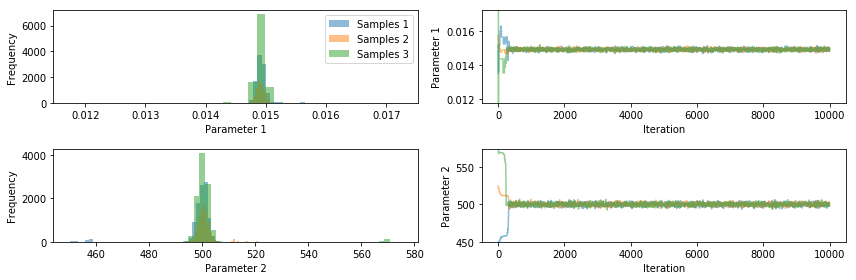

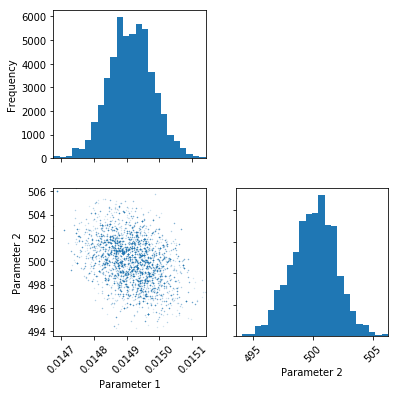

In [27]:
# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains_thin = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_thin[0])

# Show graphs
plt.show()

R-hat:
[1.0029269617921293, 1.0025890056685691]


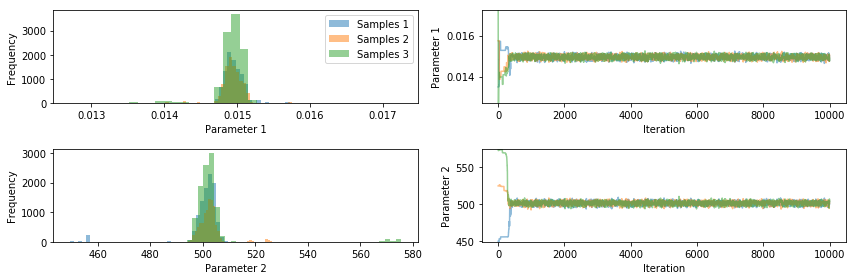

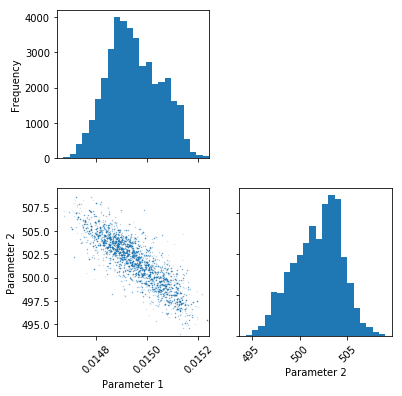

In [28]:
# Show traces and histograms
pints.plot.trace(chains_emu)

# Discard warm up
chains_emu_thin = chains_emu[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_emu_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_emu_thin[0])

# Show graphs
plt.show()

In [29]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

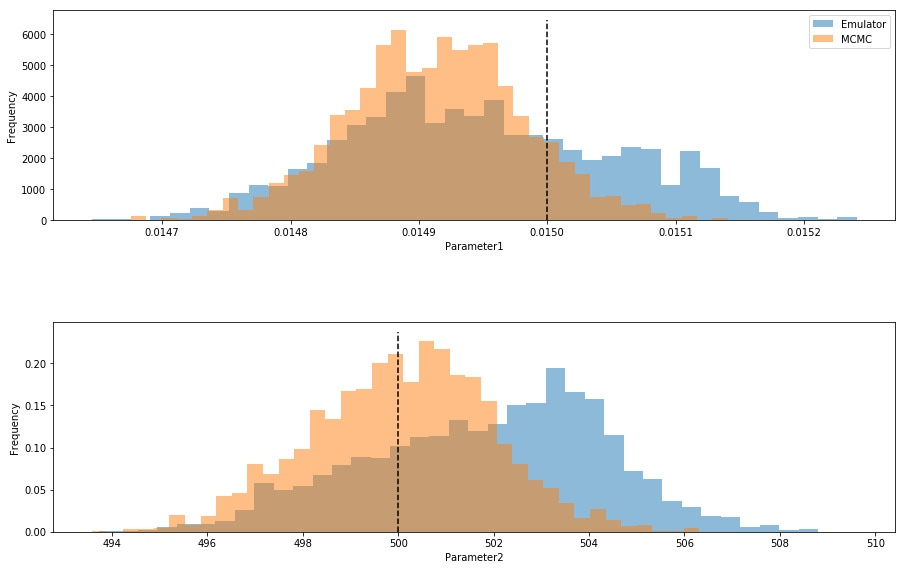

In [30]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

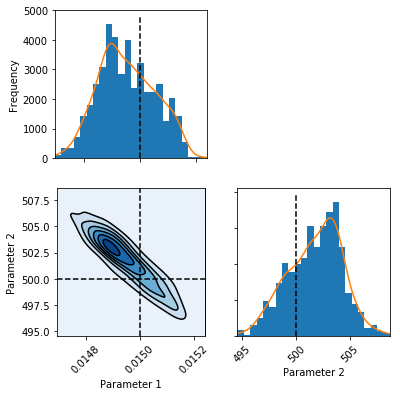

In [31]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

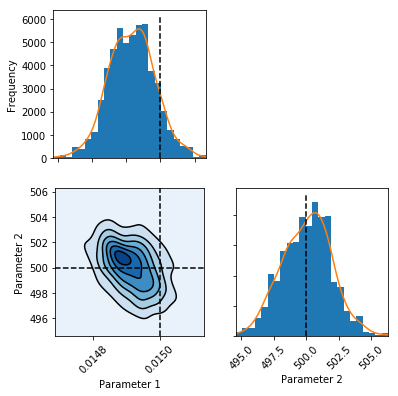

In [32]:
thinned_chain = chain[::10]
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

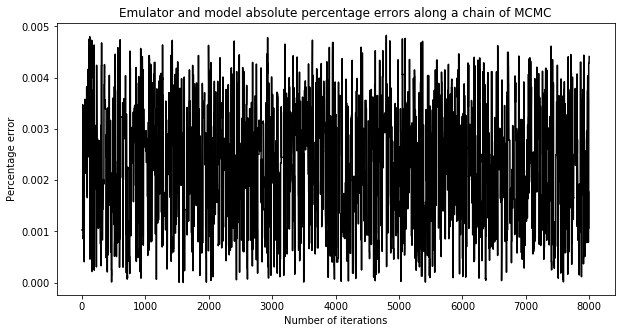

0.0023562101008224486

In [33]:
emu_likelihood = np.apply_along_axis(emu, 1, chain).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

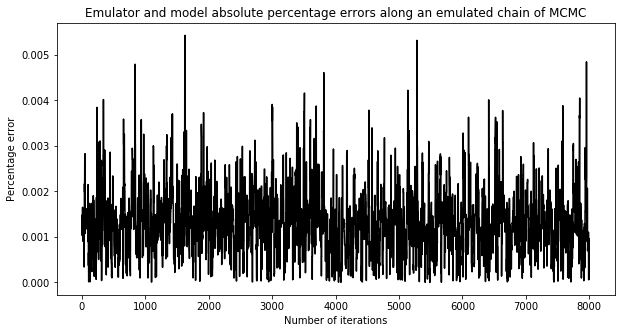

0.0013026483057971415

In [34]:
emu_likelihood = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along an emulated chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

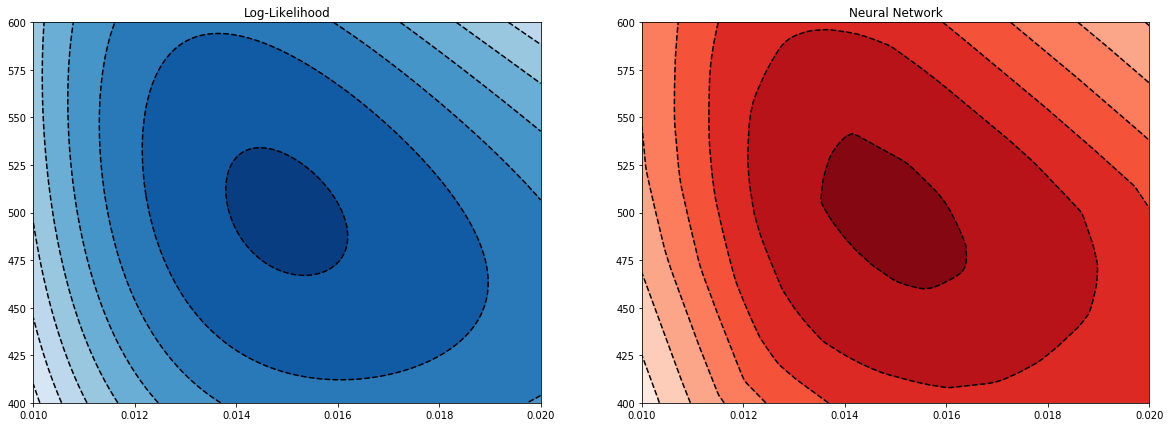

In [35]:
# Create grid of parameters
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

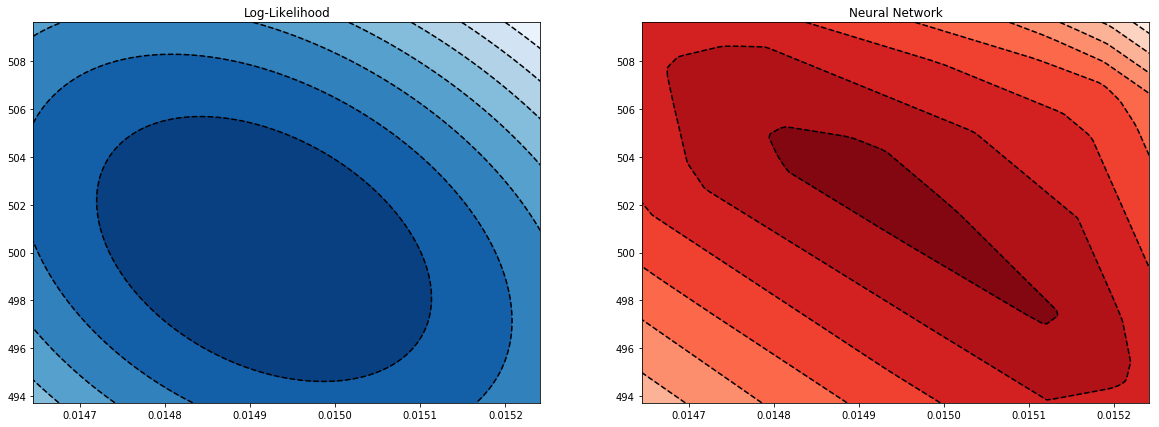

In [36]:
# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

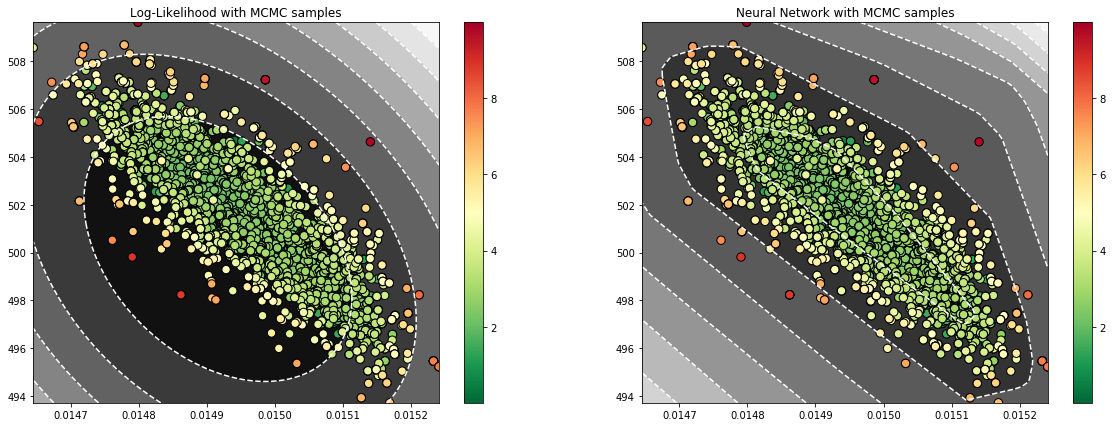

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to differences in log-likelihood
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
im1 = ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
im2 = ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

fig.savefig("figures/nn-test-contours-new-500-5perc.png", bbox_inches='tight', dpi=600)

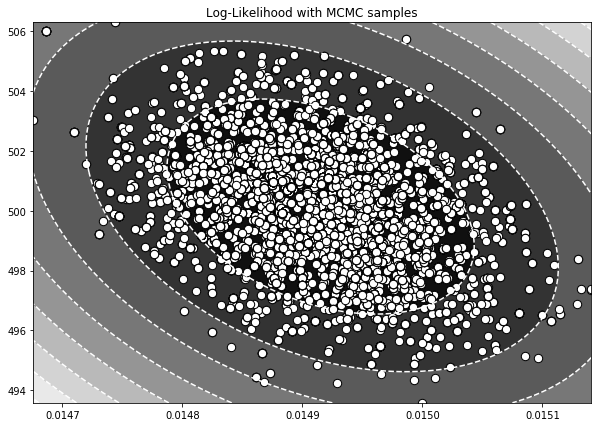

In [38]:
fig, ax = plt.subplots(figsize=(10,7))                   
ax.title.set_text('Log-Likelihood with MCMC samples')                                                                   

# Plot chain
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x, y, s=70, edgecolor='k', color='w')
plt.show()